In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_25x25.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 25, 25)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

7464.852345565599
2.220446049250313e-16


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 625)

In [10]:
np.max(flattened_matrix_np[train_index])

7464.852345565599

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 625)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 25, 25, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

7464.852345565599

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 625)

In [19]:
scaled_flattened_matrix.shape

(198, 625)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0
0.0


In [21]:
scaled_flattened_matrix.shape

(198, 625)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 32500)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 25, 25, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 25, 25, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 25, 25, 1)
(88, 625)
(28, 52, 25, 25, 1)
(28, 625)
(28, 52, 25, 25, 1)
(28, 625)


In [33]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda, Reshape, LeakyReLU, Attention
from tensorflow.keras import backend as K


In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## Fully connected Model

In [35]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))
   
timeDist = TimeDistributed(Flatten())(inputs)

Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(timeDist)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_Fully_Connected")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)

Model: "Flattened_Fully_Connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 52, 25, 25, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, 52, 625)           0         
_________________________________________________________________
dense (Dense)                (None, 52, 100)           62600     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 625)               3250625   
Total params: 3,313,225
Trainable params: 3,313,225
Non-trainable params: 0
_________________________________________________________________


## Flattened LSTM Model

In [41]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

    
timeDist = TimeDistributed(Flatten())(inputs)

LSTM_layer1 = LSTM(1000, return_sequences=True)(timeDist)
LSTM_layer2 = LSTM(1000, return_sequences=True)(LSTM_layer1)
LSTM_layer3 = LSTM(1000)(LSTM_layer2)
#Dense1 = Dense(1000, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer2)
Dense2 = Dense(Y_train.shape[1])(LSTM_layer3)
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



Model: "Flattened_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 52, 25, 25, 1)]   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 52, 625)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 52, 1000)          6504000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 52, 1000)          8004000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense_2 (Dense)              (None, 625)               625625    
Total params: 23,137,625
Trainable params: 23,137,625
Non-trainable params: 0
________________________________________

## 2D CNN LSTM

In [44]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
batch = 48
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(20, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(20, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])

LSTM_layer1 = LSTM(100)(merge)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "2DCNN_LTSM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 52, 25, 25,  0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 52, 25, 25, 2 40          input_3[0][0]                    
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 52, 25, 25, 2 420         time_distributed_2[0][0]         
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 52, 12, 12, 2 0           time_distributed_3[0][0]         
_________________________________________________________________________________________

## Flatten LSTM + Attention

In [47]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#send both convolved layer and flattened layer into LSTM
timeDist = TimeDistributed(Flatten())(inputs)
#diffTime = Lambda(lambda x: x[:,:-1,:]-x[:,1:,:],name='timestep_diff')(timeDist3)
units = 1000
LSTM_layer1 = LSTM(units, return_sequences=True)(timeDist)

attention = Dense(units, activation='tanh')(LSTM_layer1) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)
attention = Flatten()(attention)
attention = Activation('softmax',name='attention_weights')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

sent_representation = Multiply()([LSTM_layer1, attention])
attended_LSTM_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line
D_temp = Dense(units*2, activation='relu')(attended_LSTM_out) # hidden layer

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(D_temp)
outputs = Dense2

model = Model(inputs, outputs, name="FLATTENED_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)

Model: "FLATTENED_LTSM_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 52, 25, 25,  0                                            
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 52, 625)      0           input_4[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 52, 1000)     6504000     time_distributed_10[0][0]        
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 52, 1000)     1001000     lstm_4[0][0]                     
___________________________________________________________________________

# TimeDistributed Attention on Pixels

In [50]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh',name="W")(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear',name ="Query")(attention1) ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
#attended_Dense_out1 = TimeDistributed(Dense(3, activation='relu'))(attention1)

attended_Dense_out = TimeDistributed(Dense(1, activation='relu'))(attention1 )

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2


model = Model(inputs, outputs, name="TimeDistributed_attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "TimeDistributed_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 52, 25, 25,  0                                            
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 52, 625)      0           input_5[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 625, 52)      0           time_distributed_11[0][0]        
__________________________________________________________________________________________________
W (Dense)                       (None, 625, 52)      2756        permute_1[0][0]                  
__________________________________________________________________________

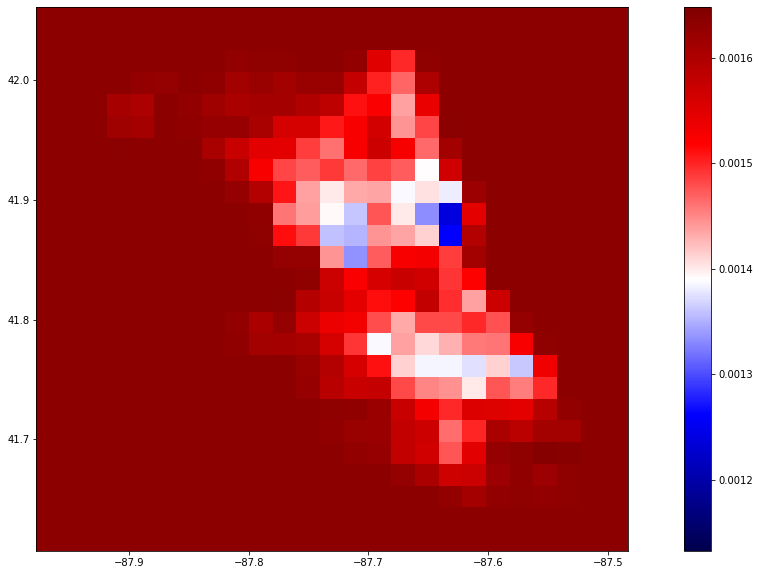

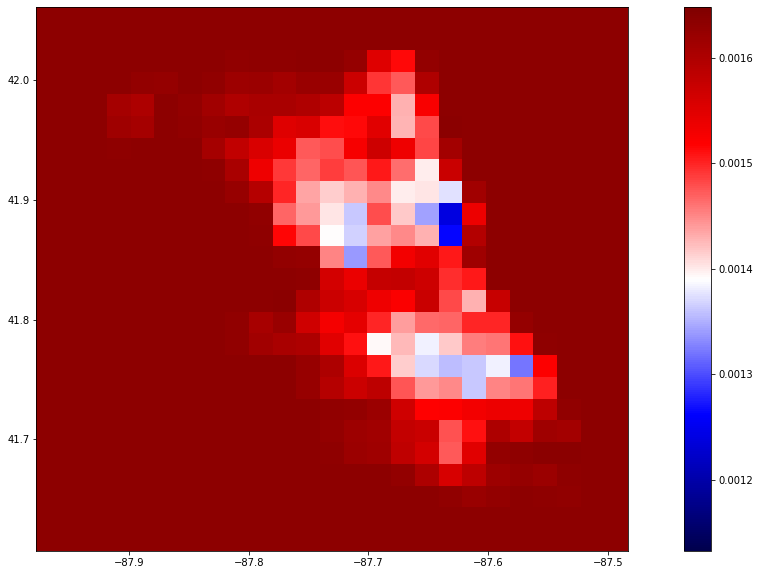

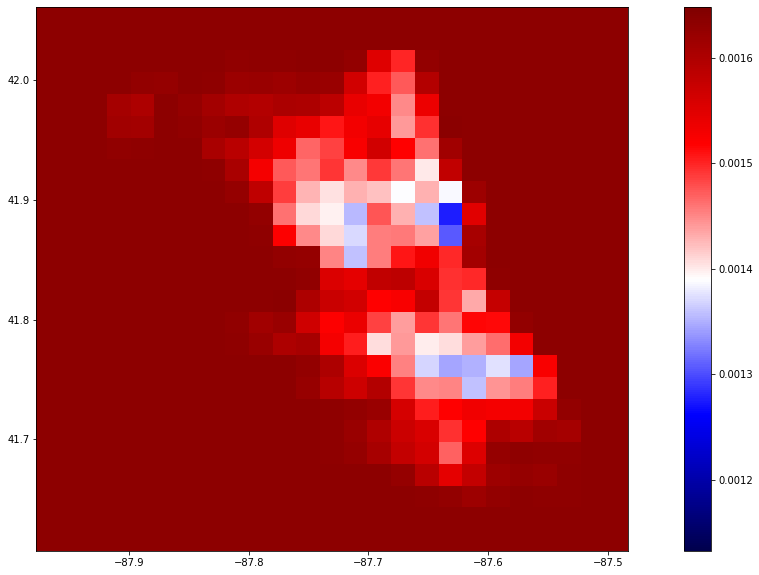

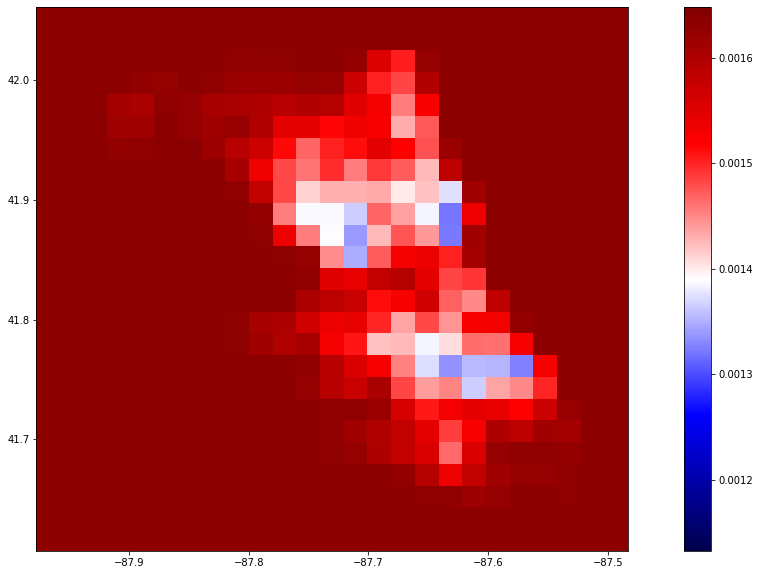

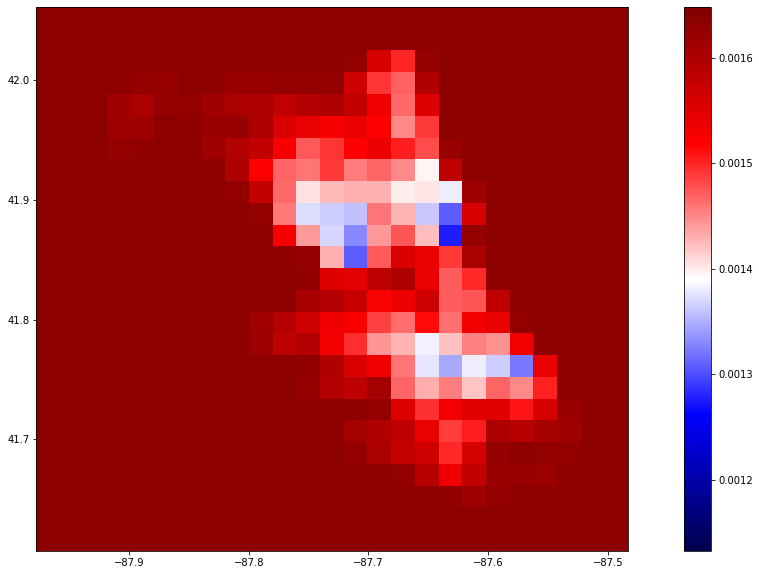

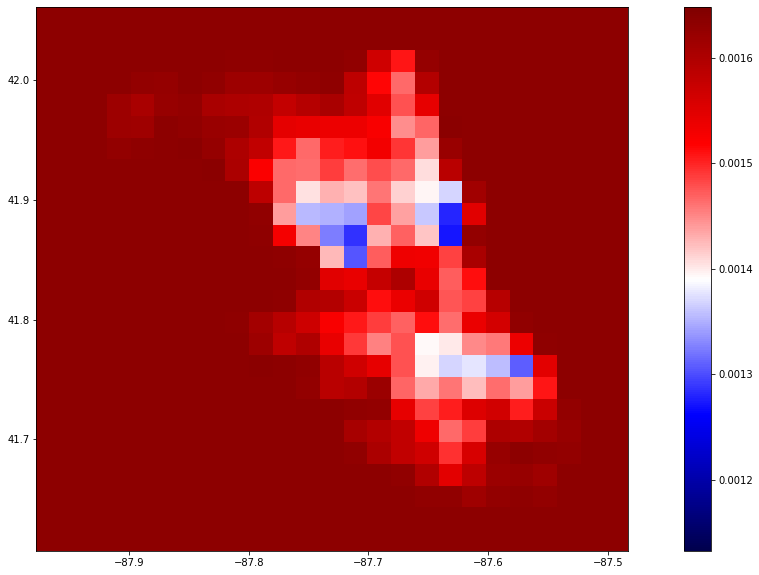

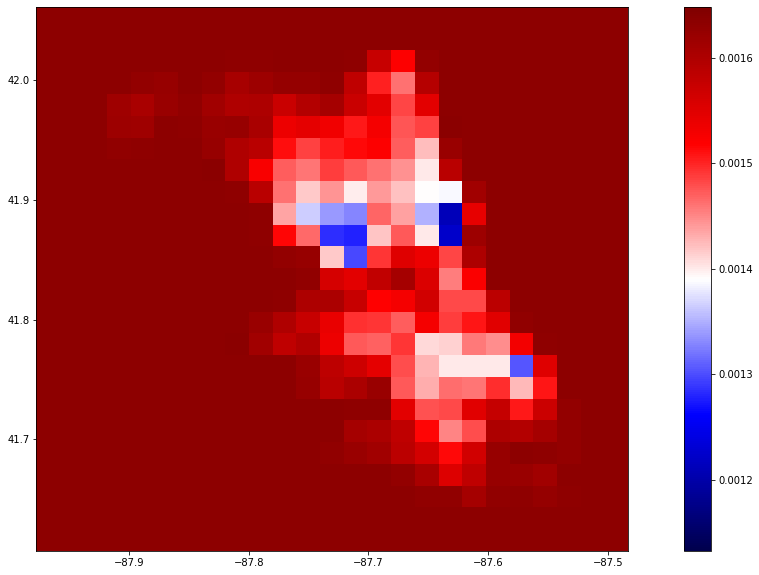

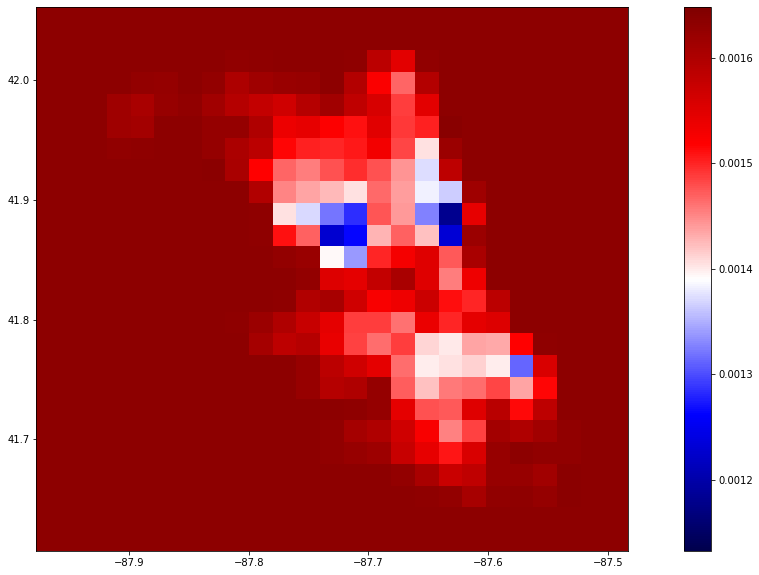

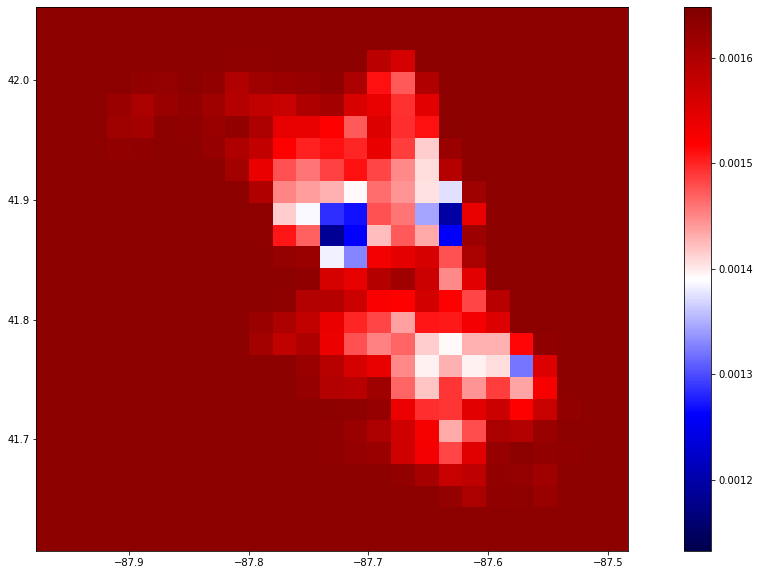

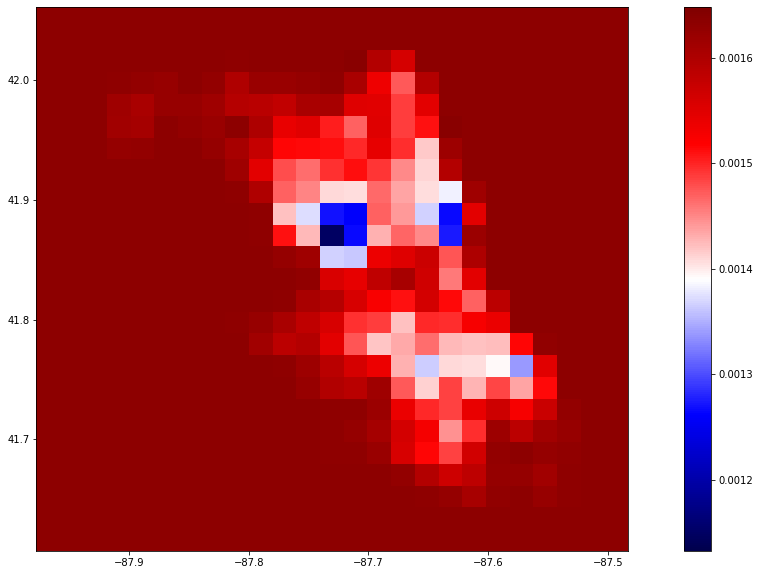

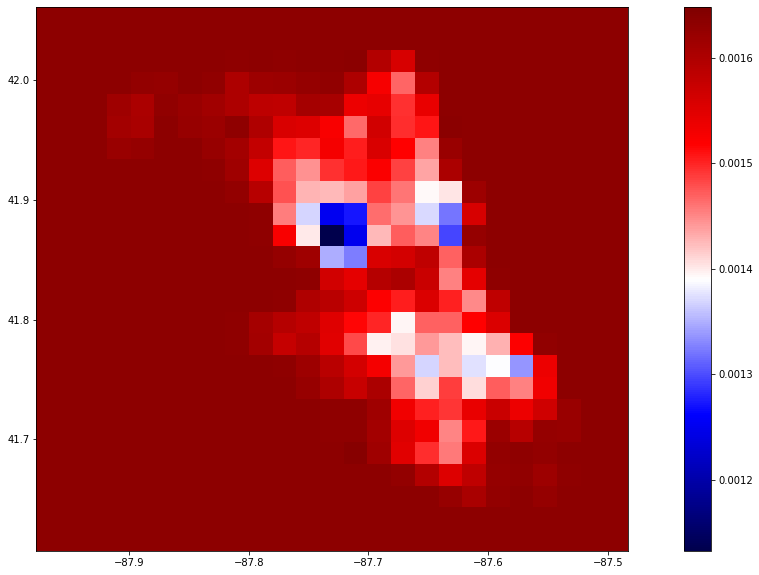

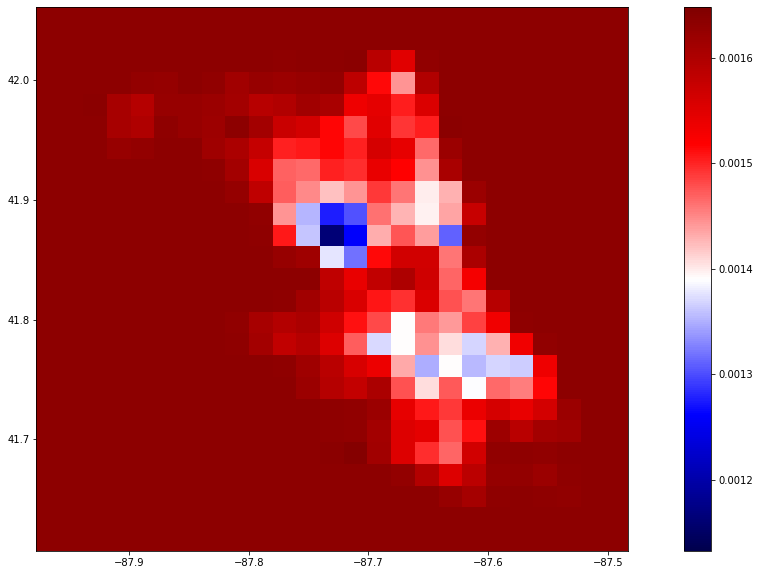

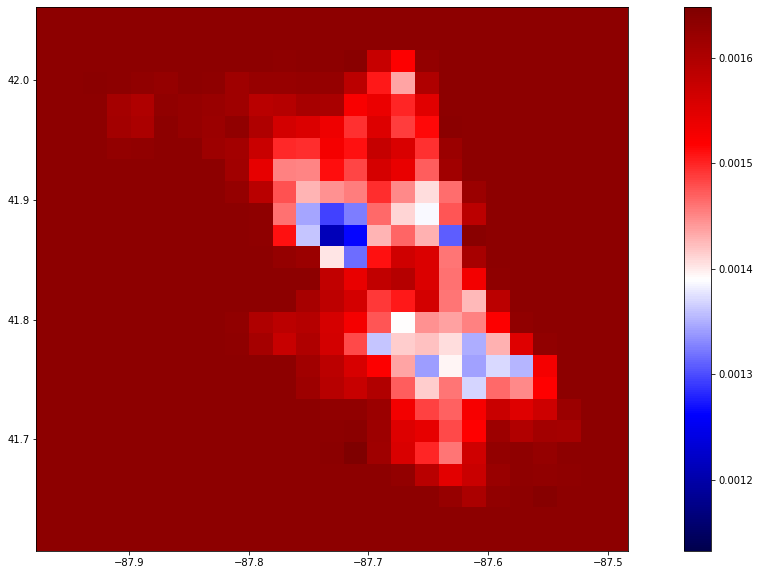

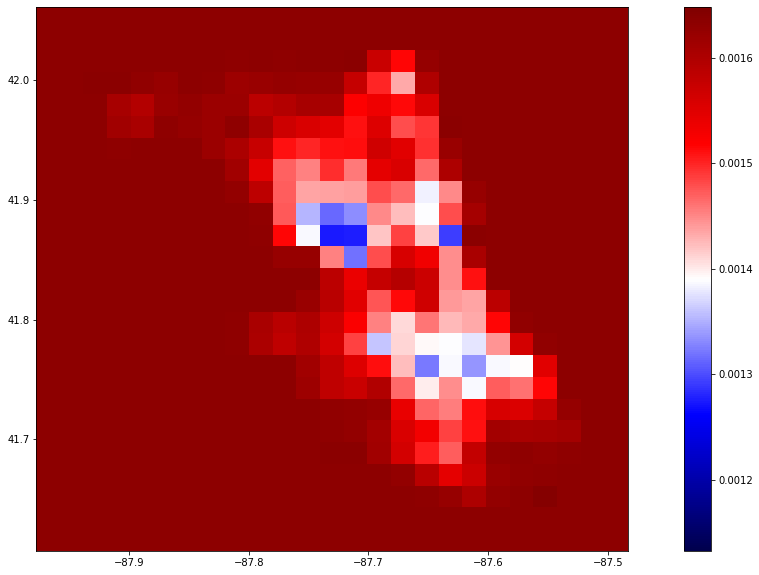

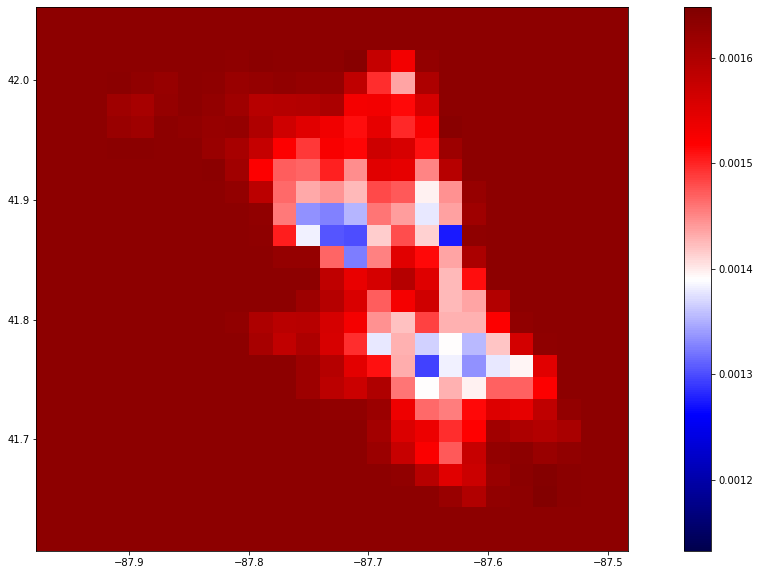

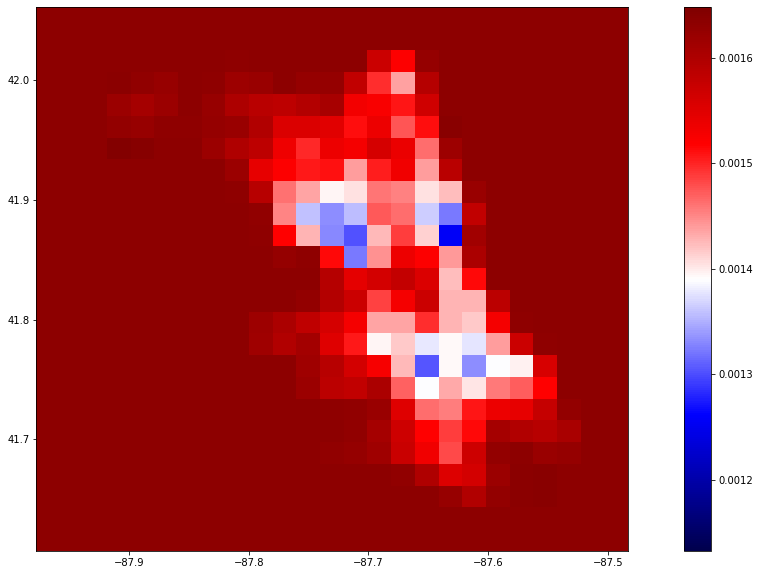

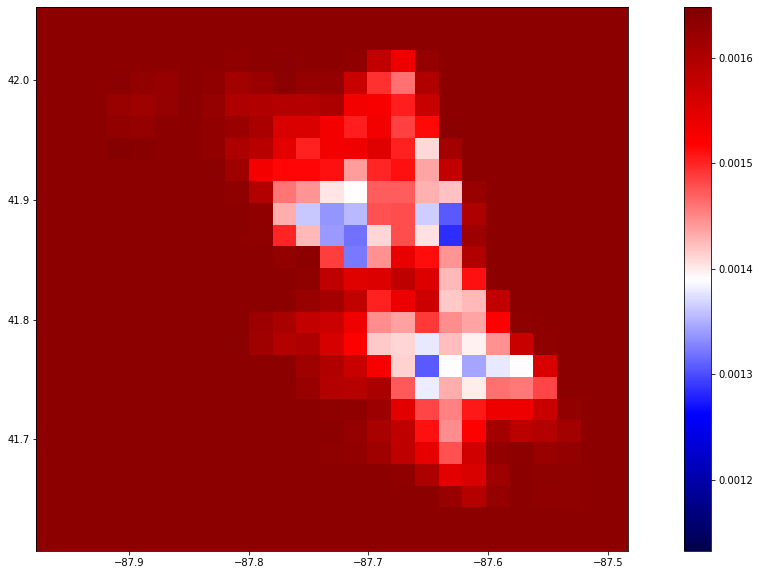

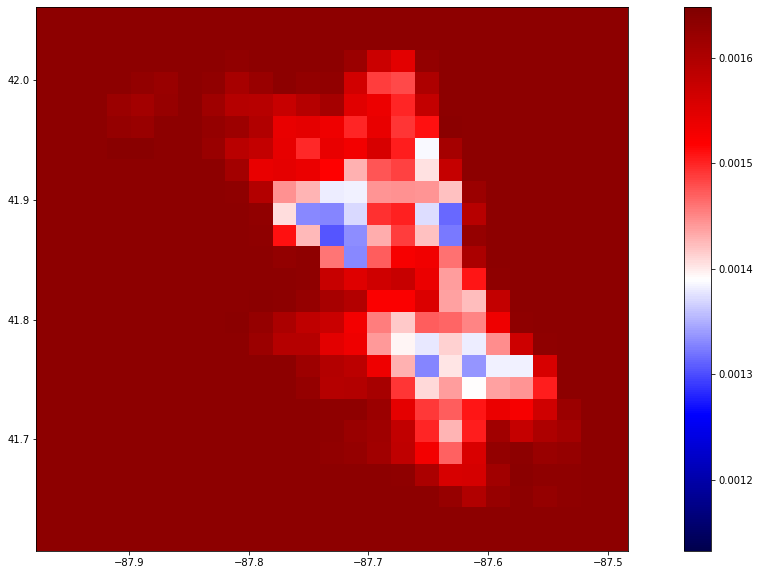

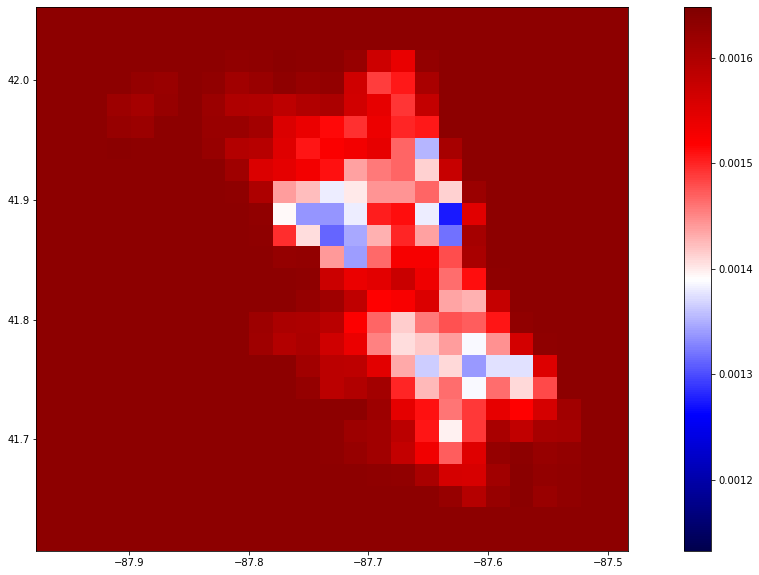

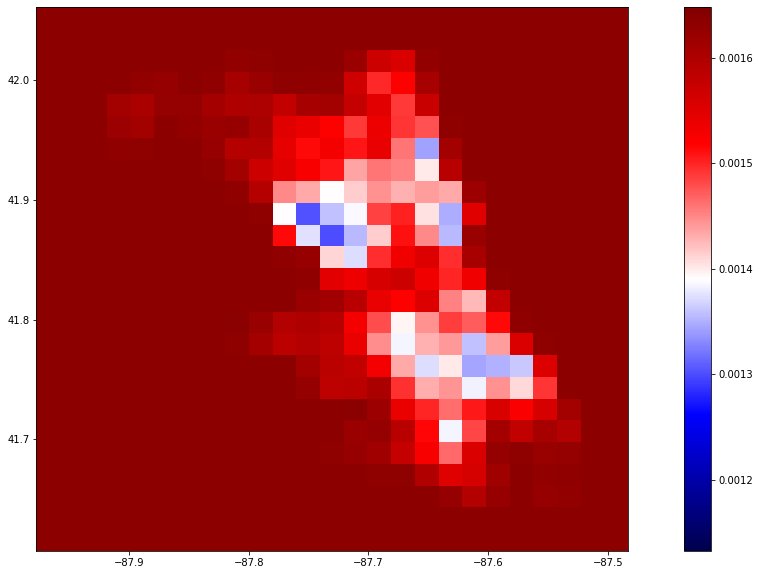

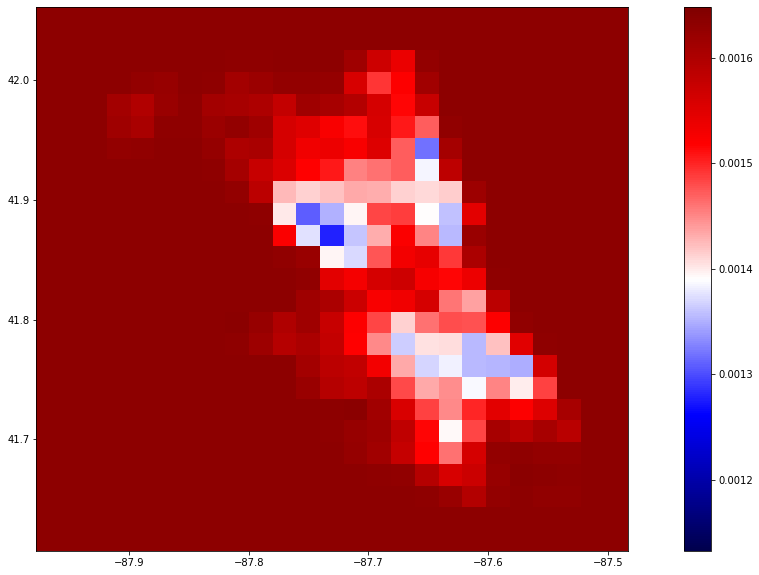

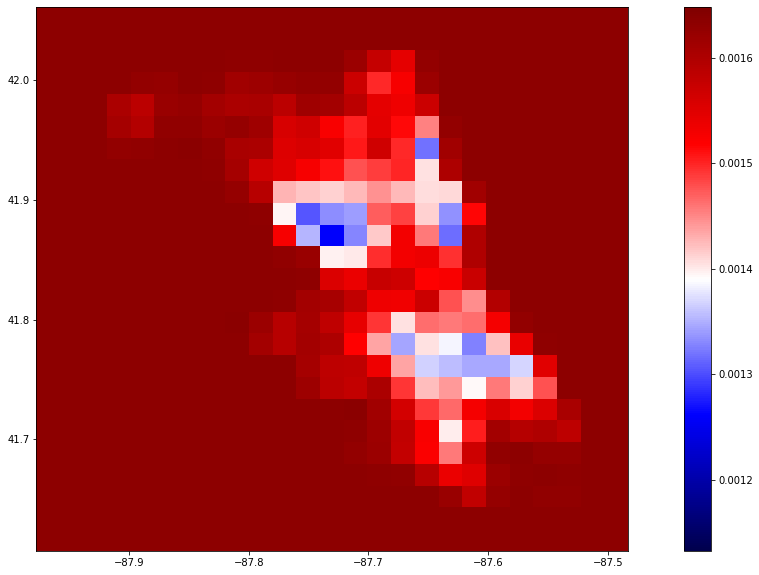

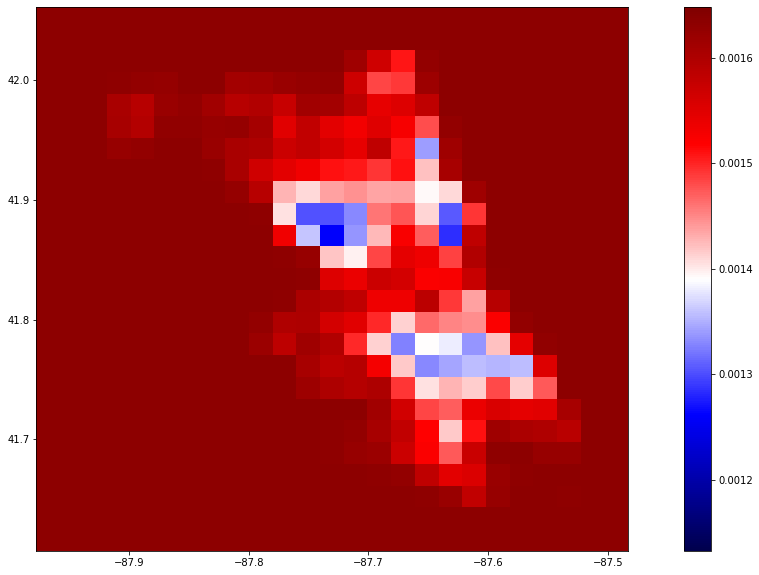

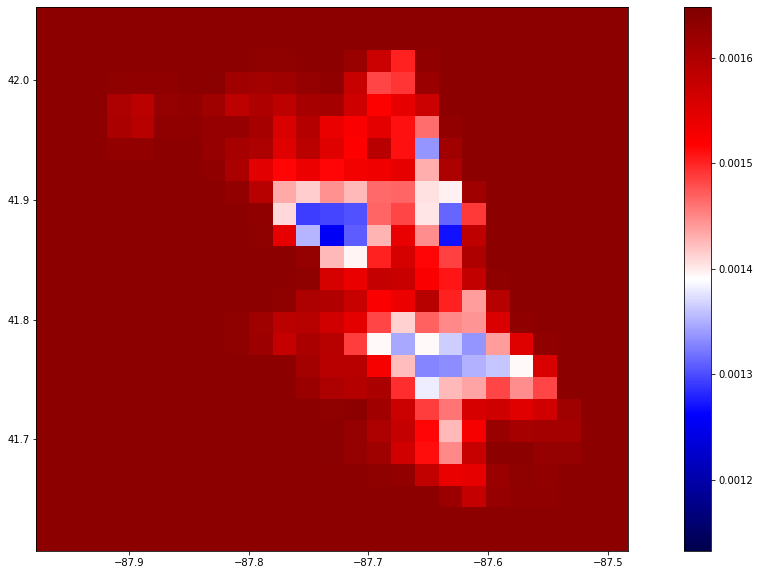

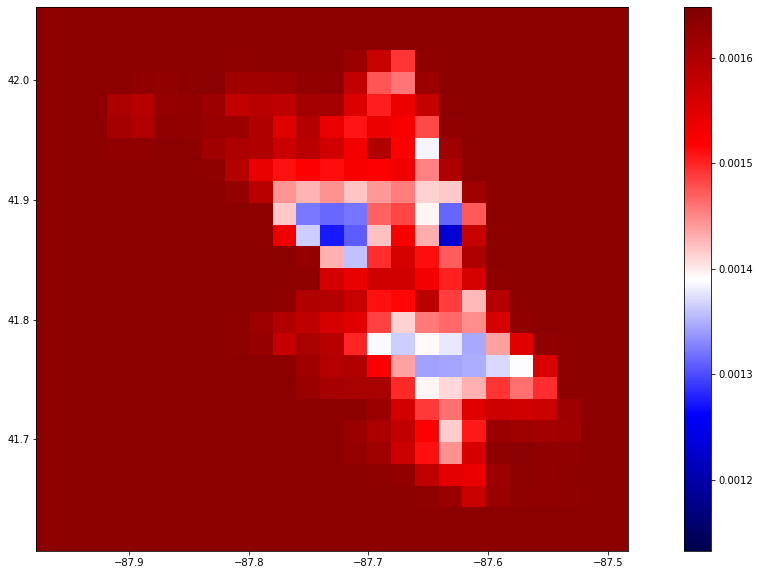

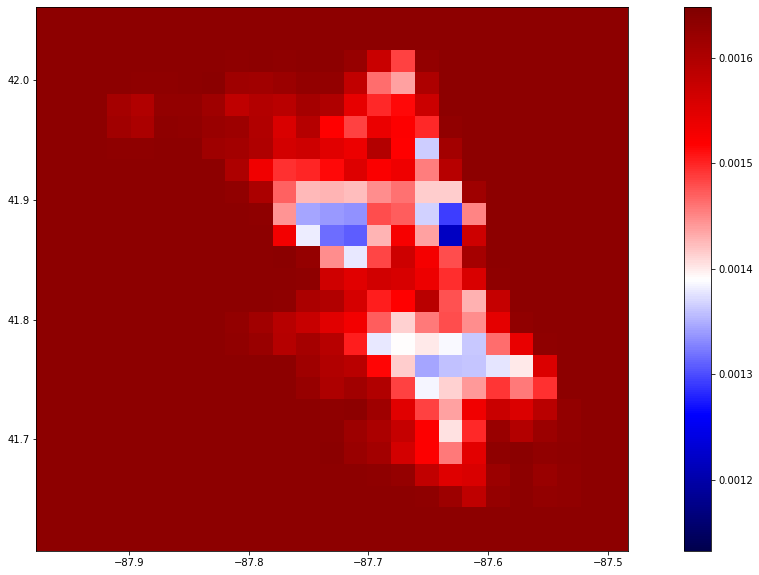

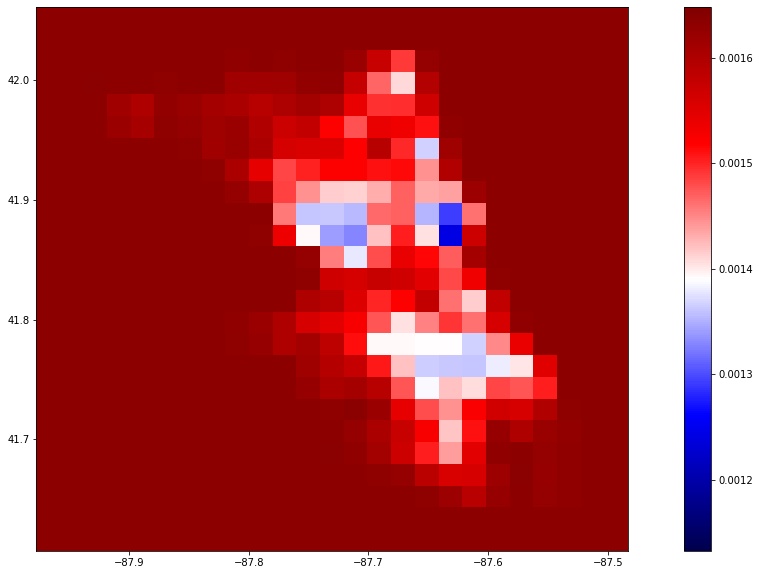

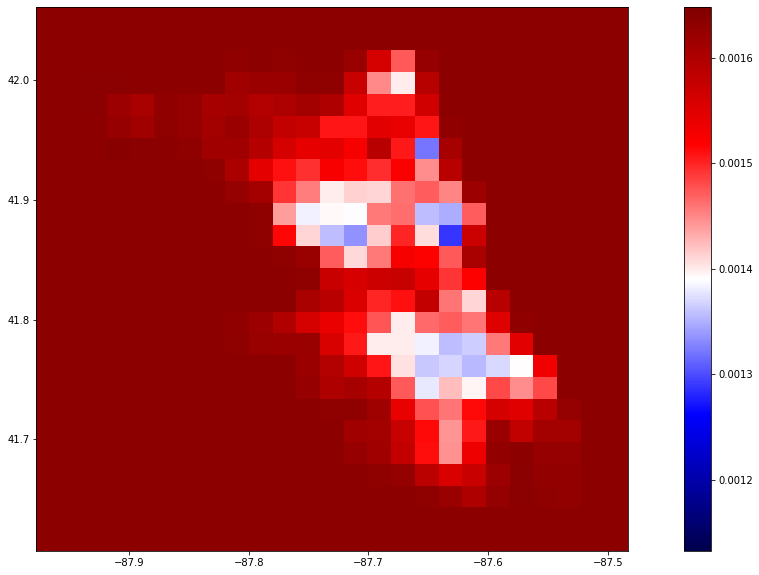

In [54]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(25,25)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

## TimeDistributed attention + attention on time

In [55]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh')(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear')(attention1)     ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
print(attention1.shape)
timeDist2 = TimeDistributed(Dense(1000))(attention1)
units = timeDist2.shape[2]
# compute importance for each step
attention2 = Dense(units/10, activation='tanh')(timeDist2) ## weight matrix W (= units x units/10) dimension reduction with W
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax',name='attention2_weights')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation = Multiply()([timeDist2, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(100, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2

model = Model(inputs, outputs, name="TimeDistributed_attention1_plus_attention2_on_time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


(None, 52, 625)
Model: "TimeDistributed_attention1_plus_attention2_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 52, 25, 25,  0                                            
__________________________________________________________________________________________________
time_distributed_13 (TimeDistri (None, 52, 625)      0           input_6[0][0]                    
__________________________________________________________________________________________________
permute_4 (Permute)             (None, 625, 52)      0           time_distributed_13[0][0]        
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 625, 52)      2756        permute_4[0][0]                  
_________________________________

In [58]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

#### We peak at trained attention1 on the image layer

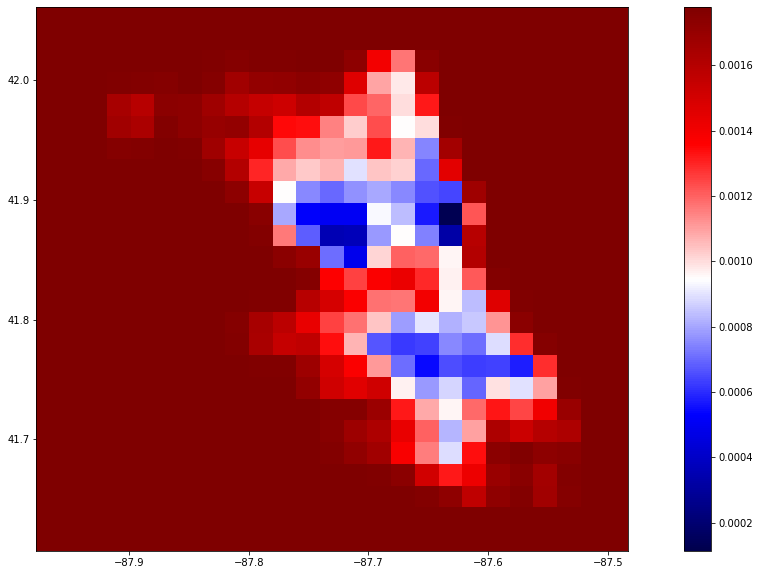

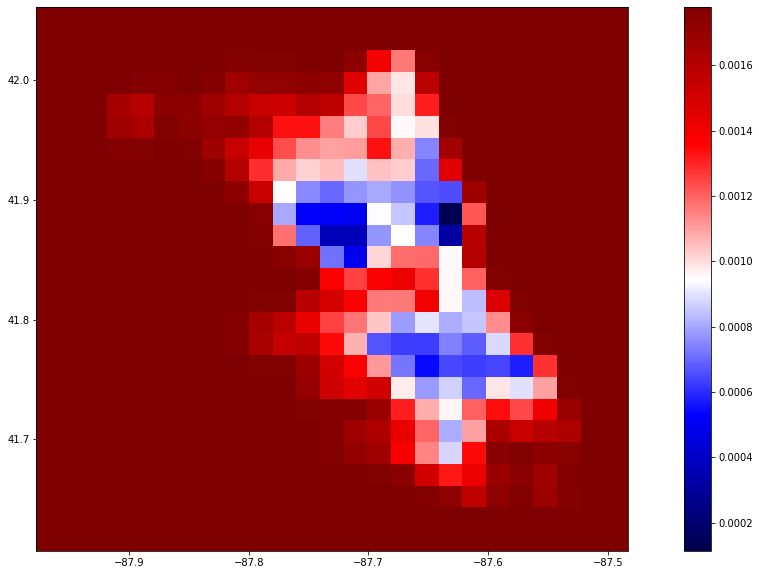

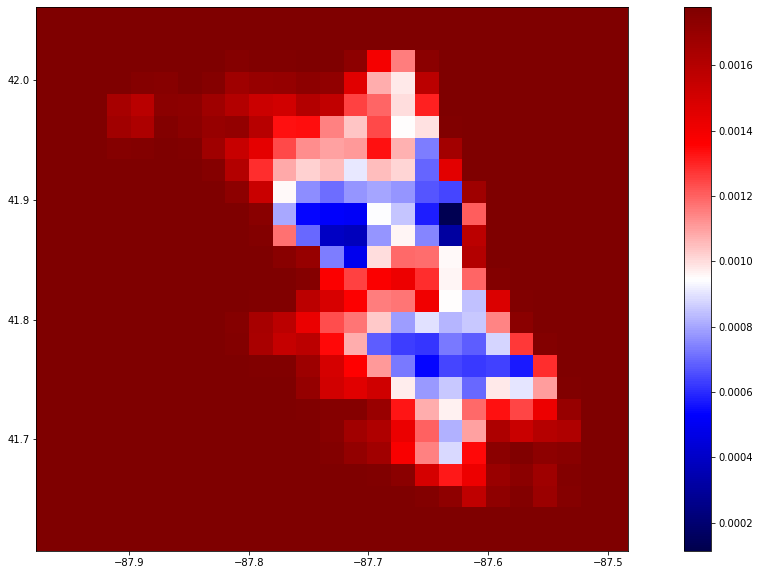

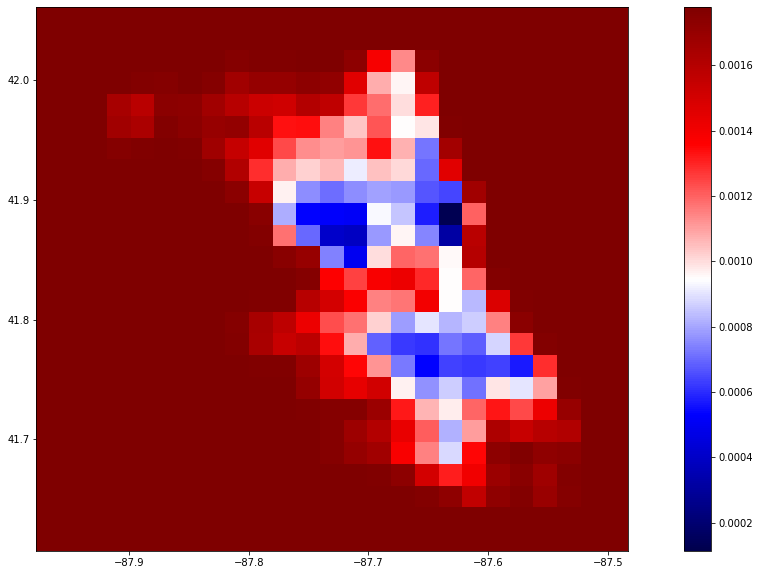

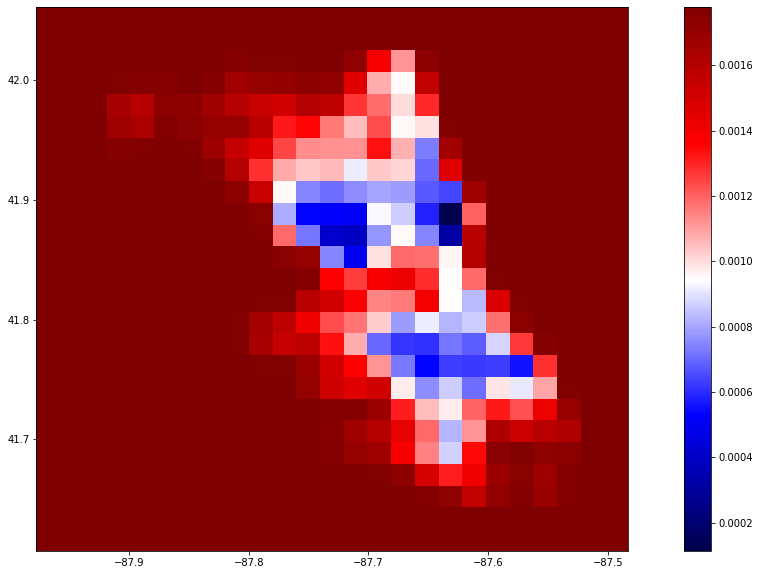

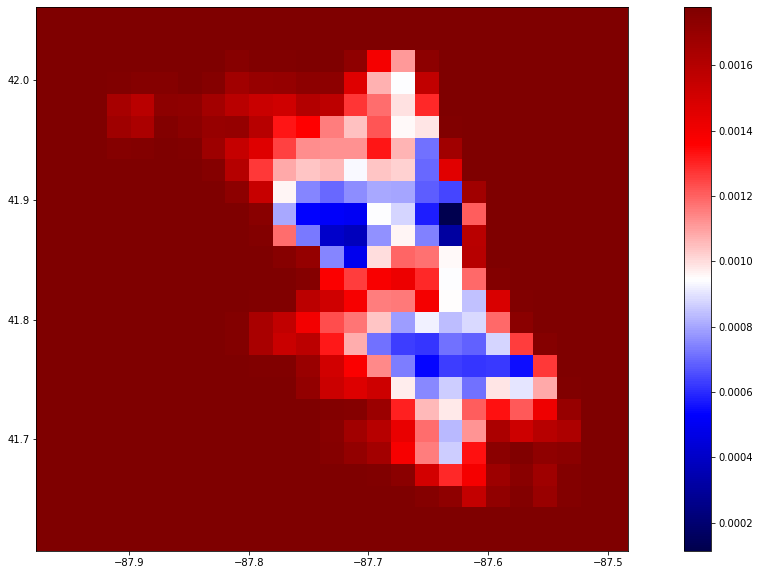

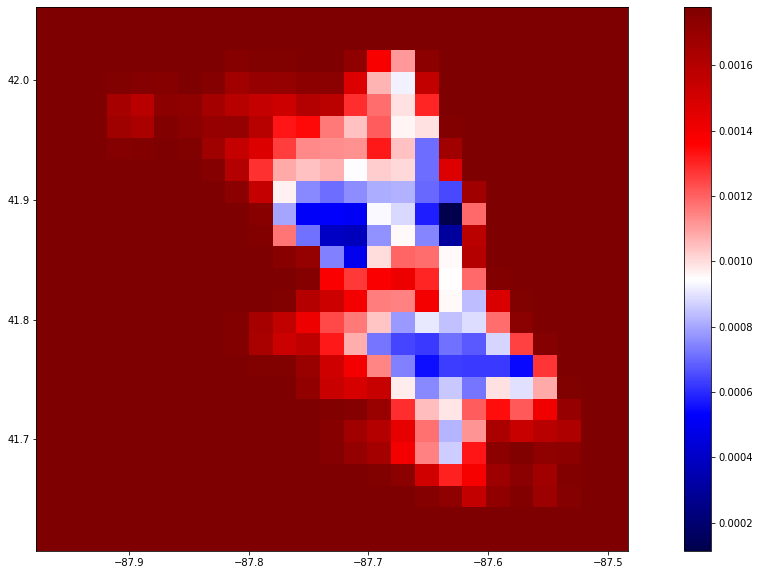

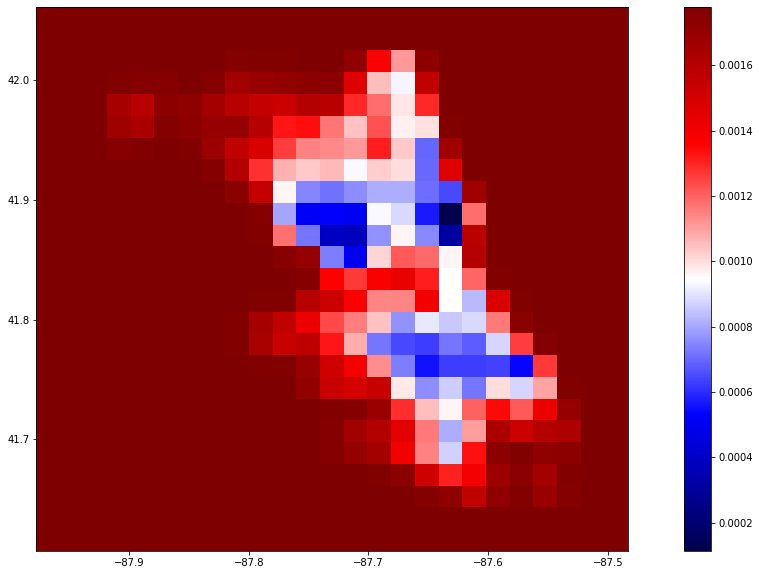

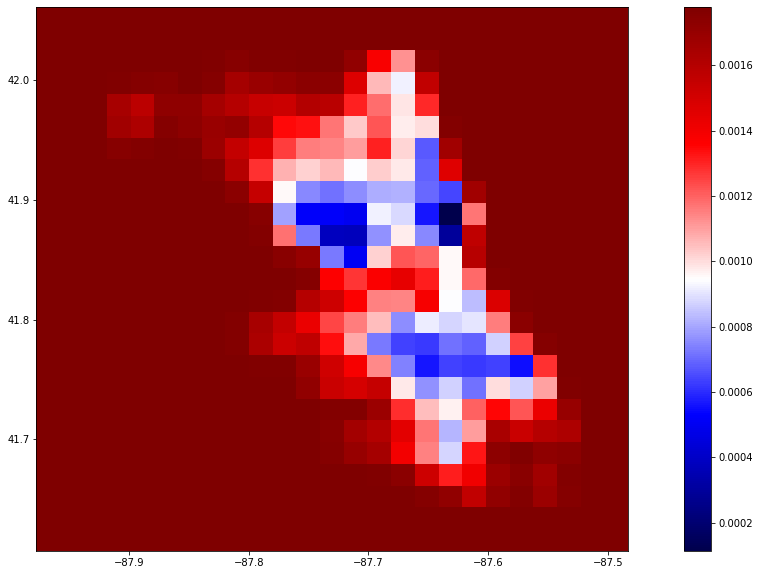

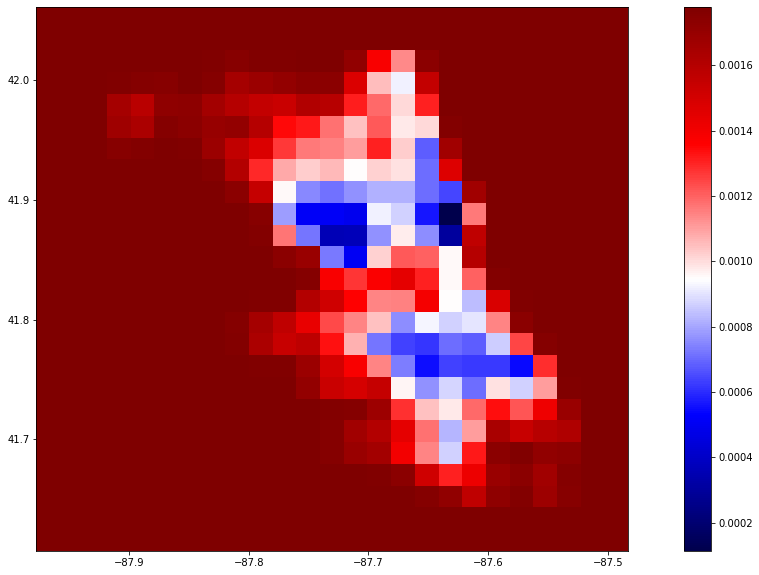

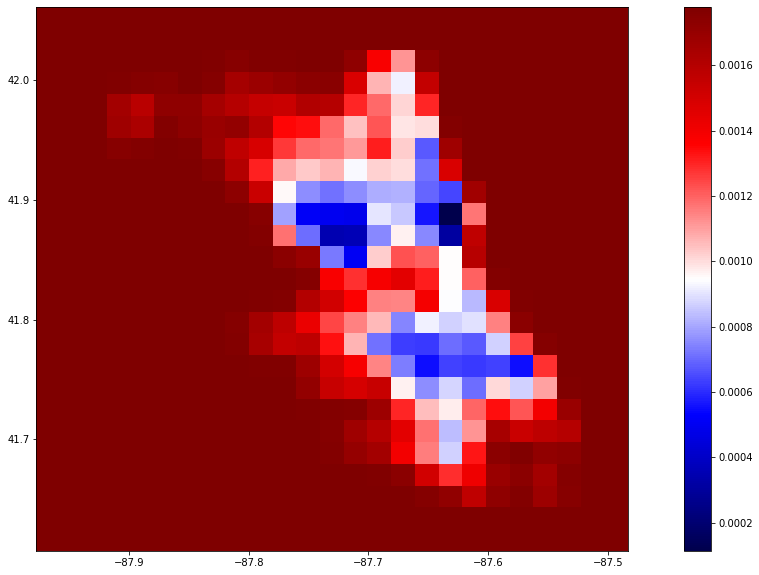

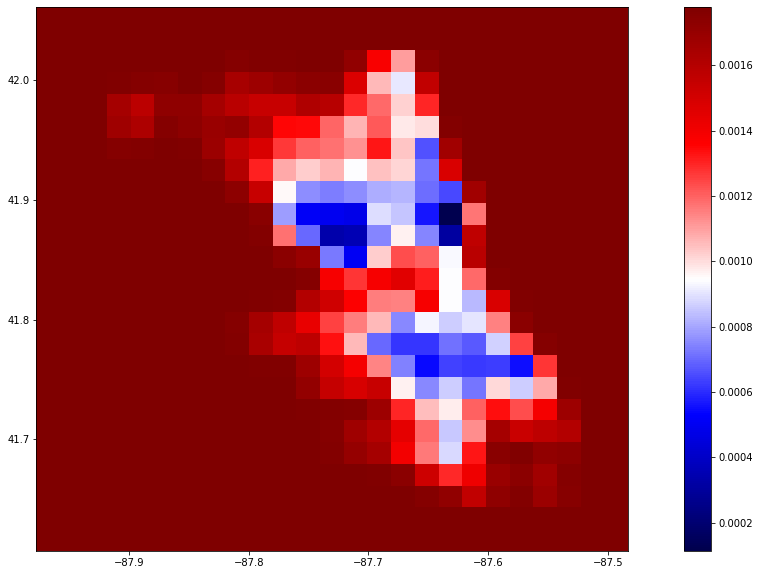

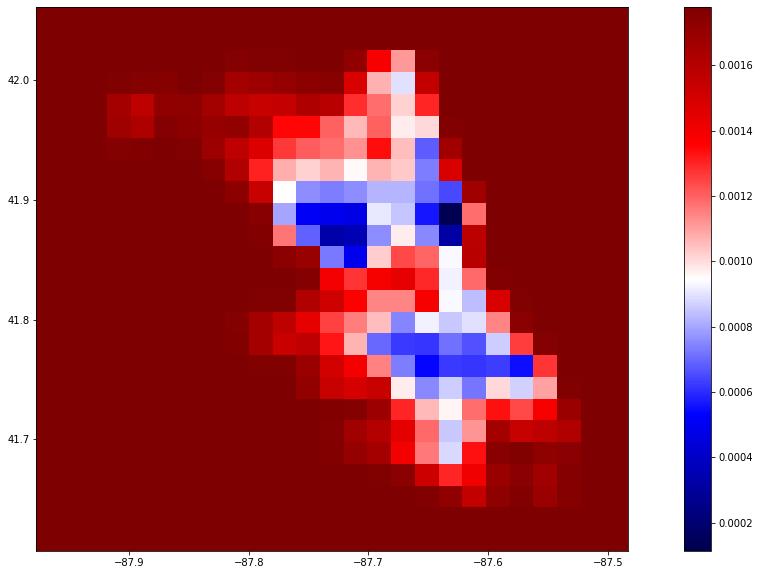

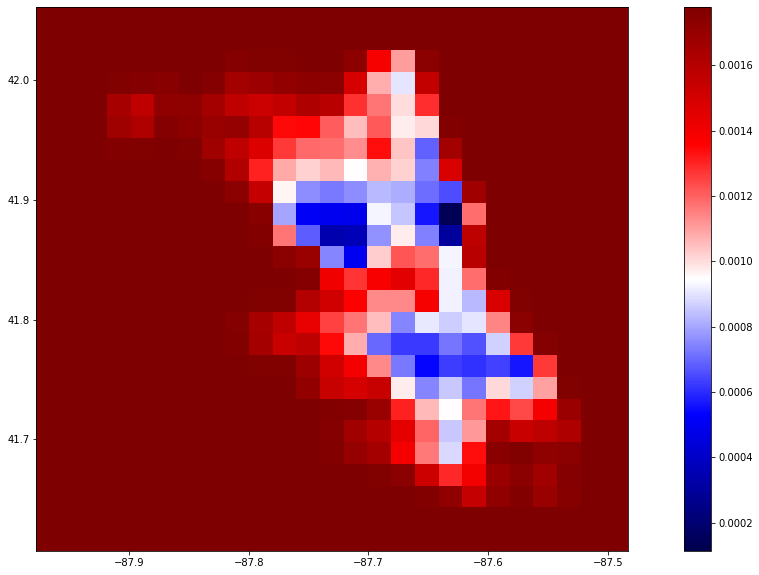

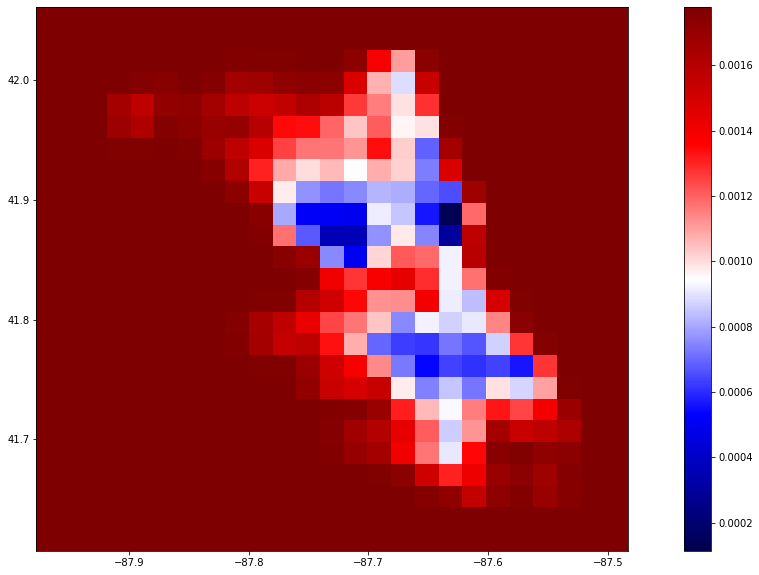

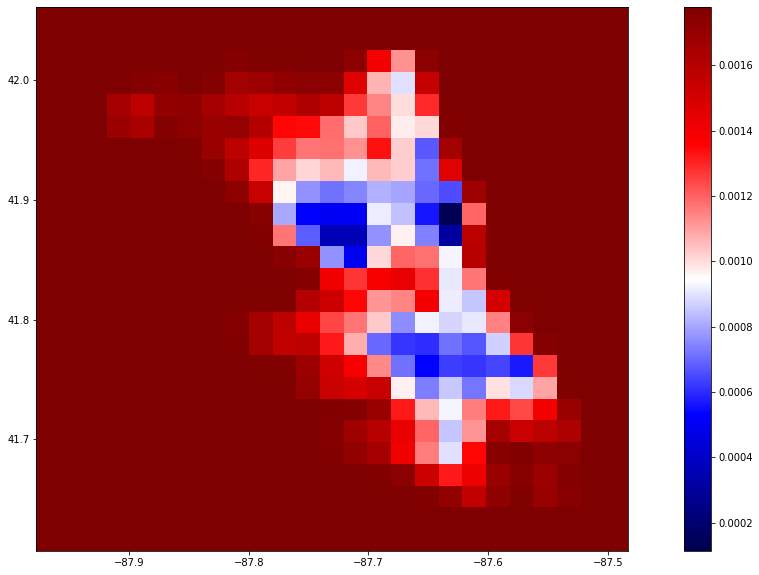

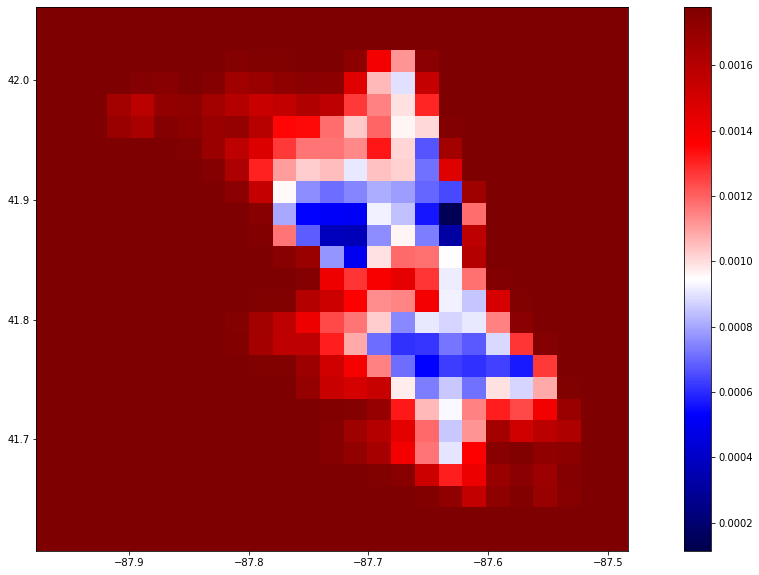

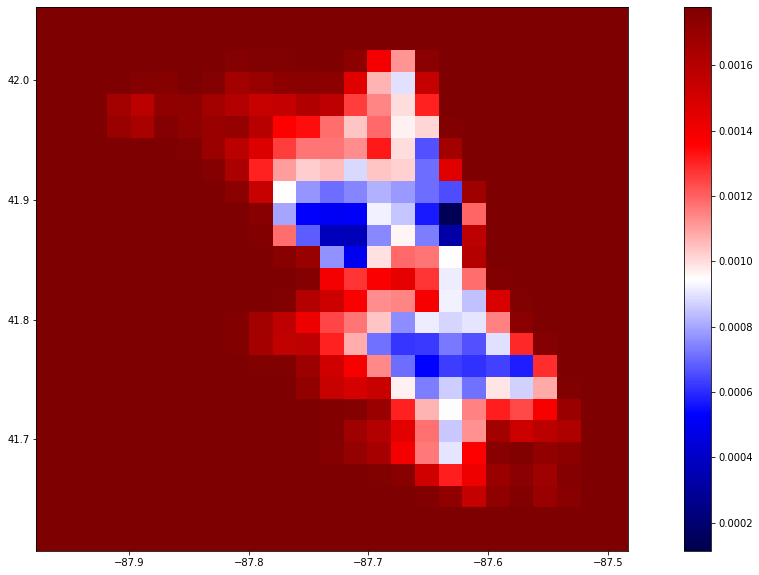

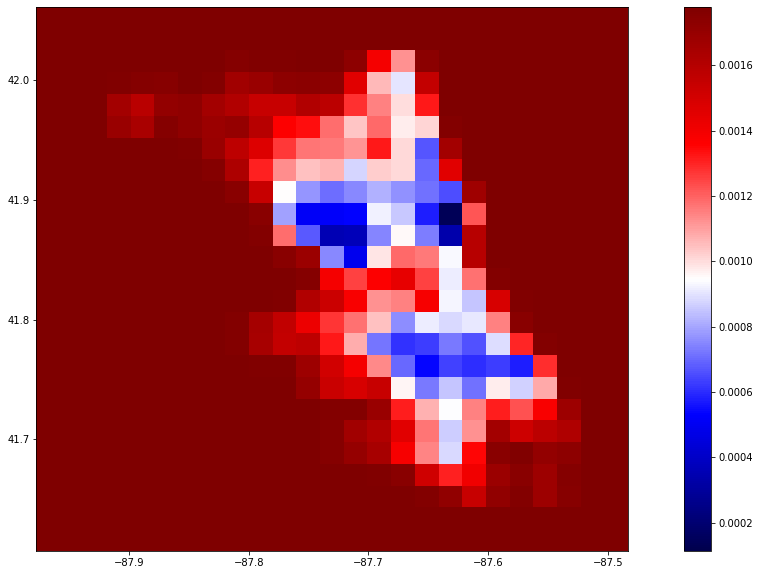

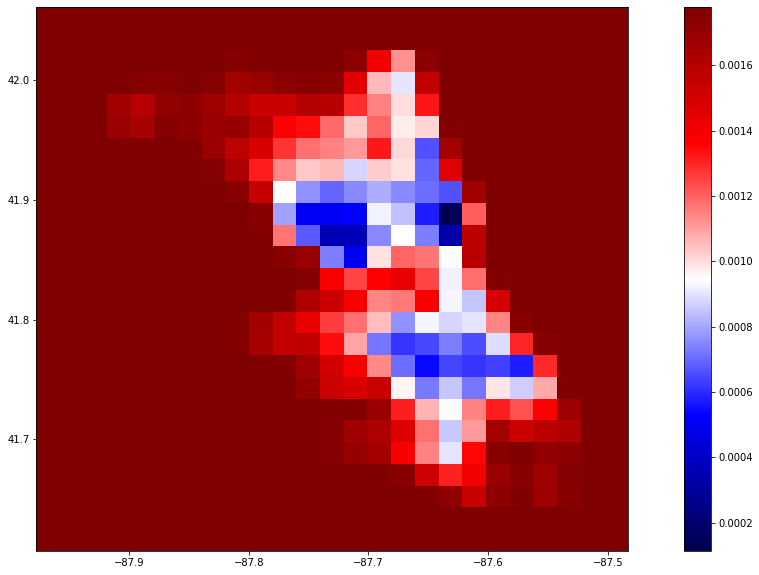

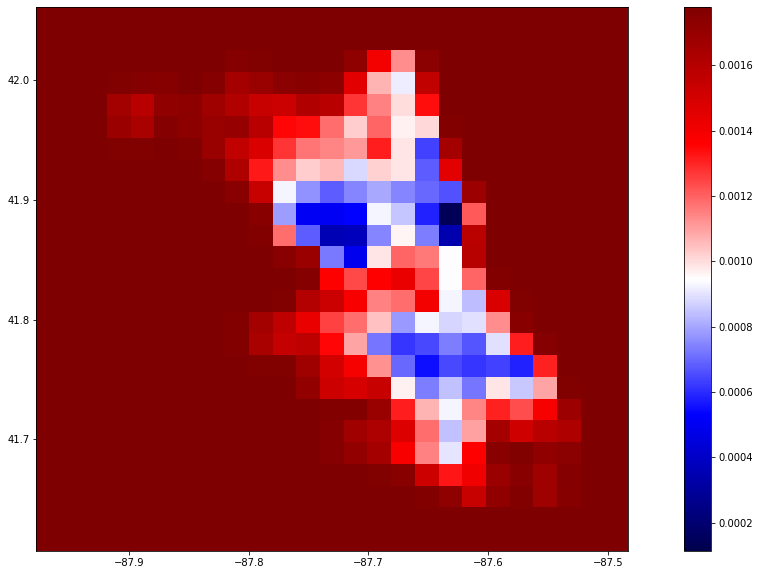

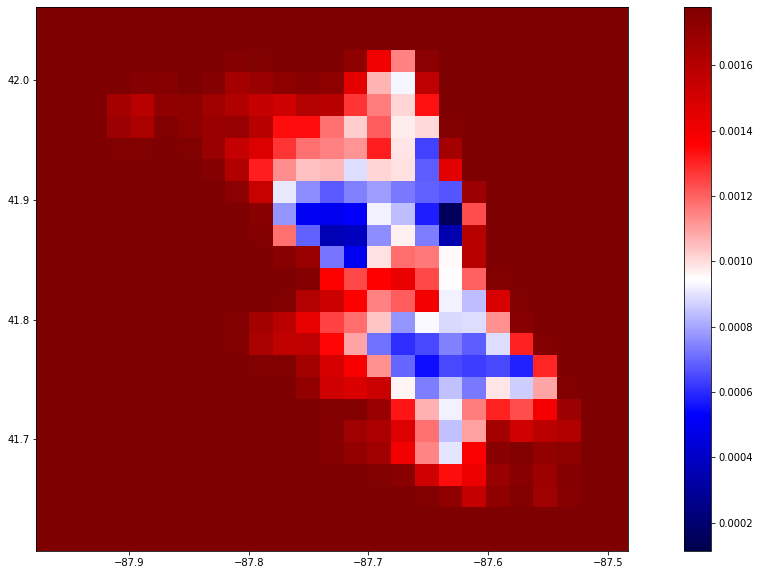

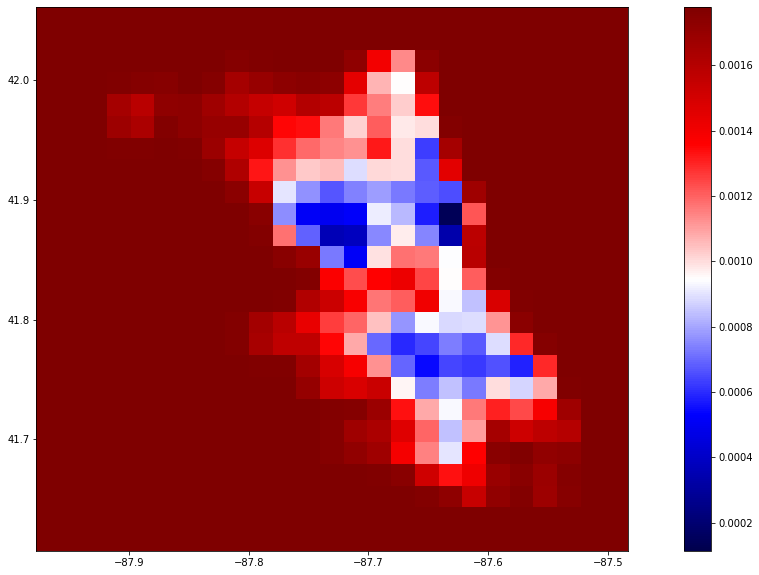

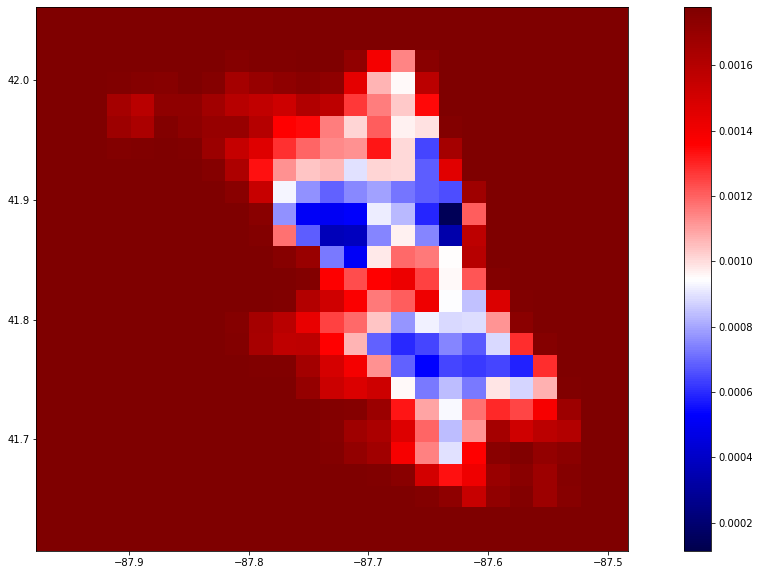

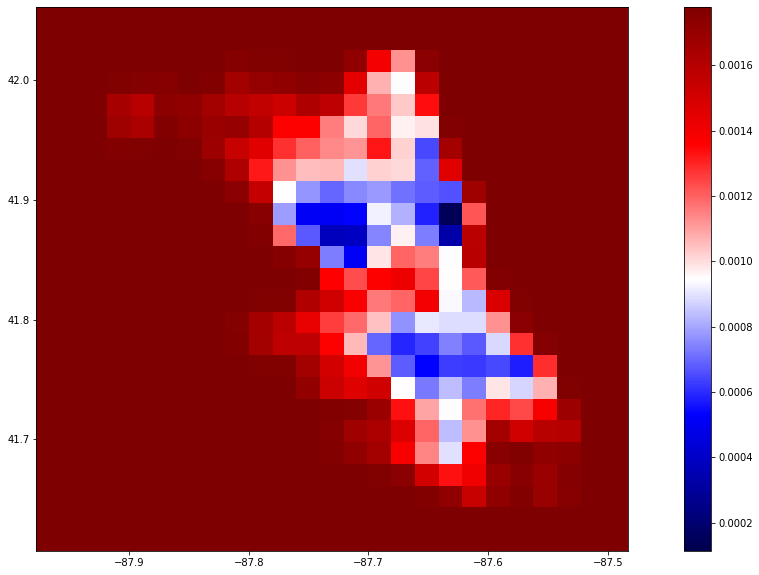

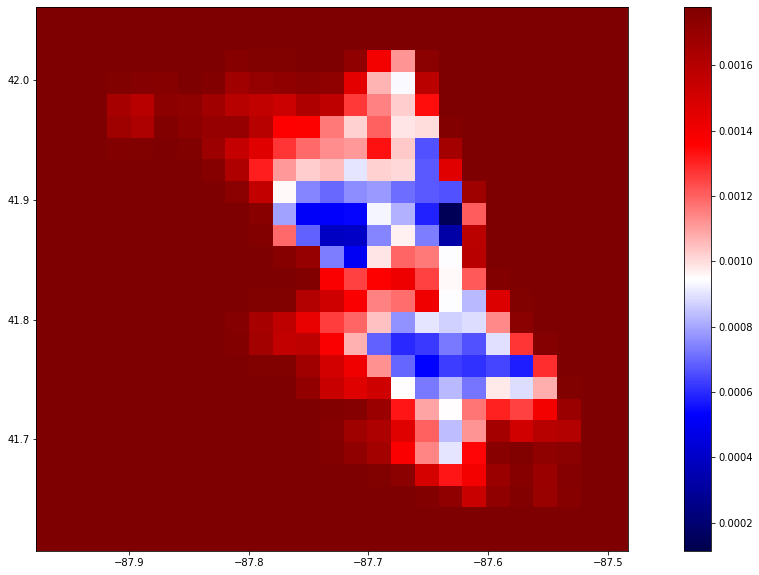

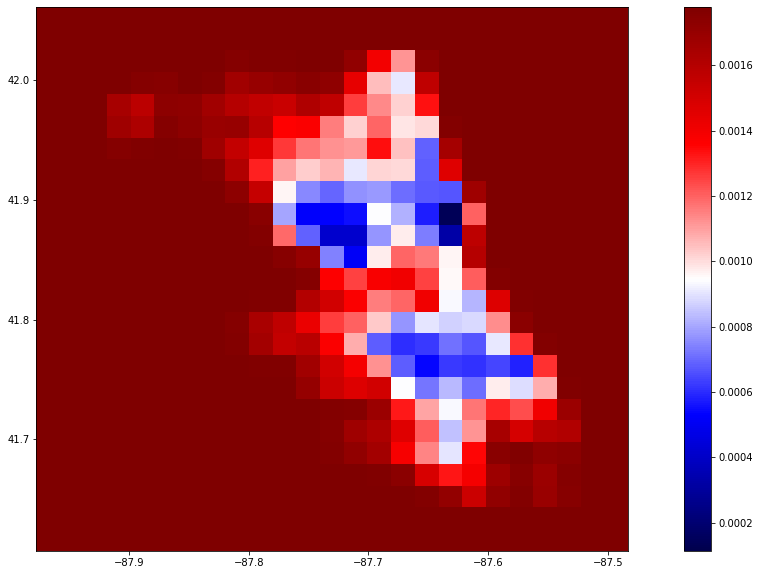

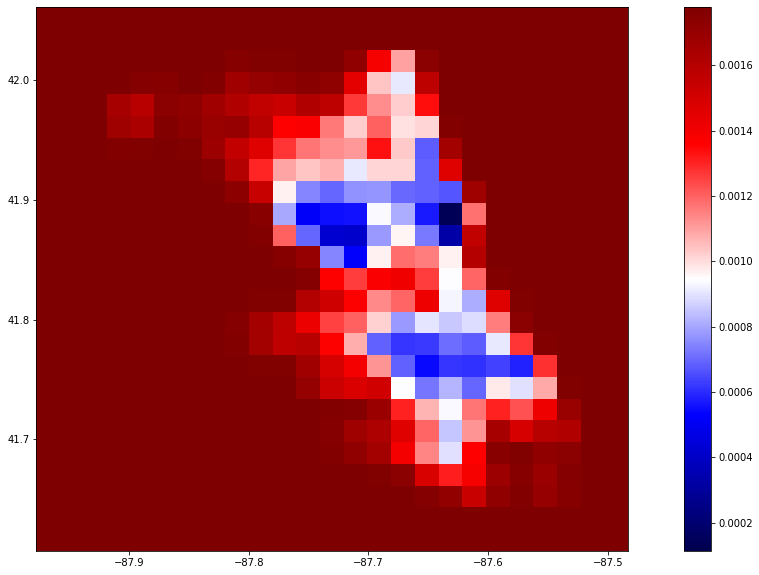

In [59]:
vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(25,25)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

In [60]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention2_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

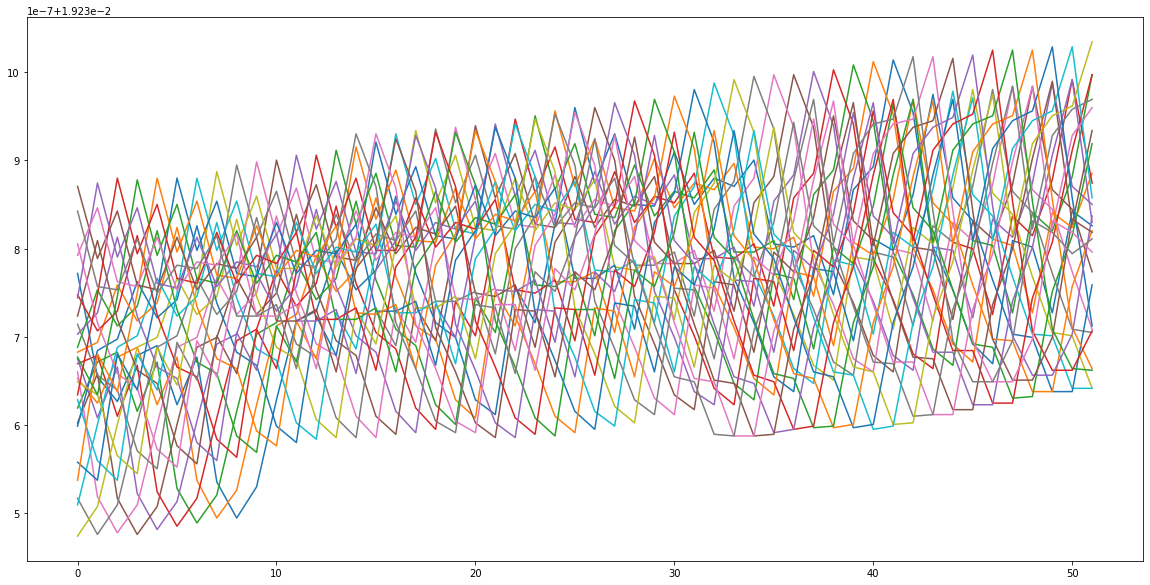

In [61]:
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

## 2 Headed: Attention Pixel + Attention Timestep 

In [62]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh',name="W")(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear',name ="Query")(attention1) ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
#attended_Dense_out1 = TimeDistributed(Dense(3, activation='relu'))(attention1)

timeDist2 = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(100), name="compressor")(timeDist2)
units = timeDist2.shape[2]
# compute importance for each step
attention2 = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units/10) dimension reduction with W
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax',name='attention2_weights')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
attention2 = Multiply()([timeDist2, attention2])
#For each timestep update a single weight on Dense layer

merge = Concatenate()([attention1, attention2])

attended_Dense_out = TimeDistributed(Dense(50, activation='relu'))(merge)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2


model = Model(inputs, outputs, name="TimeDistributed_attention1_plus_attention2_on_time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "TimeDistributed_attention1_plus_attention2_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 52, 25, 25,  0                                            
__________________________________________________________________________________________________
time_distributed_16 (TimeDistri (None, 52, 625)      0           input_7[0][0]                    
__________________________________________________________________________________________________
permute_8 (Permute)             (None, 625, 52)      0           time_distributed_16[0][0]        
__________________________________________________________________________________________________
time_distributed_17 (TimeDistri (None, 52, 625)      0           input_7[0][0]                    
_________________________________________________

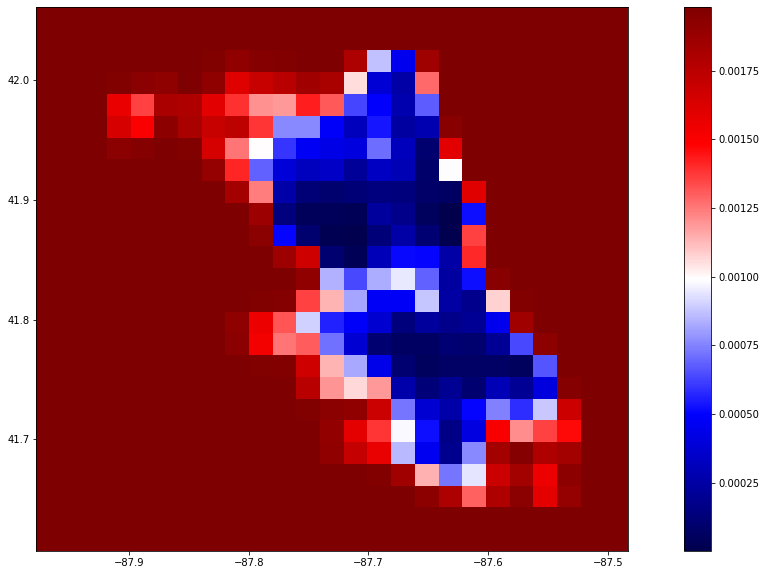

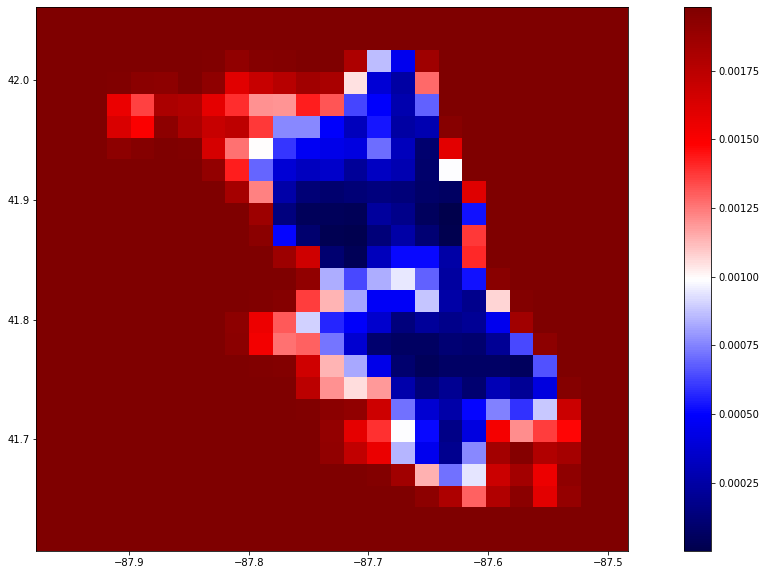

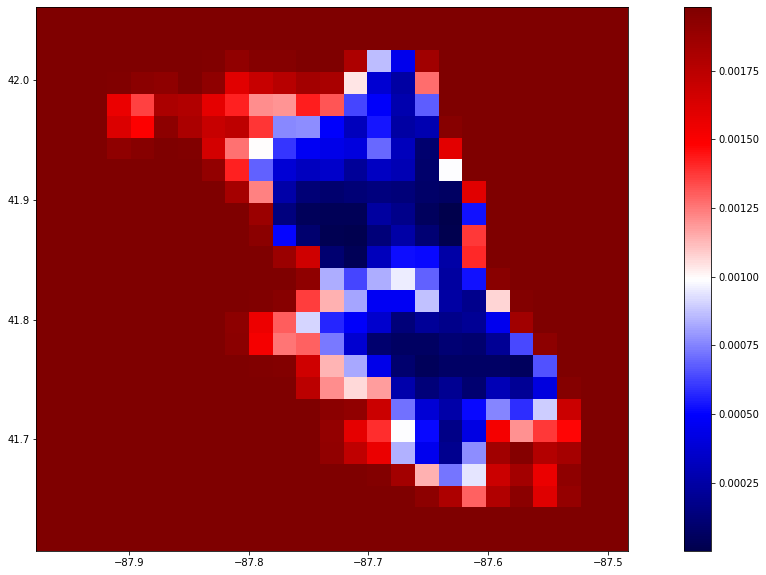

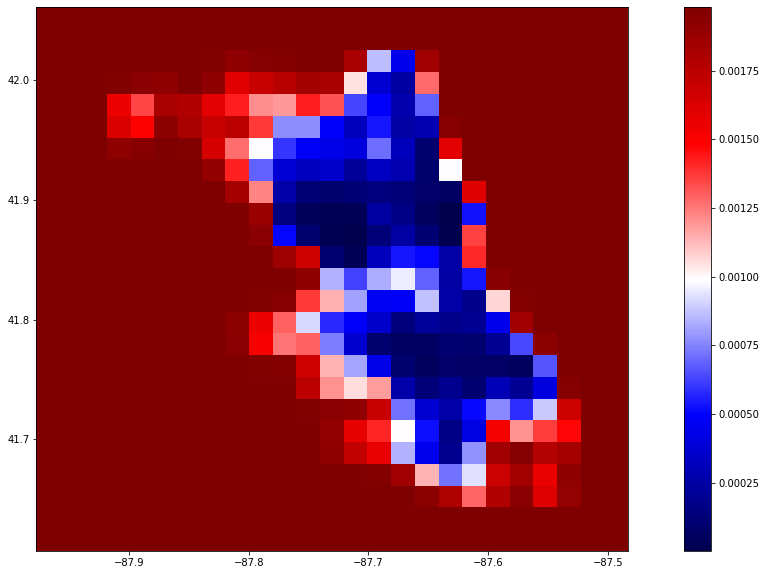

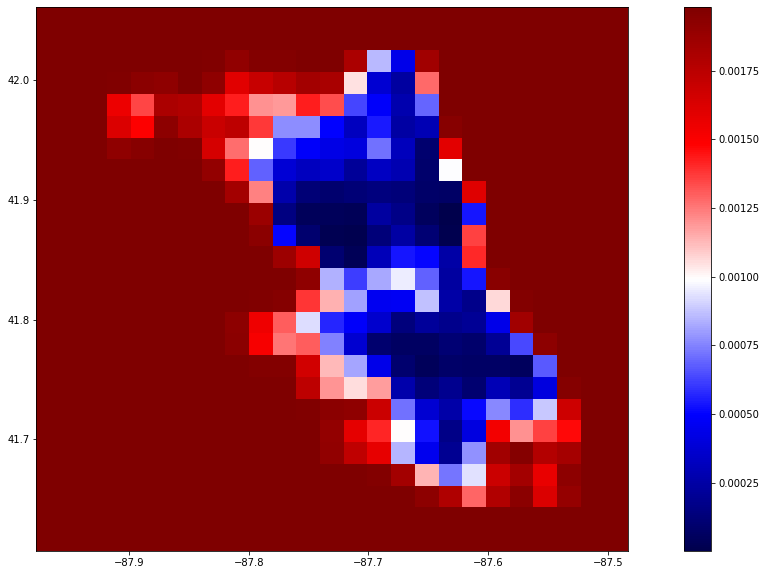

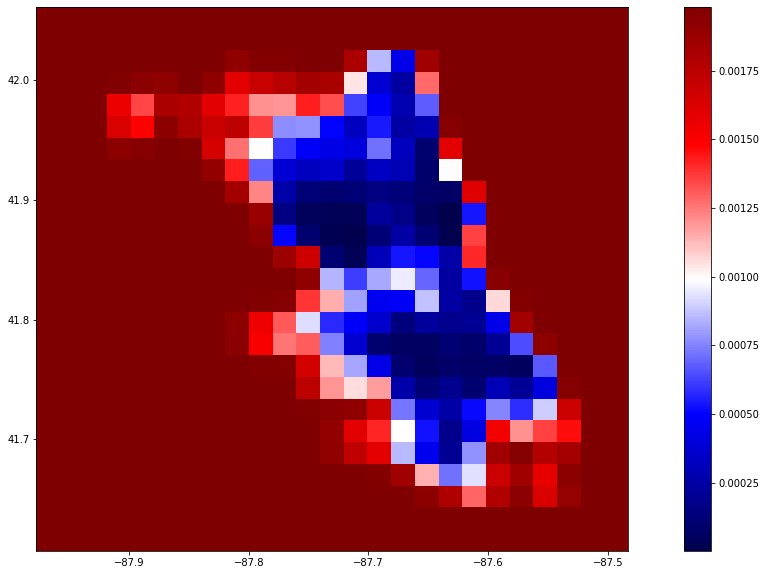

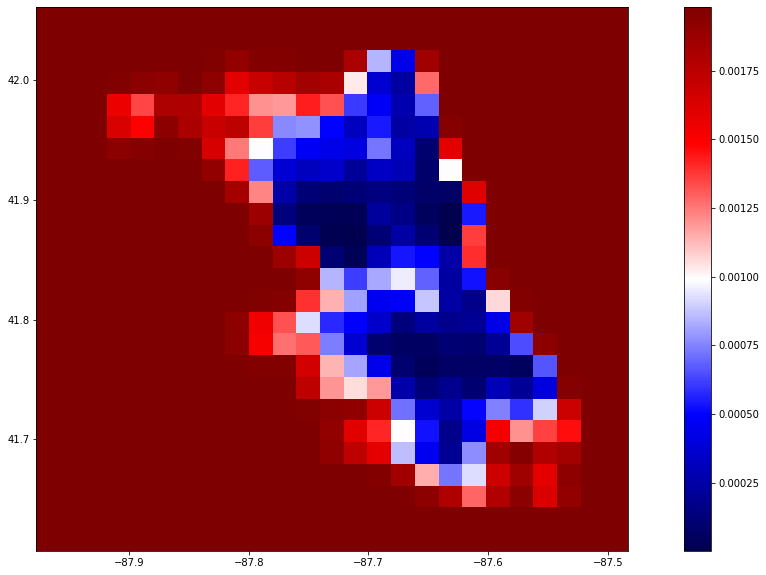

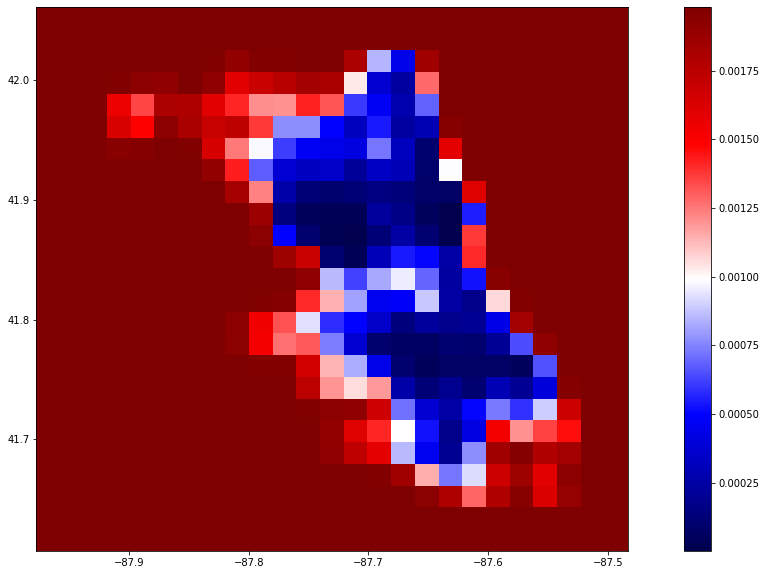

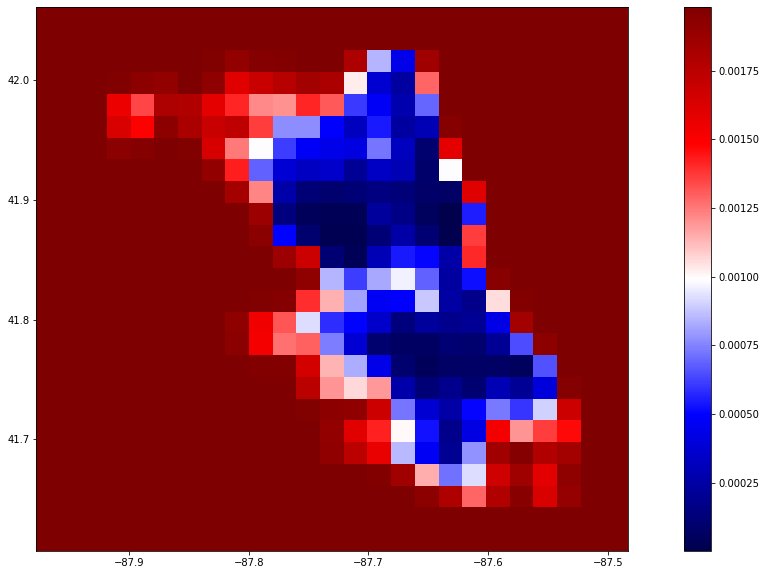

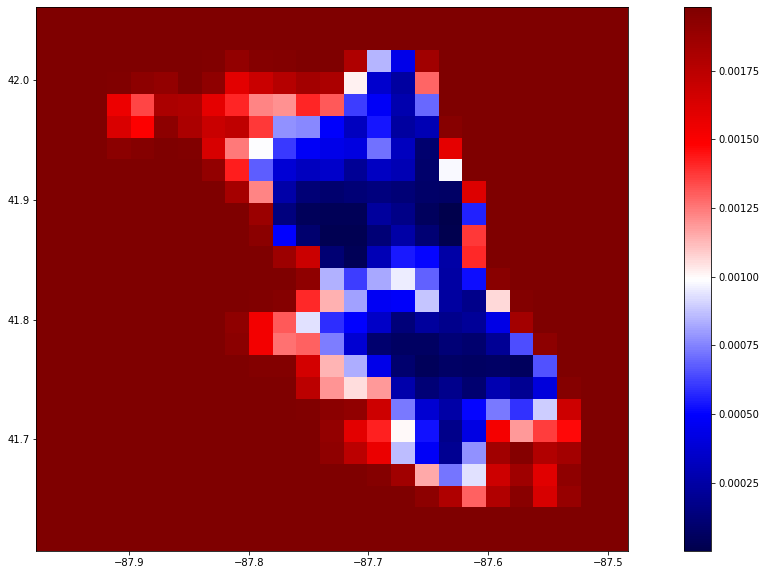

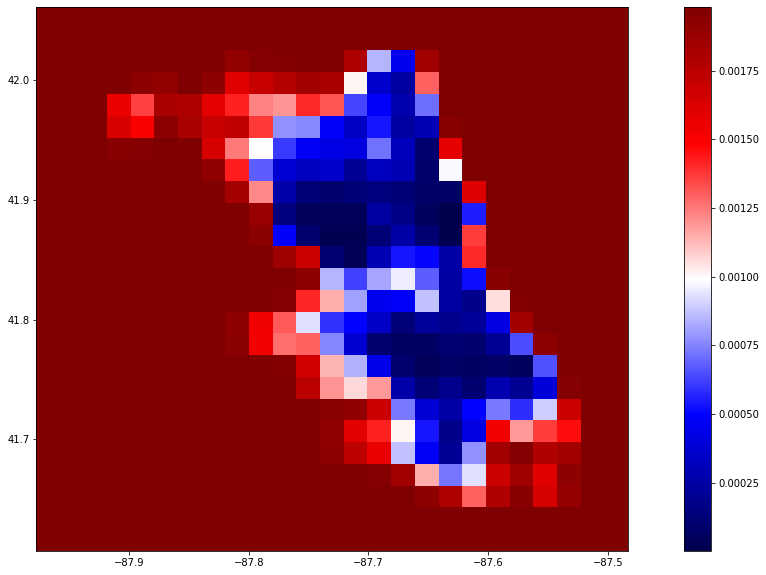

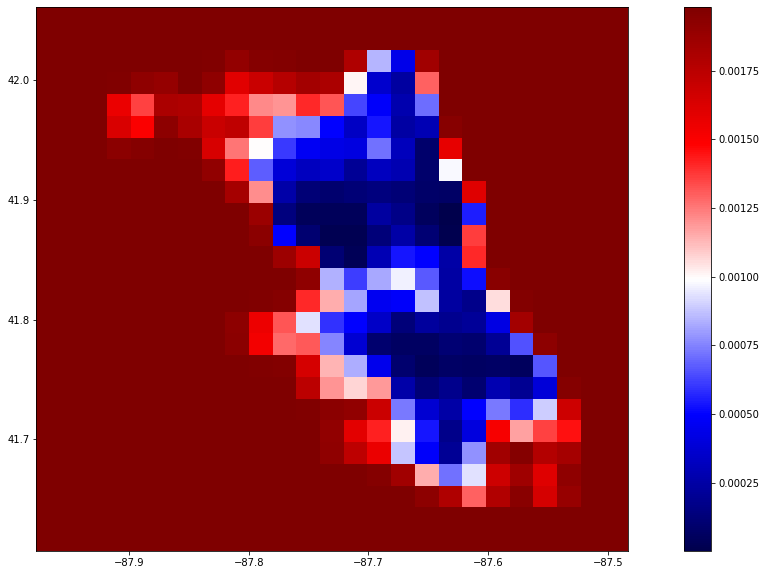

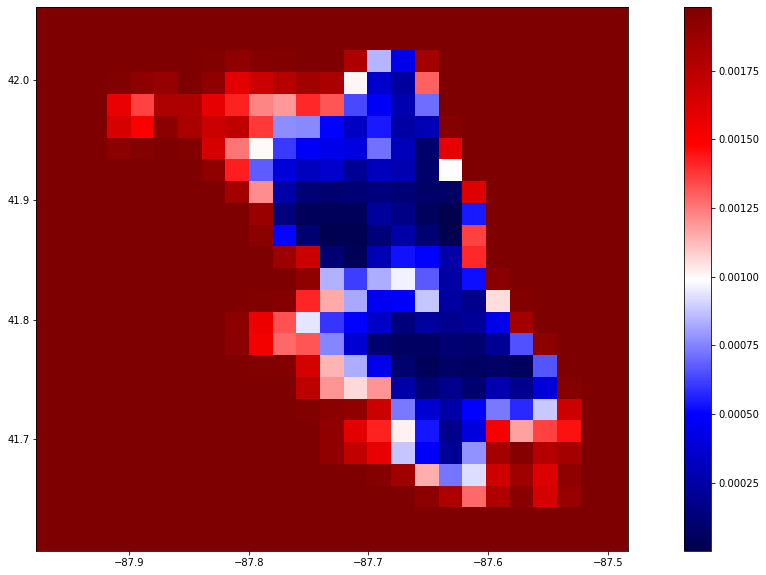

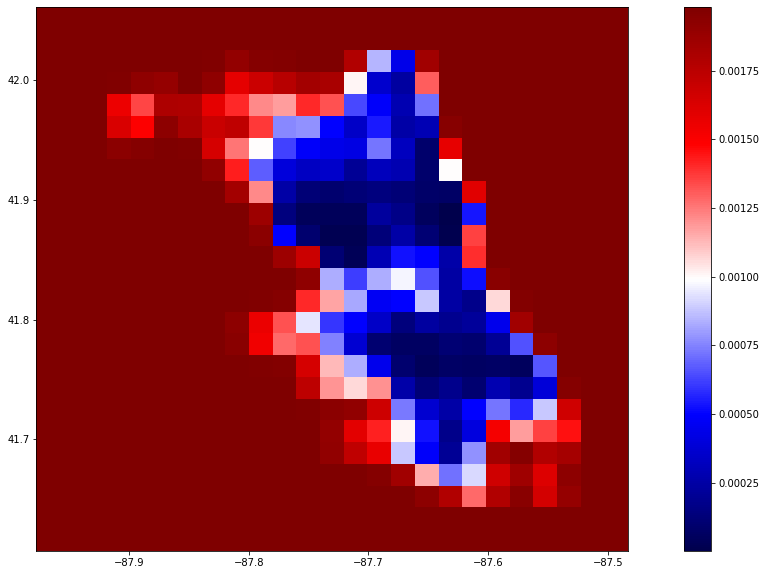

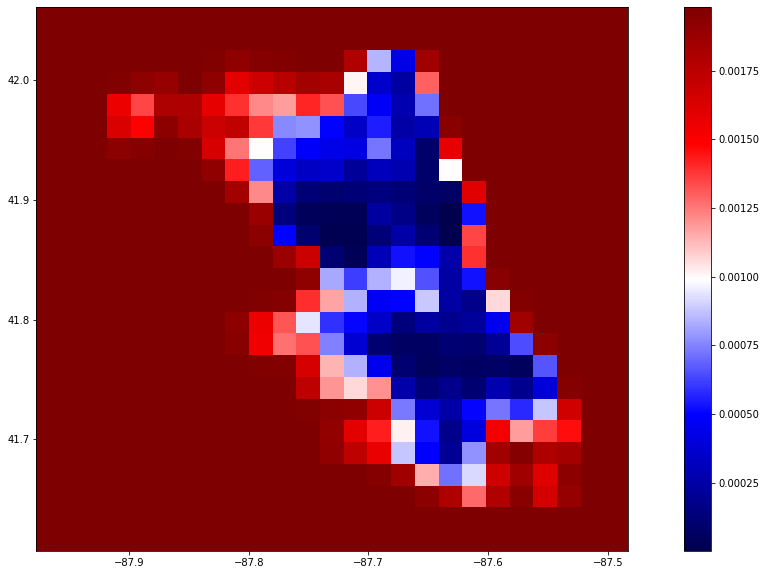

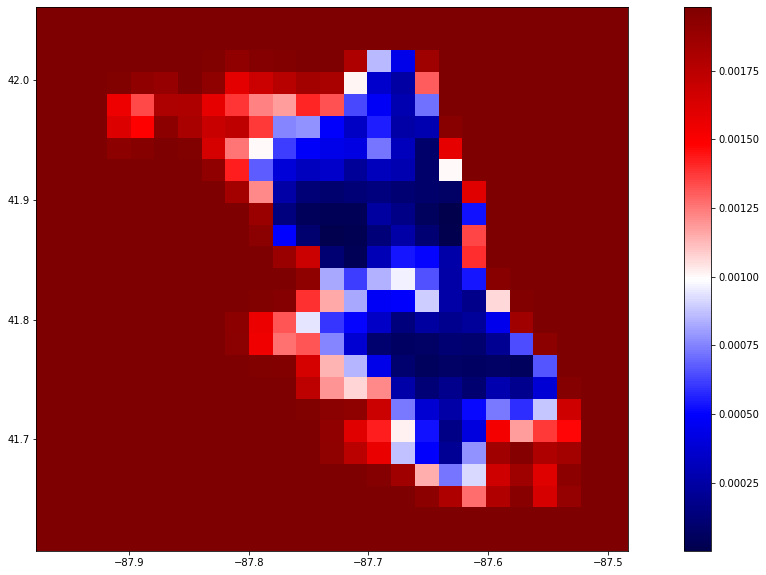

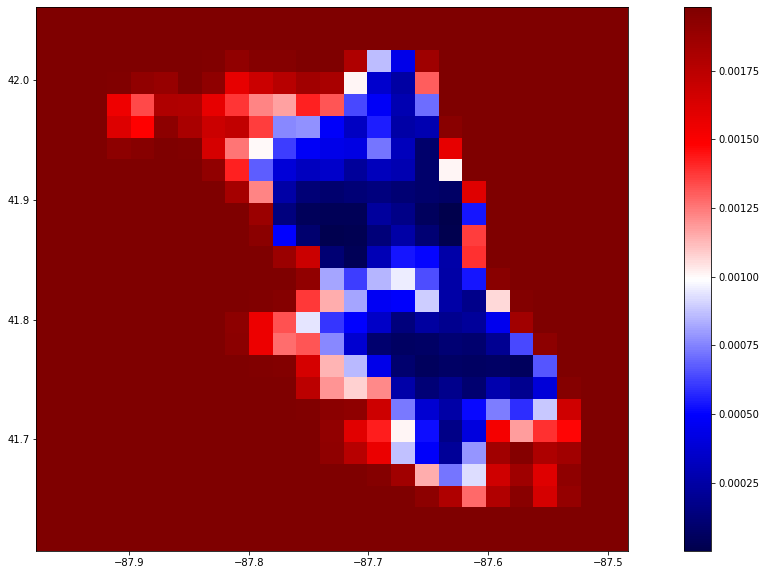

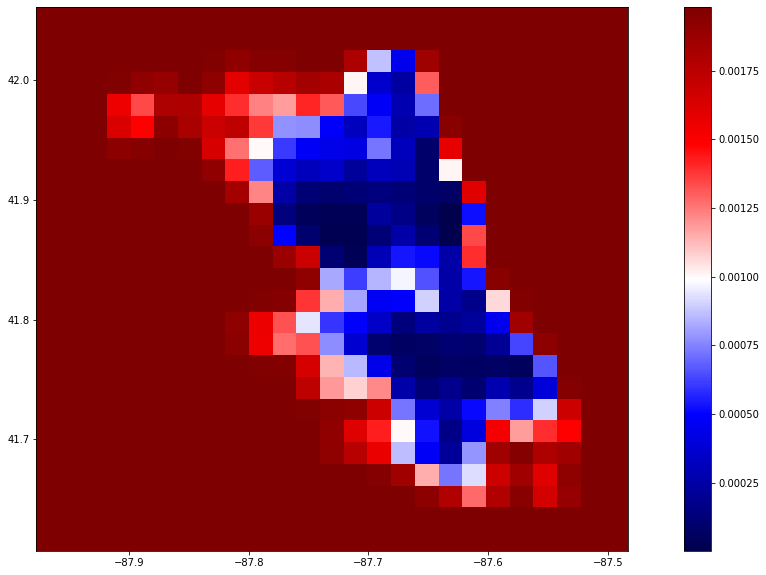

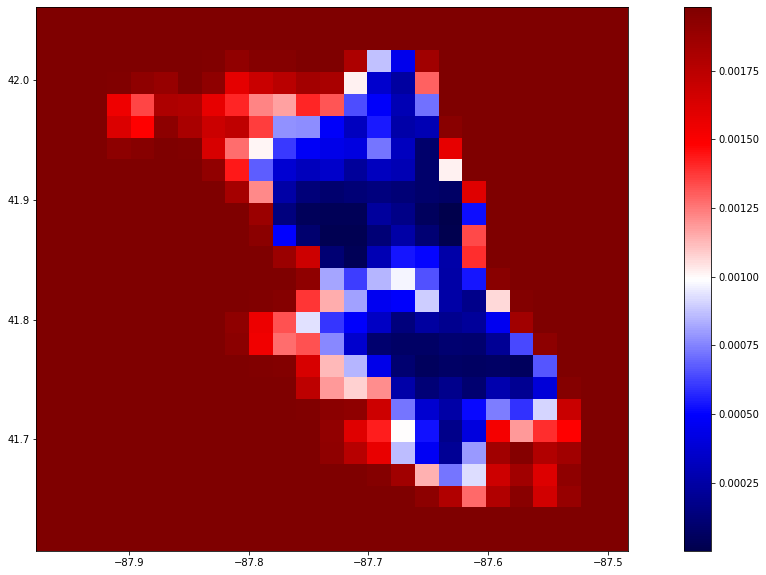

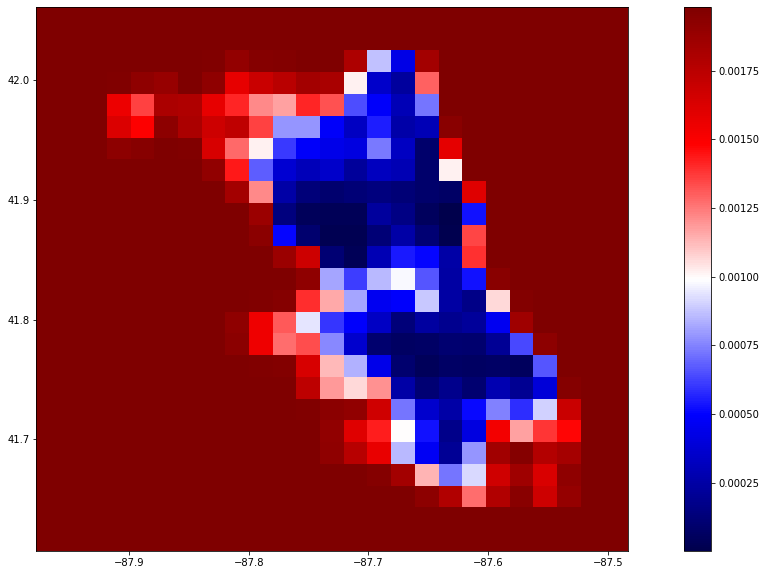

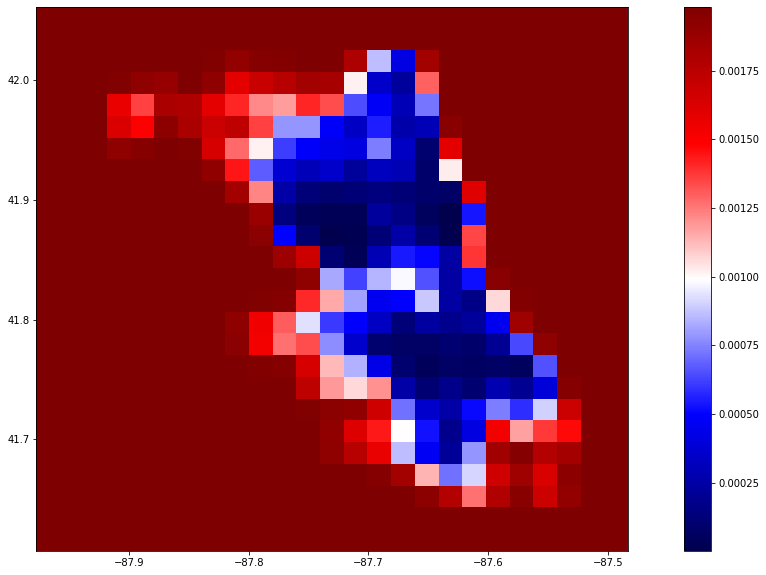

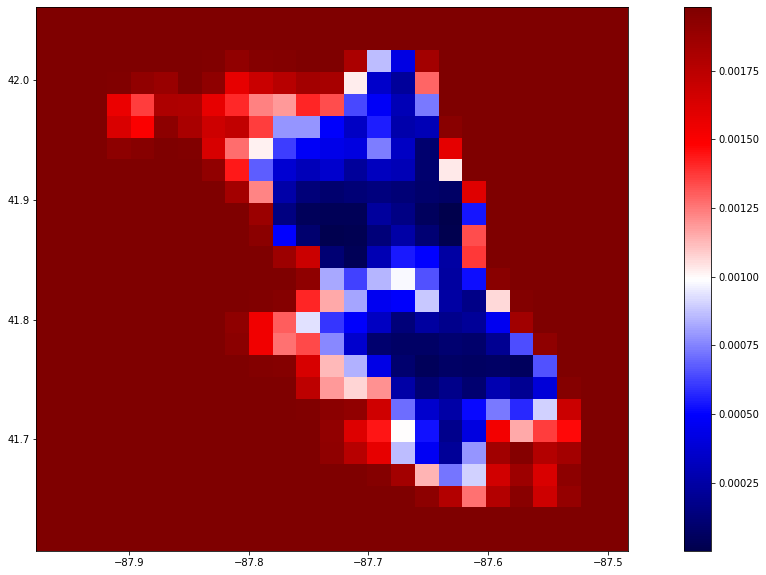

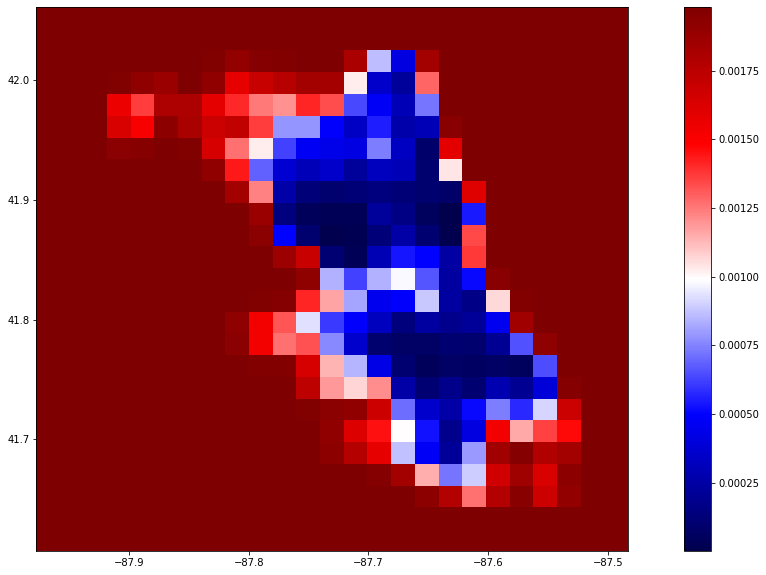

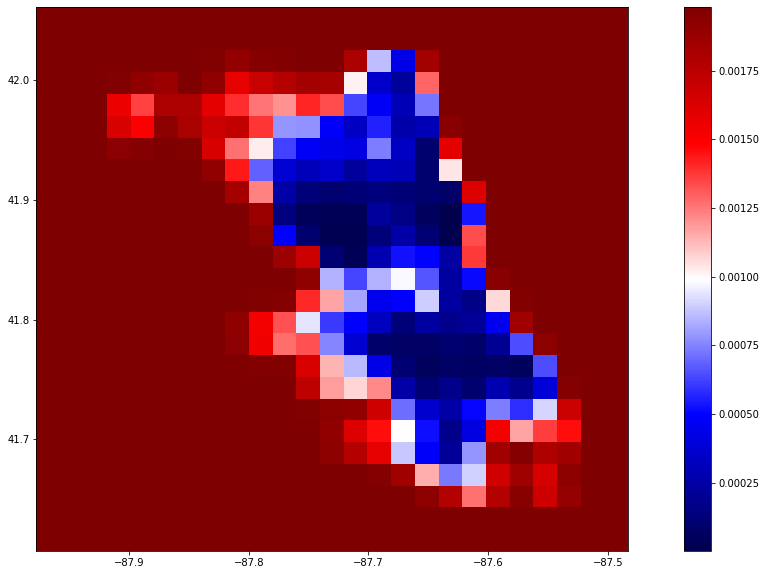

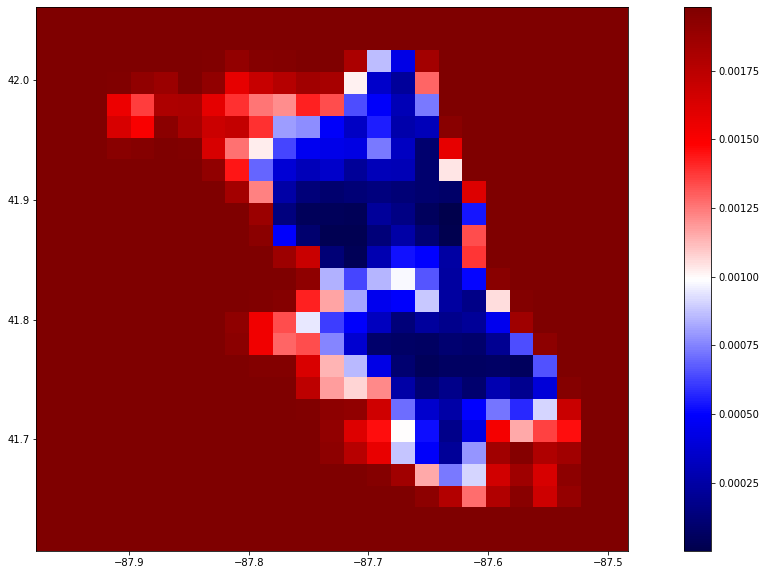

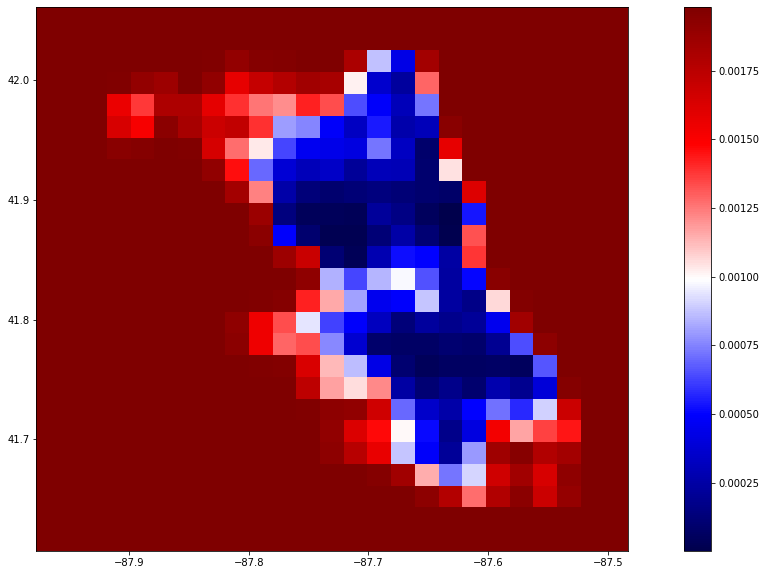

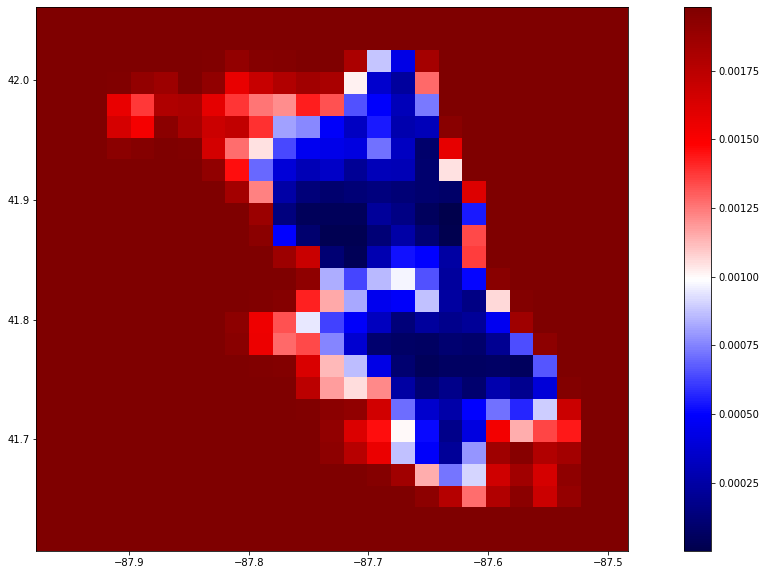

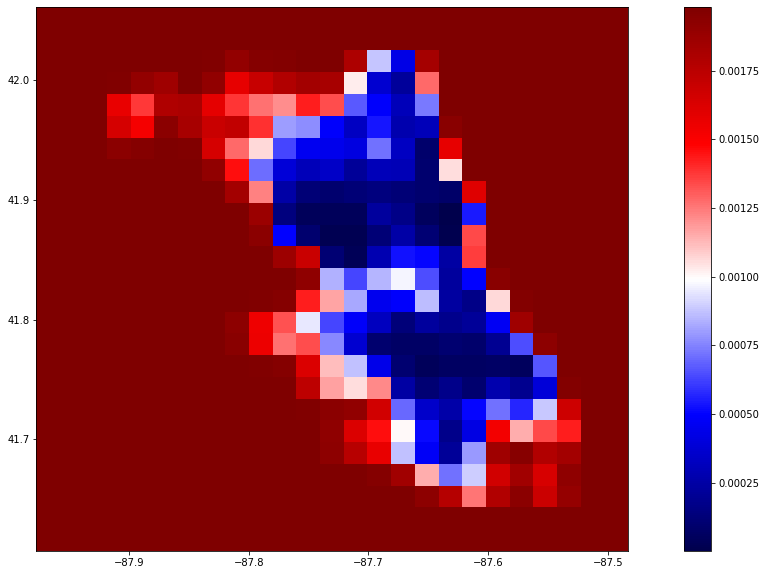

In [64]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(25,25)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

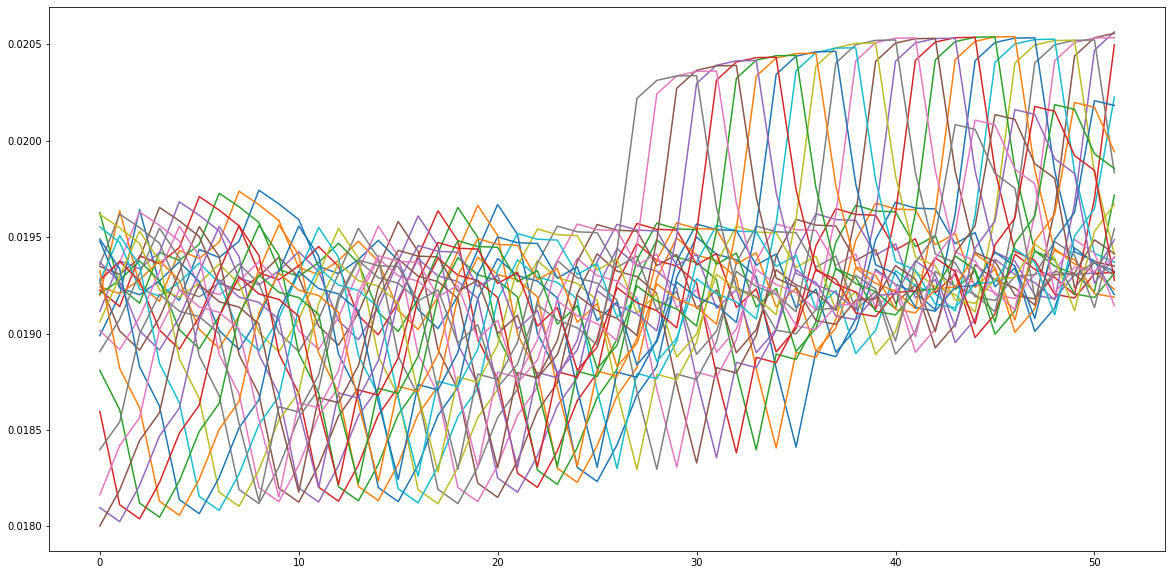

In [65]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention2_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

## FFT + Attention

In [38]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#Frequency Head
timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2, 1])(timeDist) #transpose for FFT. FFT library treats the last dimension as time
fftLayer = Lambda(lambda x : tf.math.abs(tf.signal.rfft(x)))(timeDist) ## transform to frequency domain with TF
fftLayer  = Permute([2, 1], name="fft_out")(fftLayer)#transpose back for the following shape
#(None,num_of_frequencies,num_of_features)
#compress frequency domain data from 10000 to downsized dimension for attention
#Time distributed is now frequency distributed
timeDist4 = TimeDistributed(Dense(100))(fftLayer)
units = timeDist4.shape[2]

# compute importance for each frequency
attention = Dense(units, activation='tanh')(timeDist4) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)
#attention = Dense(1, activation='tanh')(timeDist4)
attention = Flatten()(attention)
attention = Activation('softmax',name='attention_weights')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([timeDist4, attention])
#For each timestep update a single weight on Dense layer
attended_LSTM_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line
D_temp = Dense(units*2, activation='relu')(attended_LSTM_out) # hidden layer

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(D_temp)
outputs = Dense2

model = Model(inputs, outputs, name="Attention_FFT")
model.summary()

adam = optimizers.Adam(lr)
#rmsProp = optimizers.RMSprop(learning_rate=lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


timeDist.shape (None, 625, 52)
fftLayer.shape (None, 27, 625)
Model: "Attention_FFT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 52, 25, 25,  0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 52, 625)      0           input_2[0][0]                    
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 625, 52)      0           time_distributed_3[0][0]         
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 625, 27)      0           permute_2[0][0]                  
________________________

In [42]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

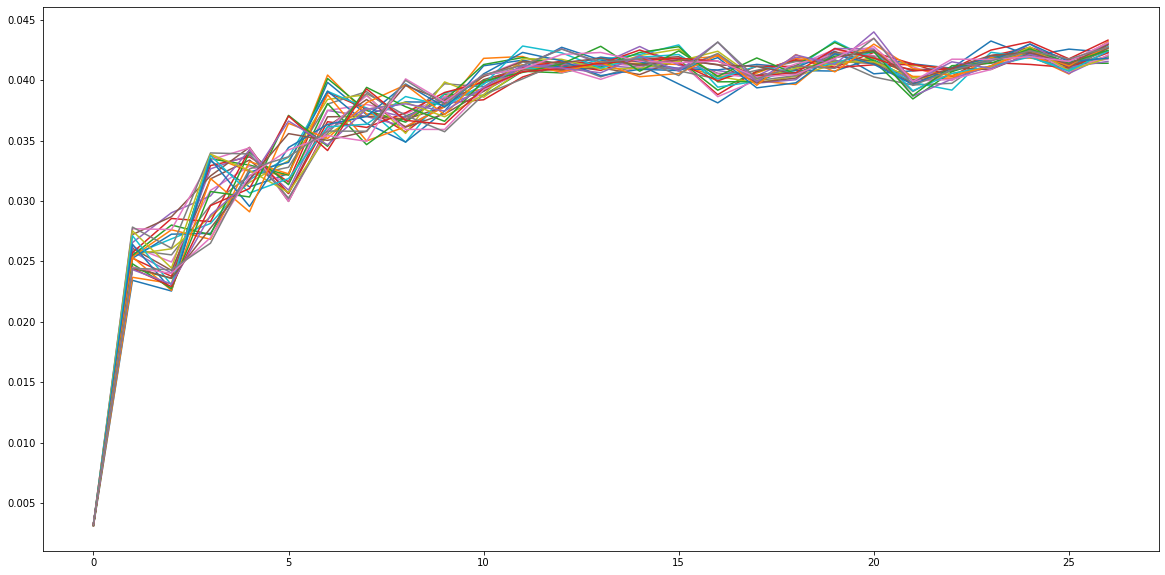

In [43]:
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_train[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

## Run fit on any of the previous model here

In [39]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)


model.summary()

model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=500, 
                             batch_size=1, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ])

valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Model: "Attention_FFT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 52, 25, 25,  0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 52, 625)      0           input_2[0][0]                    
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 625, 52)      0           time_distributed_3[0][0]         
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 625, 27)      0           permute_2[0][0]                  
______________________________________________________________________________________

Epoch 12/500
82/88 [==========================>...] - ETA: 0s - loss: 0.0031 - mae: 0.0031
Epoch 00012: val_loss did not improve from 0.00361
88/88 [==============================] - 0s 4ms/sample - loss: 0.0031 - mae: 0.0031 - val_loss: 0.0037 - val_mae: 0.0037
Epoch 13/500
83/88 [===========================>..] - ETA: 0s - loss: 0.0031 - mae: 0.0031
Epoch 00013: val_loss did not improve from 0.00361
88/88 [==============================] - 0s 4ms/sample - loss: 0.0031 - mae: 0.0031 - val_loss: 0.0039 - val_mae: 0.0039
Epoch 14/500
84/88 [===========================>..] - ETA: 0s - loss: 0.0031 - mae: 0.0031
Epoch 00014: val_loss did not improve from 0.00361
88/88 [==============================] - 0s 4ms/sample - loss: 0.0031 - mae: 0.0031 - val_loss: 0.0038 - val_mae: 0.0038
Epoch 15/500
82/88 [==========================>...] - ETA: 0s - loss: 0.0030 - mae: 0.0030
Epoch 00015: val_loss did not improve from 0.00361
88/88 [==============================] - 0s 4ms/sample - loss: 0.0030

Epoch 40/500
83/88 [===========================>..] - ETA: 0s - loss: 0.0027 - mae: 0.0027
Epoch 00040: val_loss did not improve from 0.00318
88/88 [==============================] - 0s 4ms/sample - loss: 0.0027 - mae: 0.0027 - val_loss: 0.0033 - val_mae: 0.0033
Epoch 41/500
76/88 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0027
Epoch 00041: val_loss did not improve from 0.00318
88/88 [==============================] - 0s 4ms/sample - loss: 0.0027 - mae: 0.0027 - val_loss: 0.0033 - val_mae: 0.0033
Epoch 42/500
82/88 [==========================>...] - ETA: 0s - loss: 0.0028 - mae: 0.0028
Epoch 00042: val_loss did not improve from 0.00318
88/88 [==============================] - 0s 4ms/sample - loss: 0.0028 - mae: 0.0028 - val_loss: 0.0033 - val_mae: 0.0033
Epoch 43/500
84/88 [===========================>..] - ETA: 0s - loss: 0.0027 - mae: 0.0027
Epoch 00043: val_loss did not improve from 0.00318
88/88 [==============================] - 0s 4ms/sample - loss: 0.0027

Epoch 70/500
85/88 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0026
Epoch 00070: val_loss did not improve from 0.00312
88/88 [==============================] - 0s 4ms/sample - loss: 0.0026 - mae: 0.0026 - val_loss: 0.0032 - val_mae: 0.0032
Epoch 71/500
82/88 [==========================>...] - ETA: 0s - loss: 0.0026 - mae: 0.0026
Epoch 00071: val_loss did not improve from 0.00312
88/88 [==============================] - 0s 4ms/sample - loss: 0.0026 - mae: 0.0026 - val_loss: 0.0032 - val_mae: 0.0032
Epoch 72/500
79/88 [=========================>....] - ETA: 0s - loss: 0.0026 - mae: 0.0026
Epoch 00072: val_loss did not improve from 0.00312
88/88 [==============================] - 0s 4ms/sample - loss: 0.0026 - mae: 0.0026 - val_loss: 0.0032 - val_mae: 0.0032
Epoch 73/500
83/88 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0026
Epoch 00073: val_loss did not improve from 0.00312
88/88 [==============================] - 0s 4ms/sample - loss: 0.0026

Epoch 100/500
81/88 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0024
Epoch 00100: val_loss did not improve from 0.00310
88/88 [==============================] - 0s 4ms/sample - loss: 0.0025 - mae: 0.0025 - val_loss: 0.0032 - val_mae: 0.0032
Epoch 101/500
83/88 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0025
Epoch 00101: val_loss did not improve from 0.00310
88/88 [==============================] - 0s 4ms/sample - loss: 0.0025 - mae: 0.0025 - val_loss: 0.0032 - val_mae: 0.0032
Epoch 102/500
85/88 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0025
Epoch 00102: val_loss improved from 0.00310 to 0.00309, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200714-204929_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0025 - mae: 0.0025 - val_loss: 0.0031 - val_mae: 0.0031
Epoch 103/500
85/88 [=============

Epoch 130/500
85/88 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0024
Epoch 00130: val_loss did not improve from 0.00307
88/88 [==============================] - 0s 4ms/sample - loss: 0.0024 - mae: 0.0024 - val_loss: 0.0032 - val_mae: 0.0032
Epoch 131/500
82/88 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0024
Epoch 00131: val_loss did not improve from 0.00307
88/88 [==============================] - 0s 4ms/sample - loss: 0.0024 - mae: 0.0024 - val_loss: 0.0032 - val_mae: 0.0032
Epoch 132/500
83/88 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0024
Epoch 00132: val_loss did not improve from 0.00307
88/88 [==============================] - 0s 4ms/sample - loss: 0.0024 - mae: 0.0024 - val_loss: 0.0032 - val_mae: 0.0032
Epoch 133/500
82/88 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0024
Epoch 00133: val_loss did not improve from 0.00307
88/88 [==============================] - 0s 4ms/sample - loss: 0.

## Validation set result 25x25 pixels

#### fully connected: valid_accuracy_MAE=0.0034105887, valid_loss=0.0034105887170881033

#### 3 layer 1000 unit LSTM model: valid_accuracy_MAE=0.0026478474, valid_loss=0.0026478474028408527

#### CNN LSTM model: valid_accuracy_MAE=0.0025255955, valid_loss=0.0025255954824388027

#### LSTM + Attention: valid_accuracy_MAE=0.0028242564, valid_loss=0.002824256429448724

#### TimeDistributed Attention: valid_accuracy_MAE=0.0024231093, valid_loss=0.0024231092538684607

#### FFT Attention: valid_accuracy_MAE=0.0030660292, valid_loss=0.003066029166802764

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [56]:
Predict = model.predict(X_valid)

In [57]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

In [58]:
vmax, vmin = np.max(Predict),np.min(Predict)
vmax, vmin

(0.90123886, -0.0057265237)

In [59]:
dvmax, dvmin = np.max(np.abs(Predict-Y_valid)),np.min(np.abs(Predict-Y_valid))
dvmax, dvmin

(0.20142937565946034, 6.002654461177196e-11)

In [60]:
diff_max,diff_min = (dvmax , dvmin ) 
def scaleDiff(diff,diff_max,diff_min):
    return (diff - diff_min)/(diff_max - diff_min)

In [57]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib as mpl

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-p

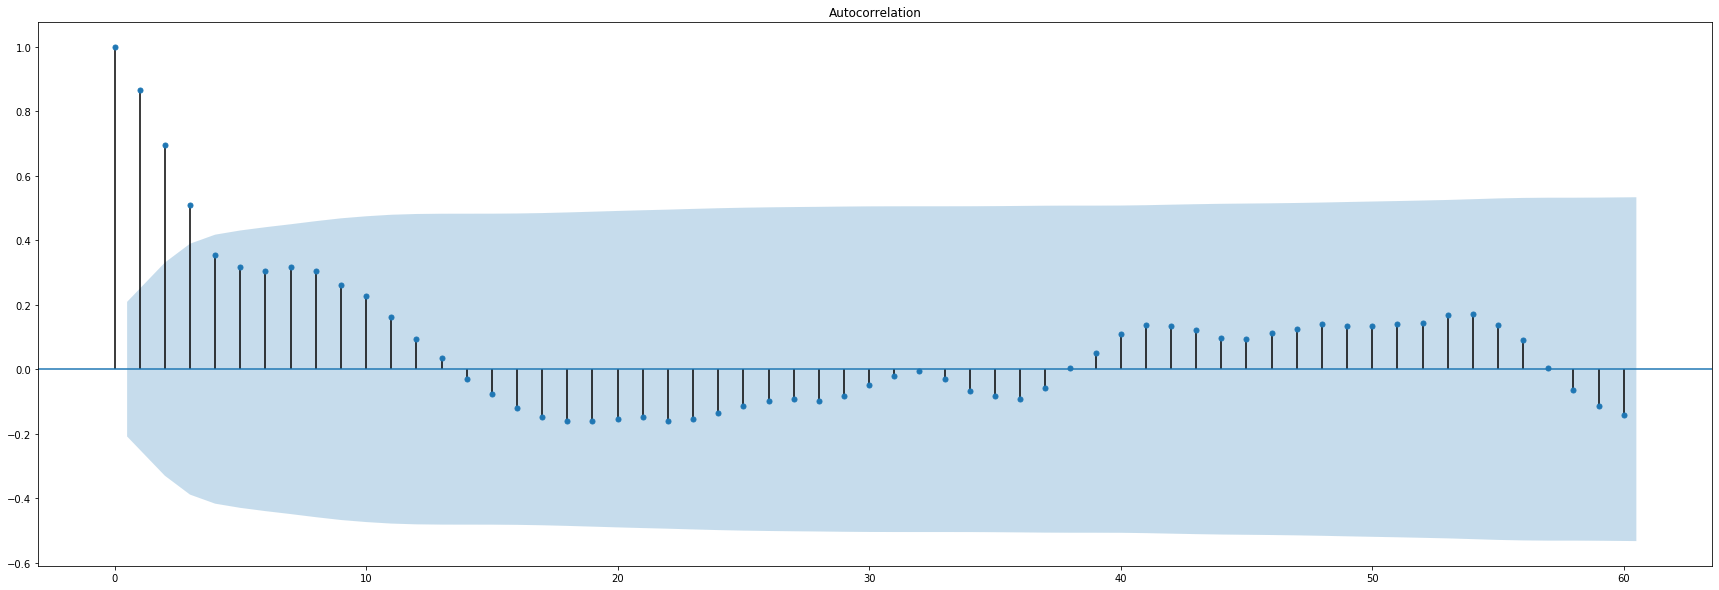

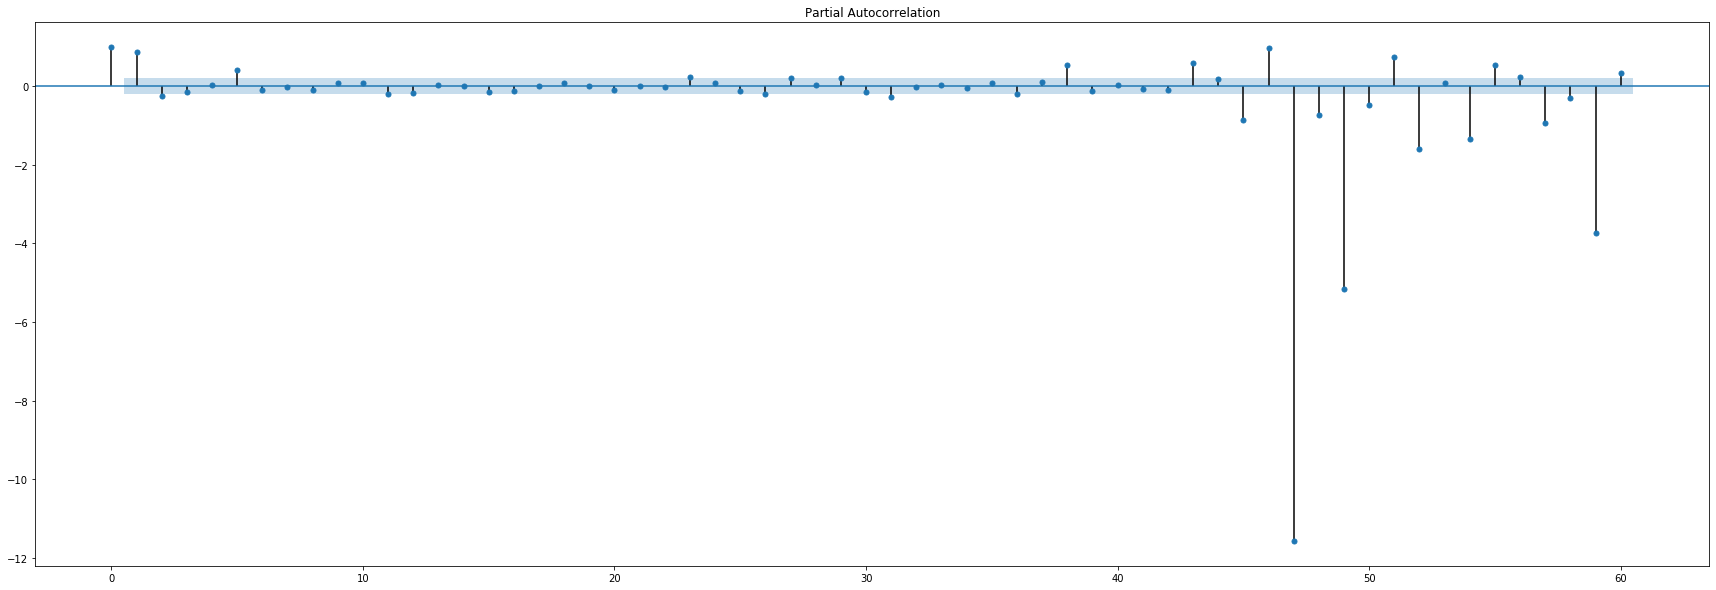

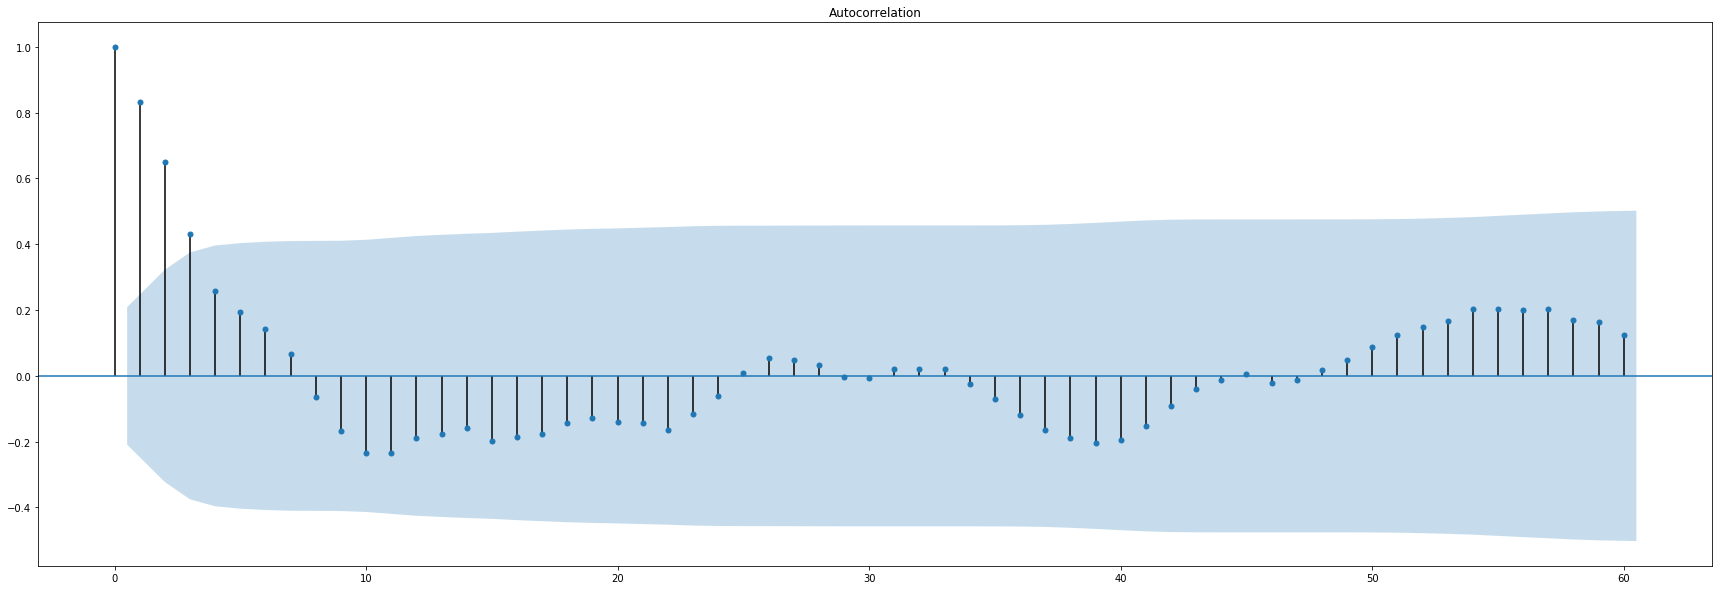

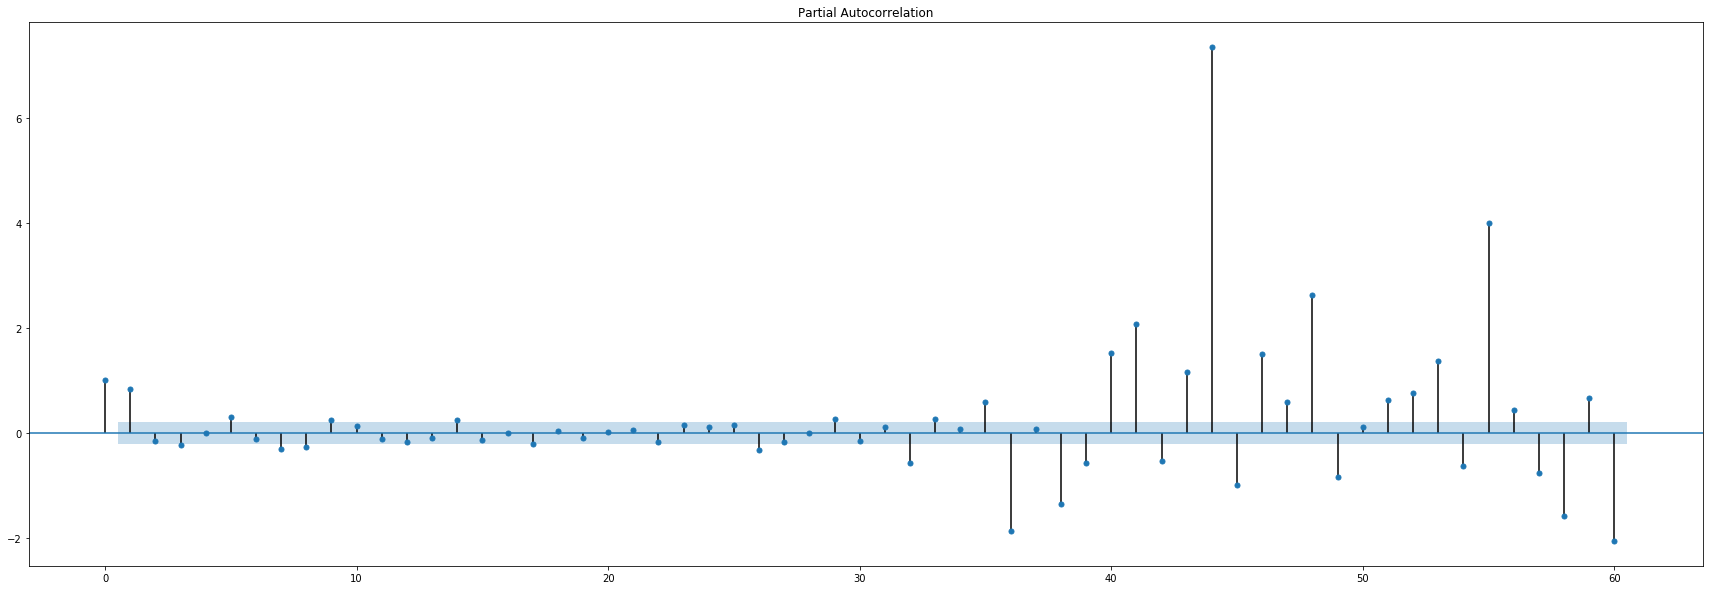

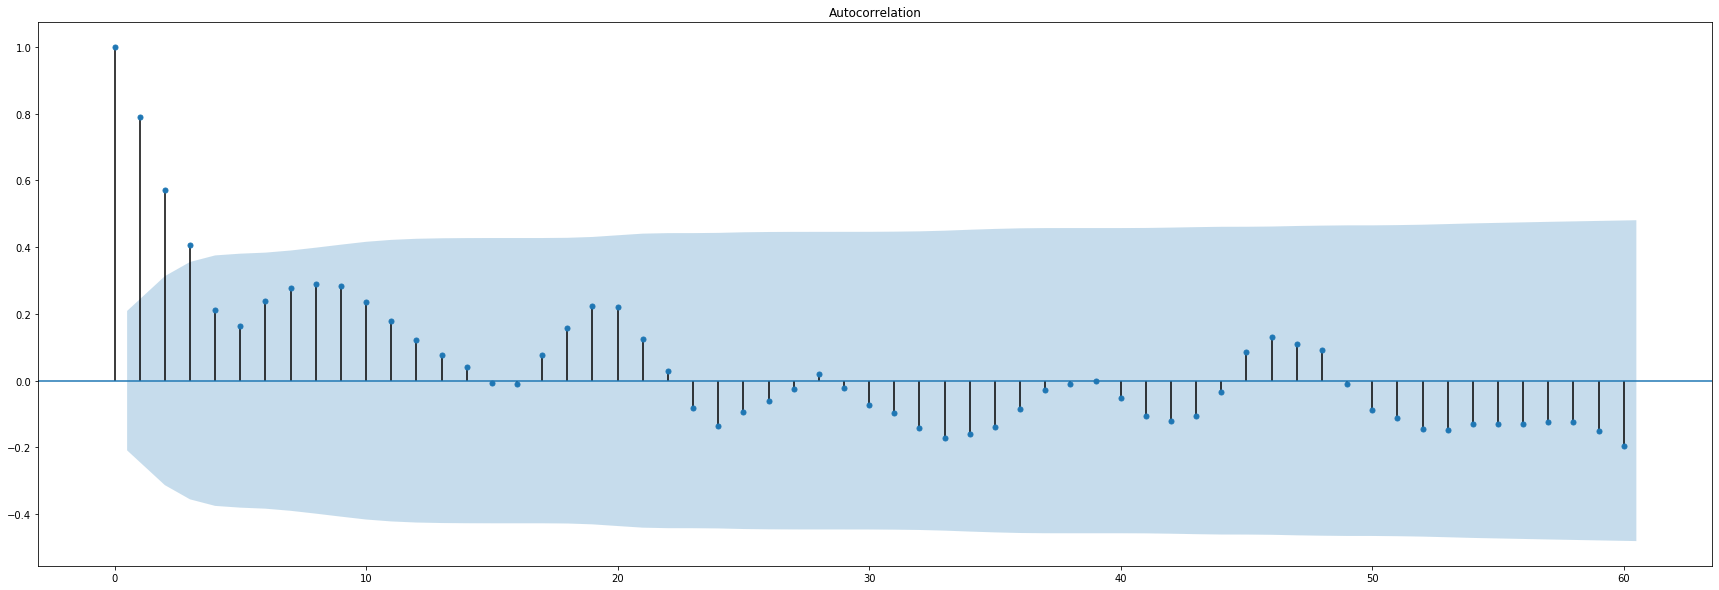

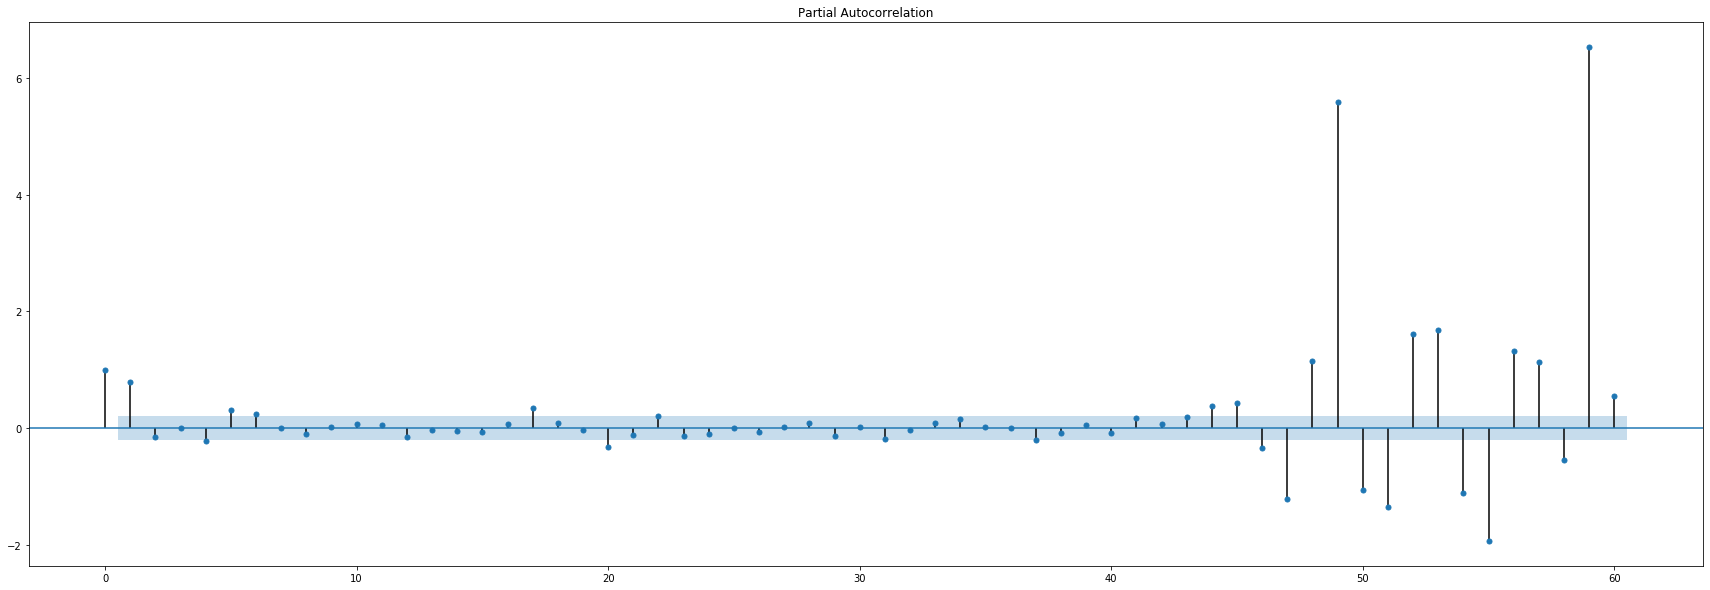

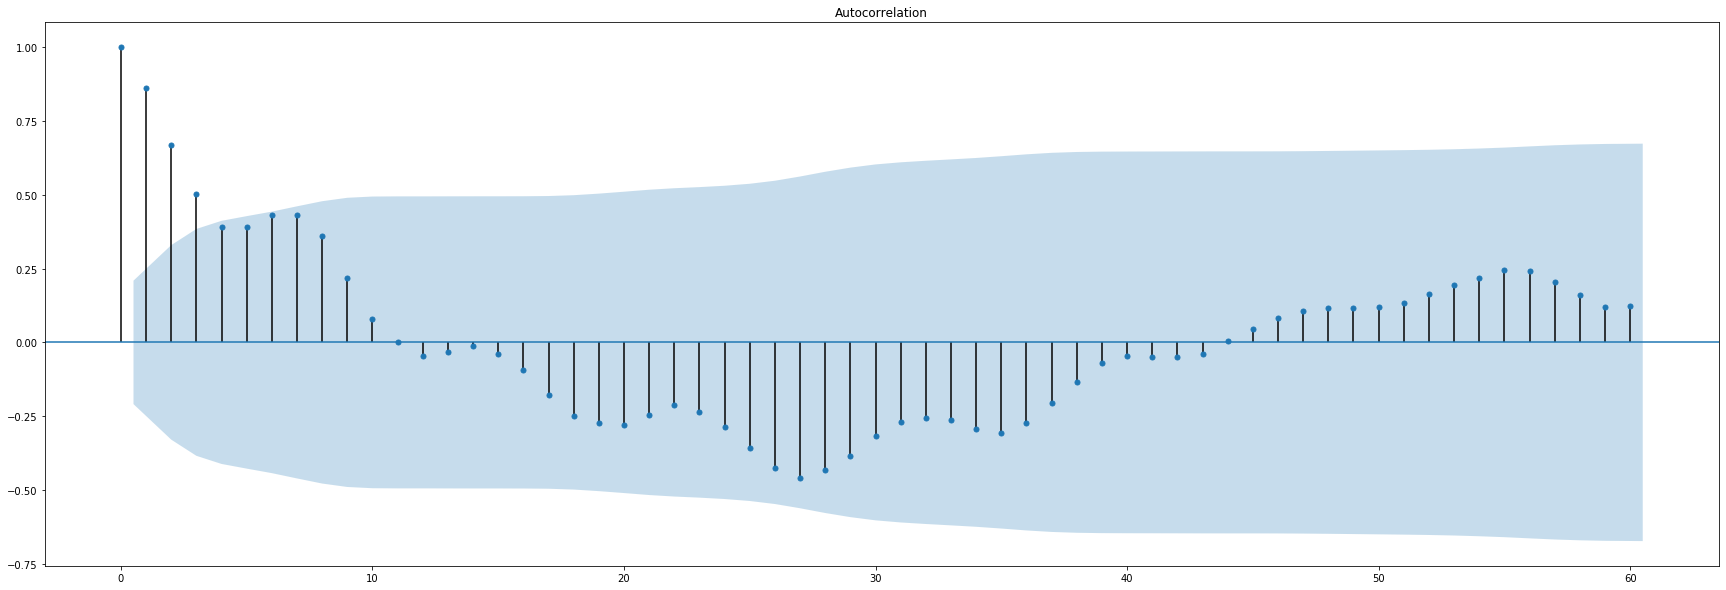

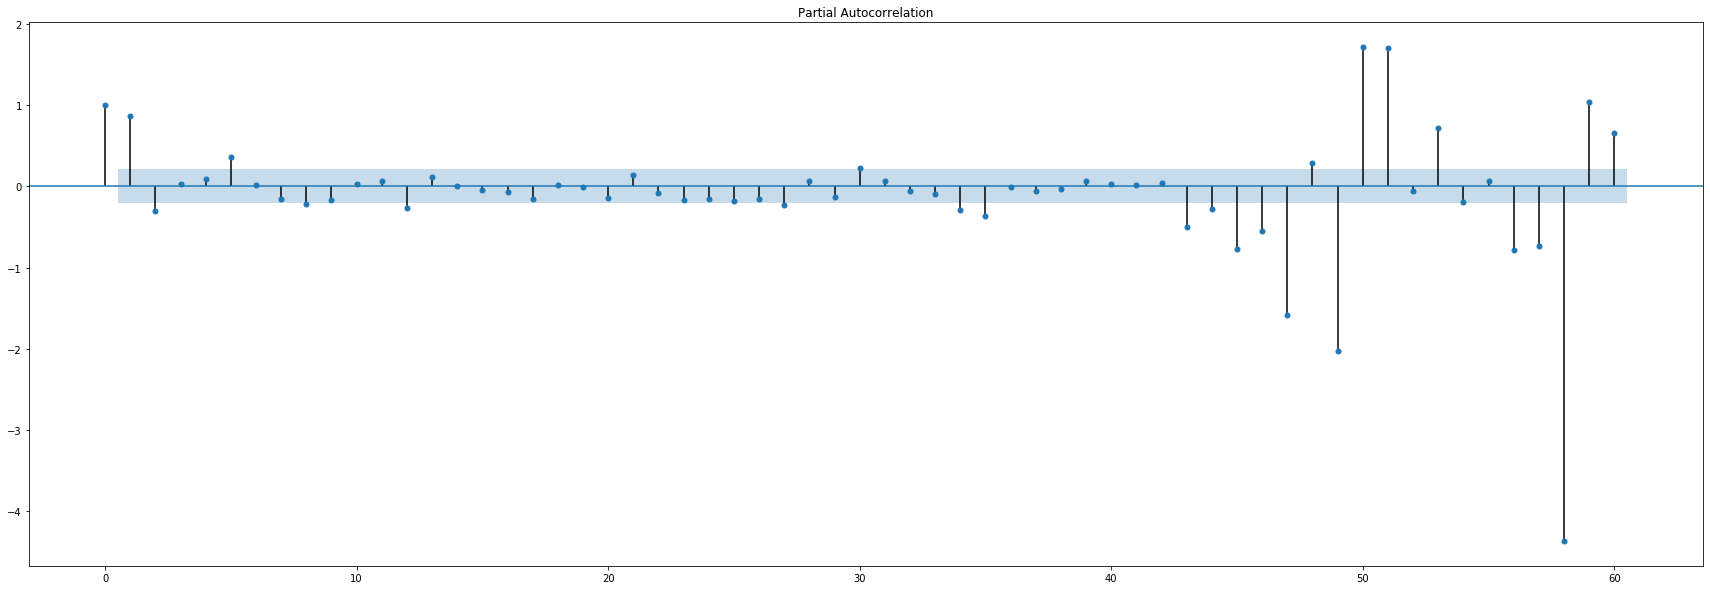

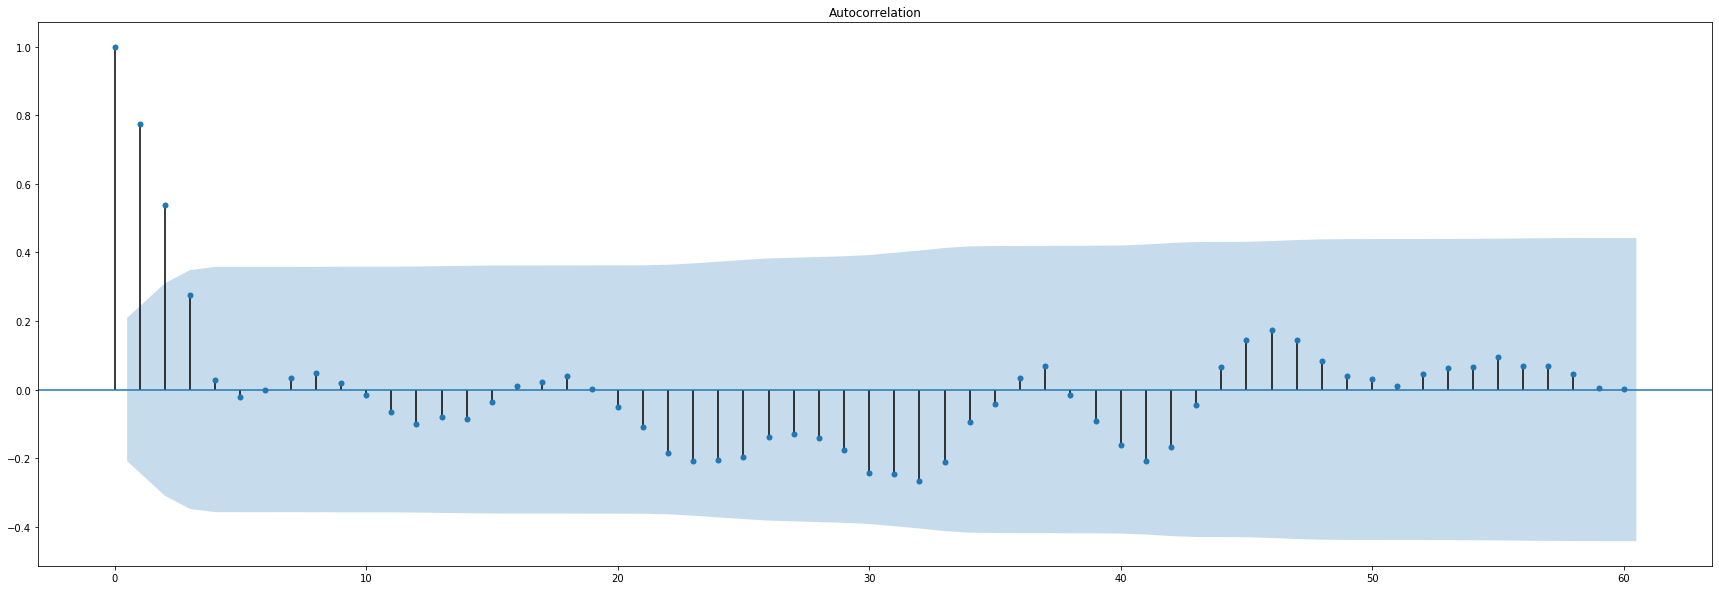

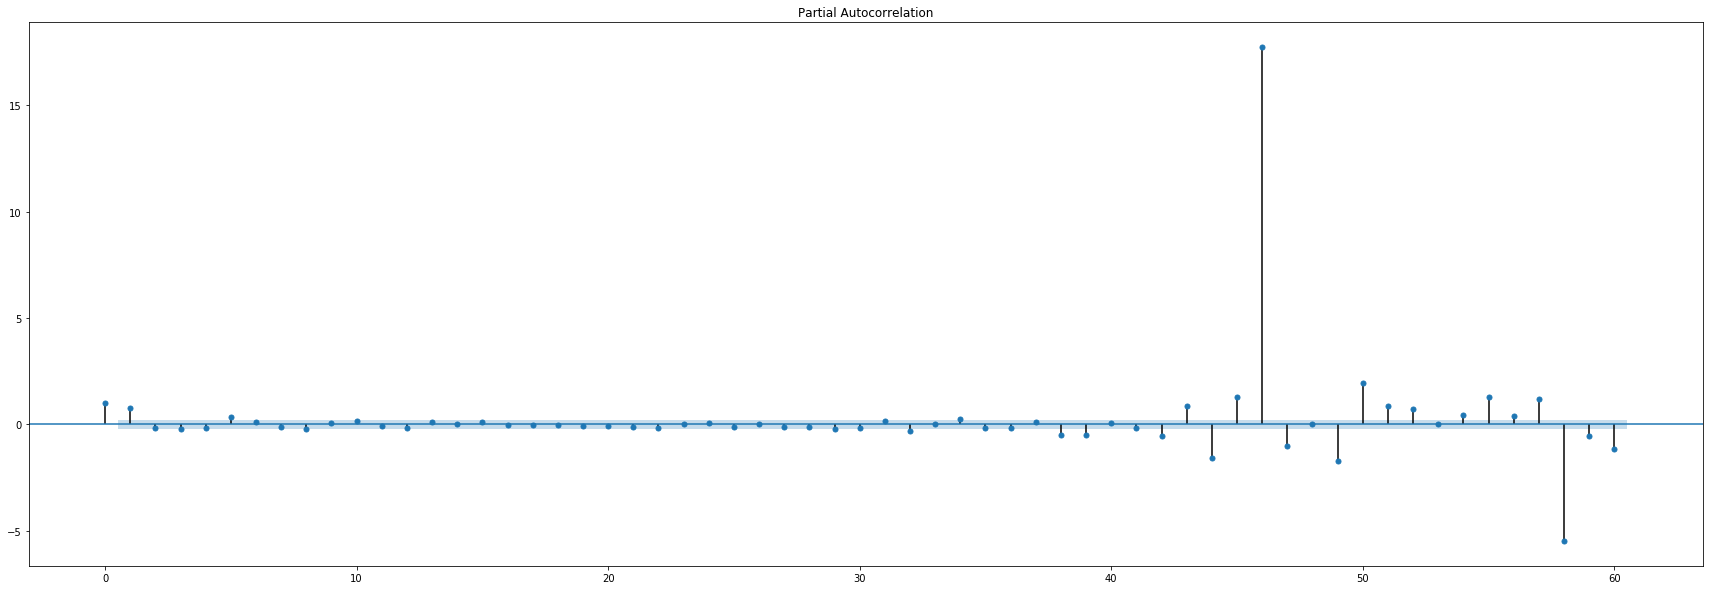

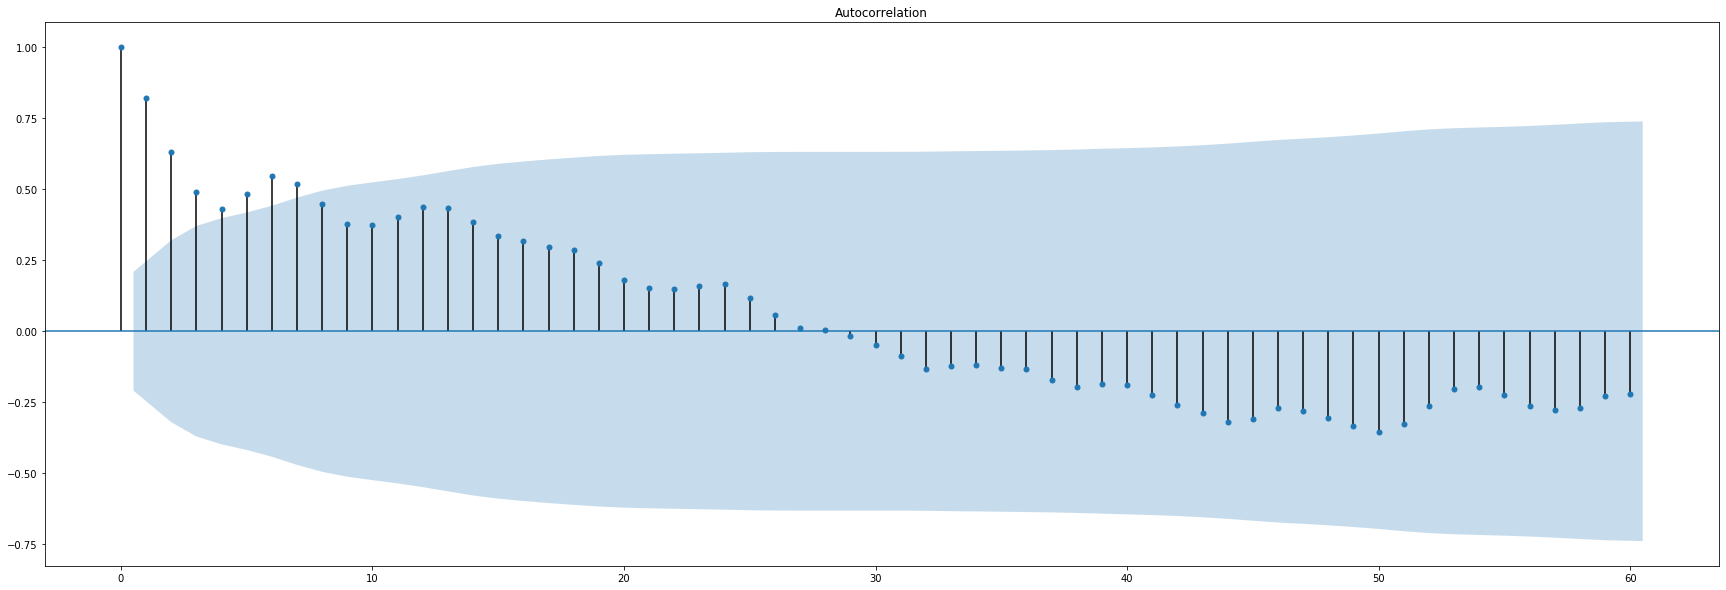

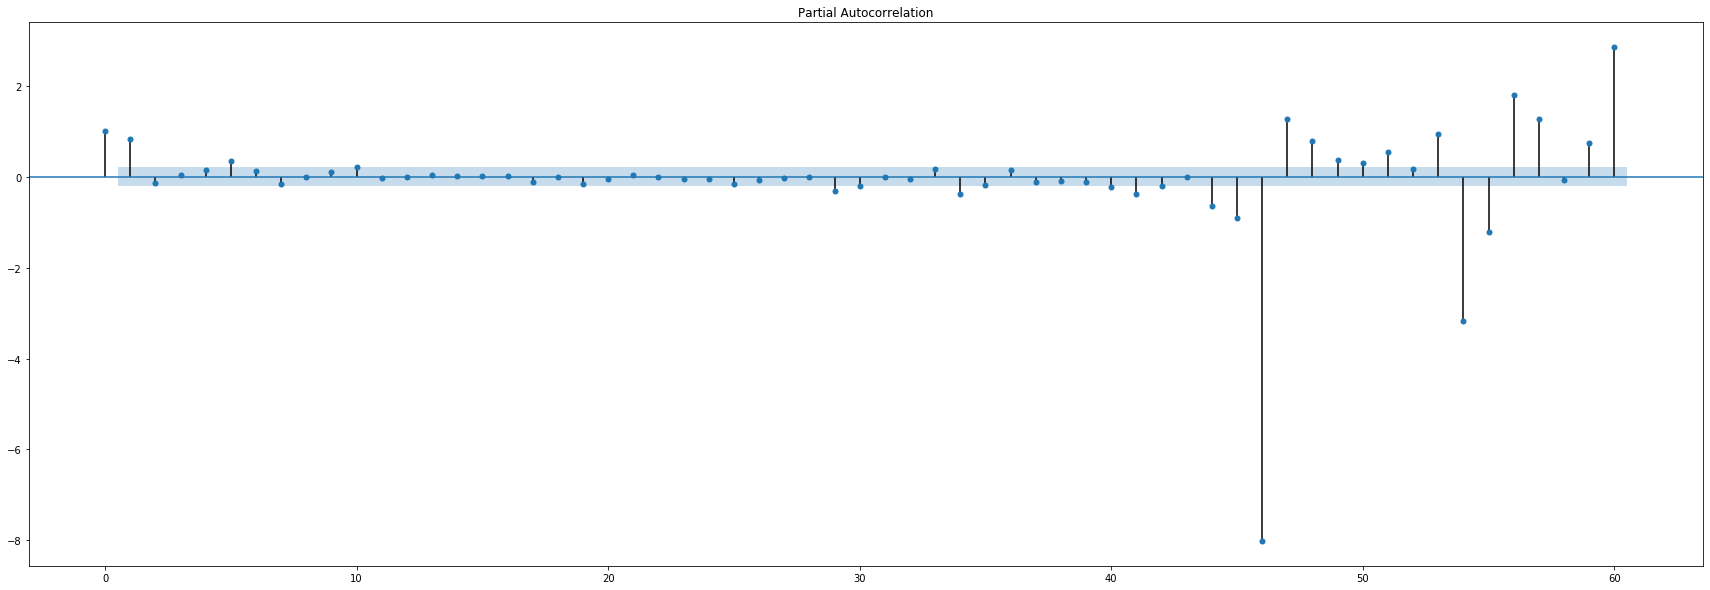

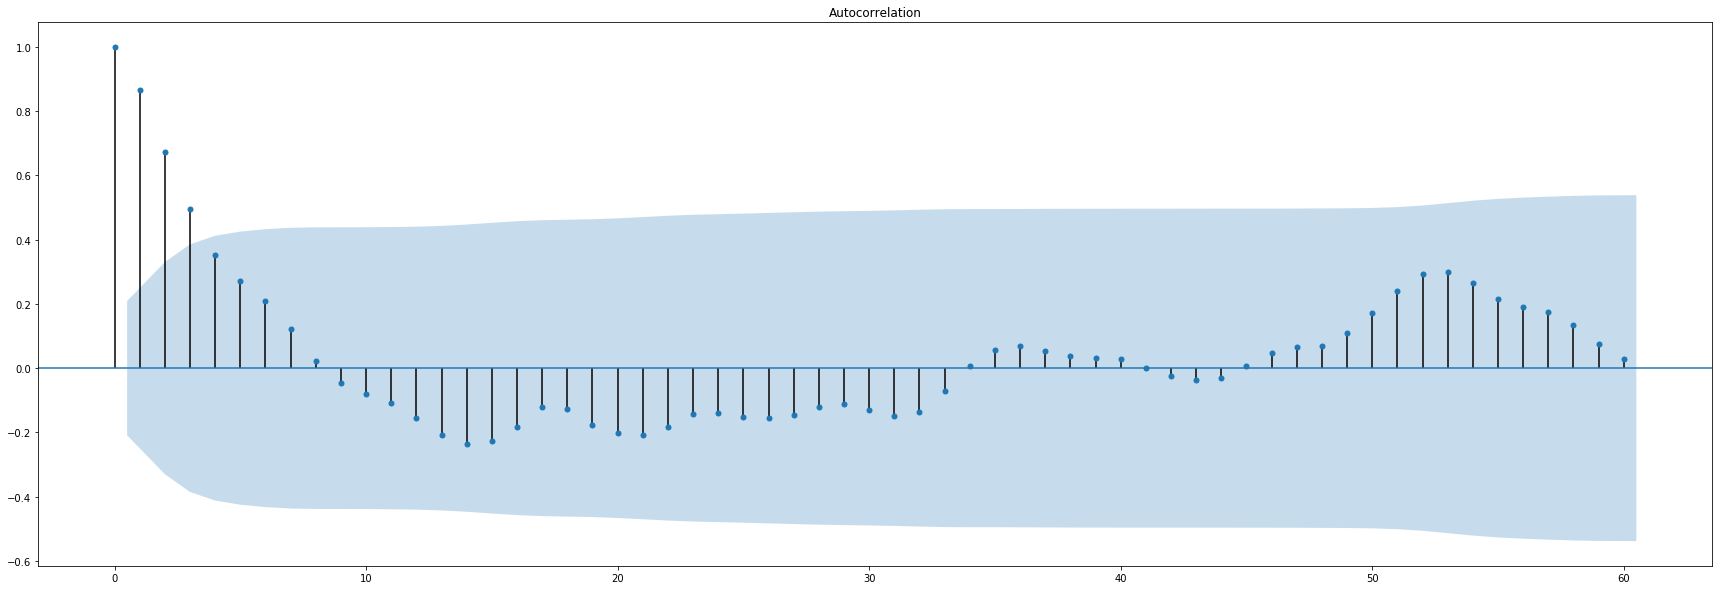

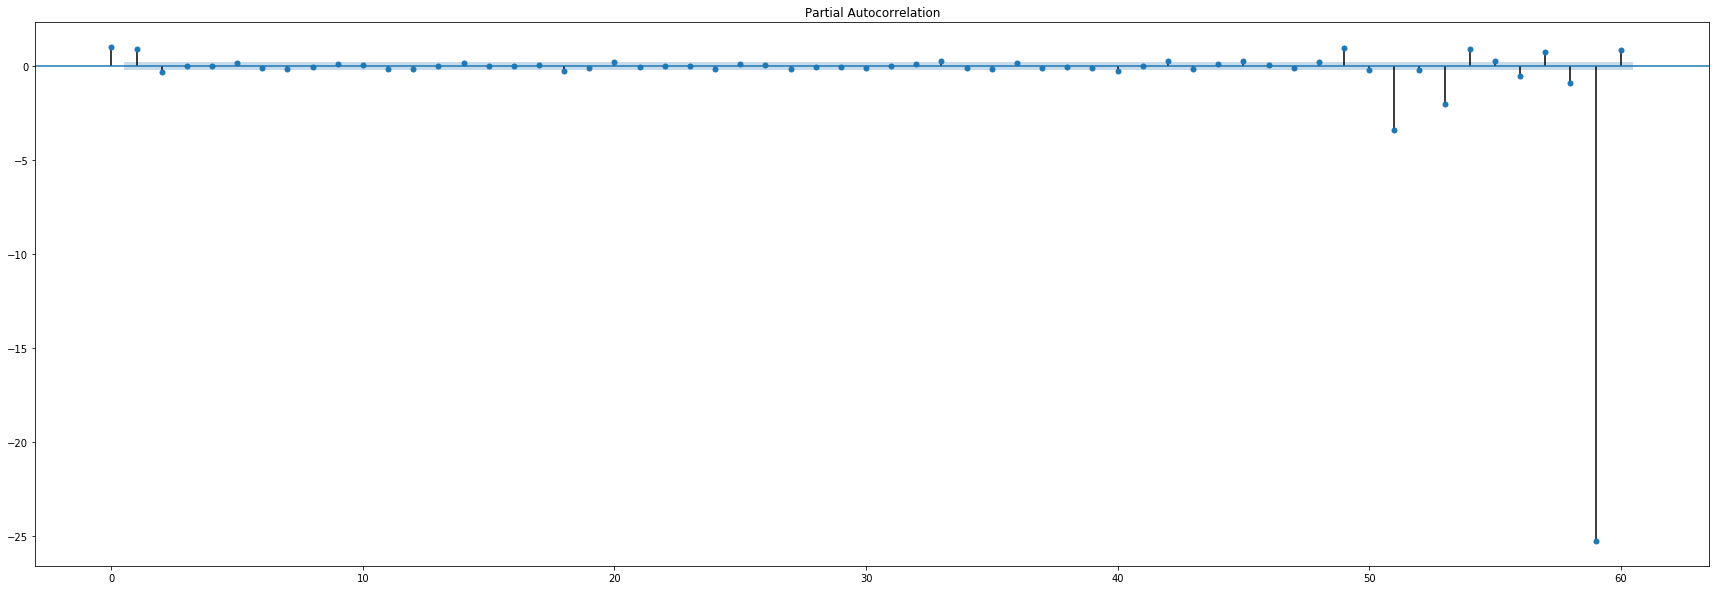

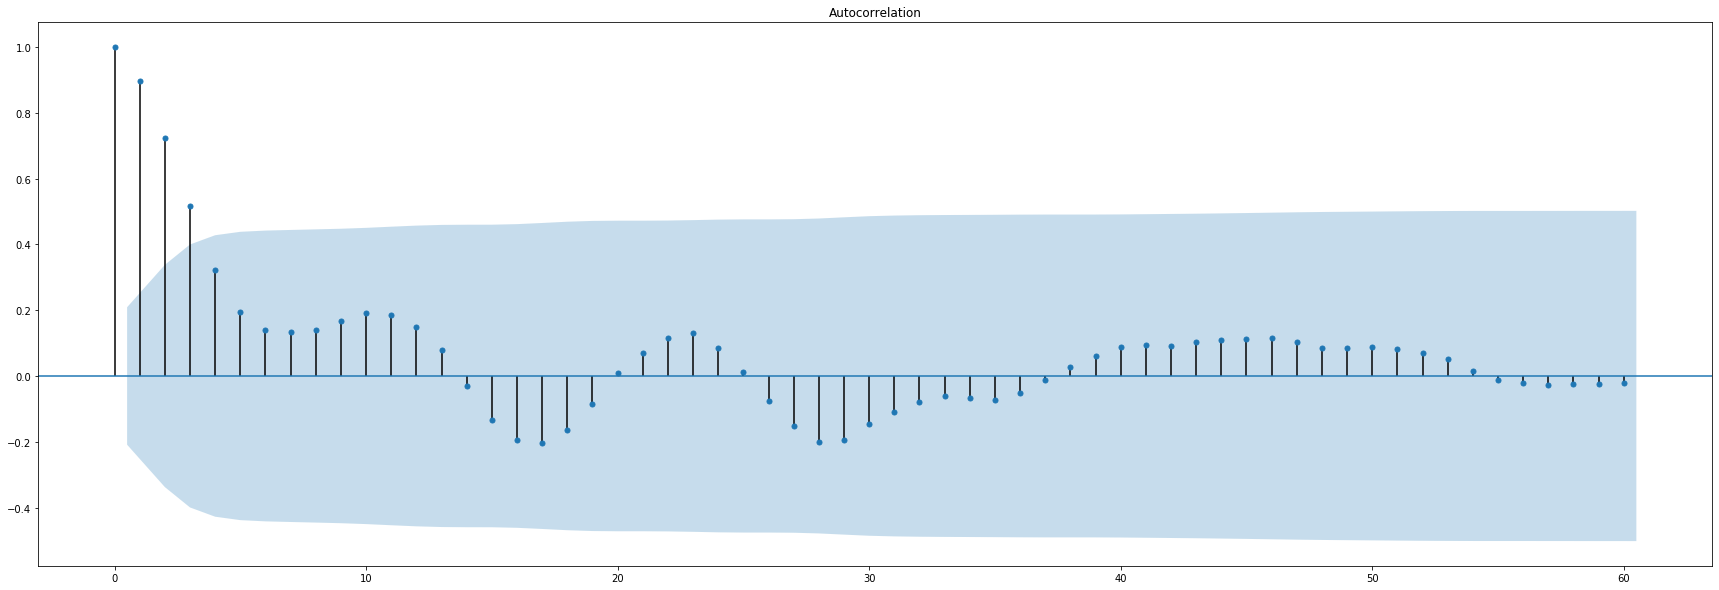

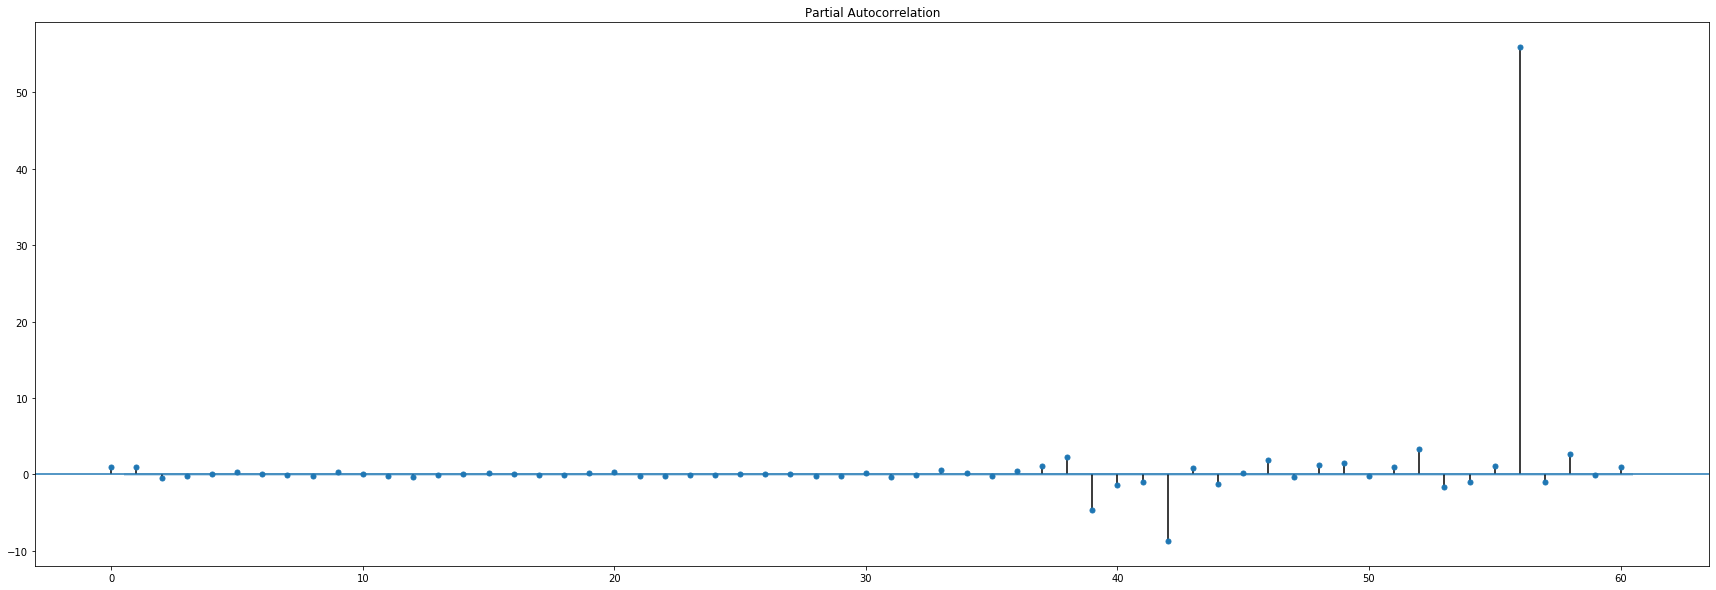

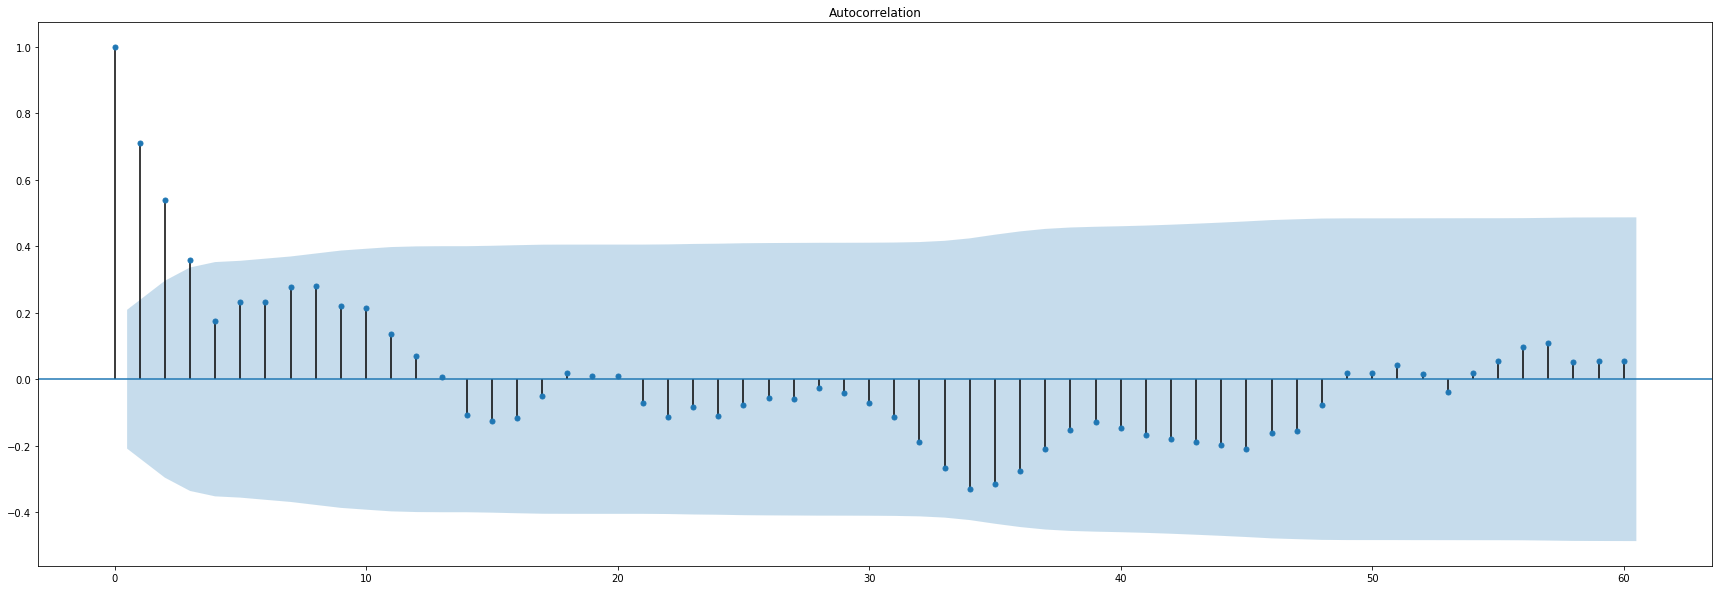

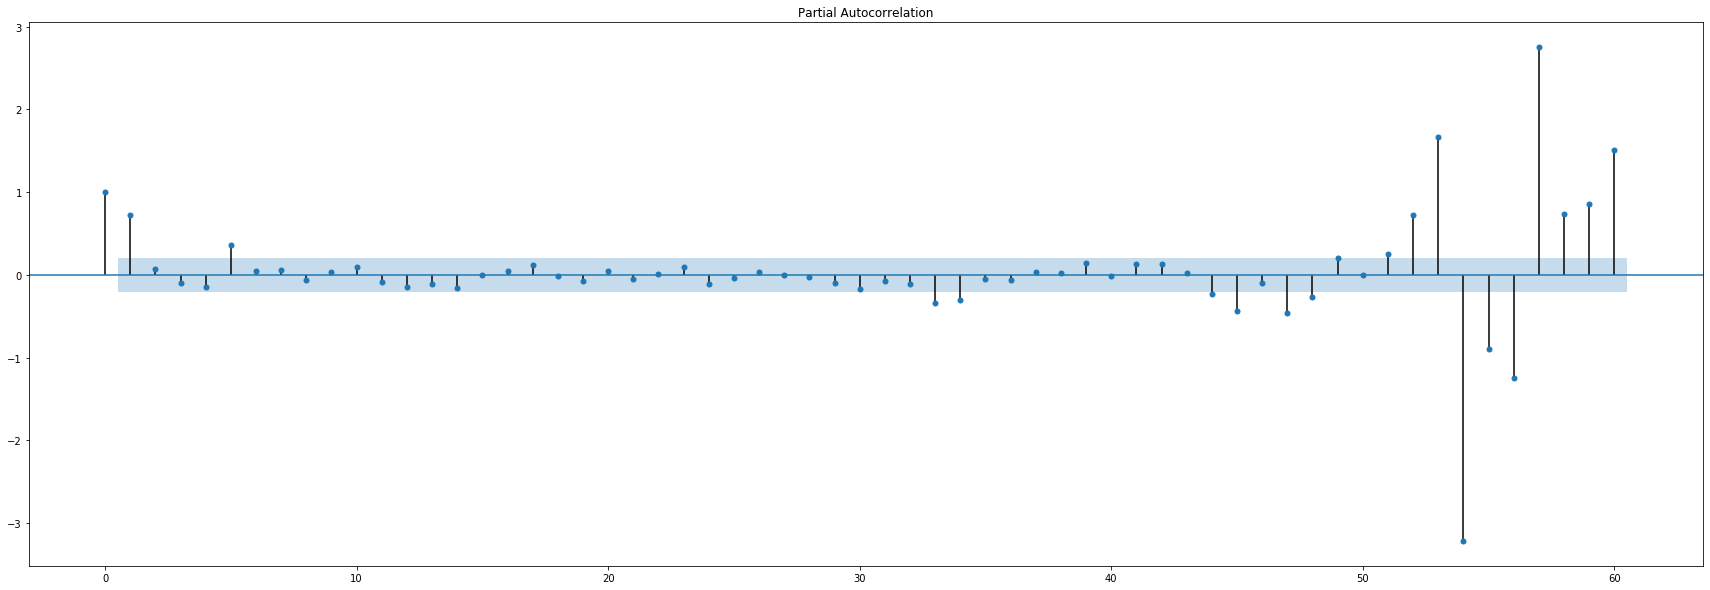

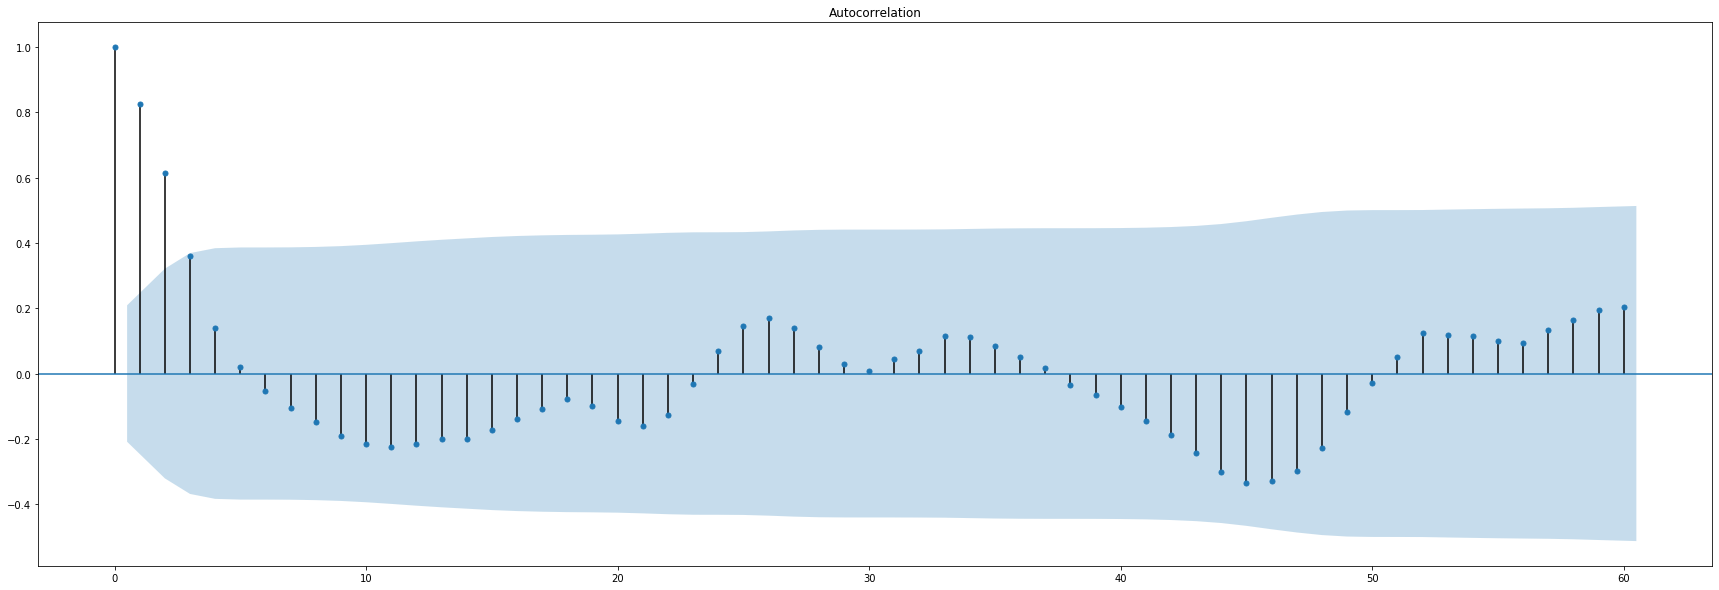

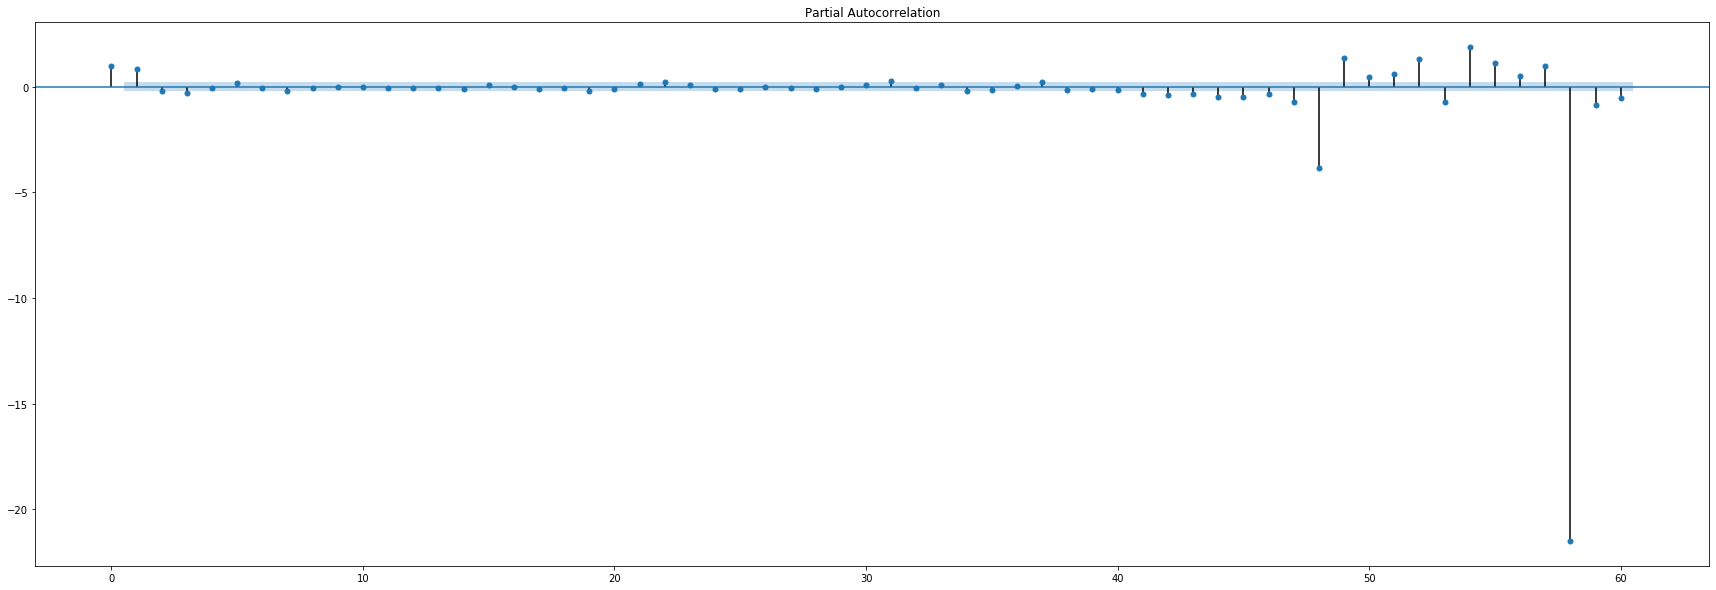

In [58]:
for i in np.argsort(Y_train)[:,-10:][0]:
    series = pd.DataFrame(np.transpose(np.vstack([Y_train[:,i]])),columns=["Y_train"])
    with mpl.rc_context():
        mpl.rc("figure", figsize=(30,10))
        plot_acf(series,lags=60)
        plot_pacf(series,lags=60)

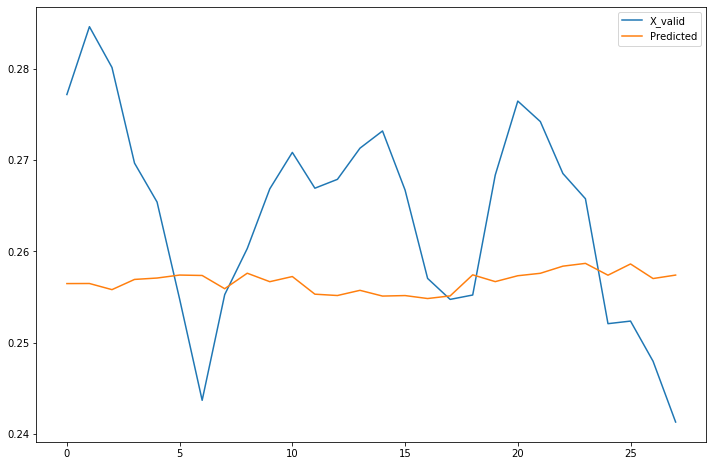

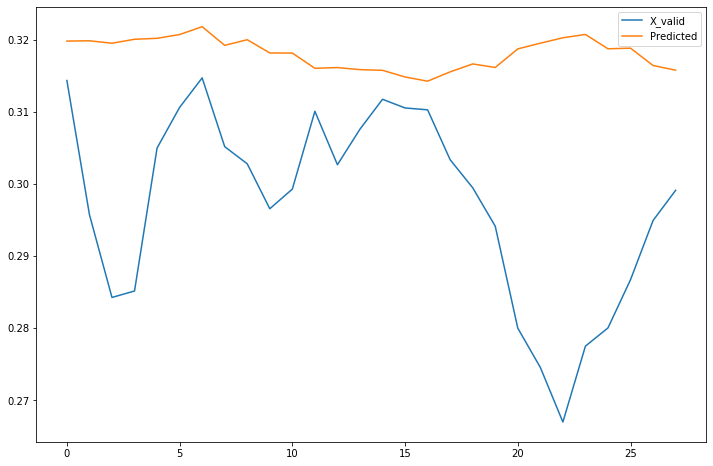

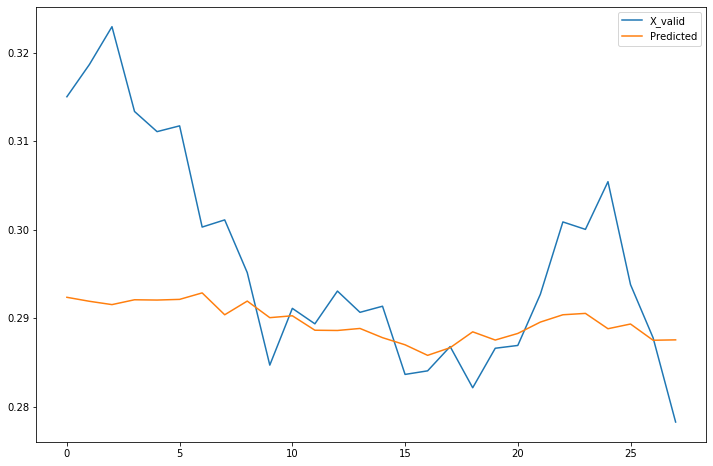

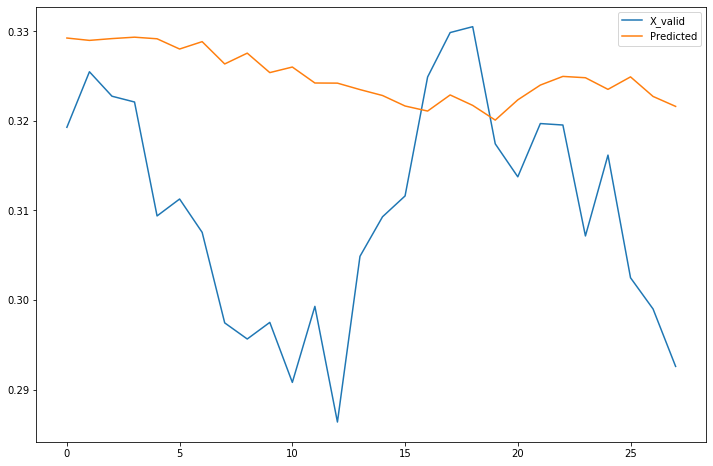

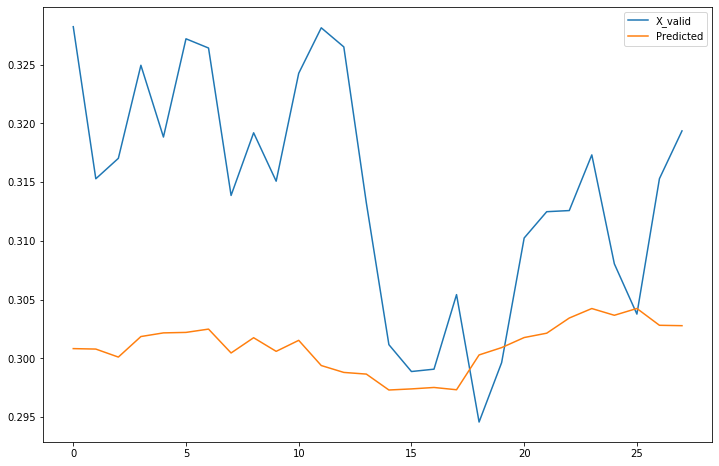

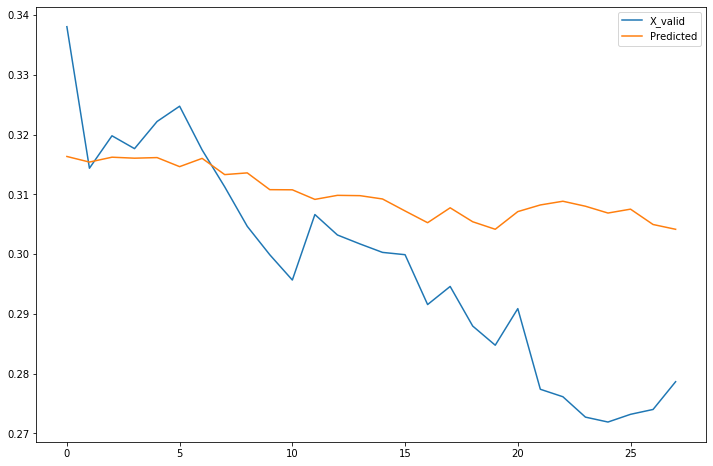

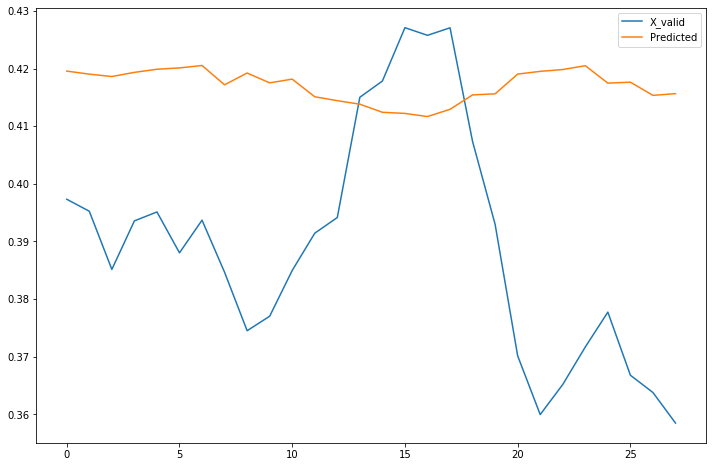

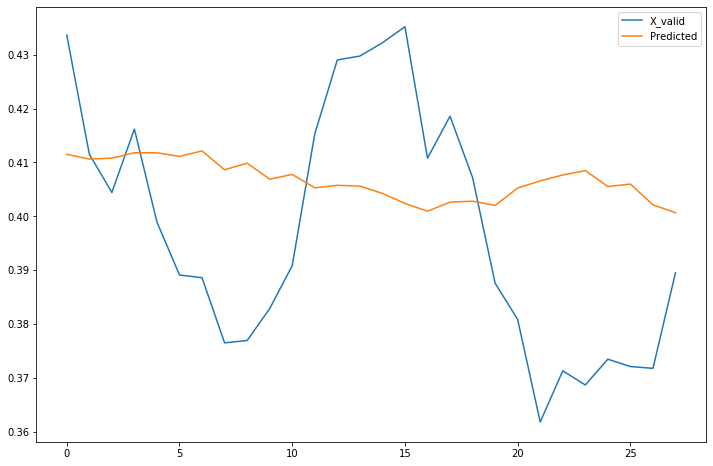

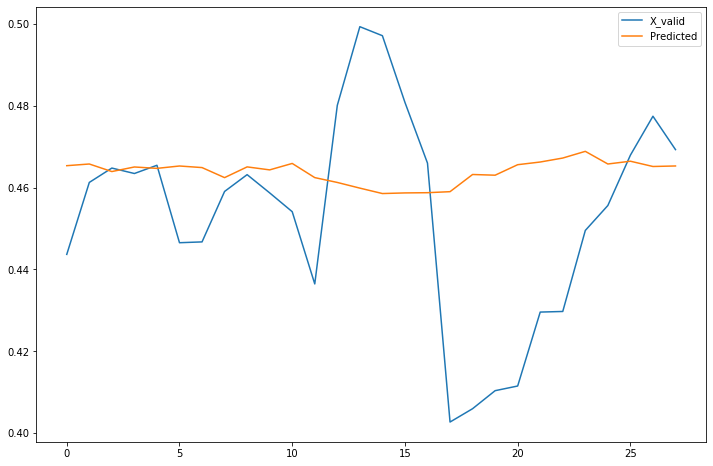

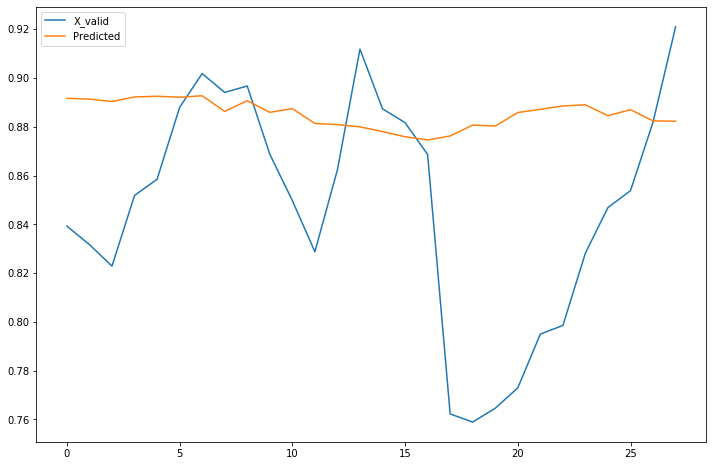

In [40]:
Predict = model.predict(X_valid)
for i in np.argsort(Y_valid)[:,-10:][0]:
    pd.DataFrame(np.transpose(np.vstack([Y_valid[:,i],Predict[:,i]])),columns=["X_valid","Predicted"]).plot(figsize=(12,8))

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

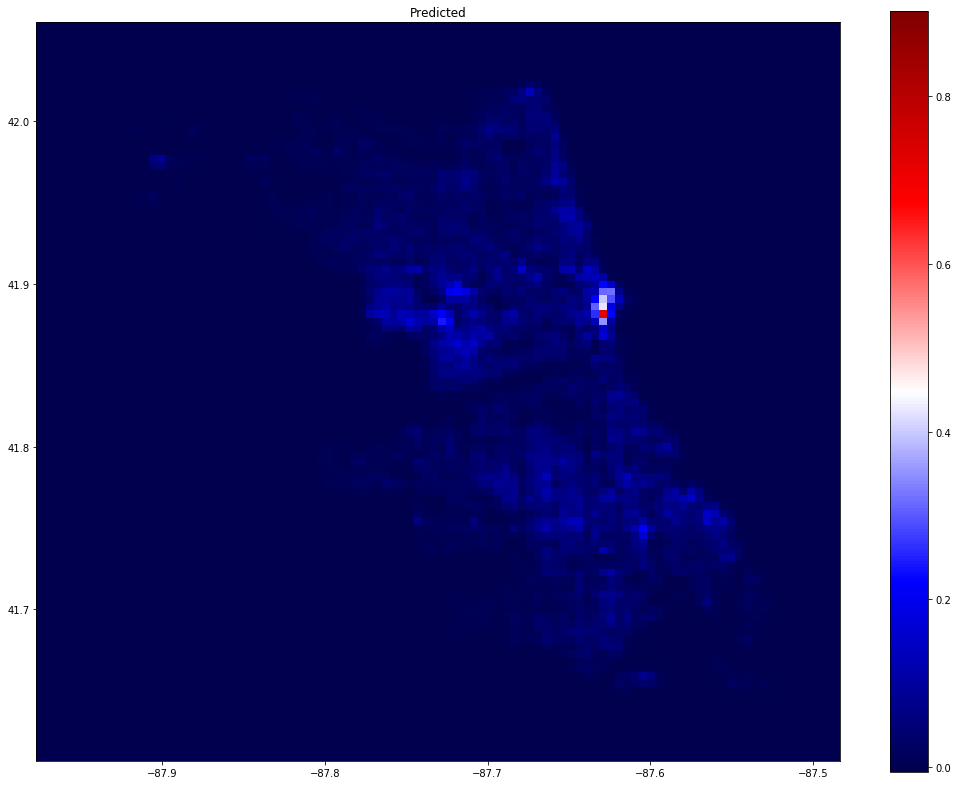

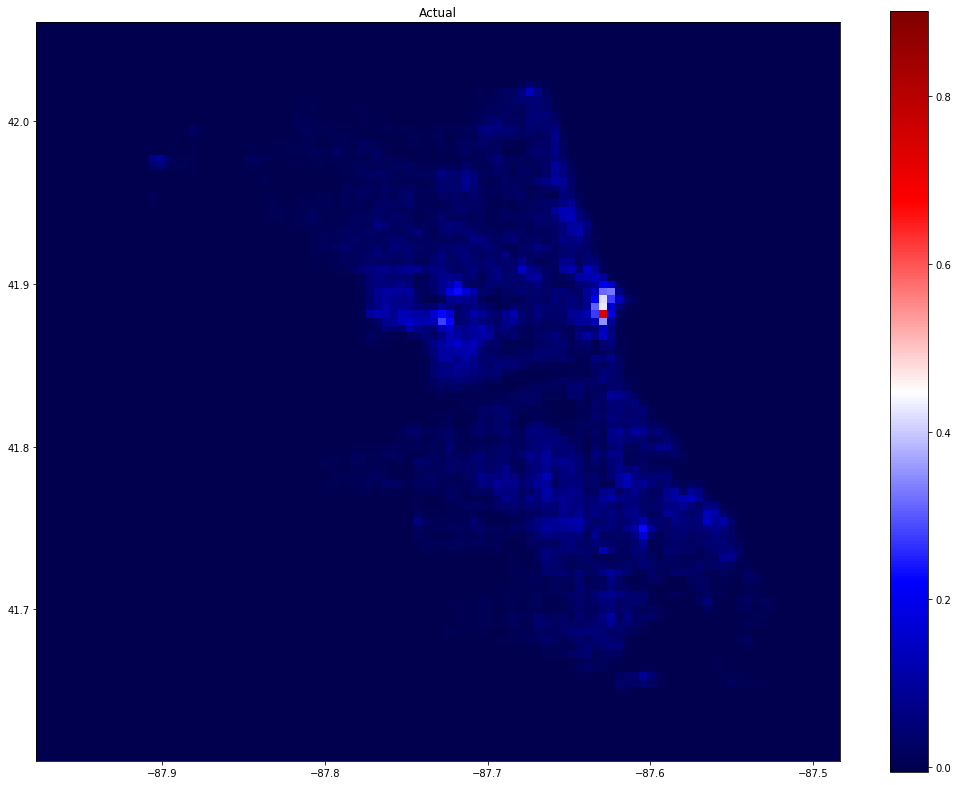

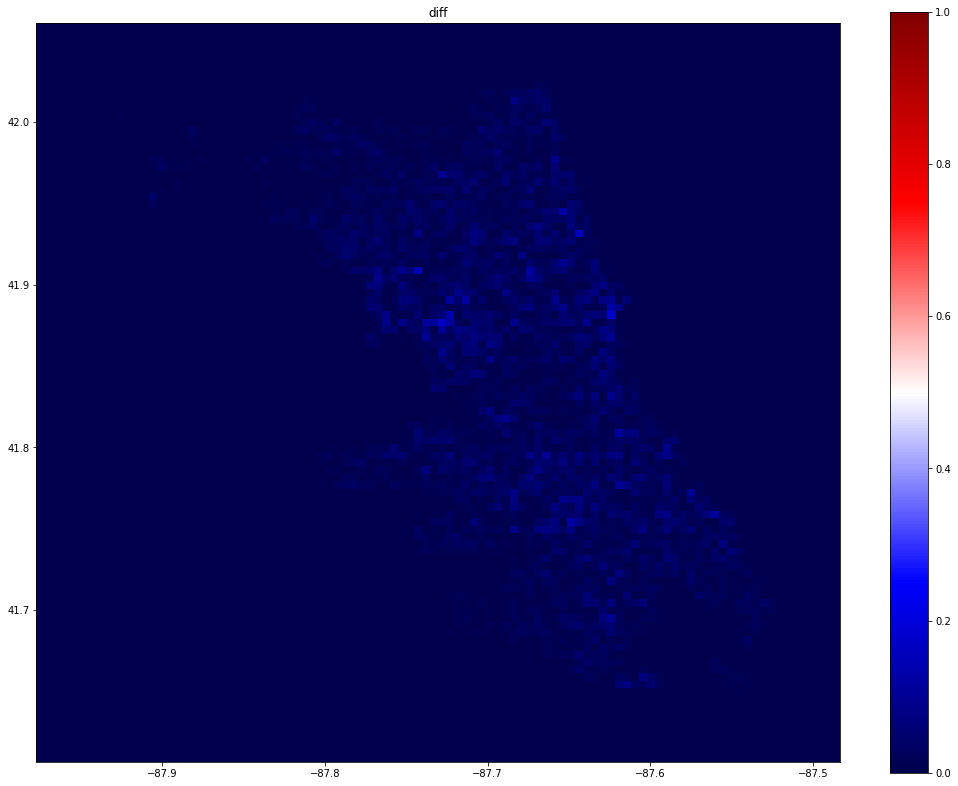

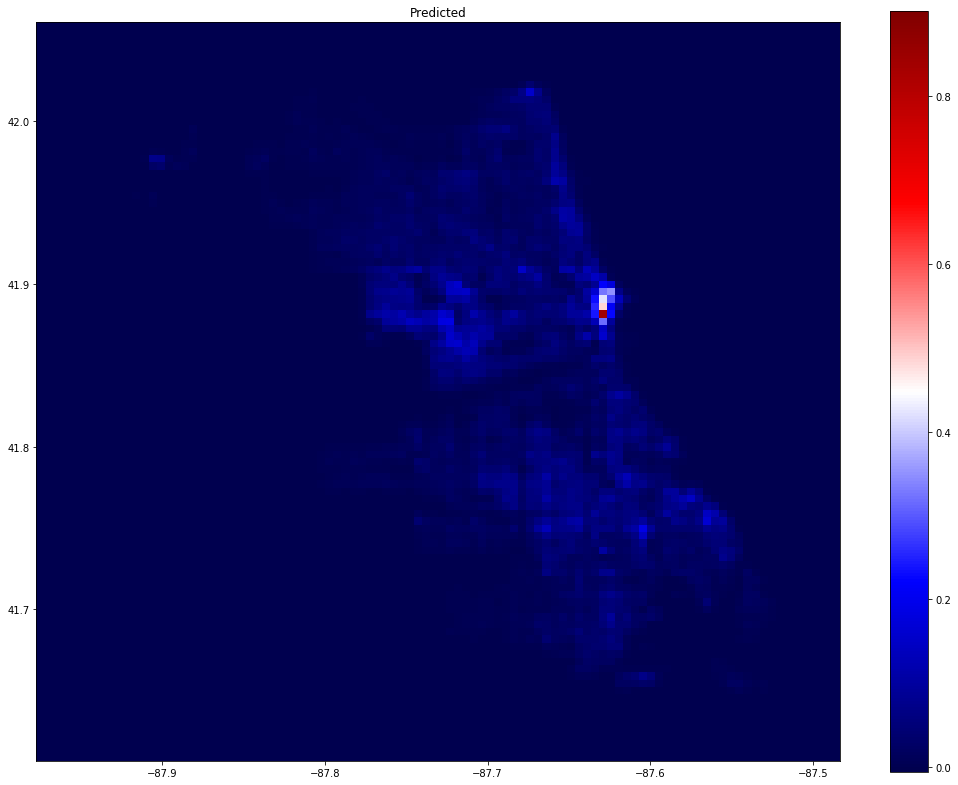

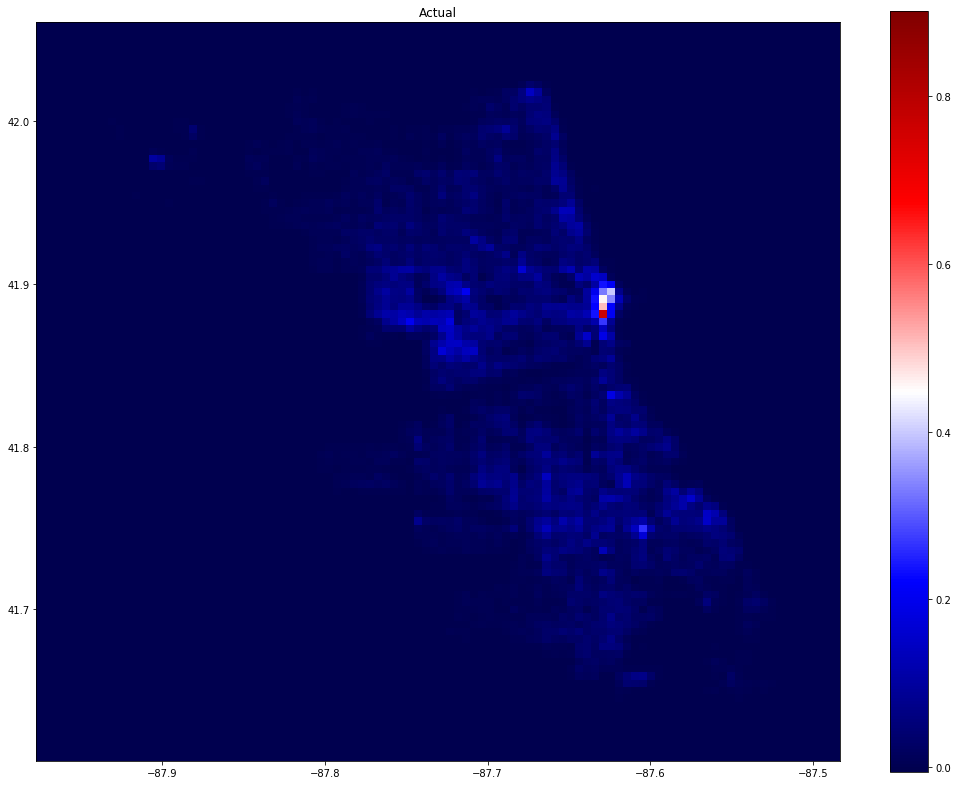

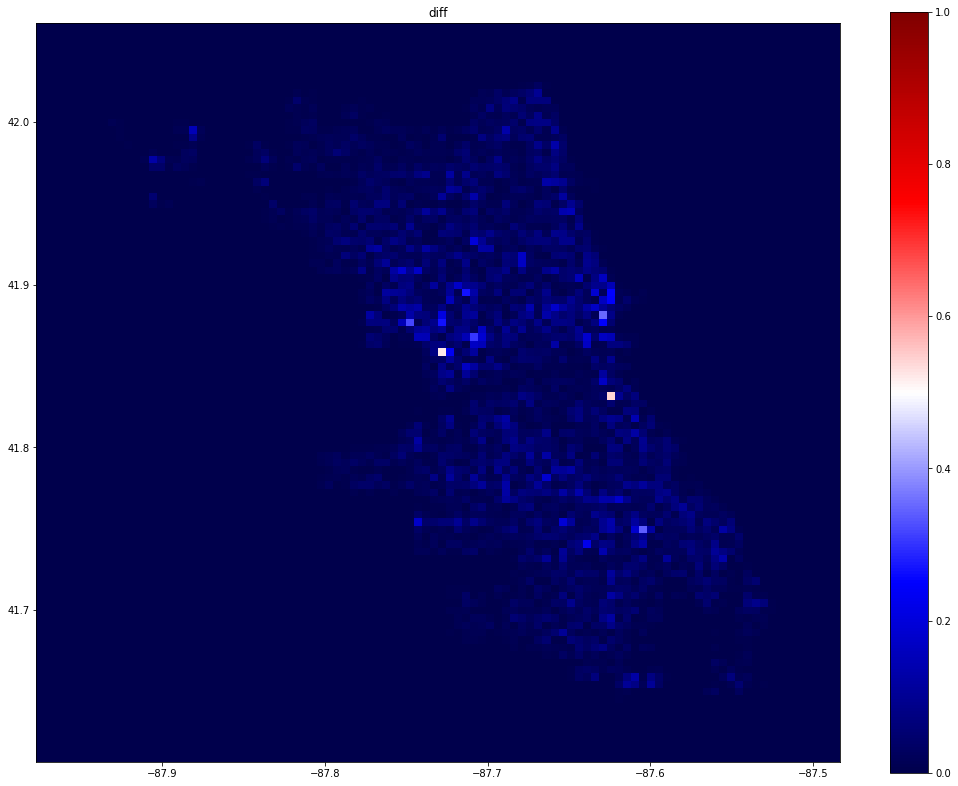

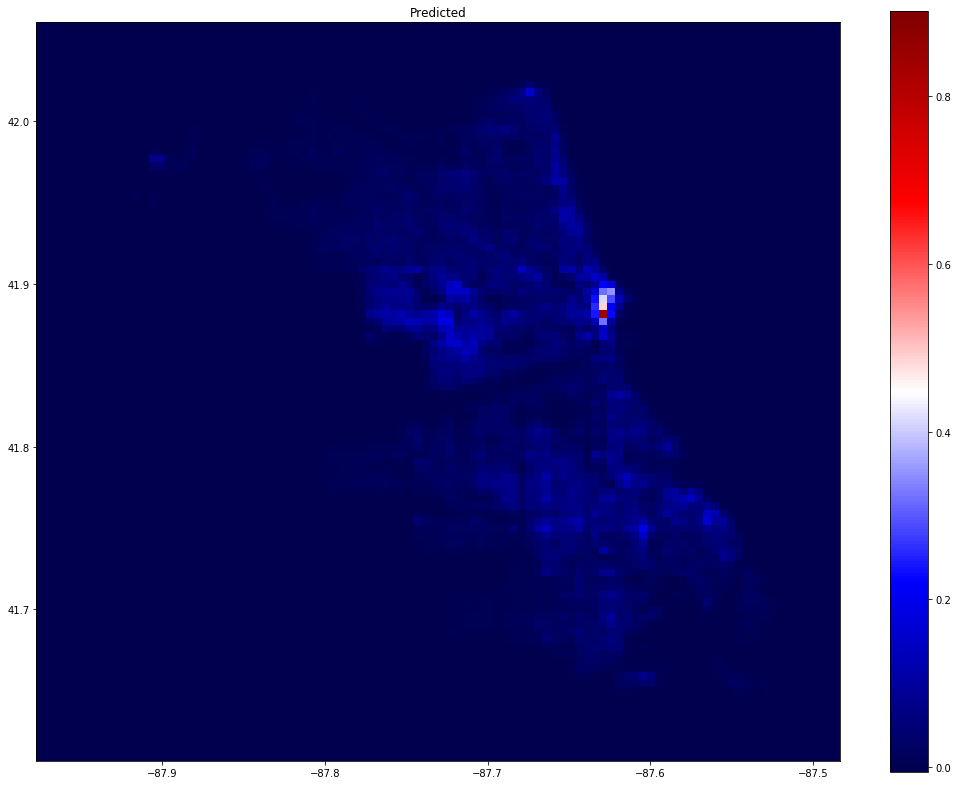

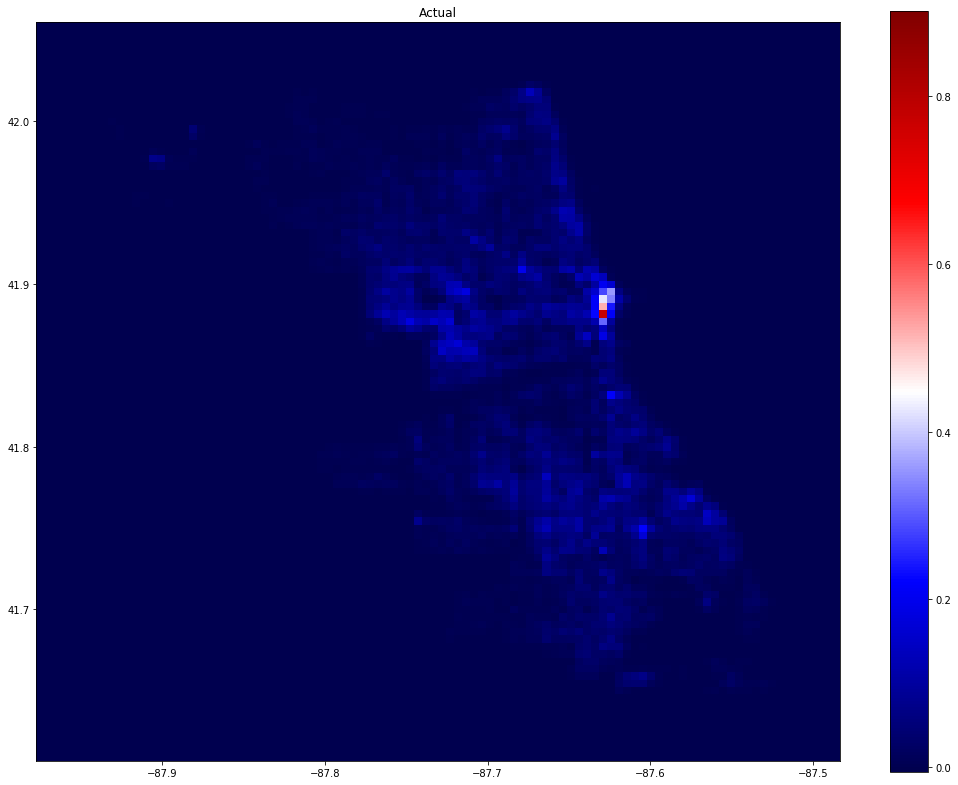

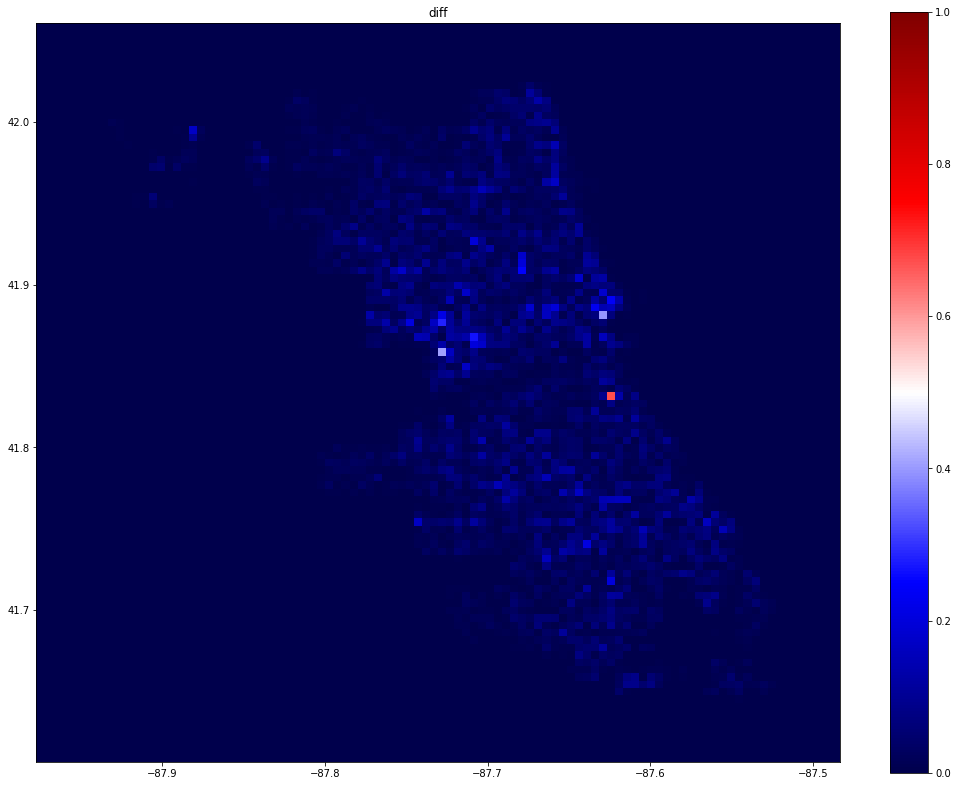

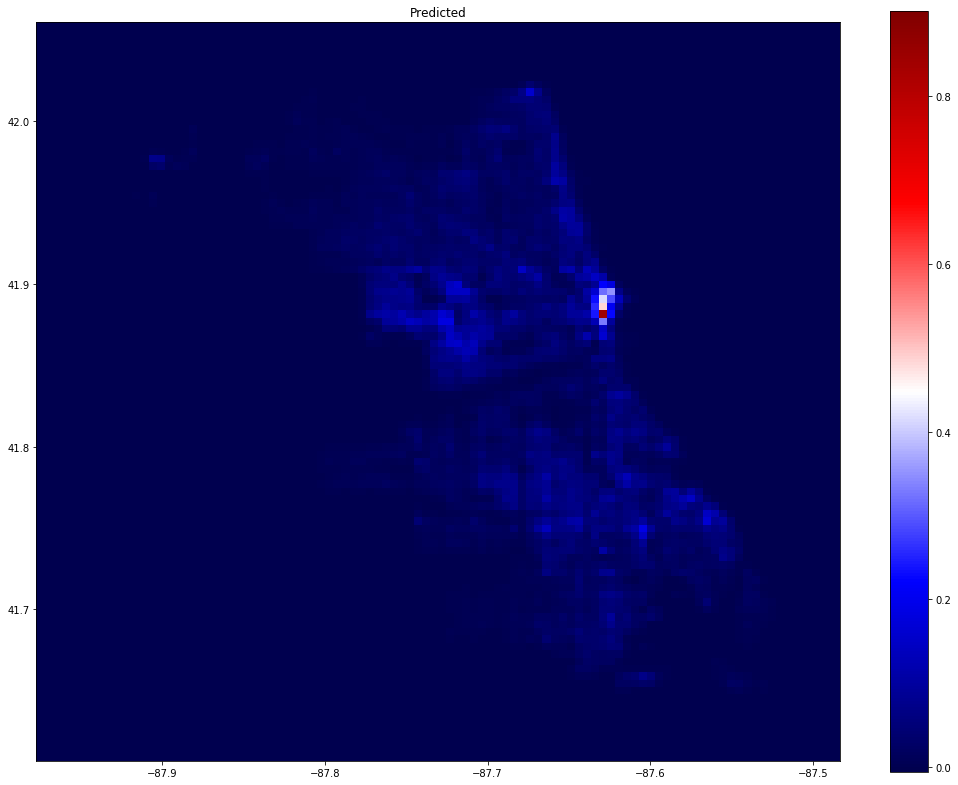

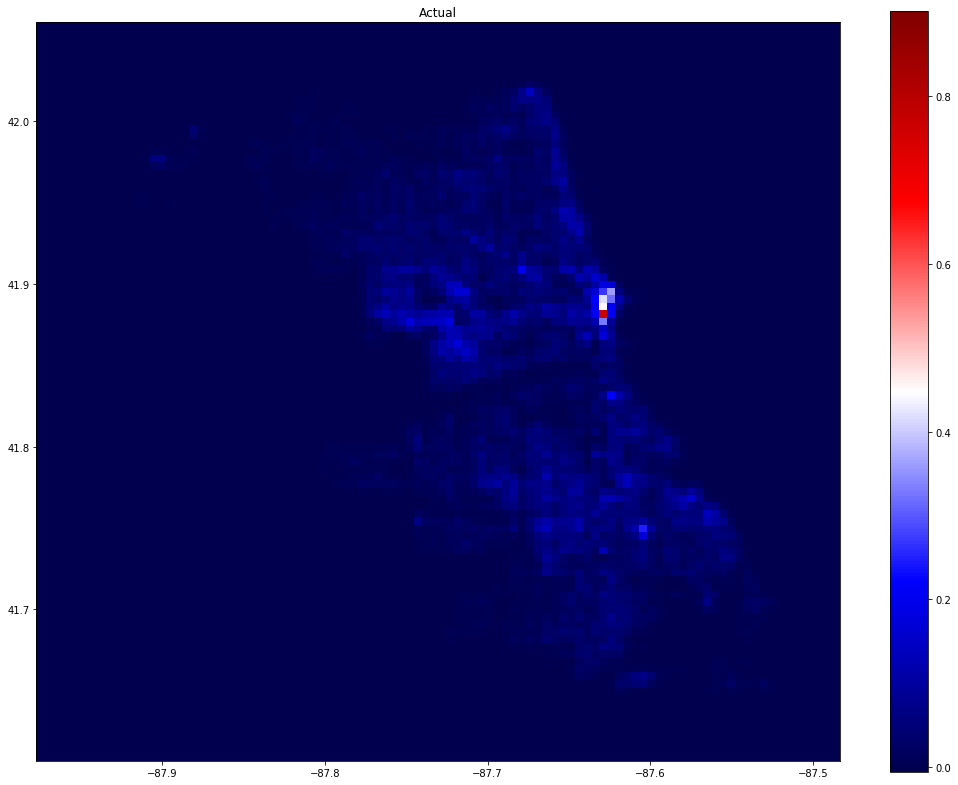

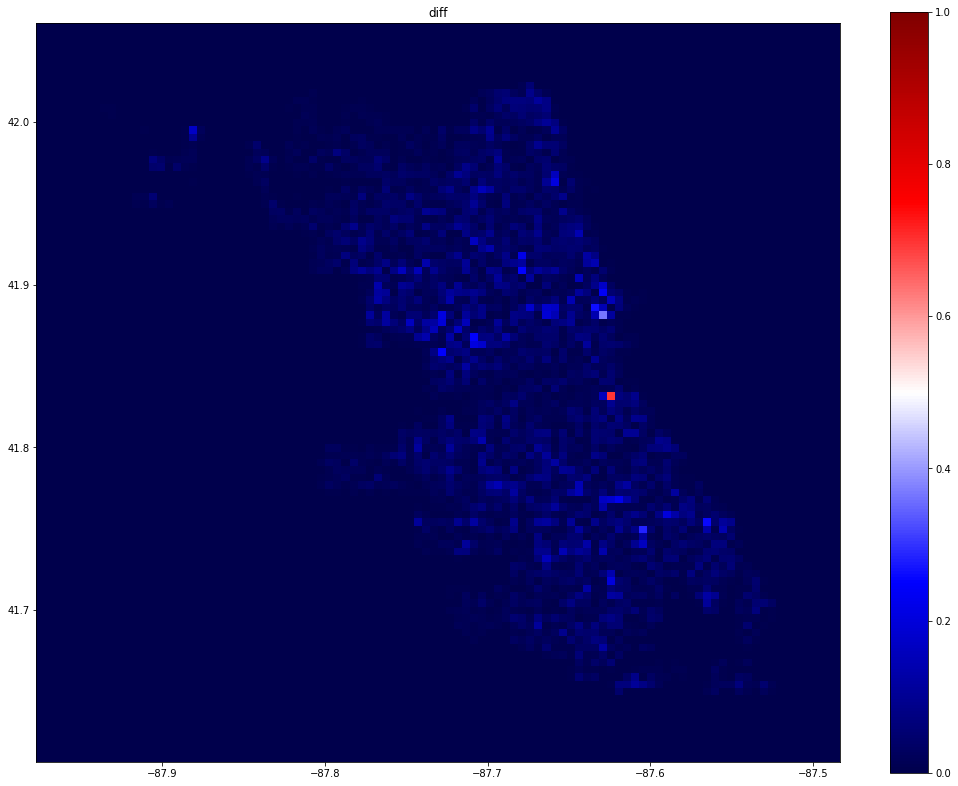

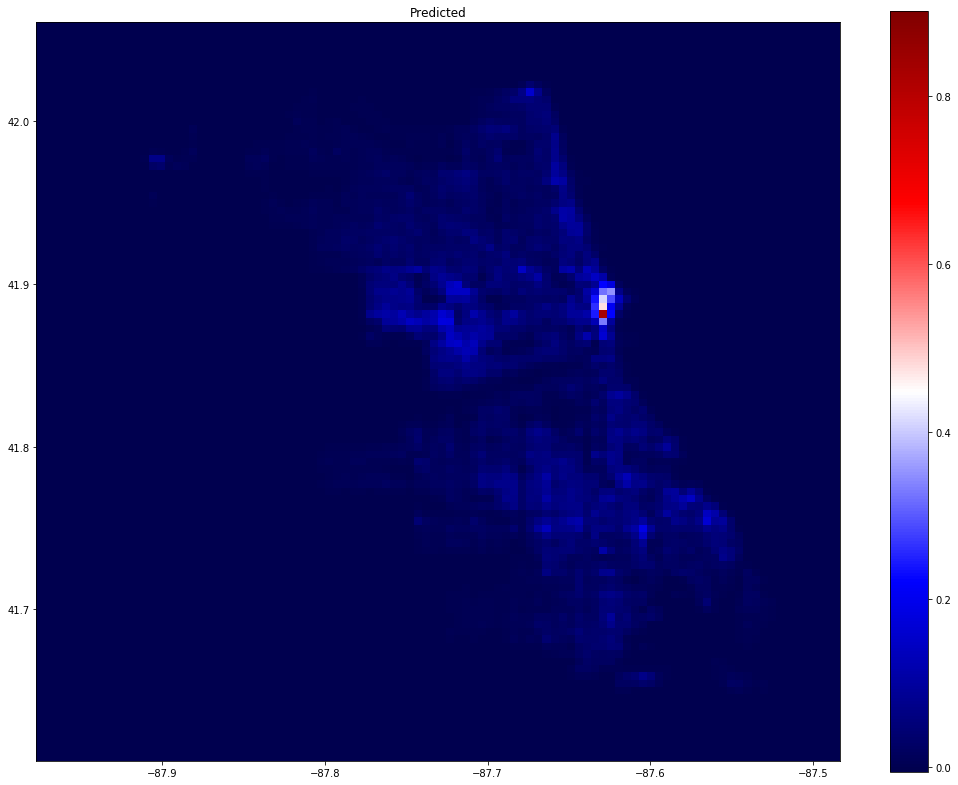

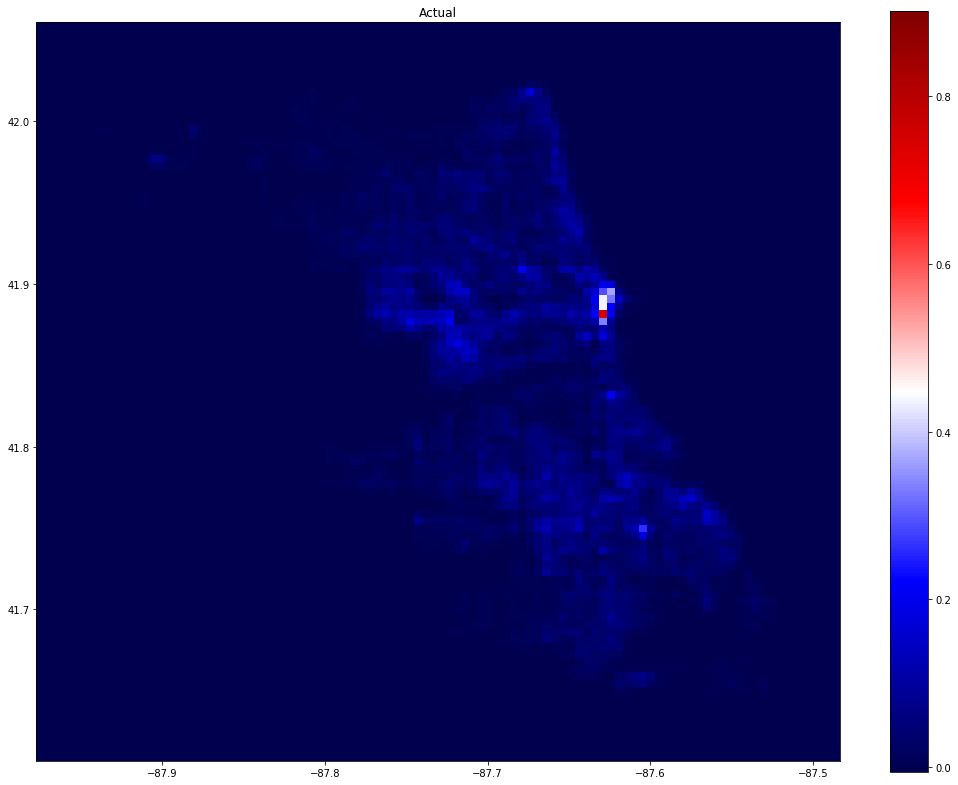

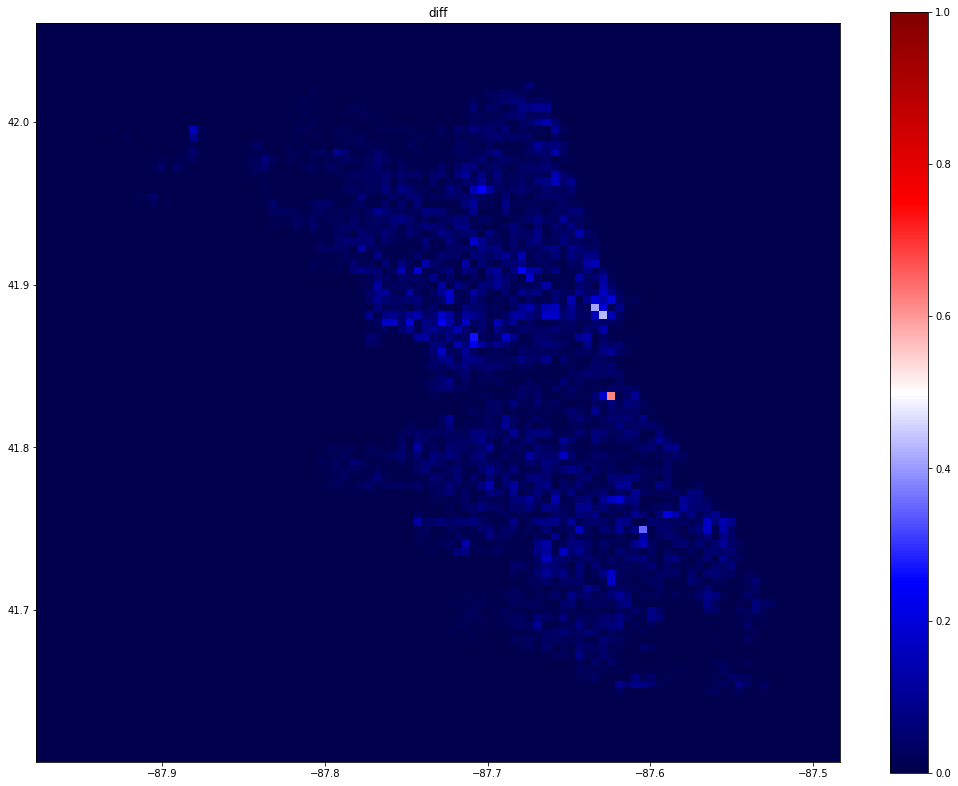

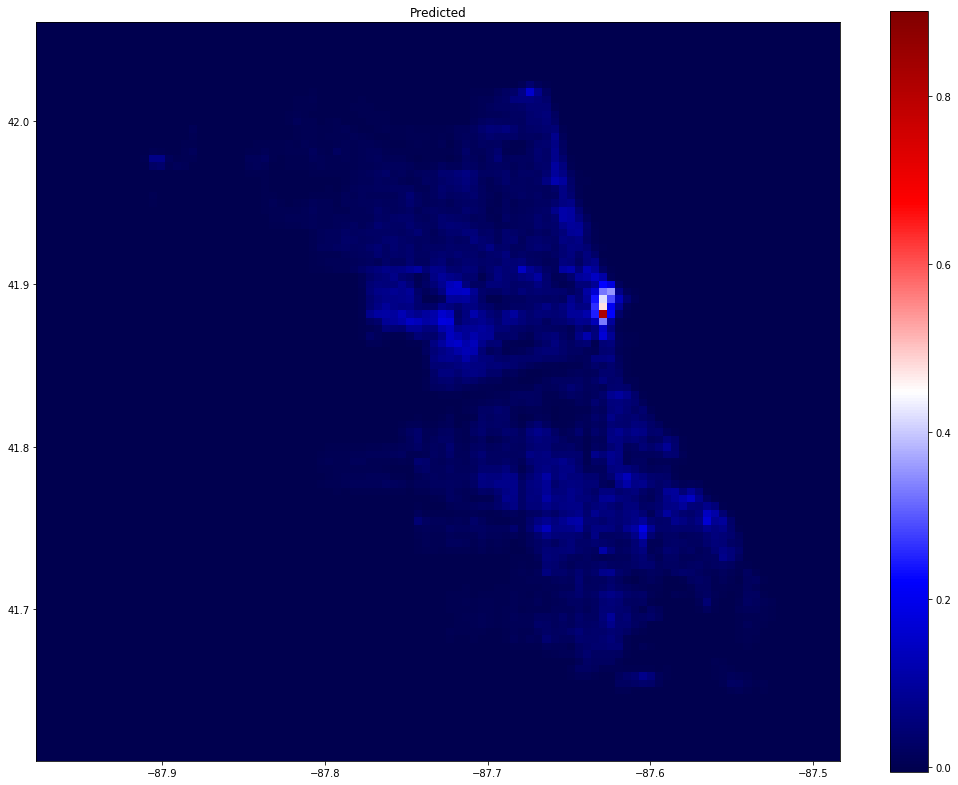

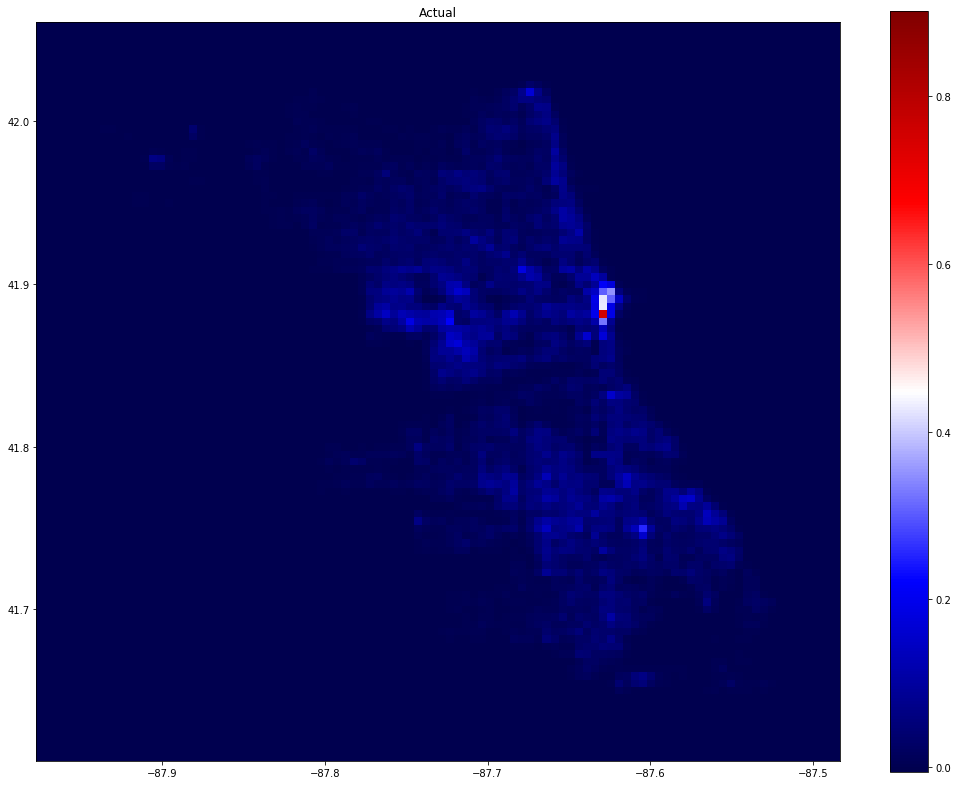

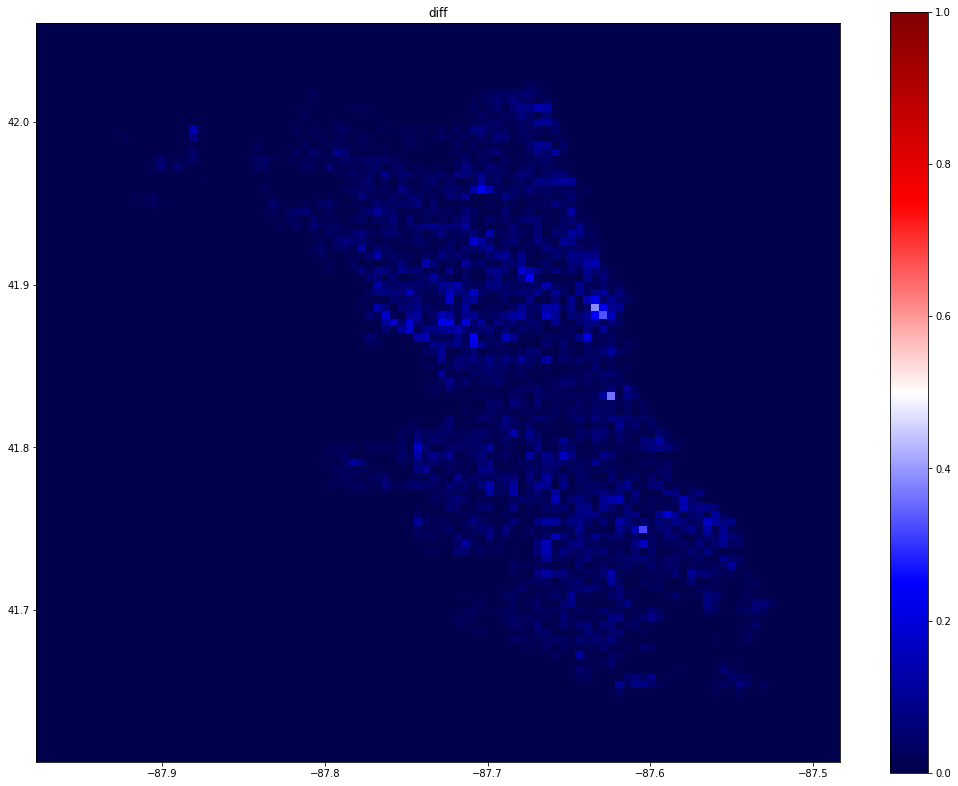

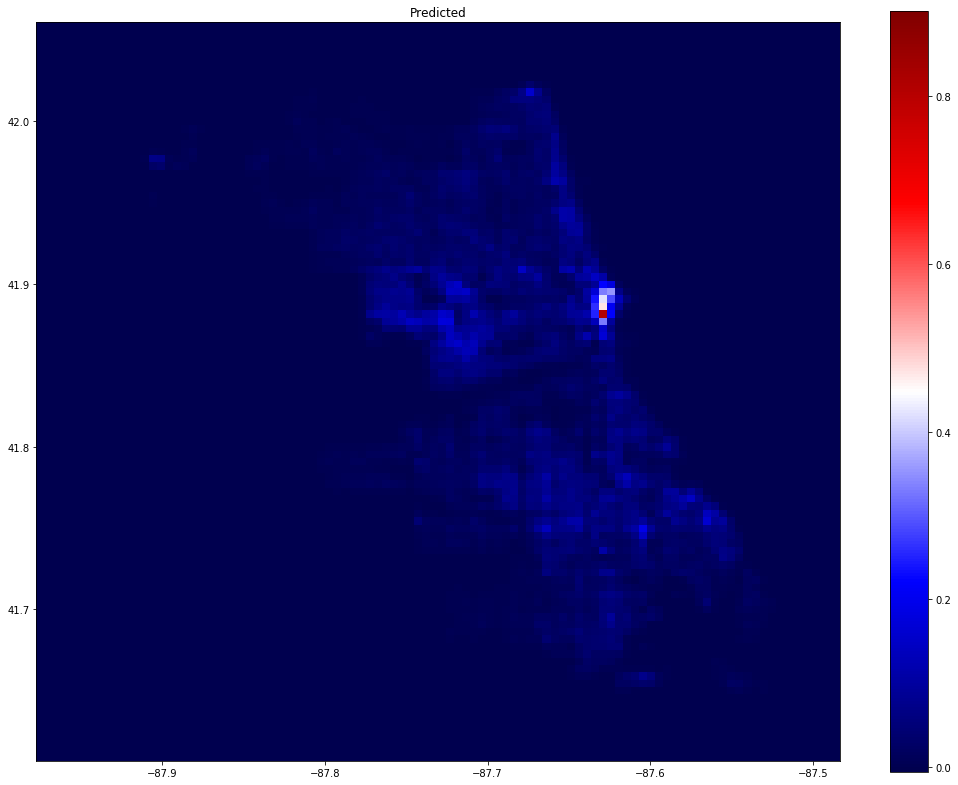

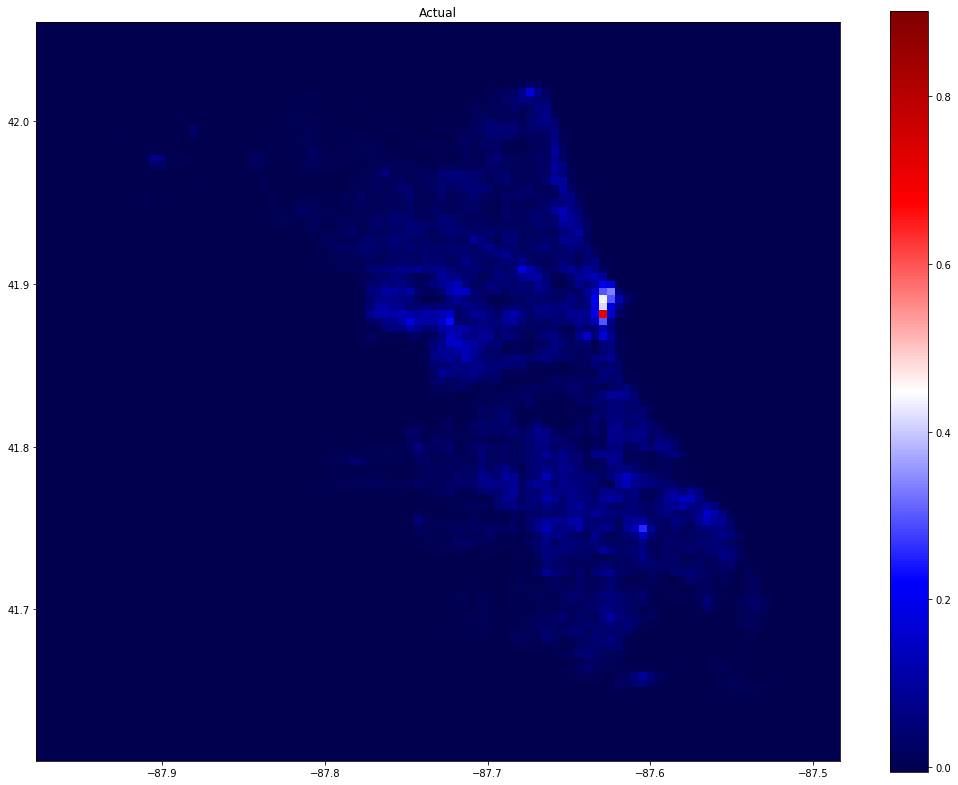

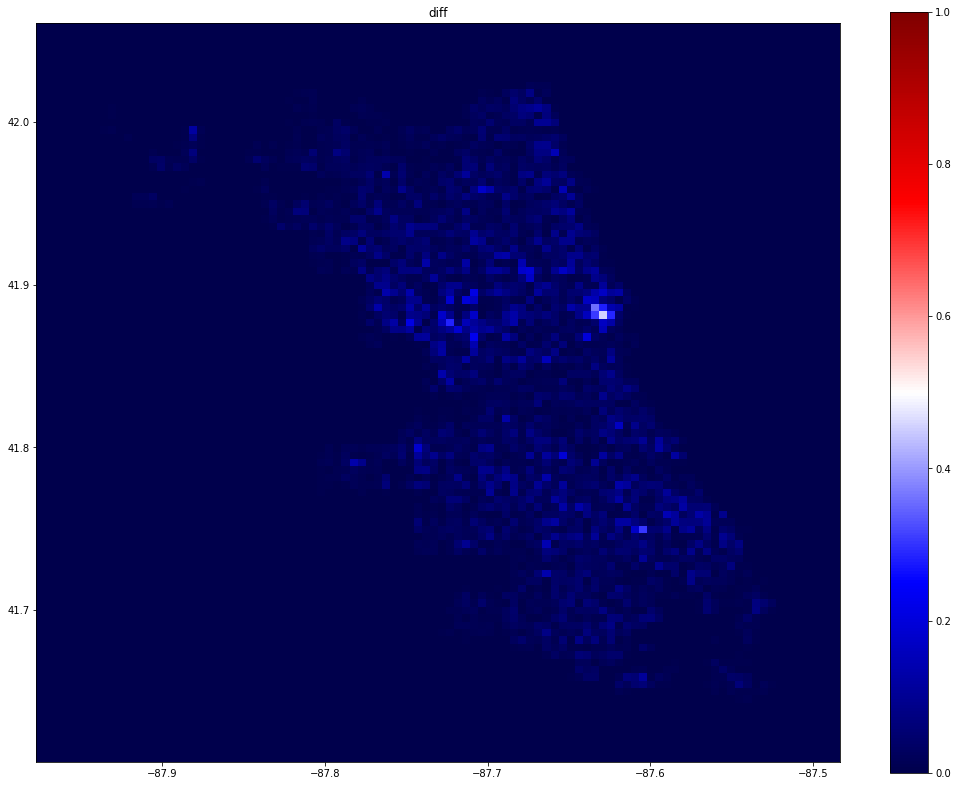

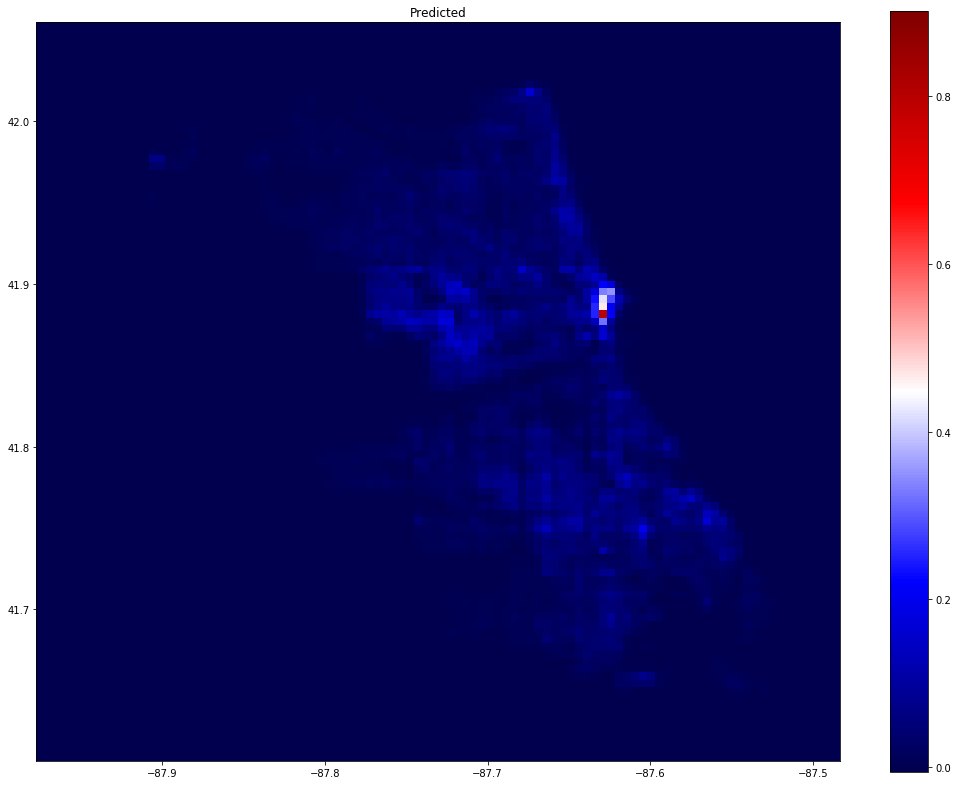

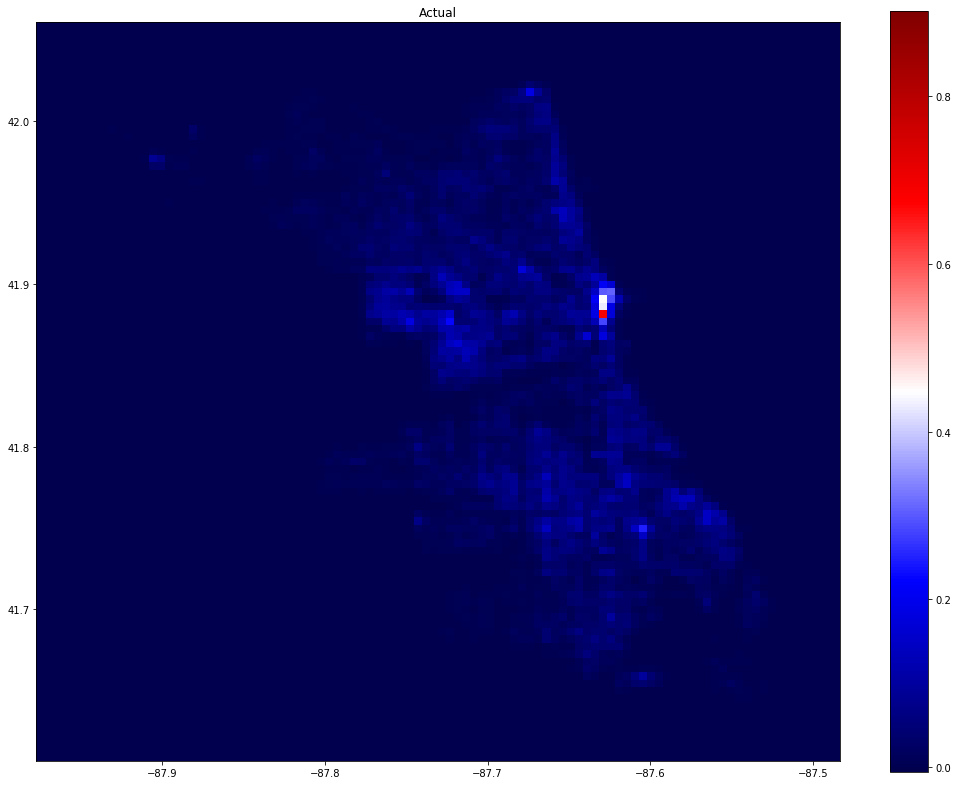

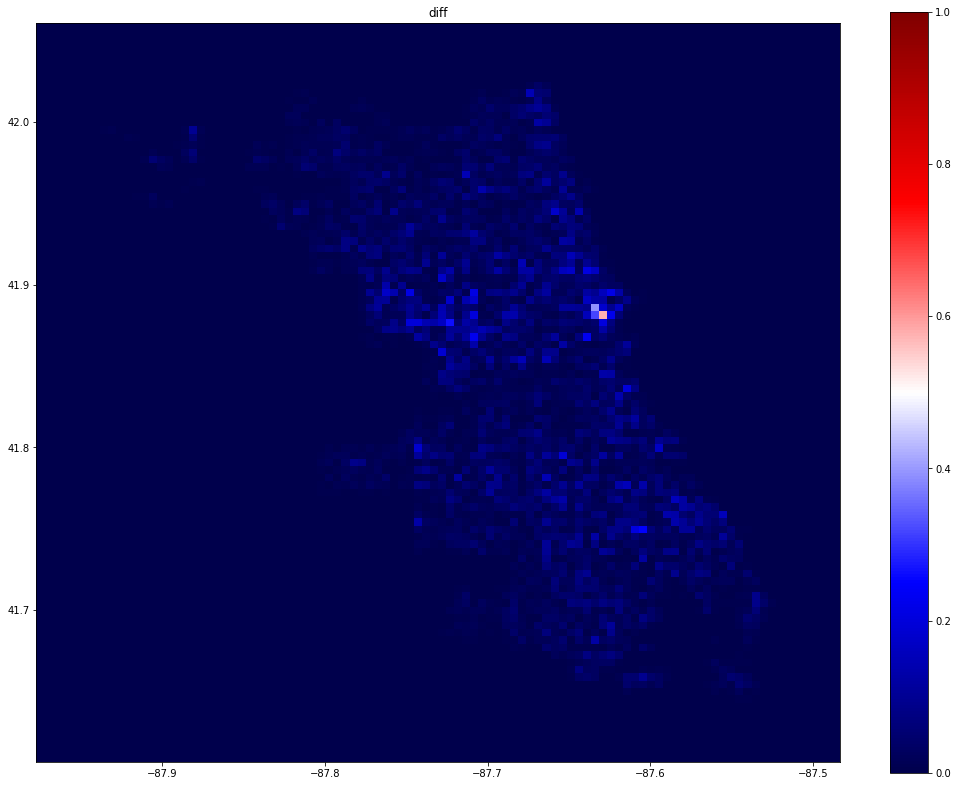

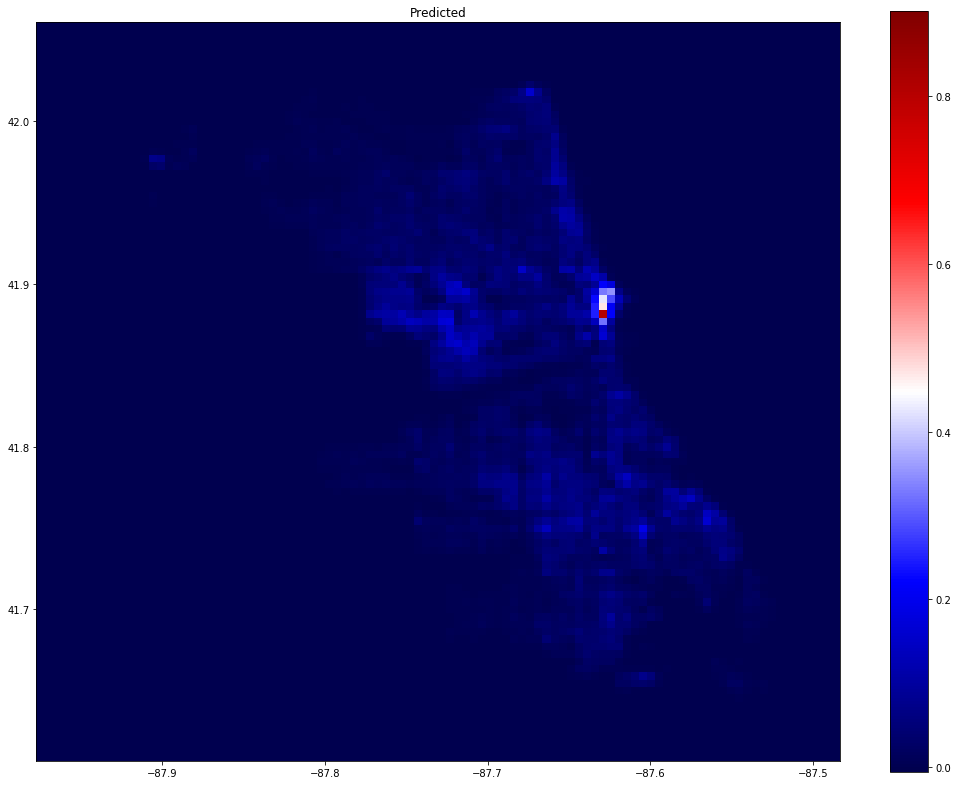

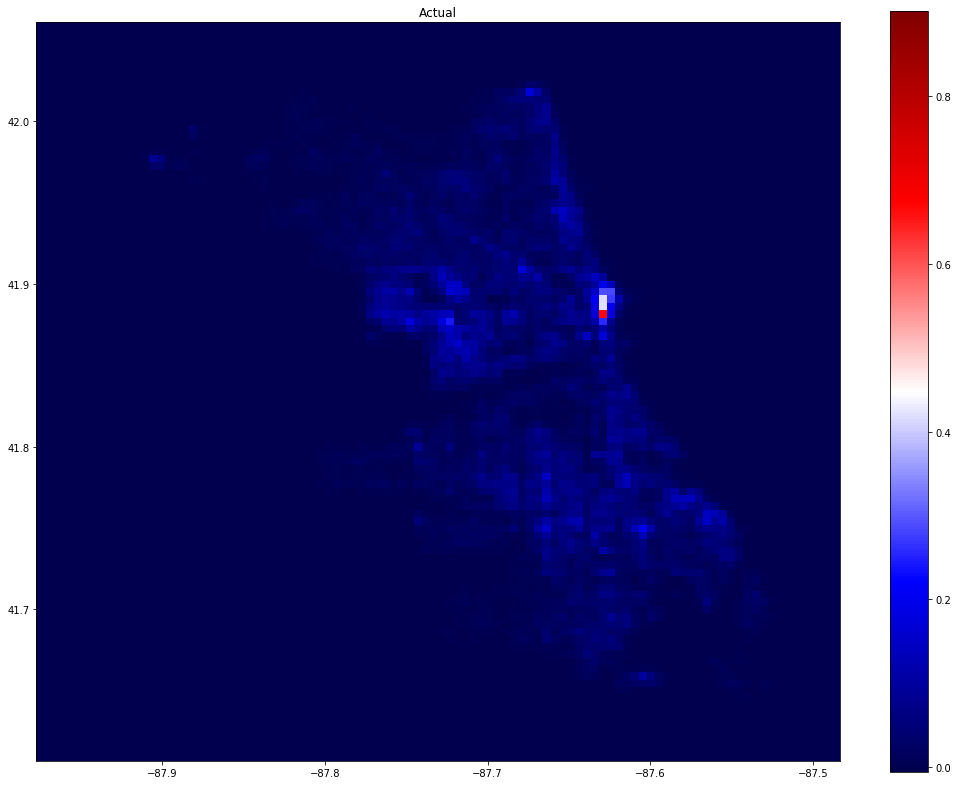

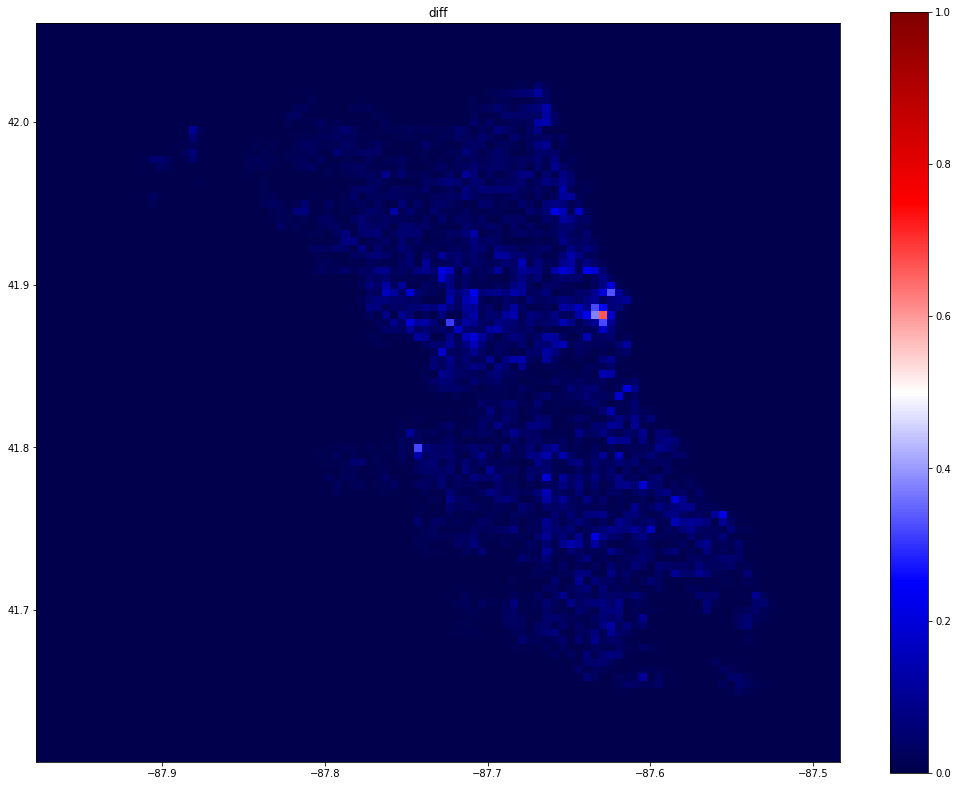

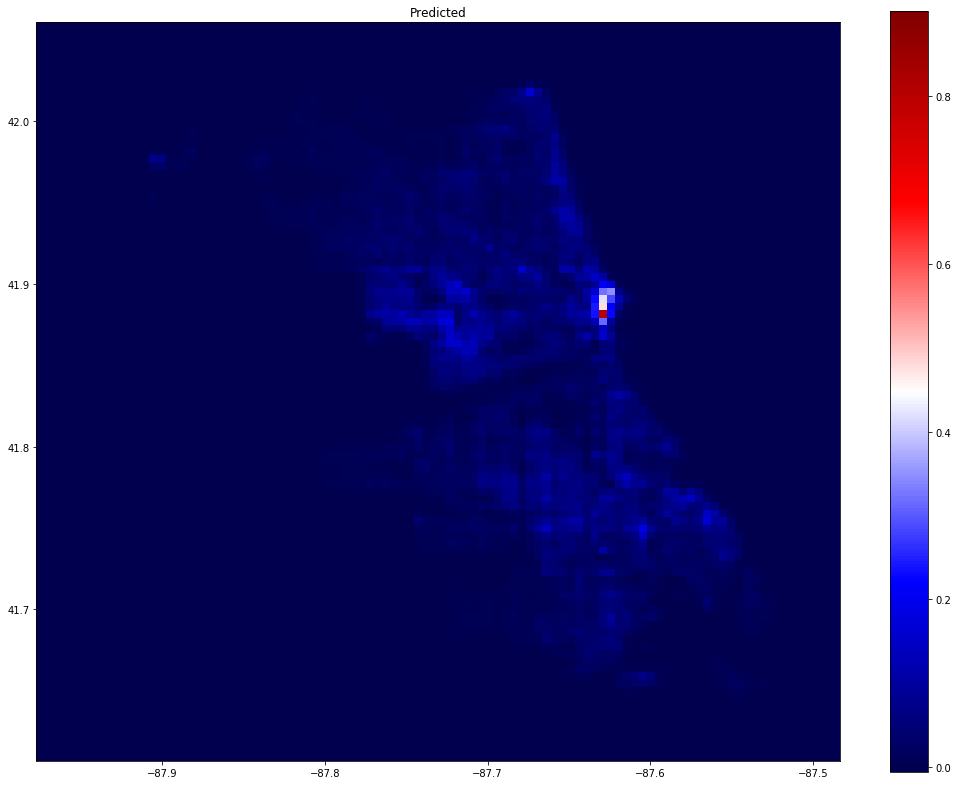

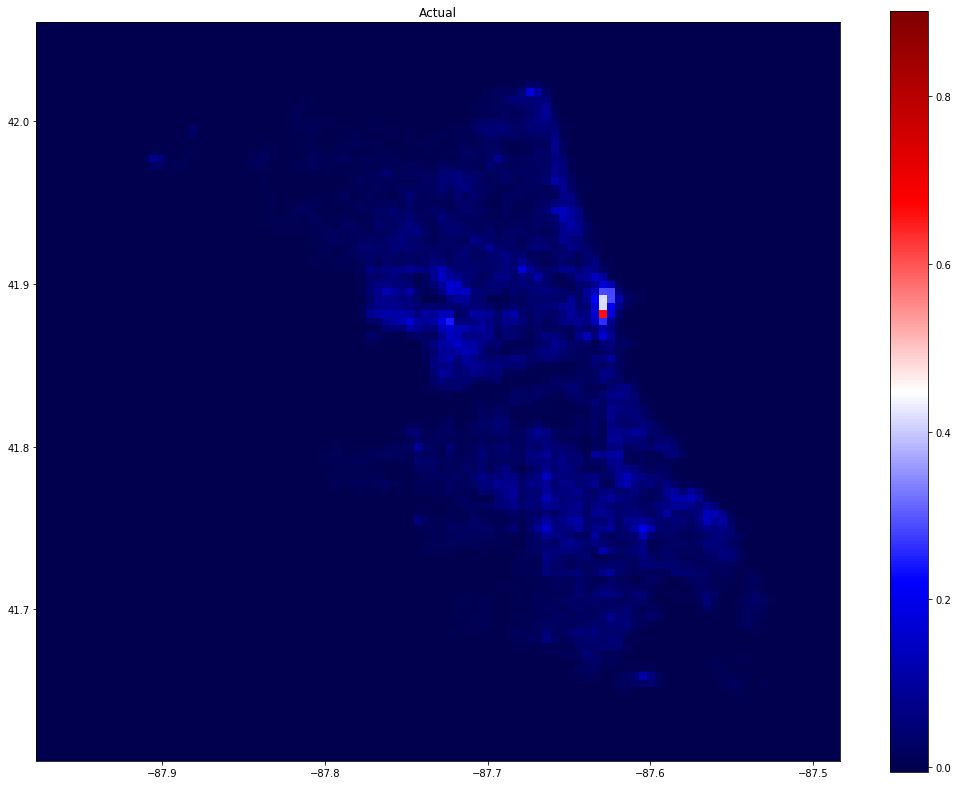

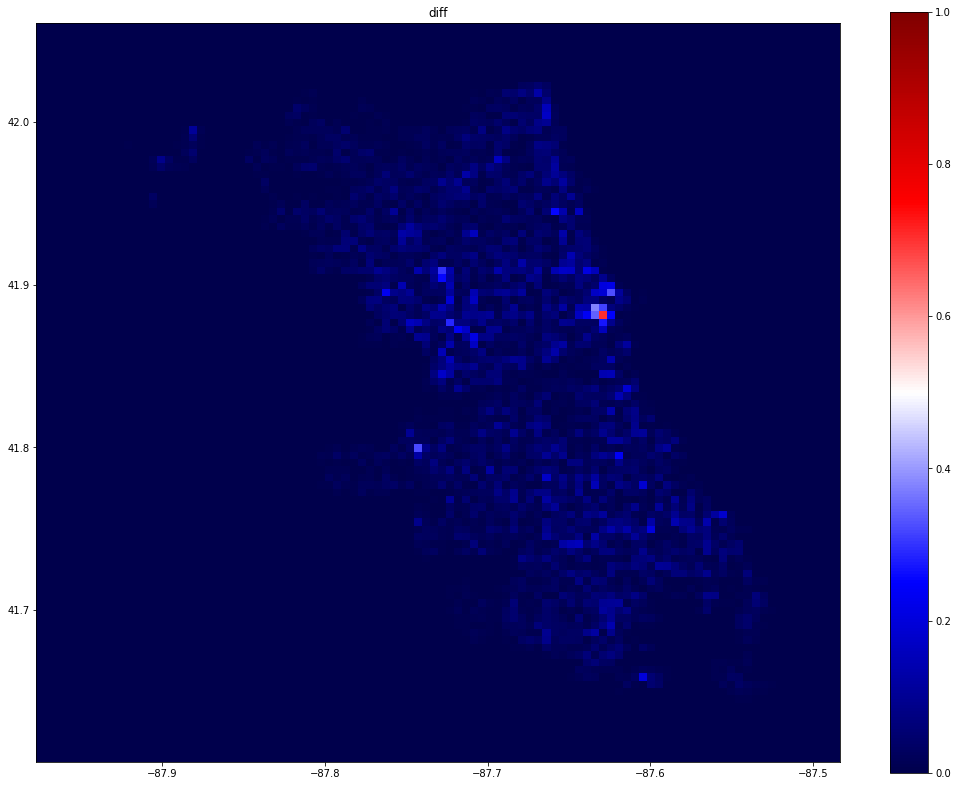

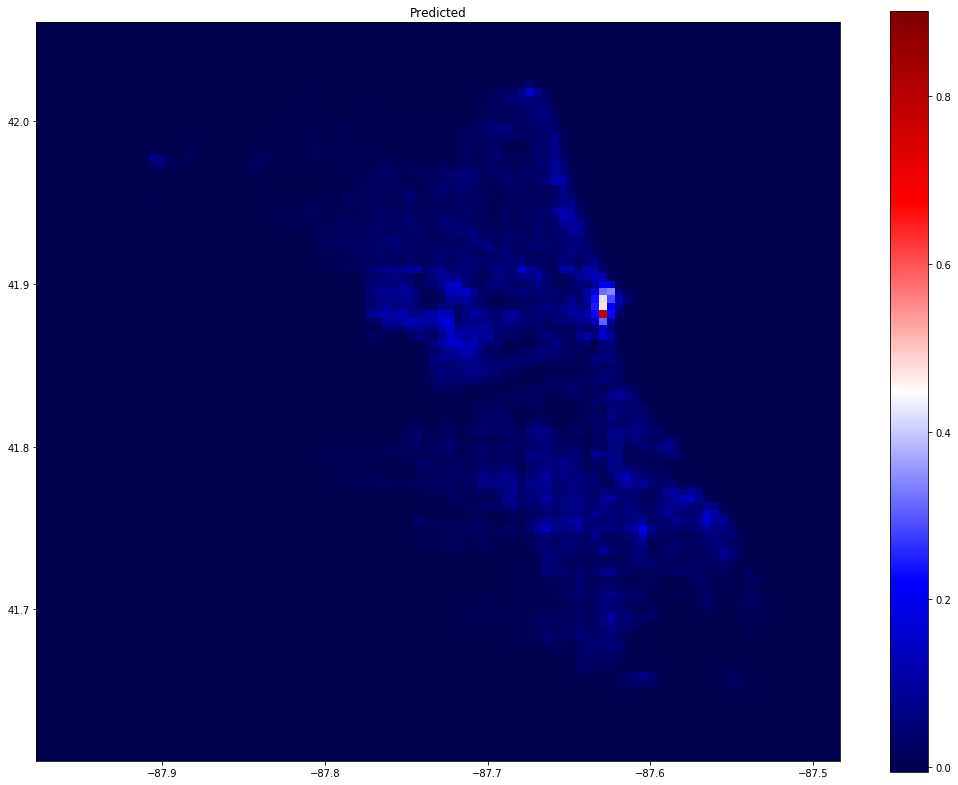

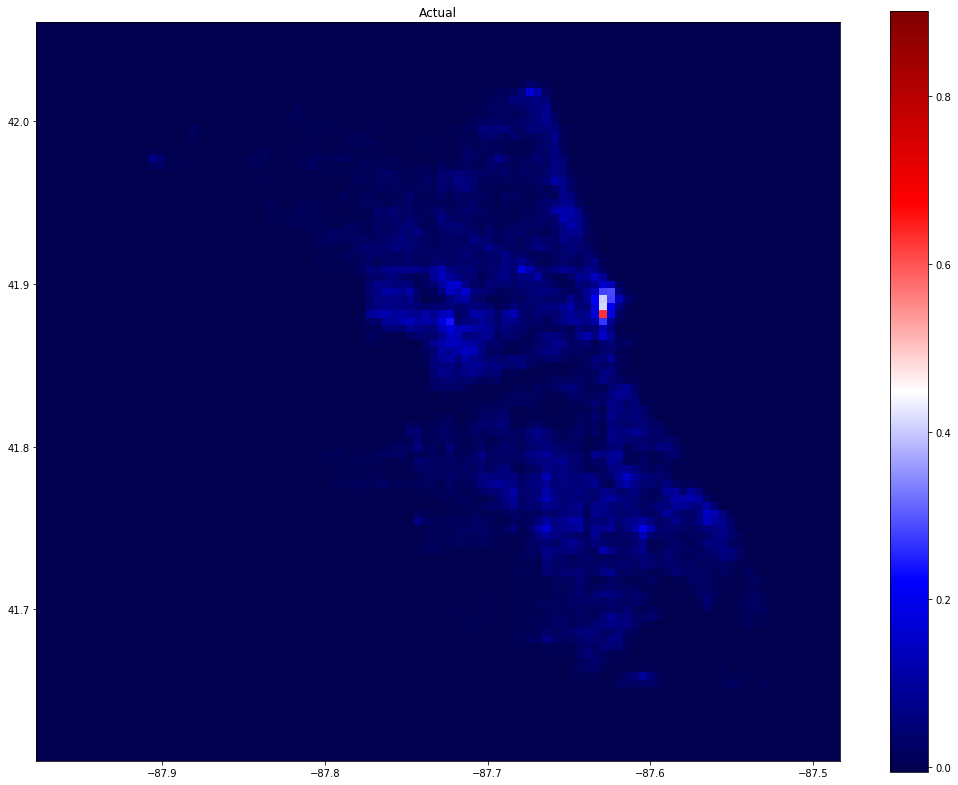

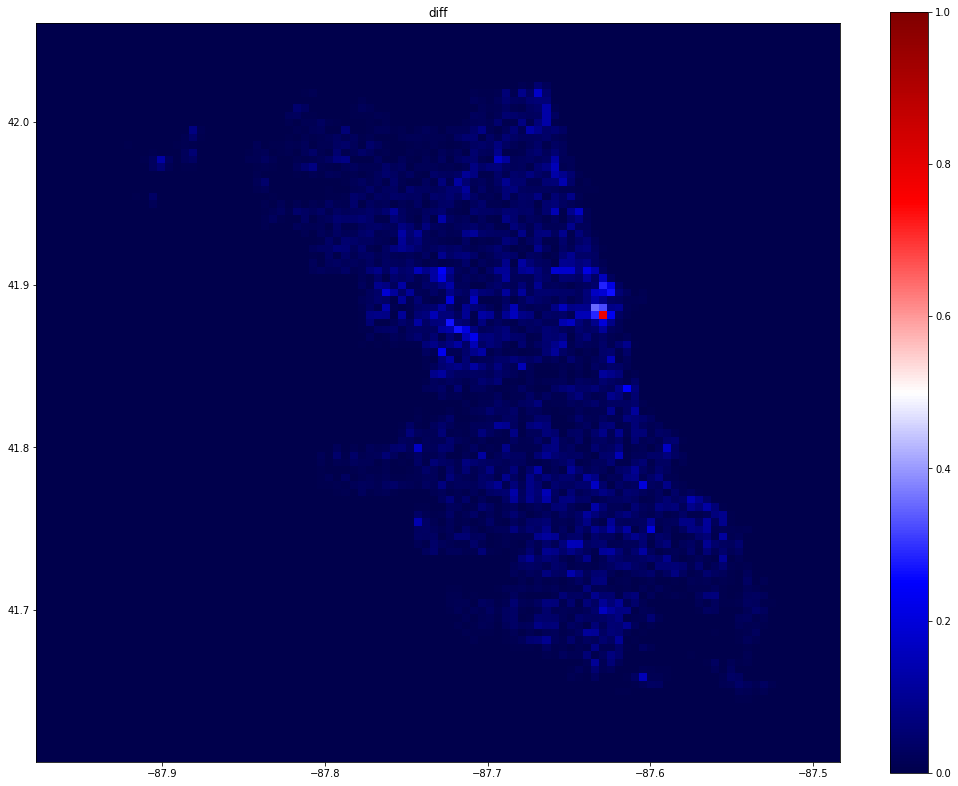

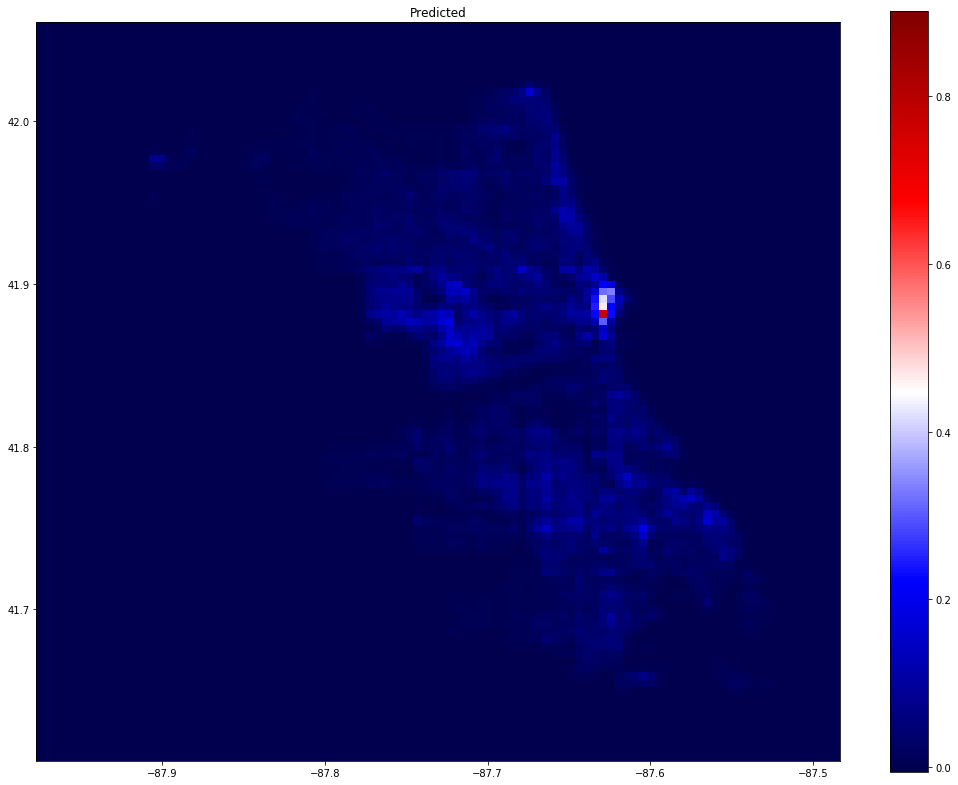

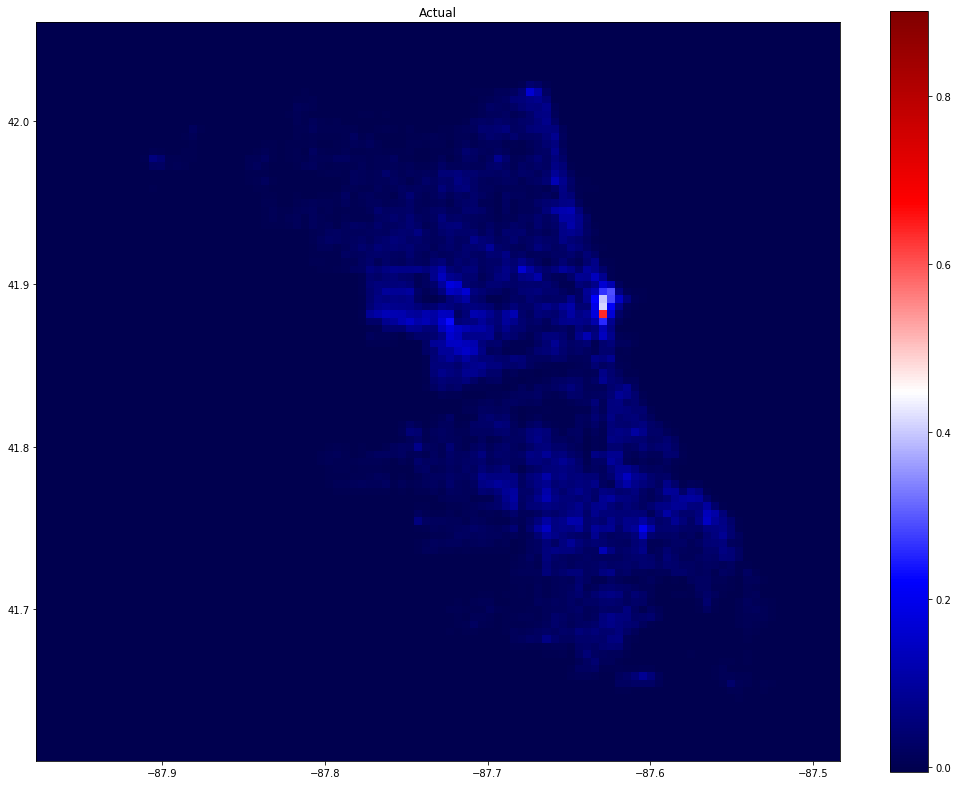

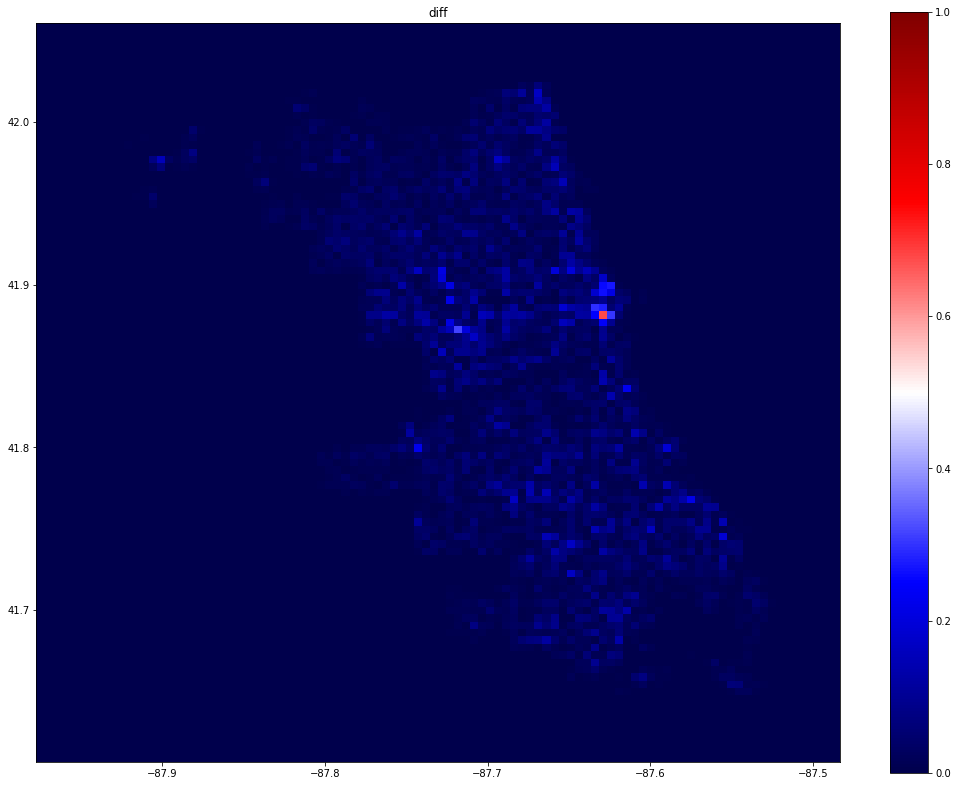

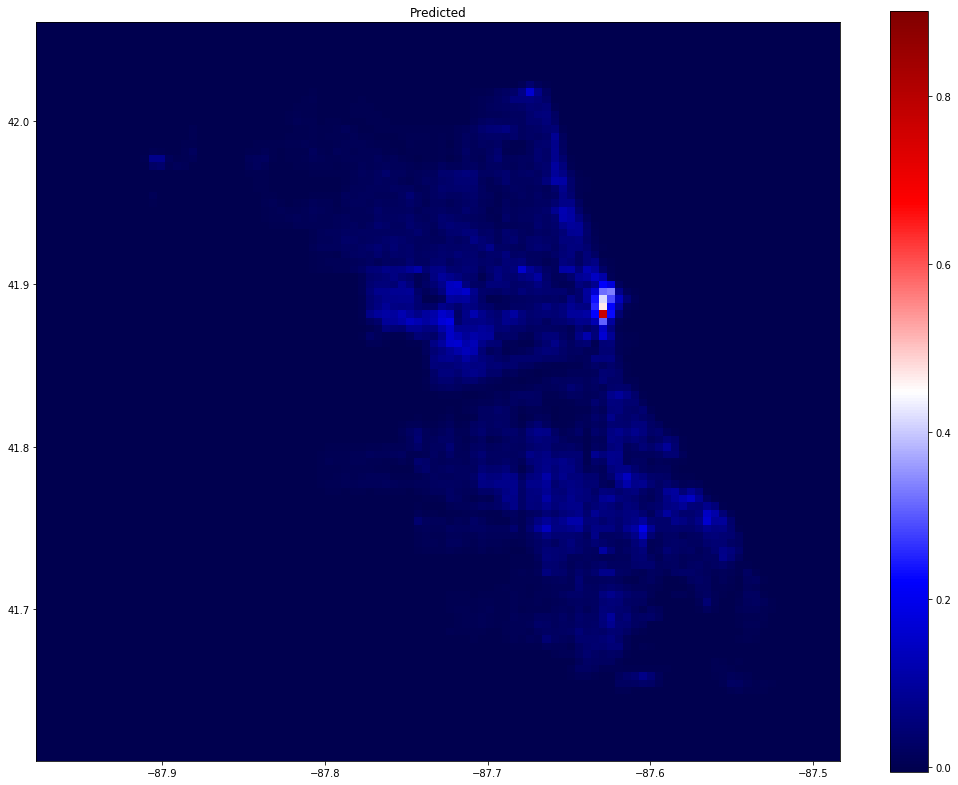

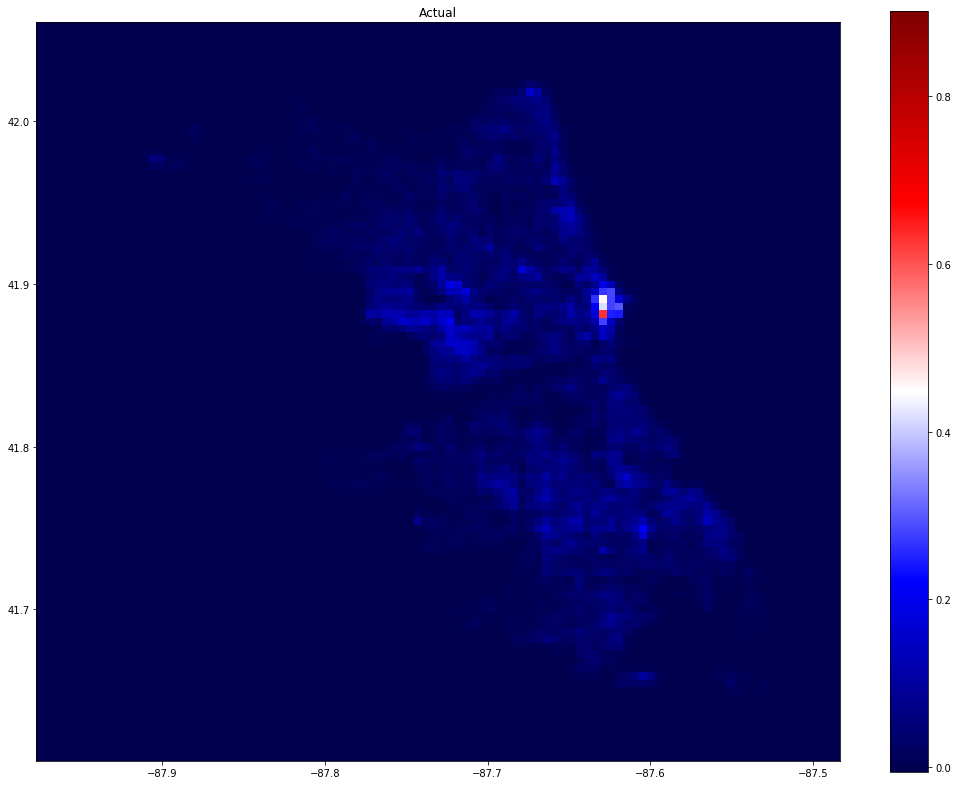

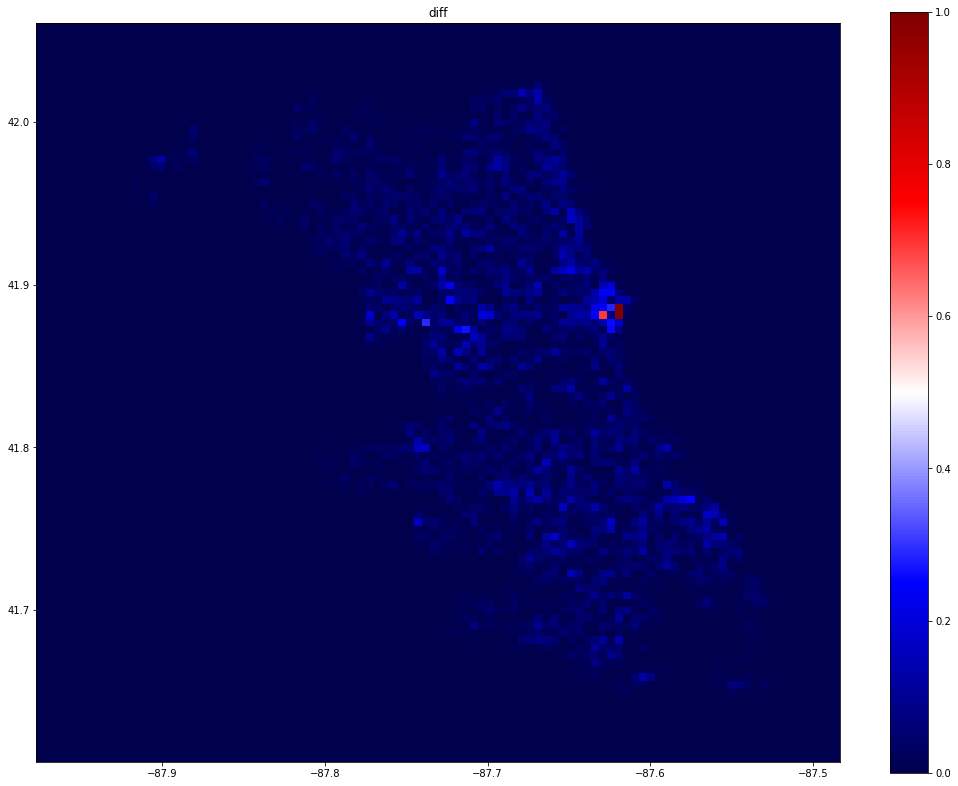

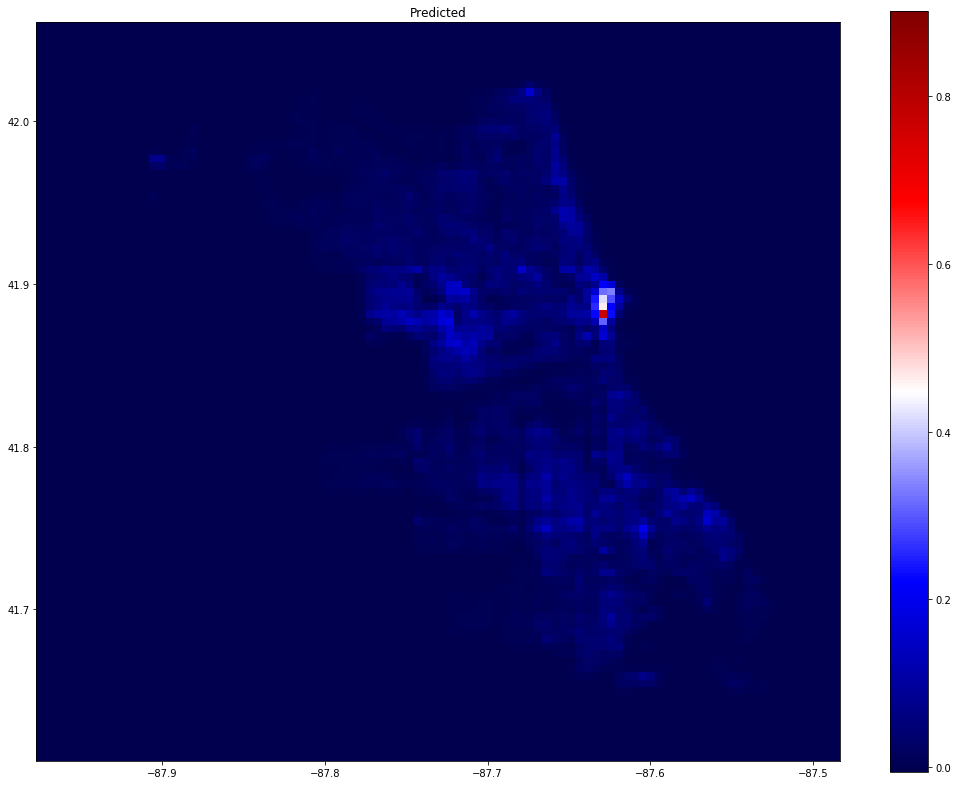

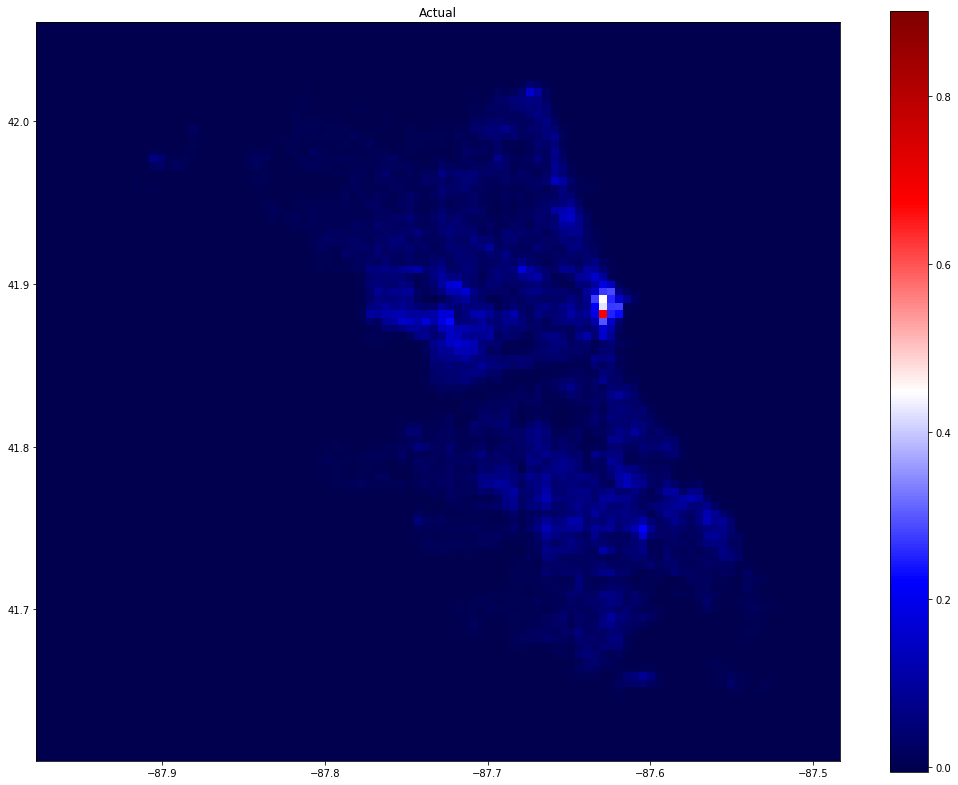

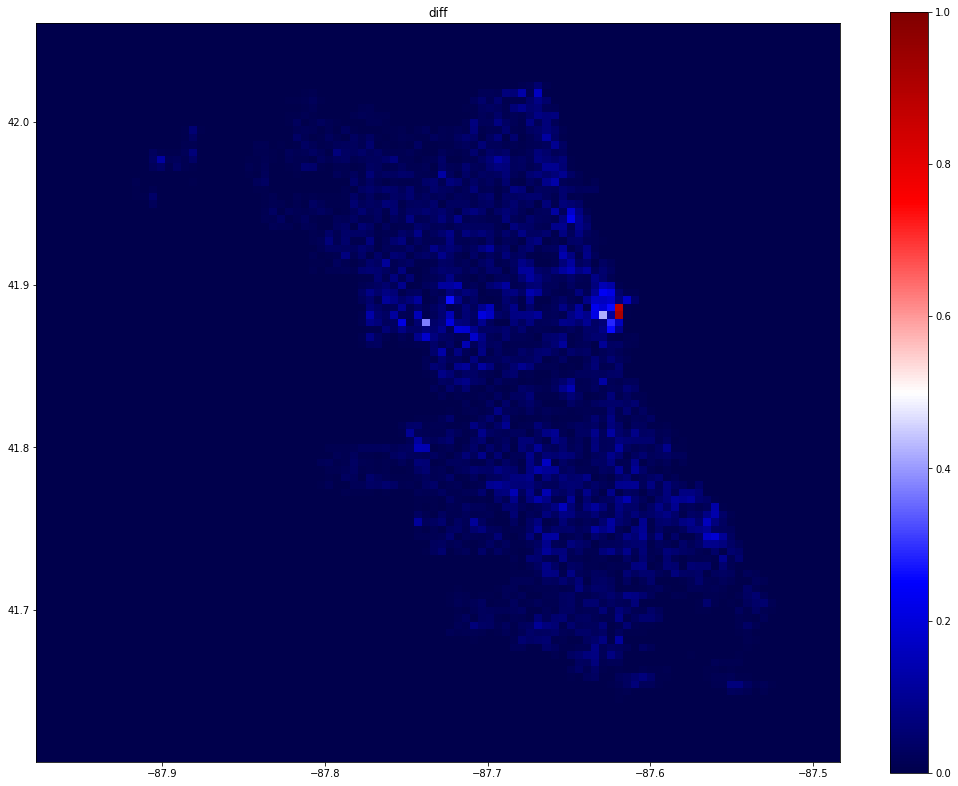

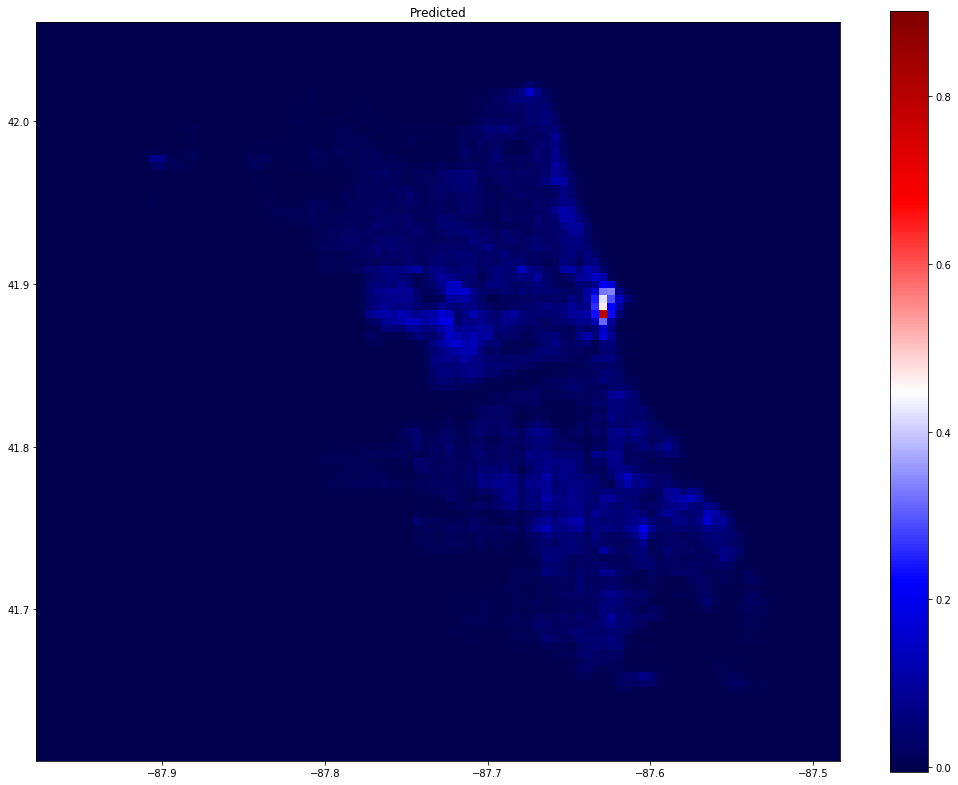

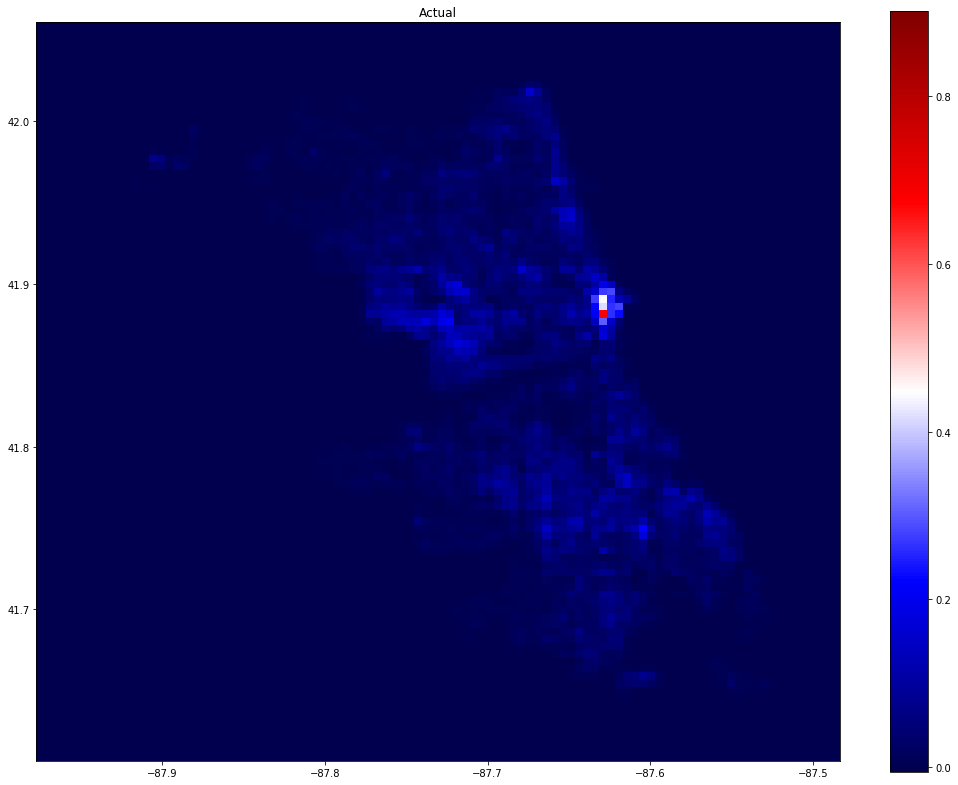

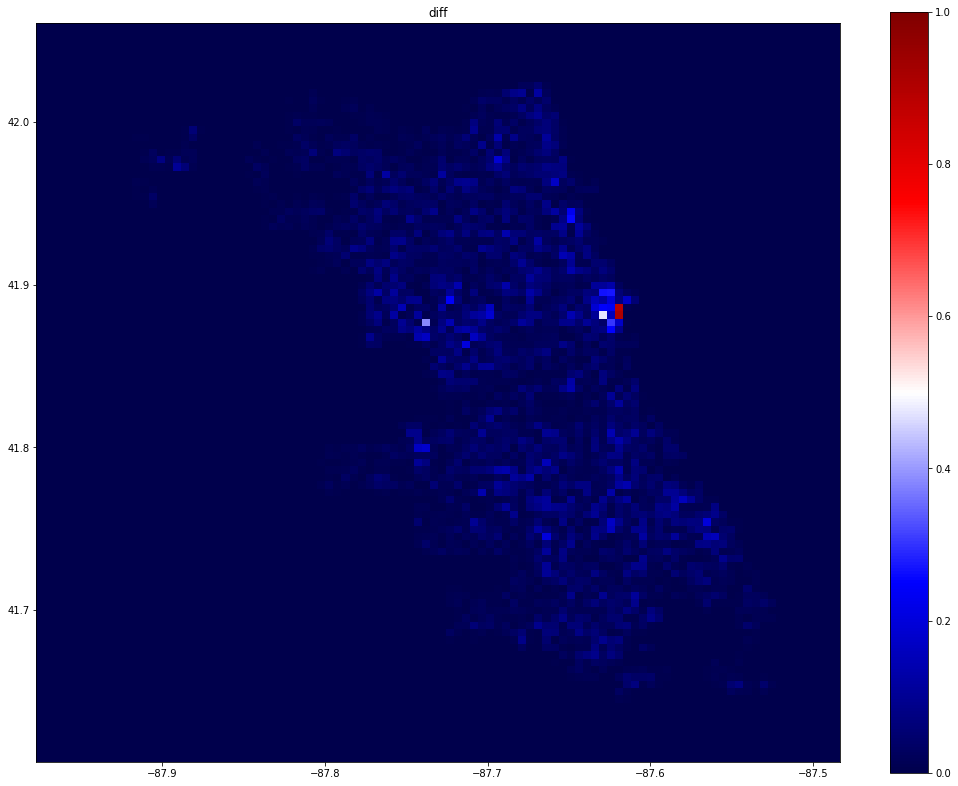

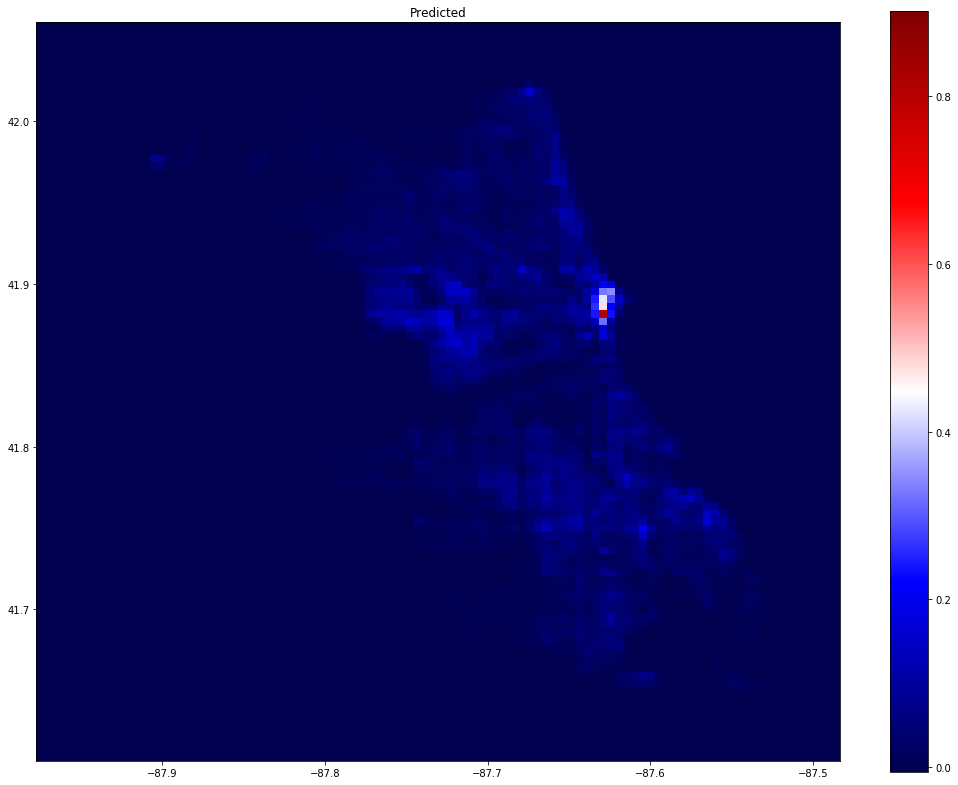

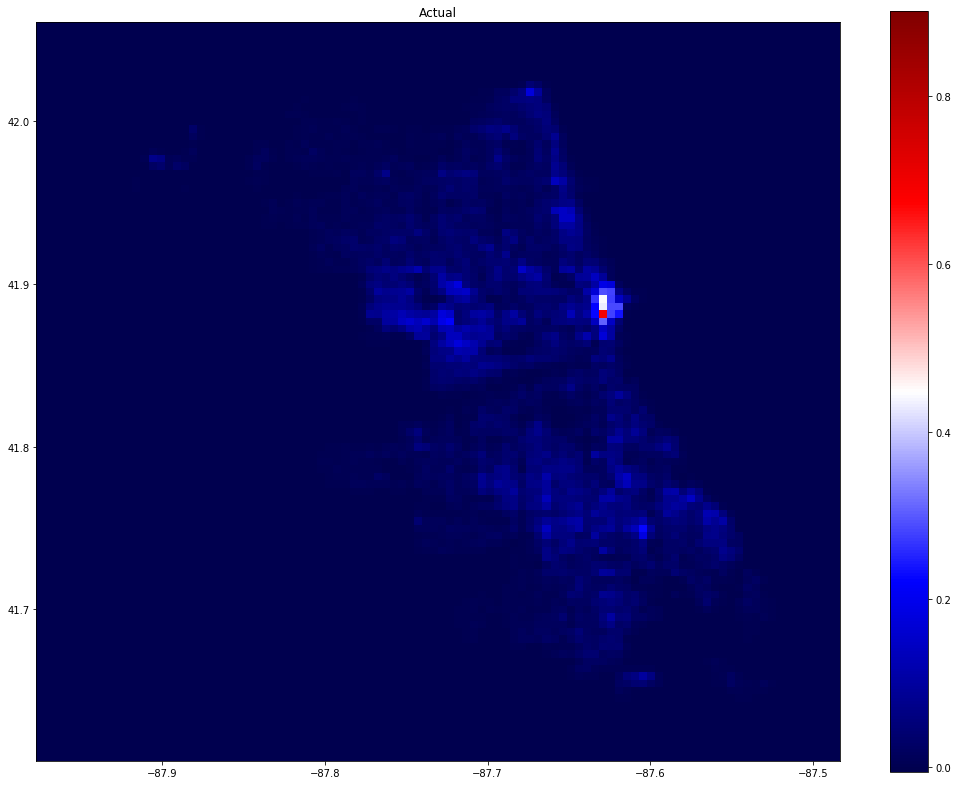

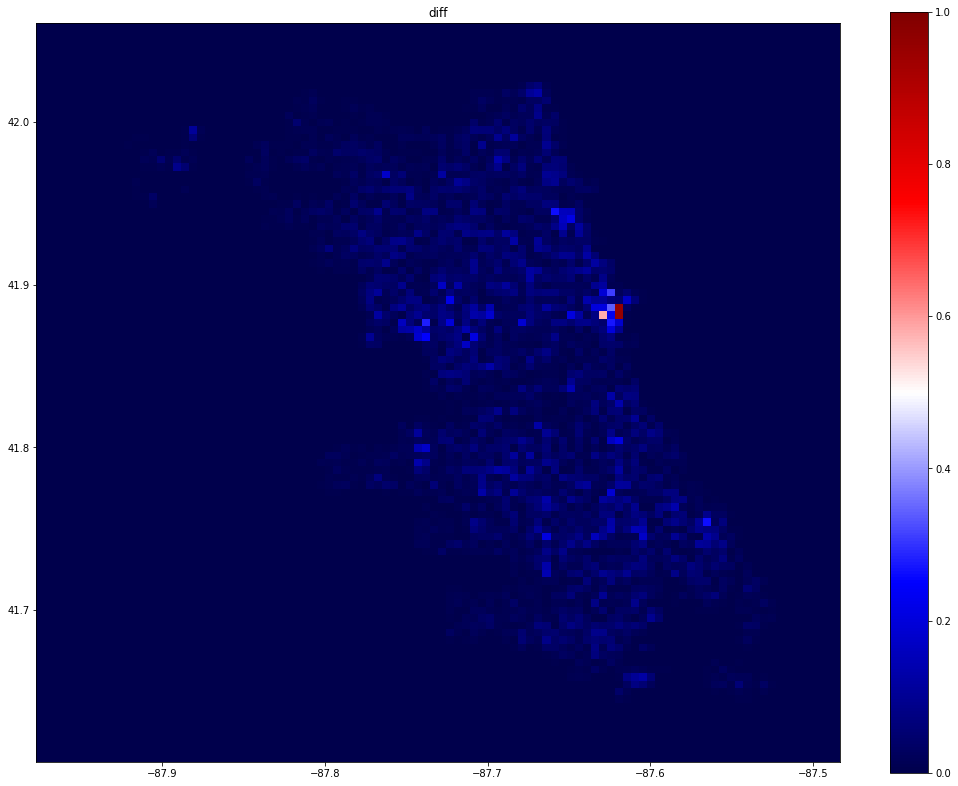

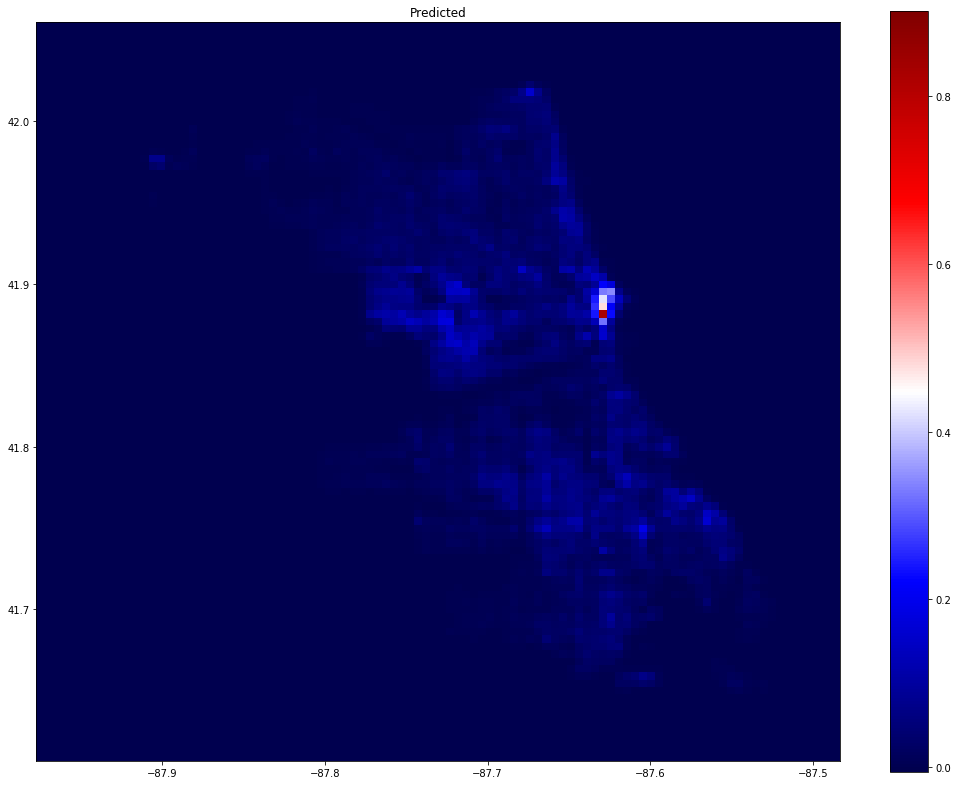

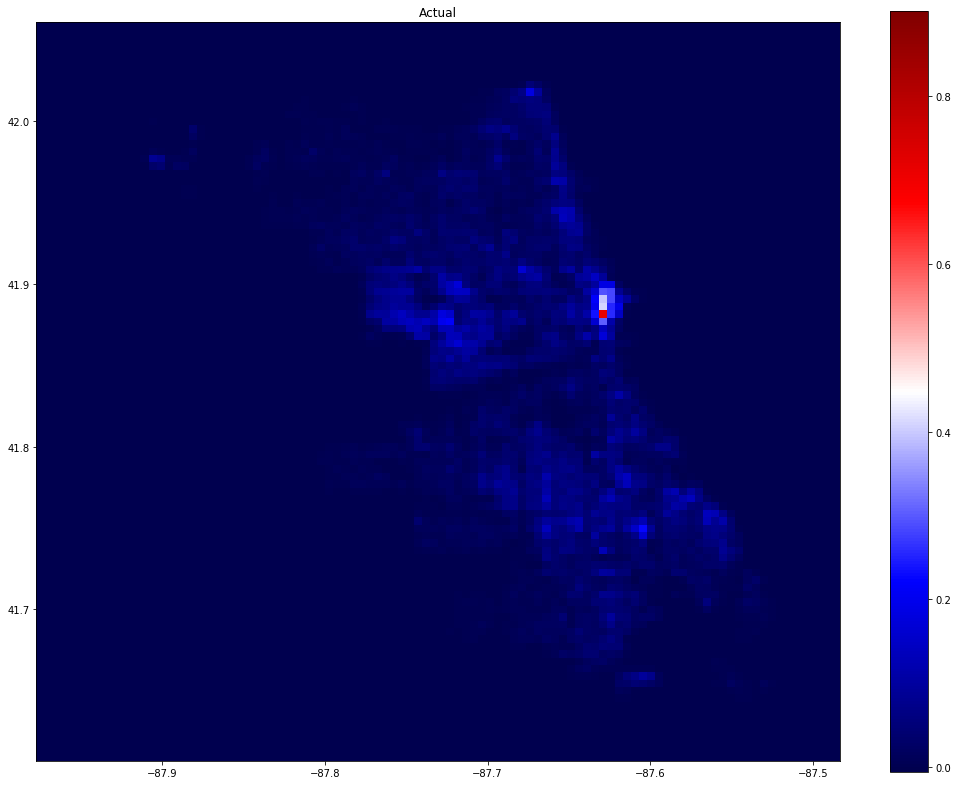

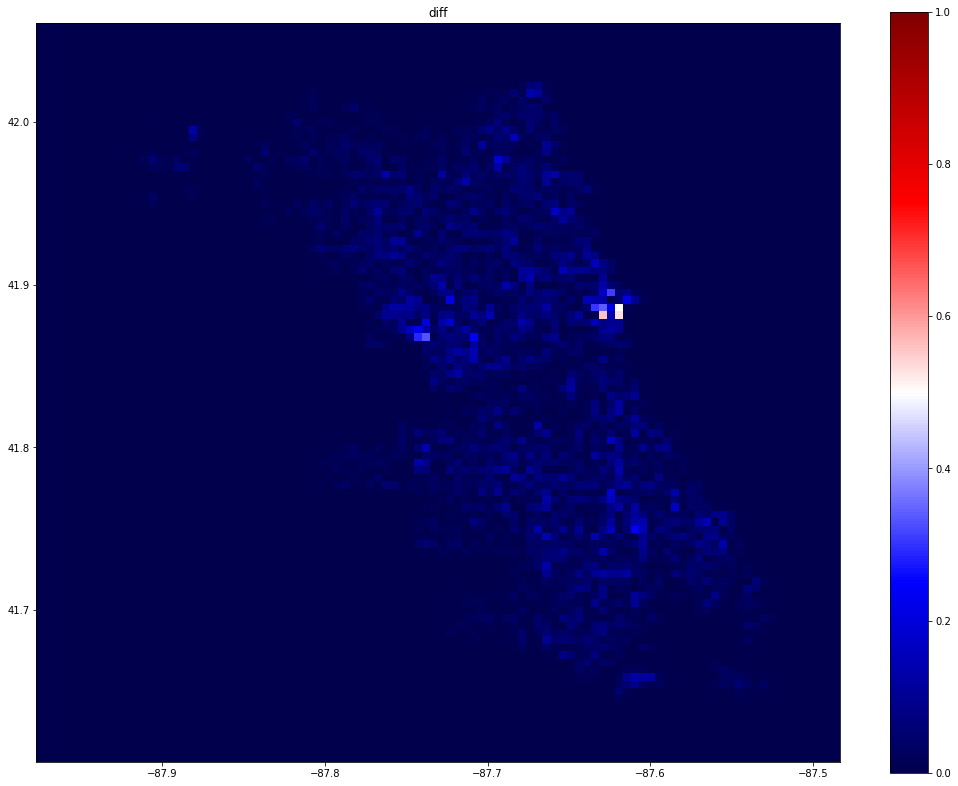

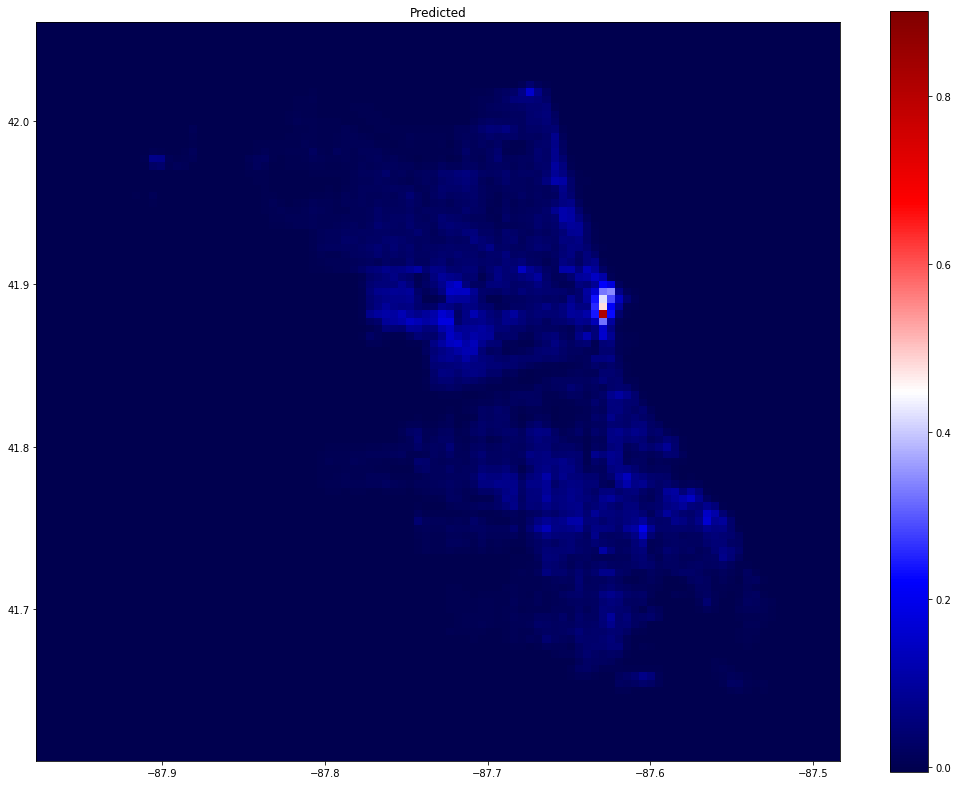

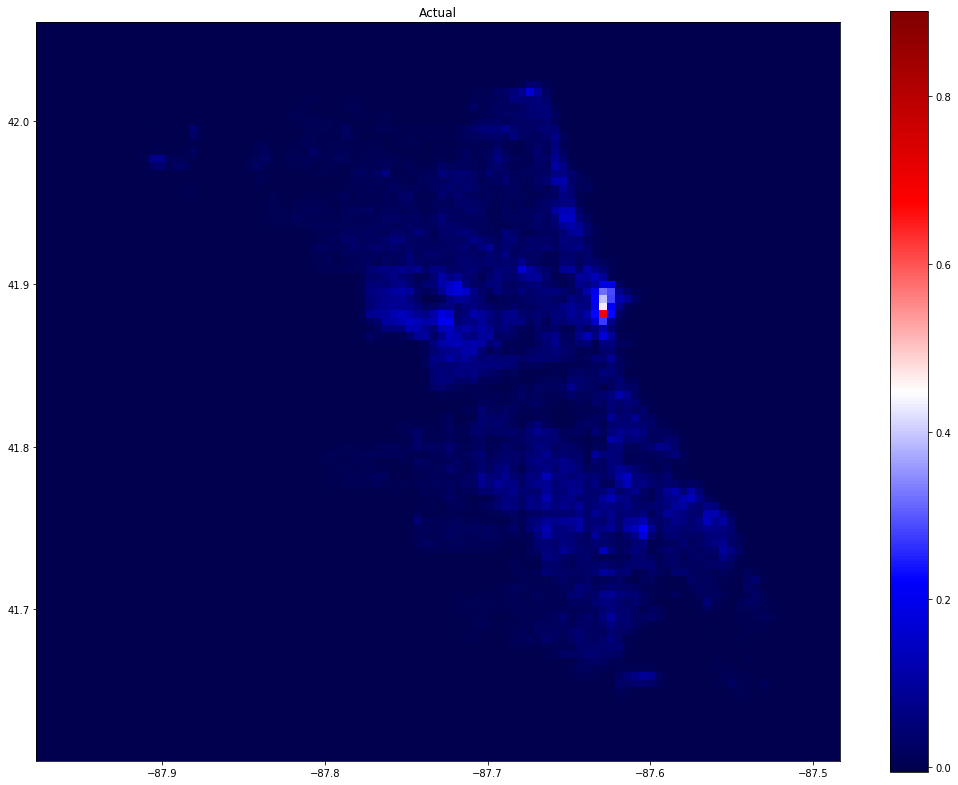

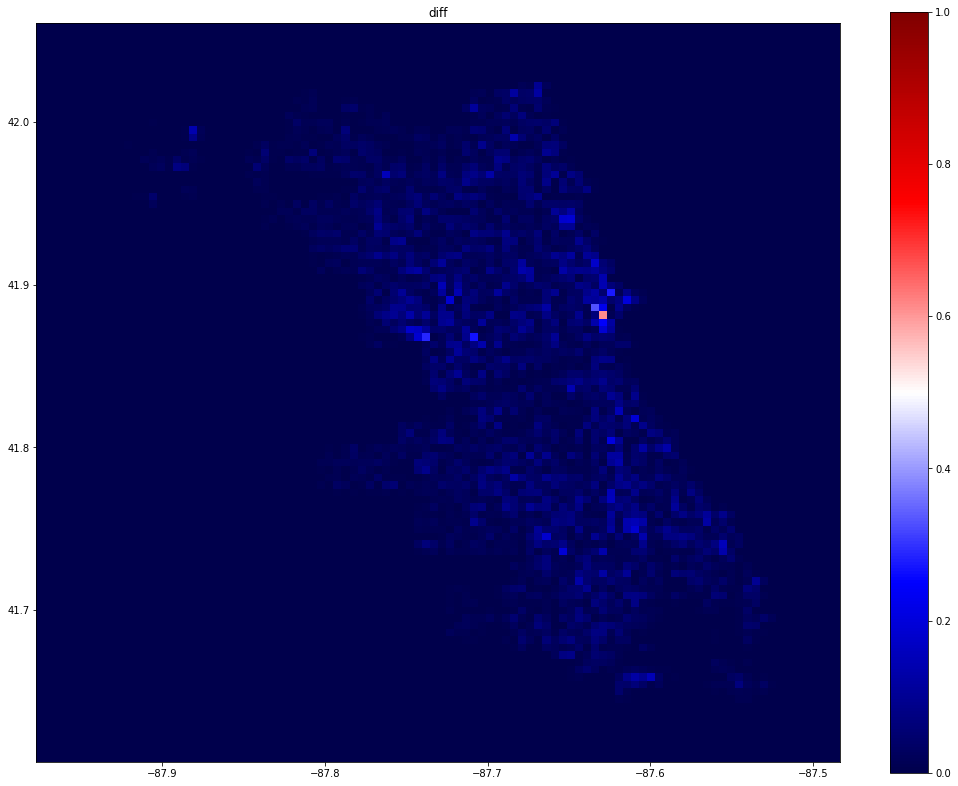

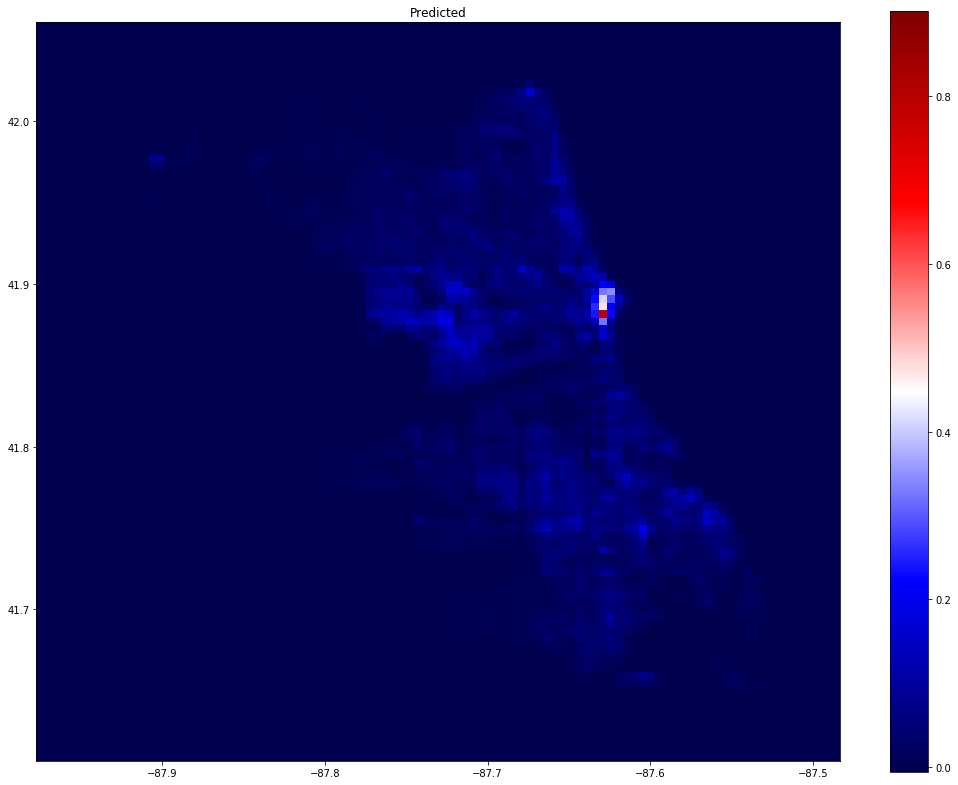

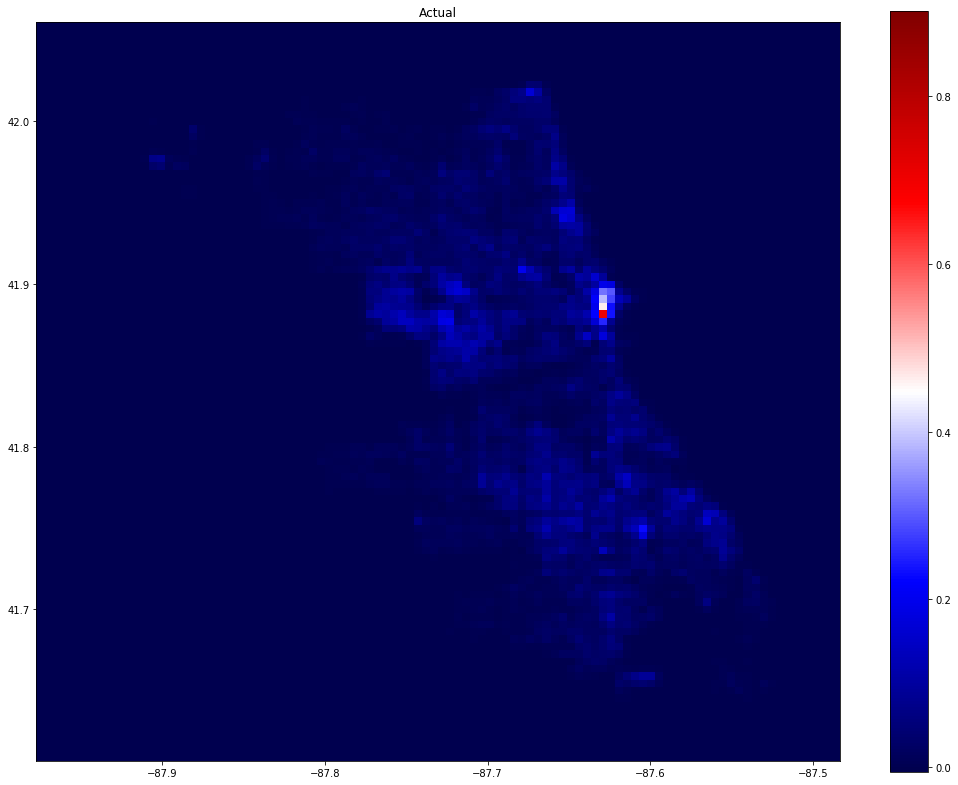

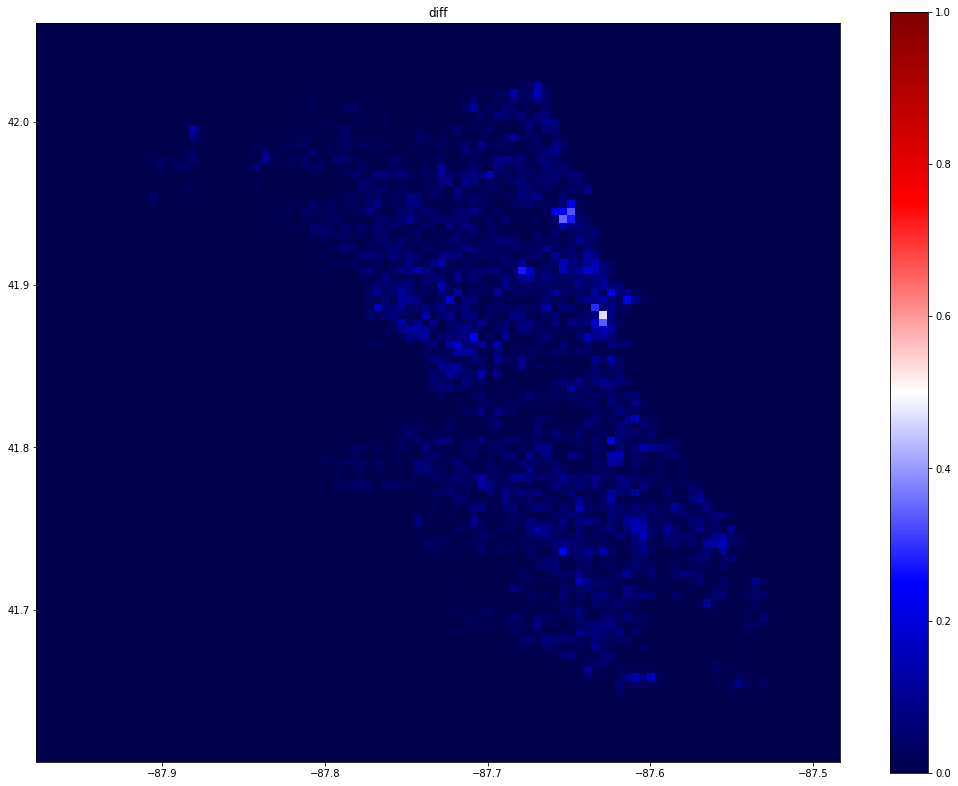

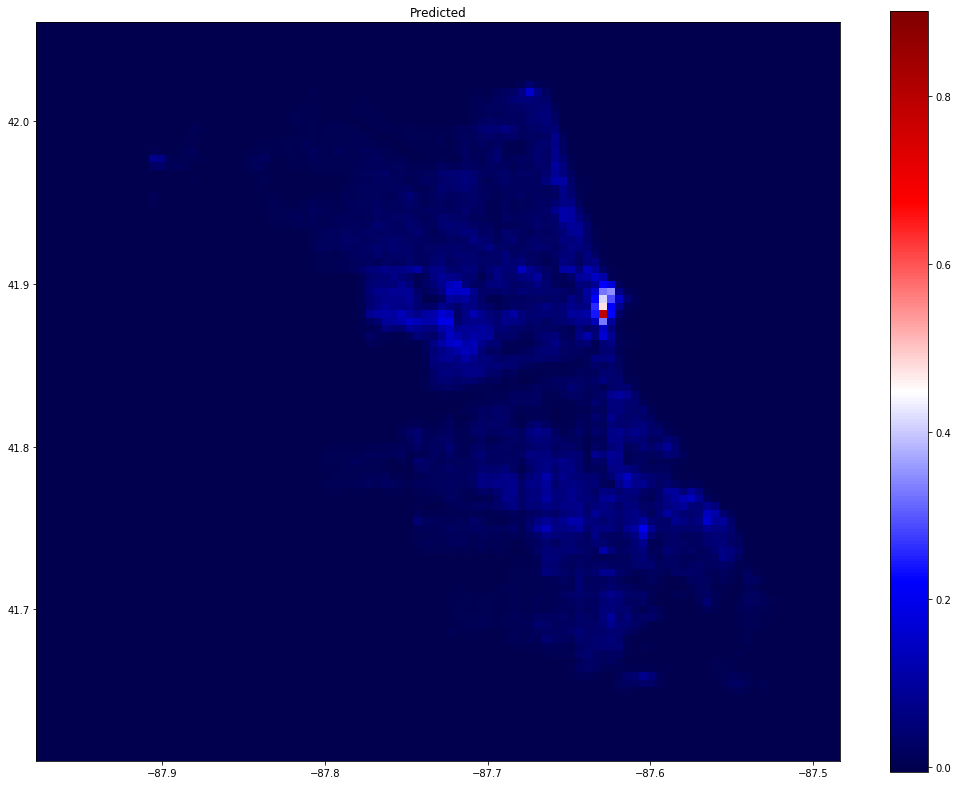

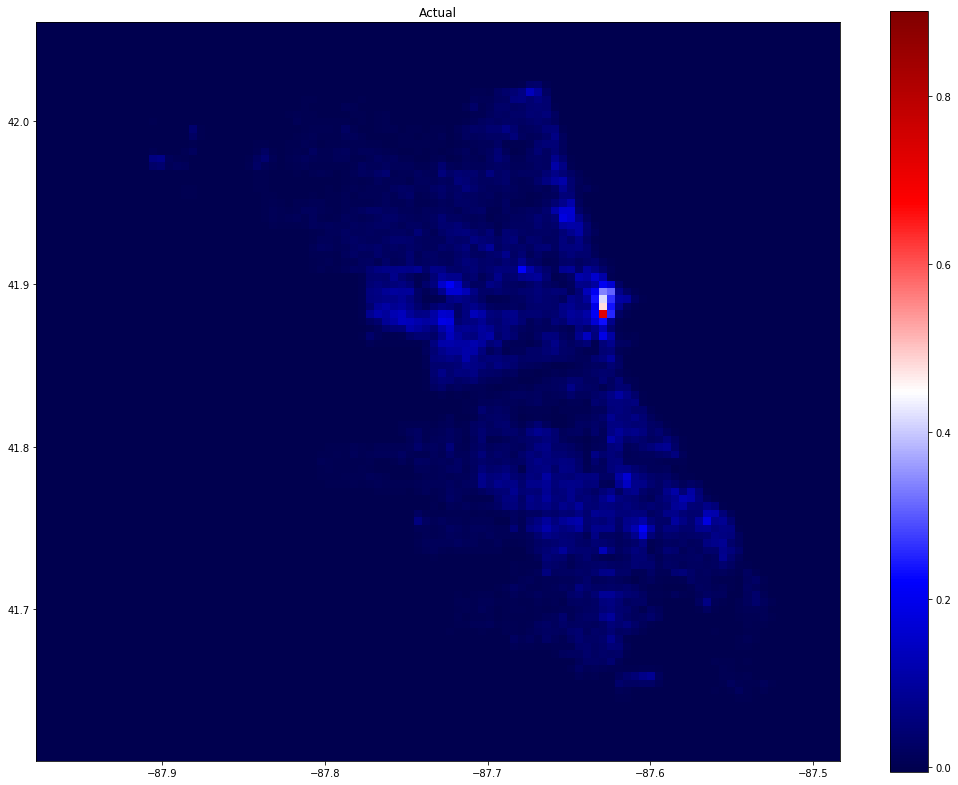

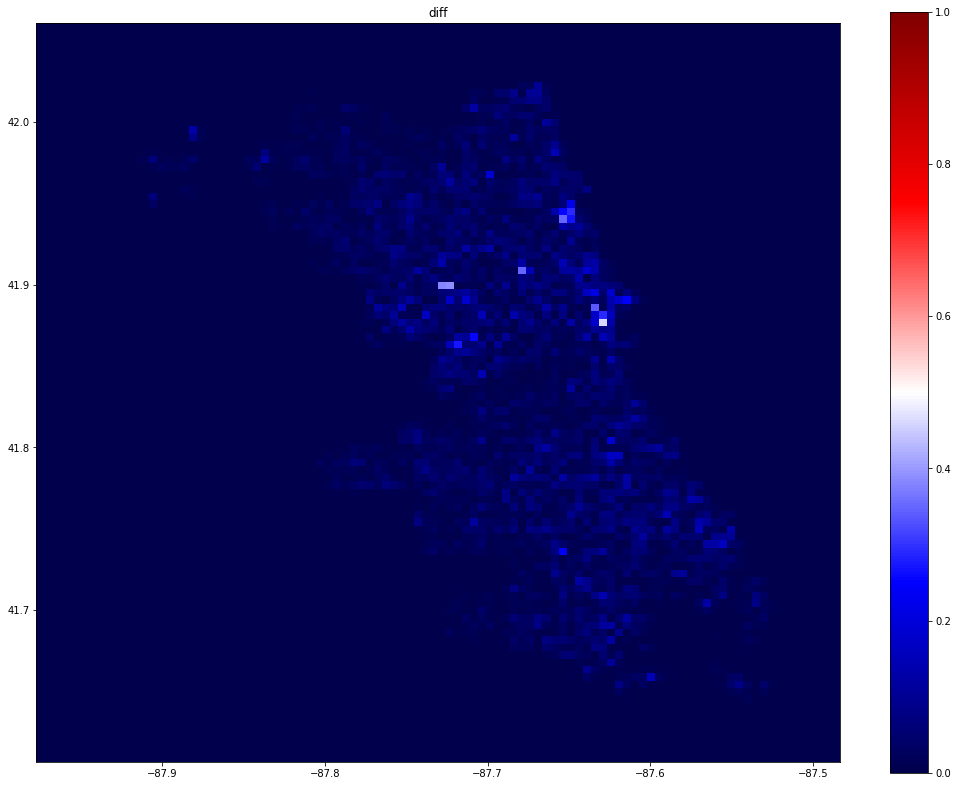

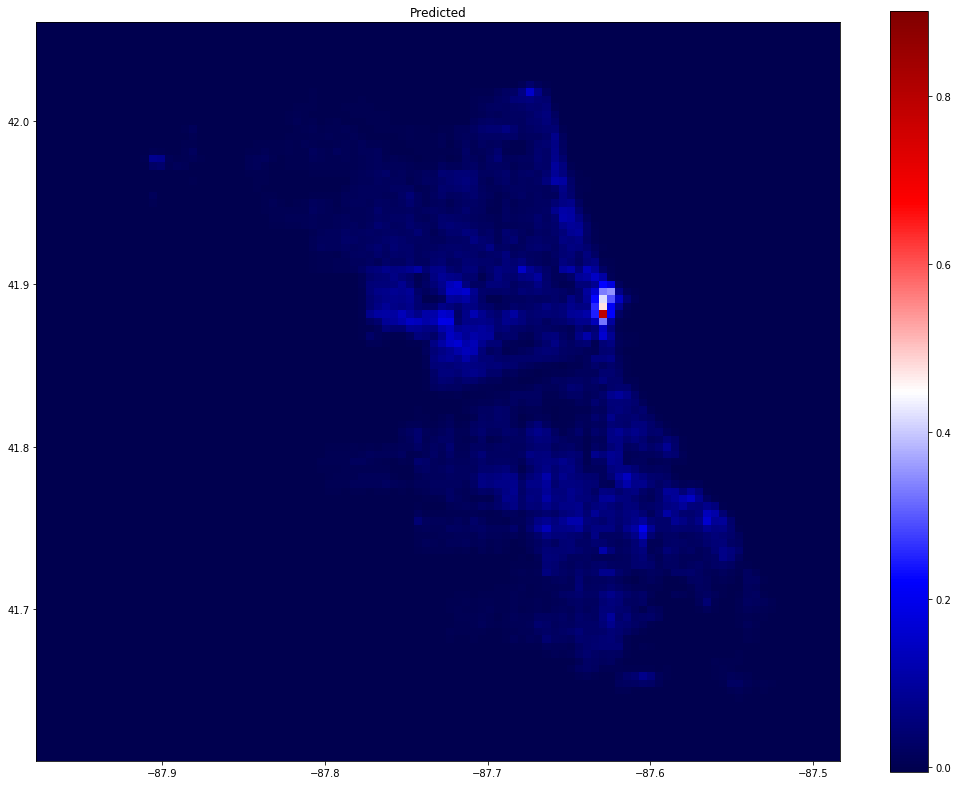

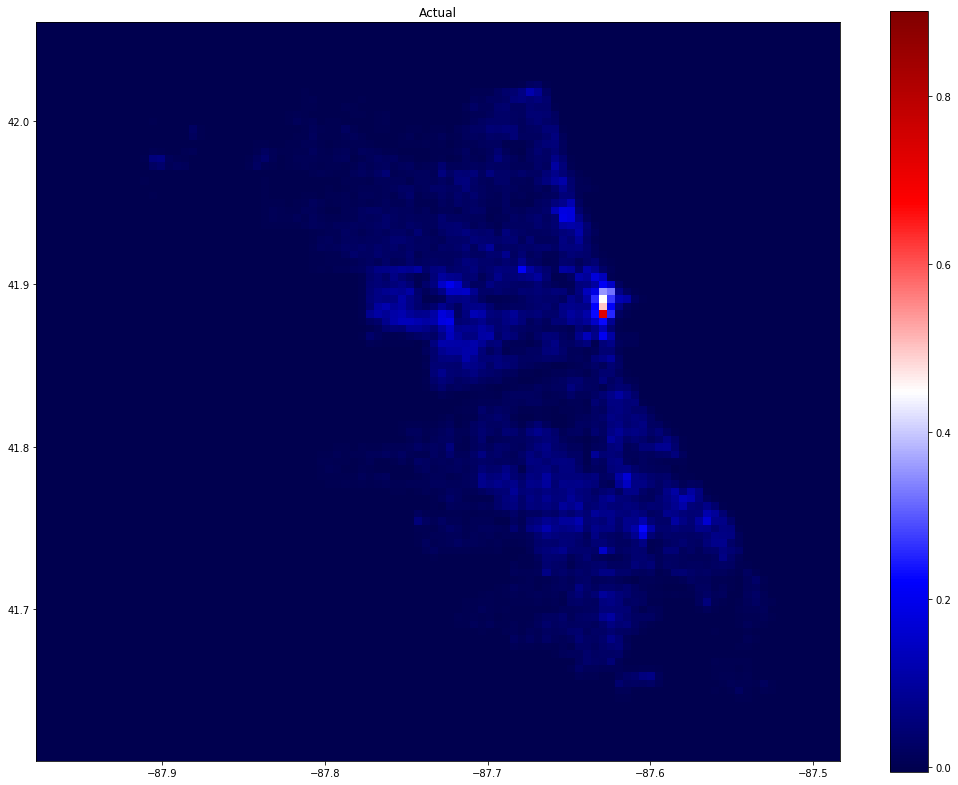

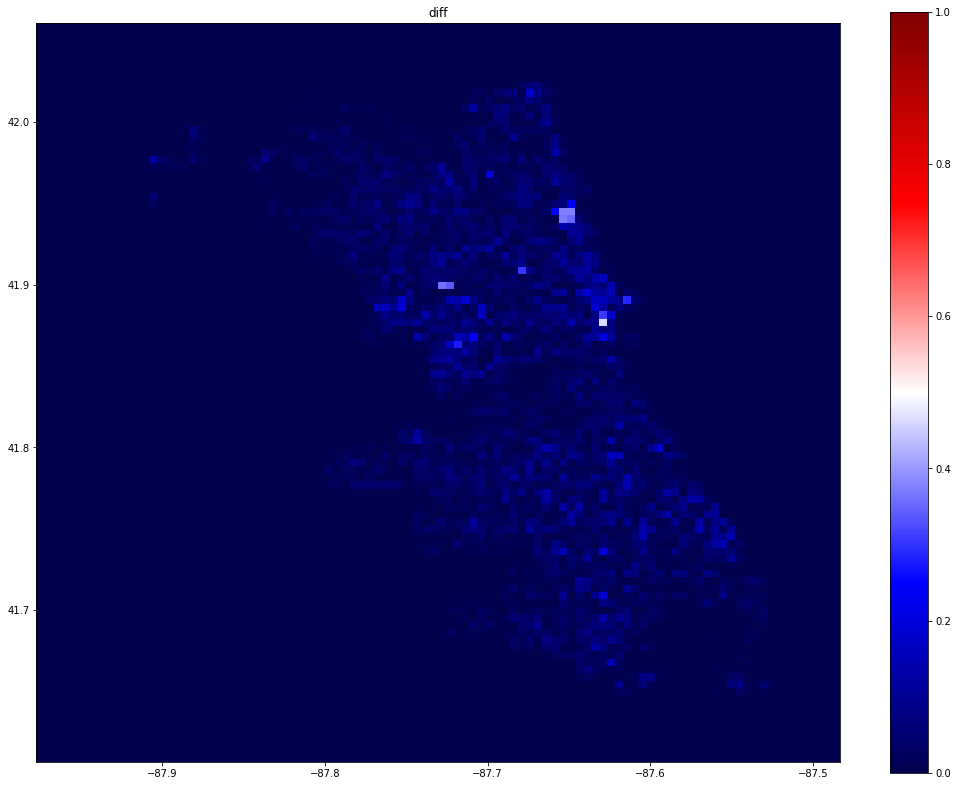

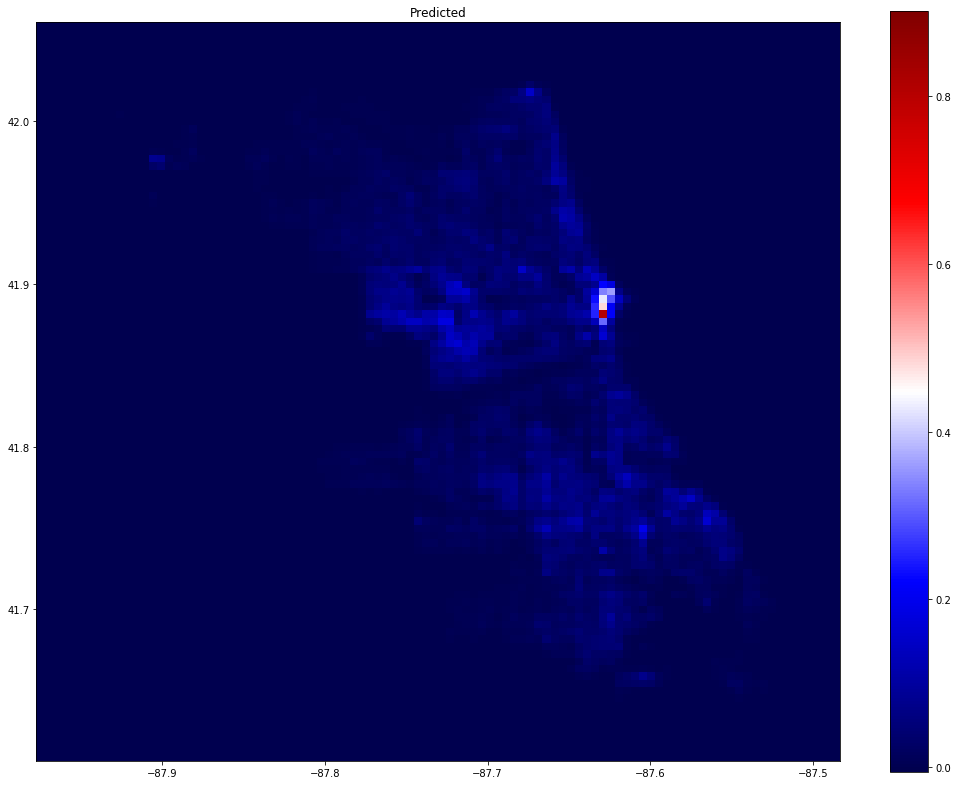

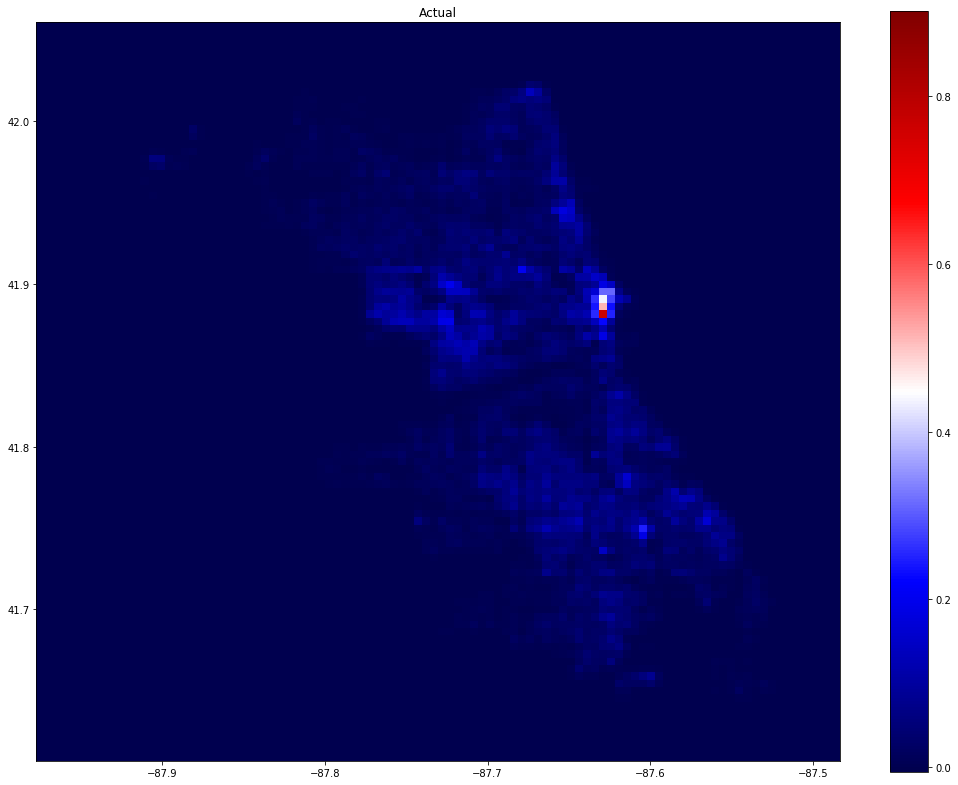

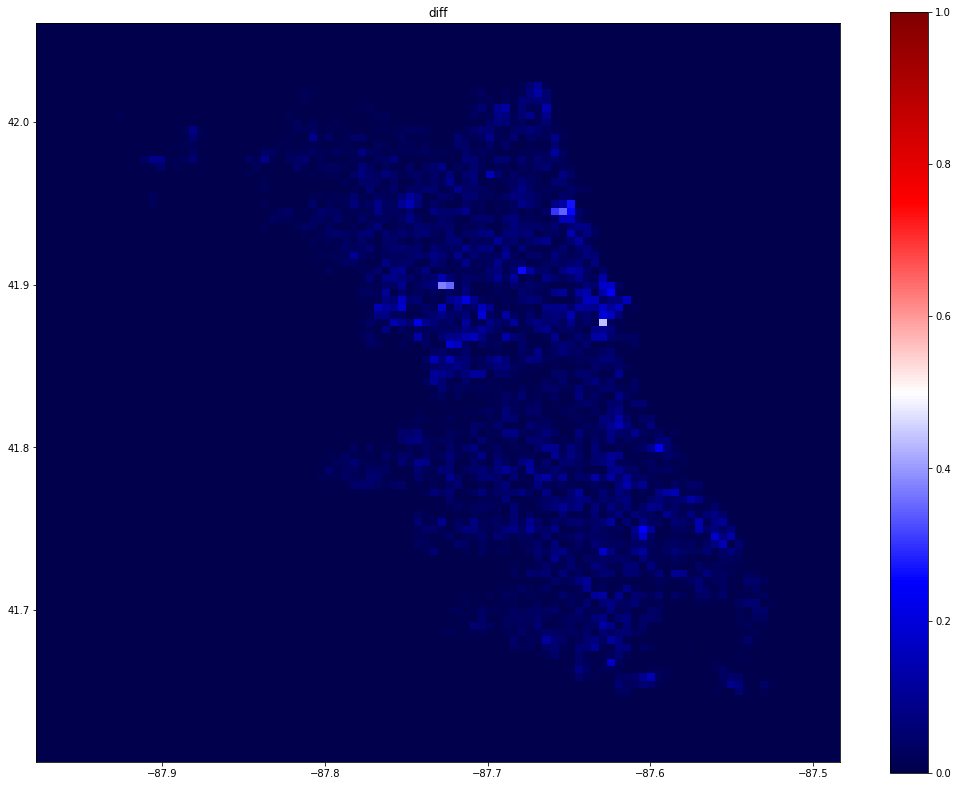

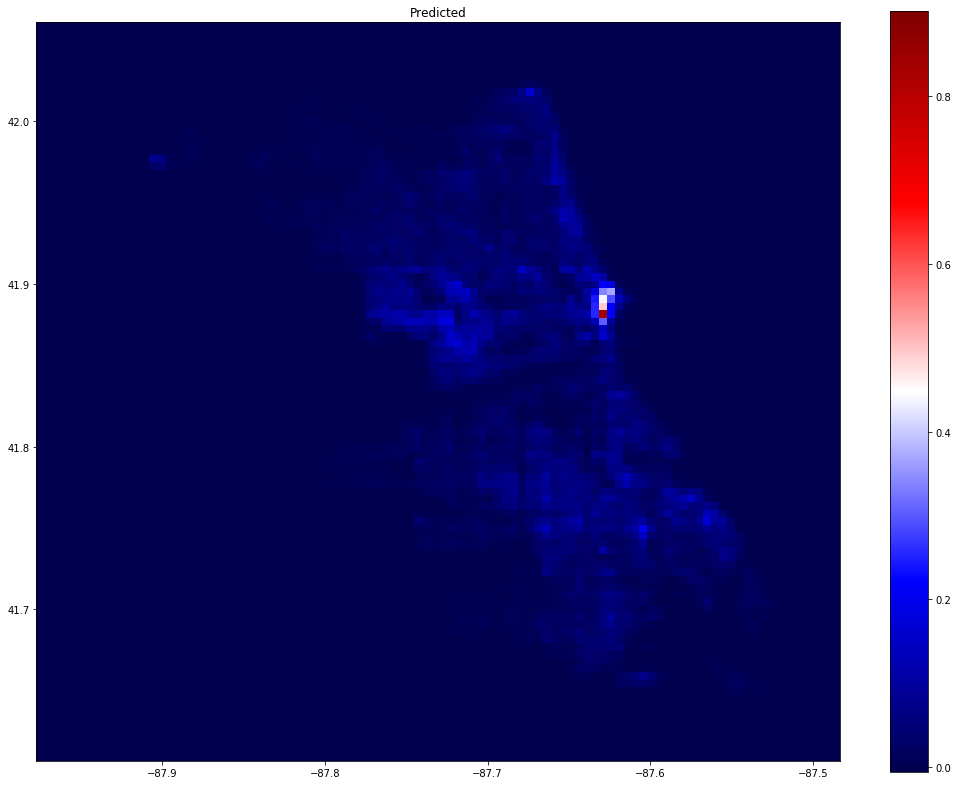

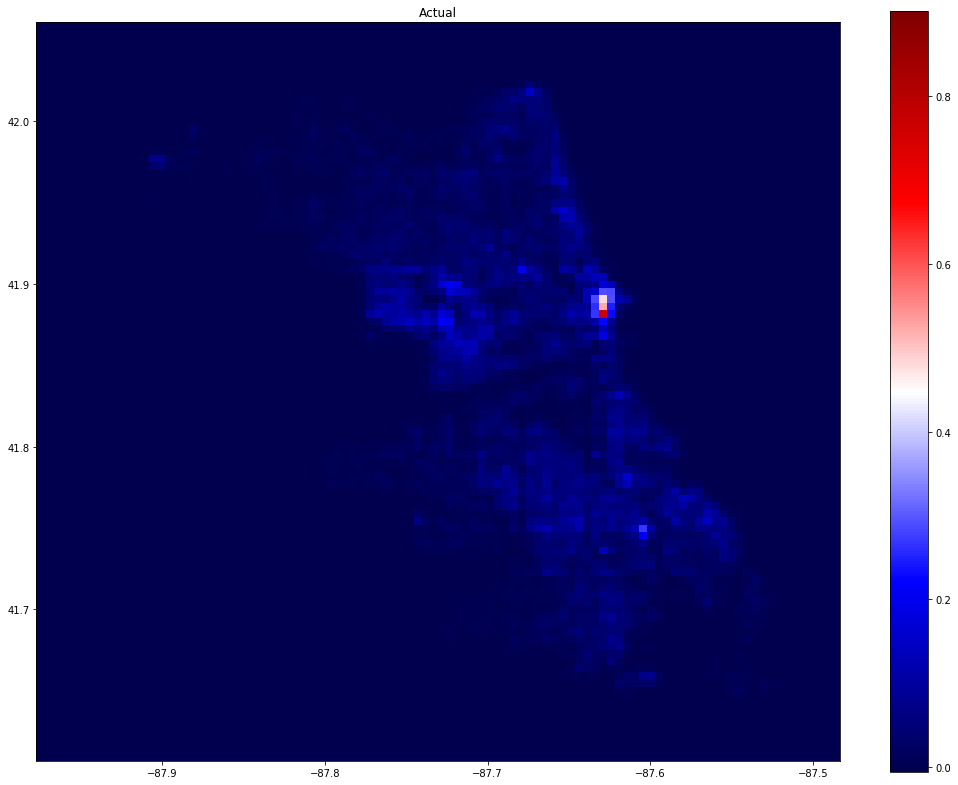

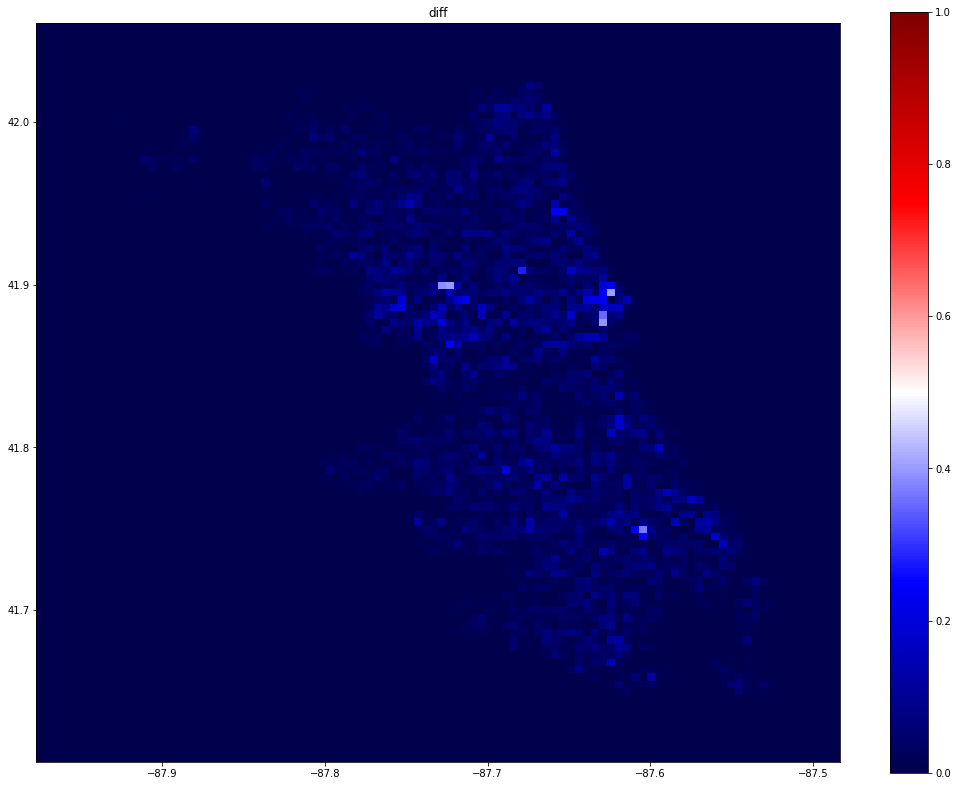

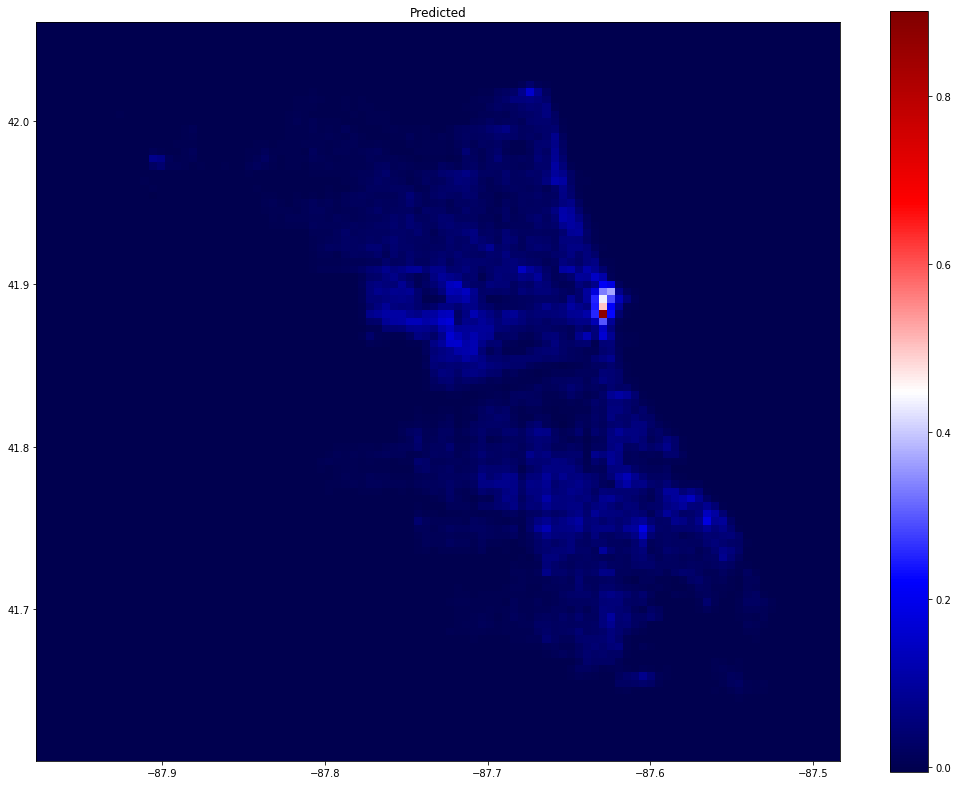

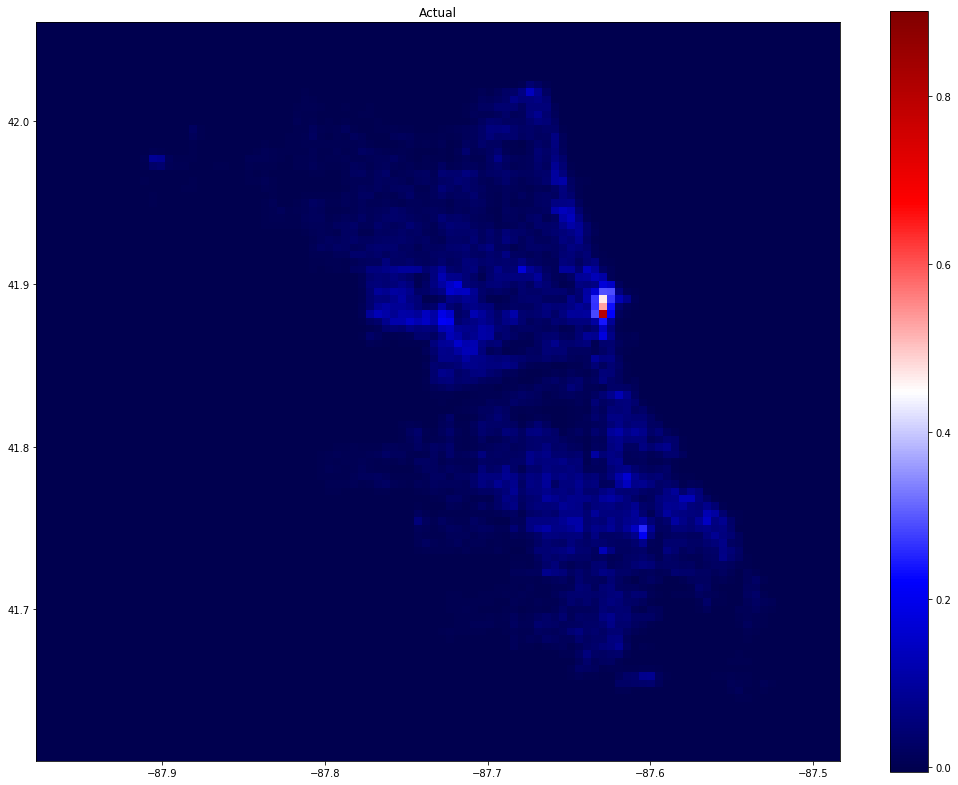

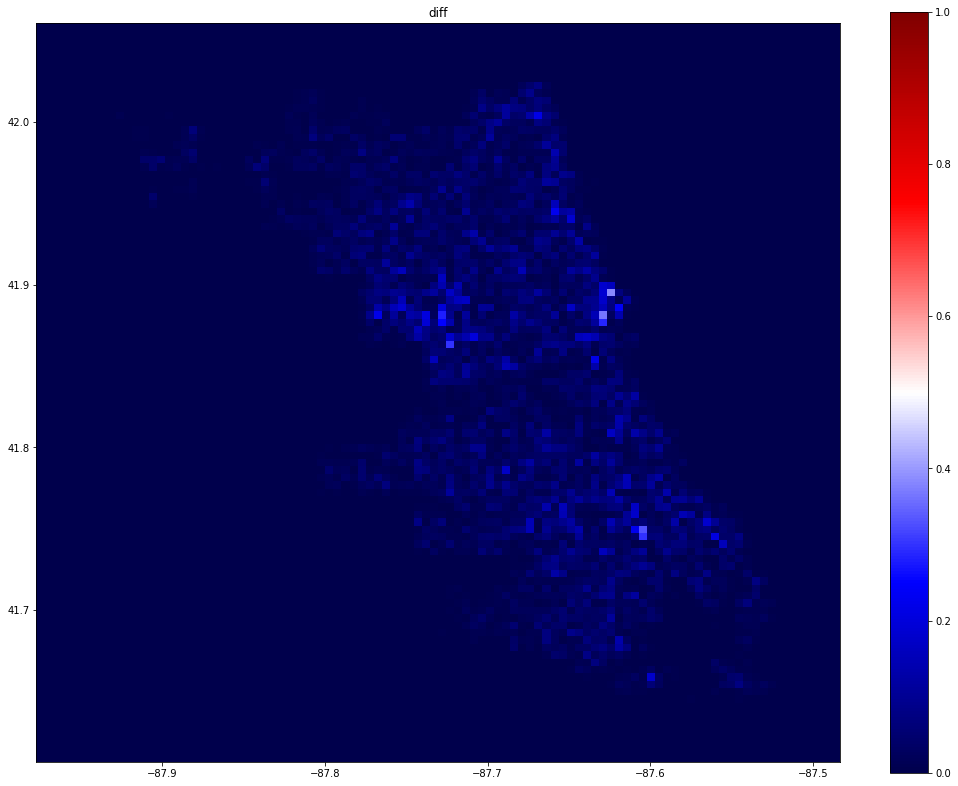

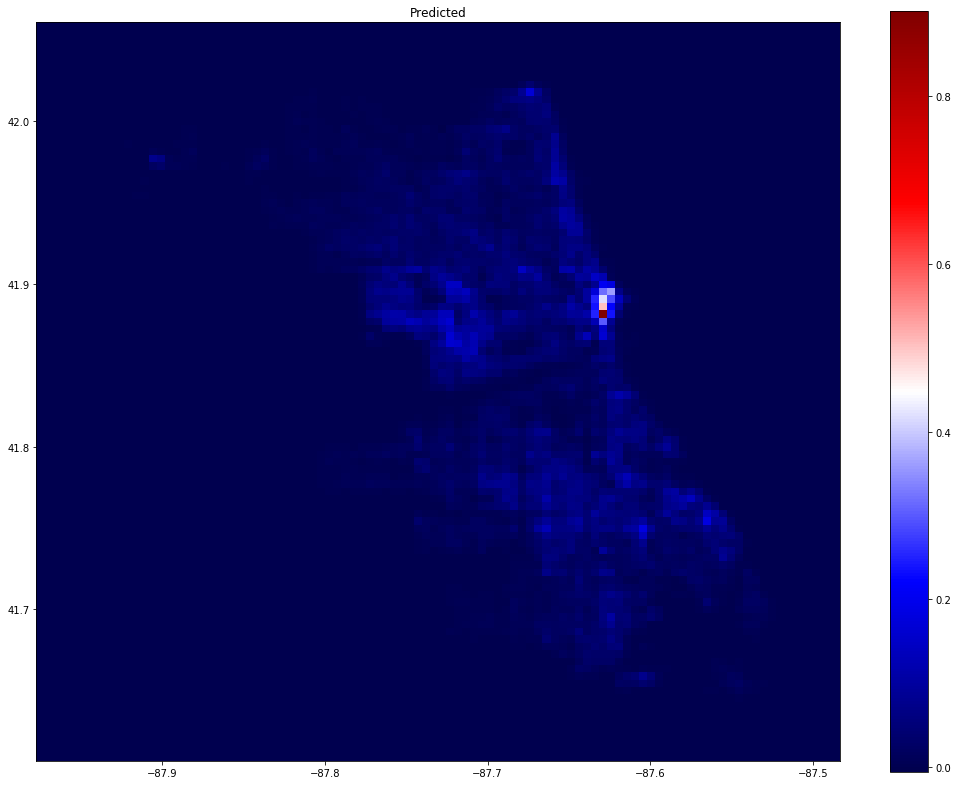

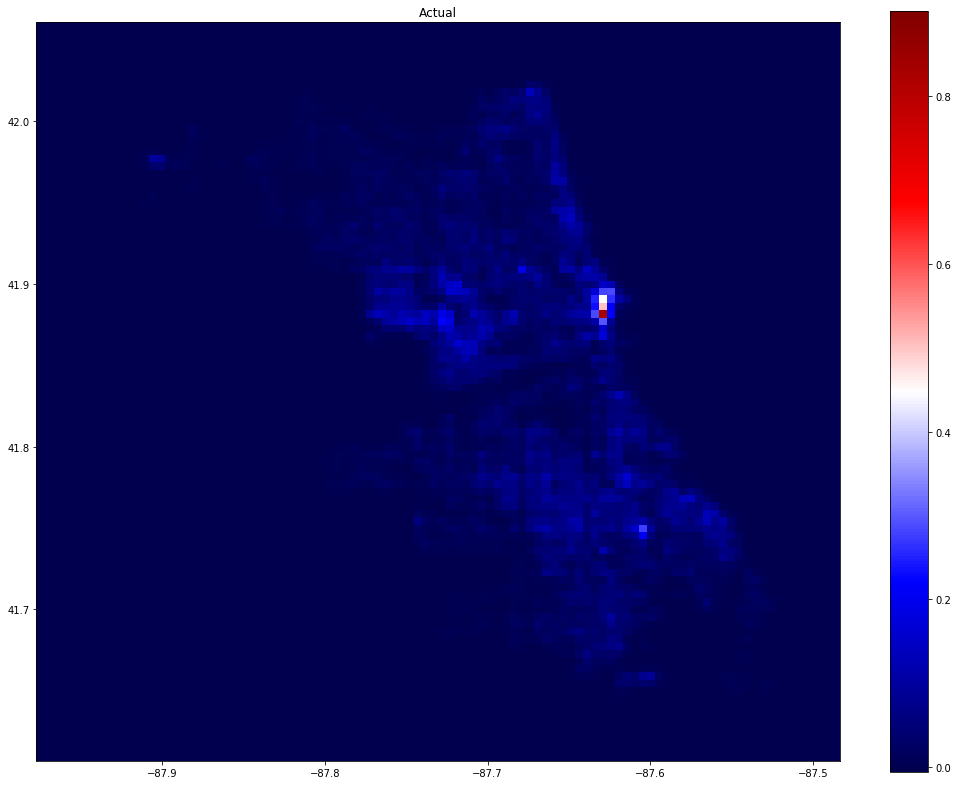

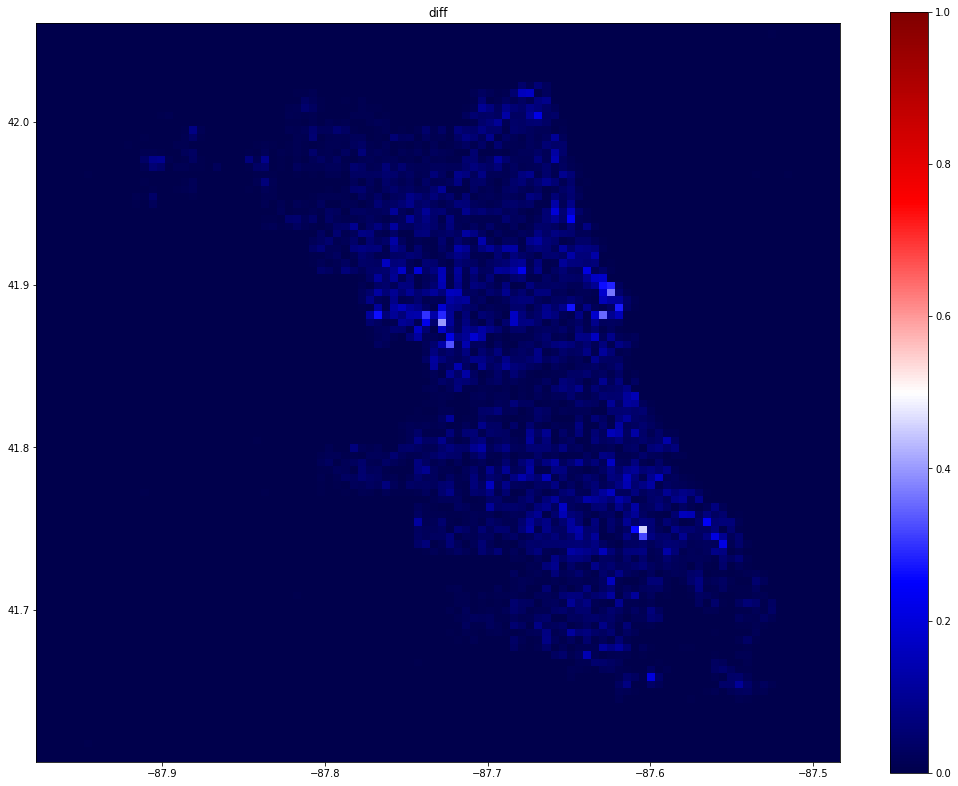

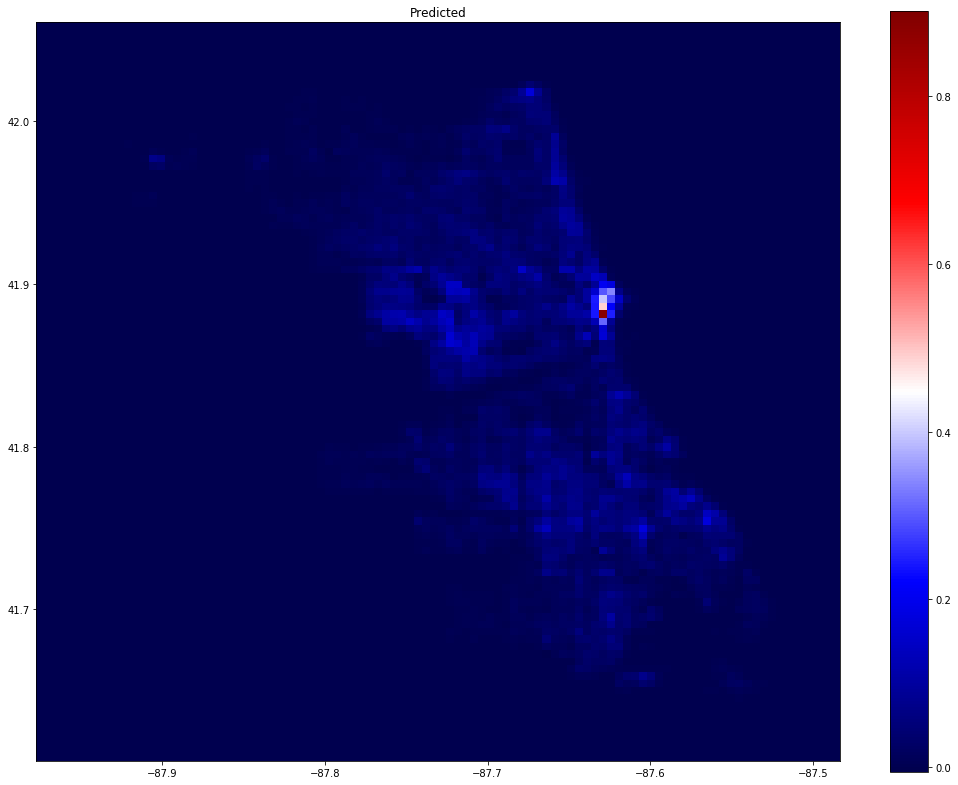

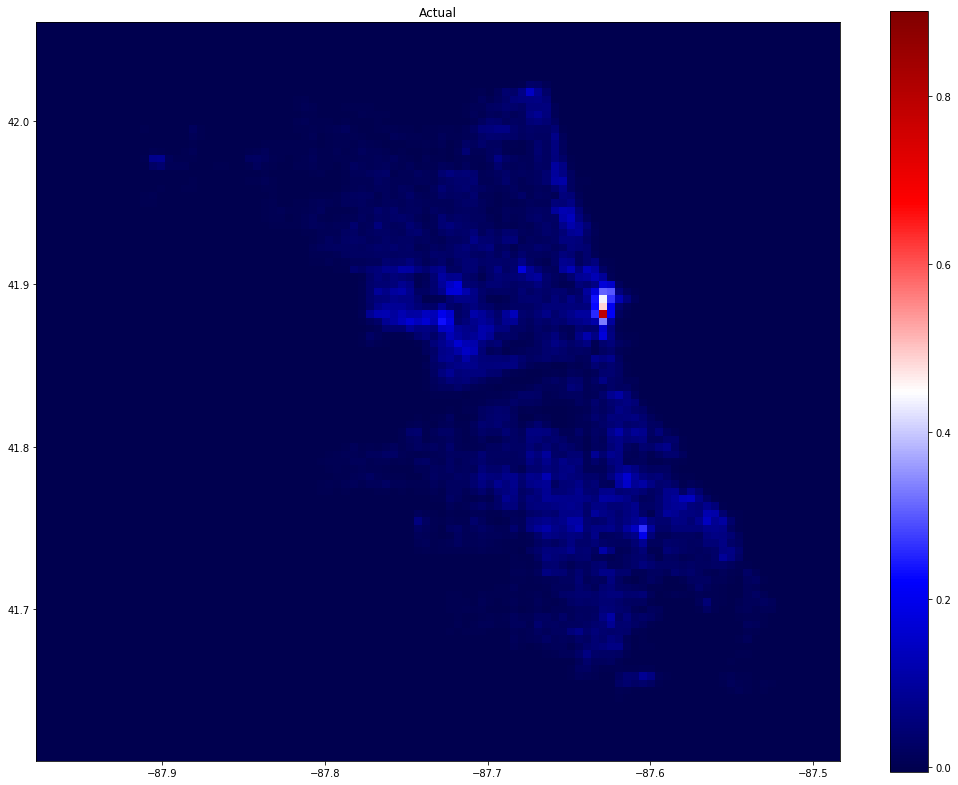

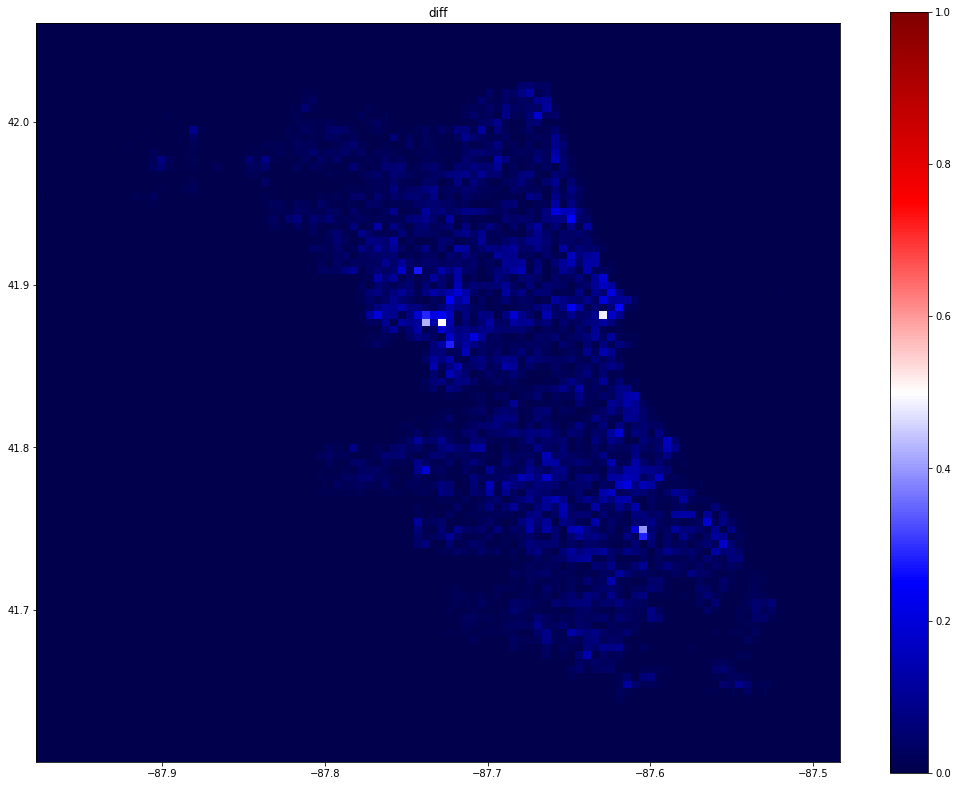

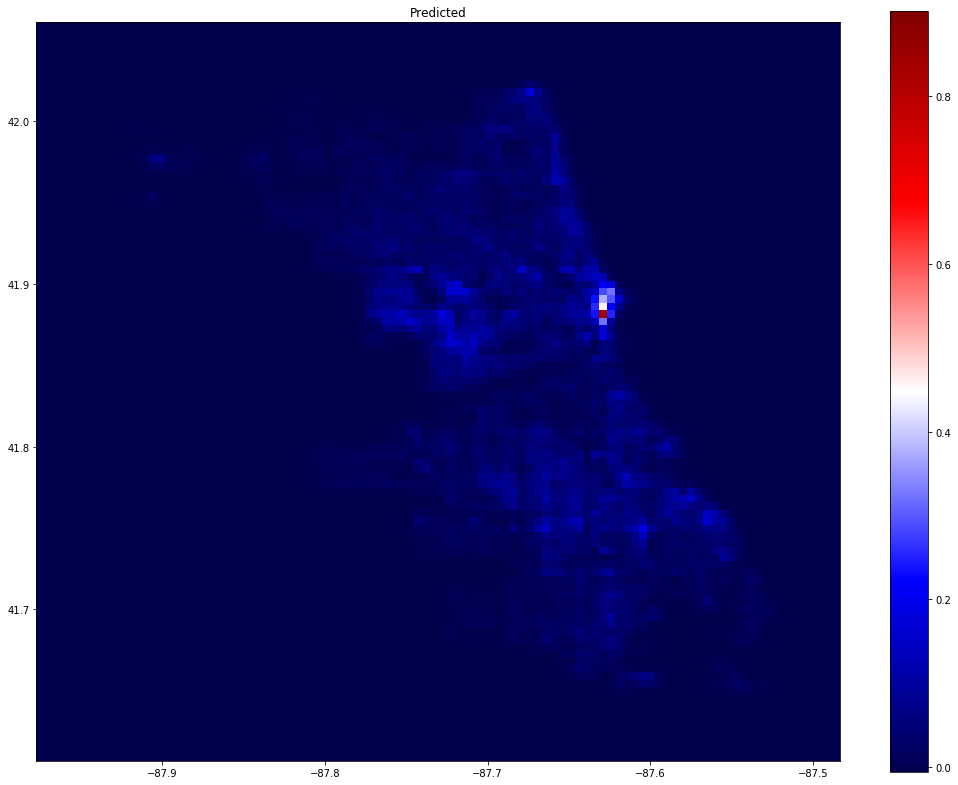

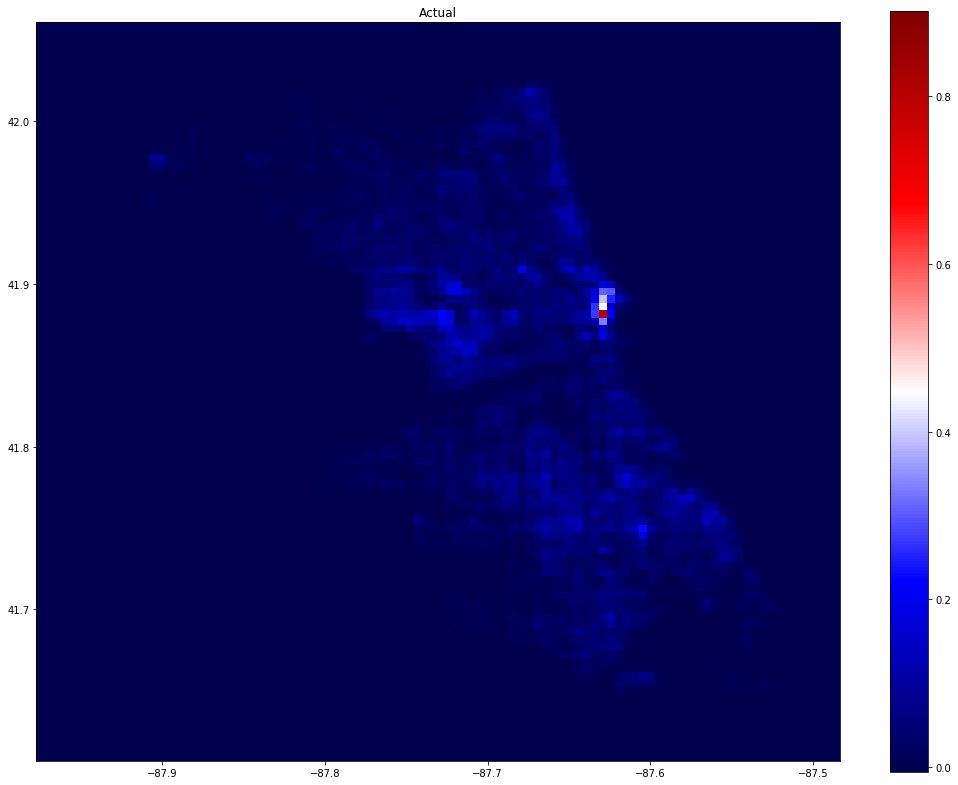

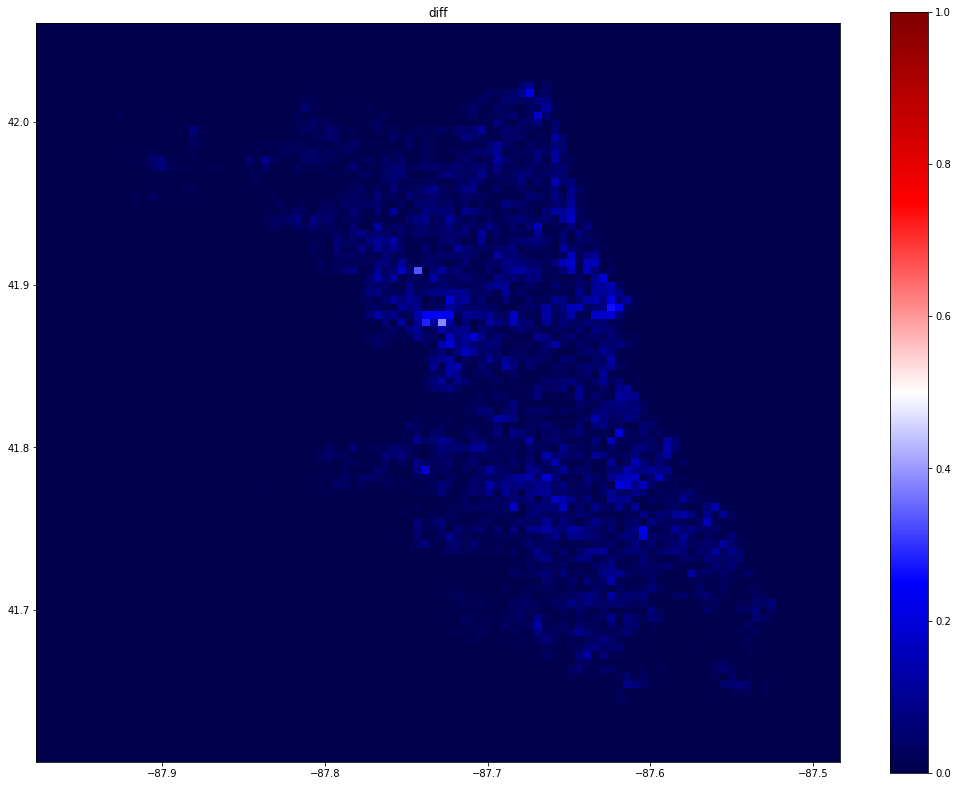

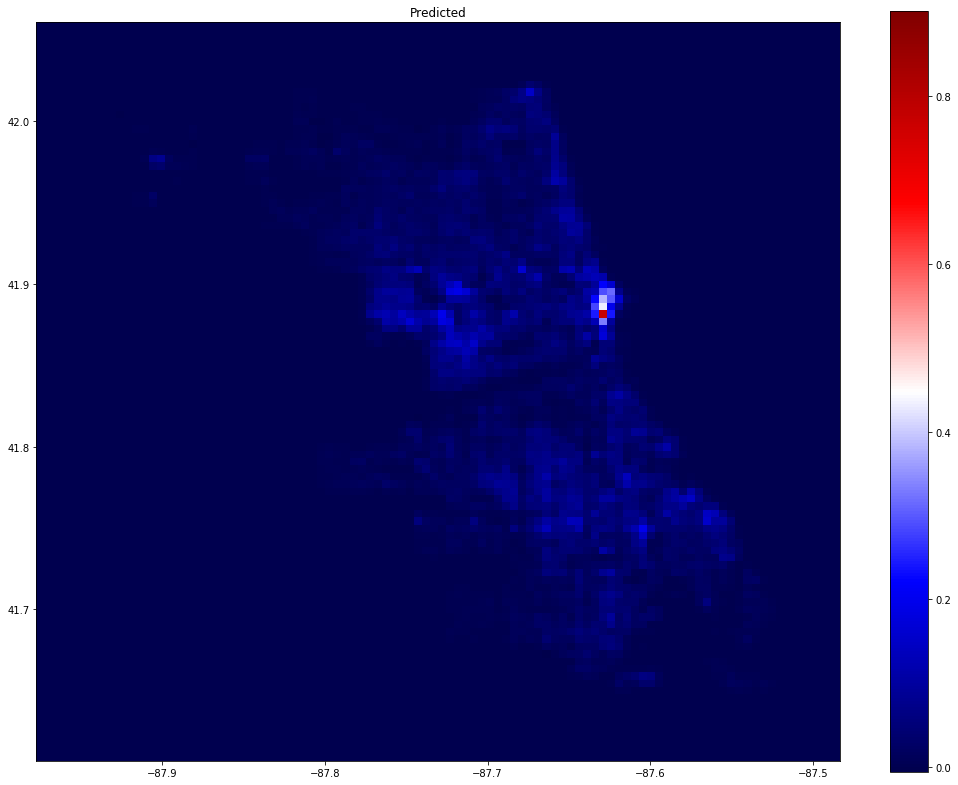

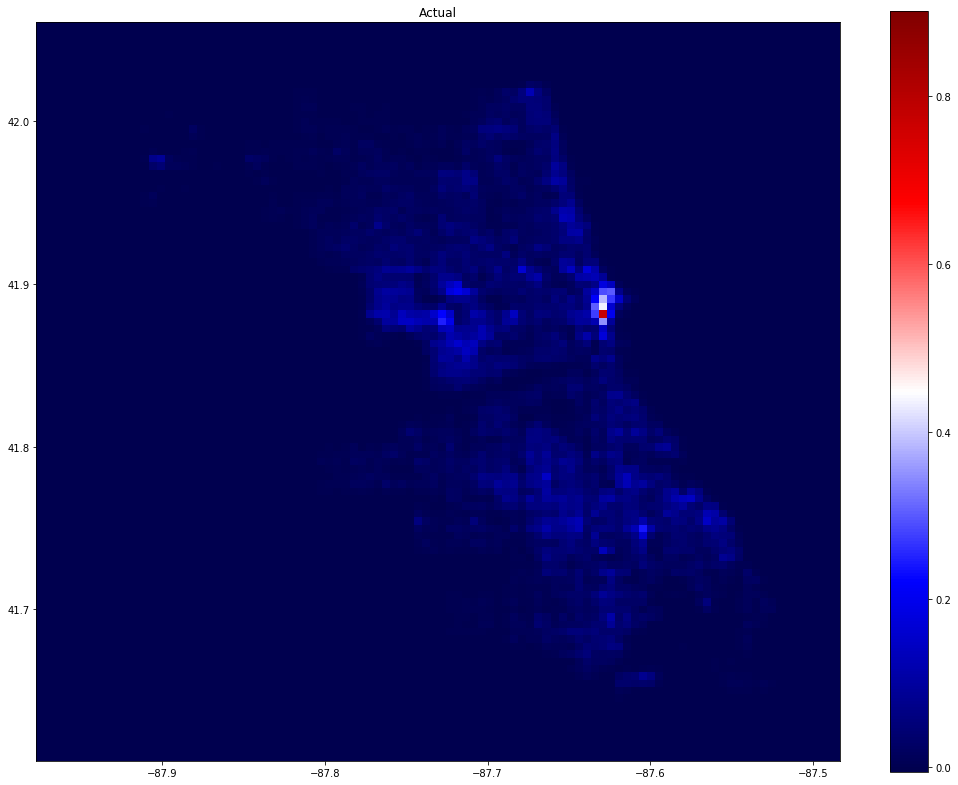

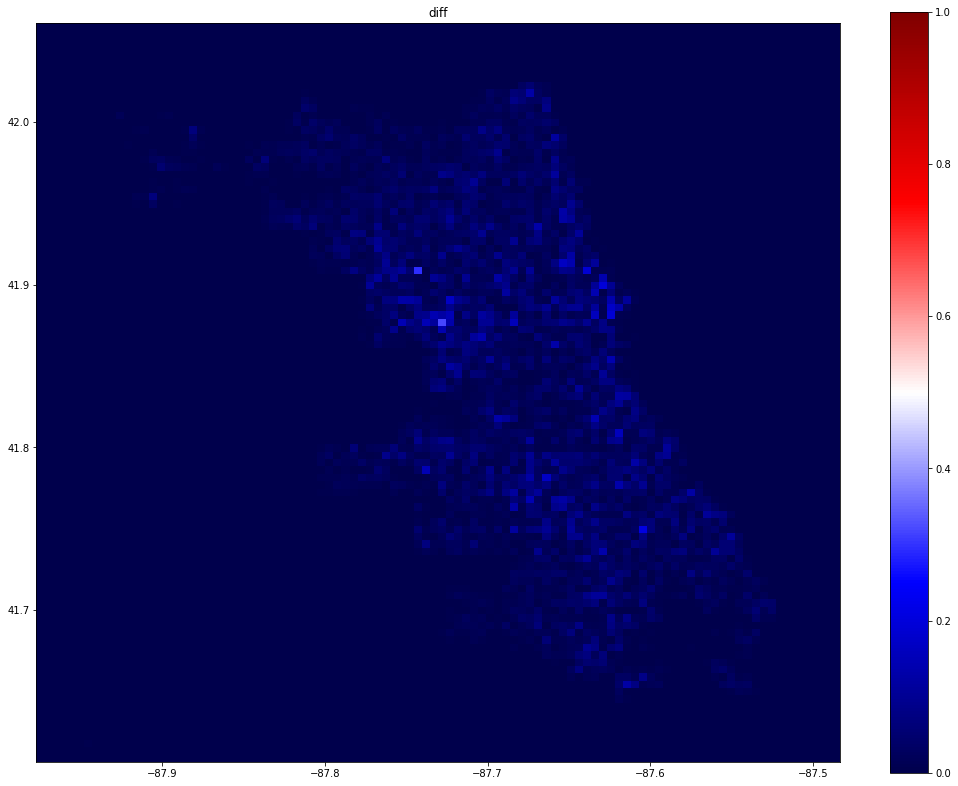

In [61]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepFromLast in range(Y_valid.shape[0]):
    plt.figure(figsize=(18, 14))
    plt.title('Predicted')
    plt.imshow( X=reshapePred(Predict,timeStepFromLast),vmax=vmax,vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    
    plt.figure(figsize=(18, 14))
    plt.title('Actual')
    plt.imshow( X=reshapePred(Y_valid,timeStepFromLast ),vmax=vmax,vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    
    diff = np.abs(reshapePred(Predict,timeStepFromLast)-reshapePred(Y_valid,timeStepFromLast ))
    plt.figure(figsize=(18, 14))
    plt.title('diff')
    plt.imshow( X=scaleDiff(diff,diff_max,diff_min),vmax=1,vmin=0, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()

#### We plot the single pixel with the most dense in crime KDE

#### We observe the model is simply averaging when change in crime density in volatile

In [396]:
Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1]

array([ 0.0068794 ,  0.00939835,  0.04298059,  0.01818586,  0.02584041,
       -0.00564454, -0.01095812, -0.01506414, -0.02136562, -0.01430703,
       -0.03129888, -0.02253307,  0.02166017, -0.0144419 ,  0.00861606,
       -0.00657073, -0.00712241, -0.00232194,  0.0062109 ,  0.00589511,
        0.00946012, -0.01545016,  0.015007  ,  0.00882956,  0.0152953 ,
        0.06236299, -0.01036096])

In [397]:
[Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1]
 ,Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1]]

[array([ 0.0068794 ,  0.00939835,  0.04298059,  0.01818586,  0.02584041,
        -0.00564454, -0.01095812, -0.01506414, -0.02136562, -0.01430703,
        -0.03129888, -0.02253307,  0.02166017, -0.0144419 ,  0.00861606,
        -0.00657073, -0.00712241, -0.00232194,  0.0062109 ,  0.00589511,
         0.00946012, -0.01545016,  0.015007  ,  0.00882956,  0.0152953 ,
         0.06236299, -0.01036096]),
 array([ 0.0068794 ,  0.00939835,  0.04298059,  0.01818586,  0.02584041,
        -0.00564454, -0.01095812, -0.01506414, -0.02136562, -0.01430703,
        -0.03129888, -0.02253307,  0.02166017, -0.0144419 ,  0.00861606,
        -0.00657073, -0.00712241, -0.00232194,  0.0062109 ,  0.00589511,
         0.00946012, -0.01545016,  0.015007  ,  0.00882956,  0.0152953 ,
         0.06236299, -0.01036096])]

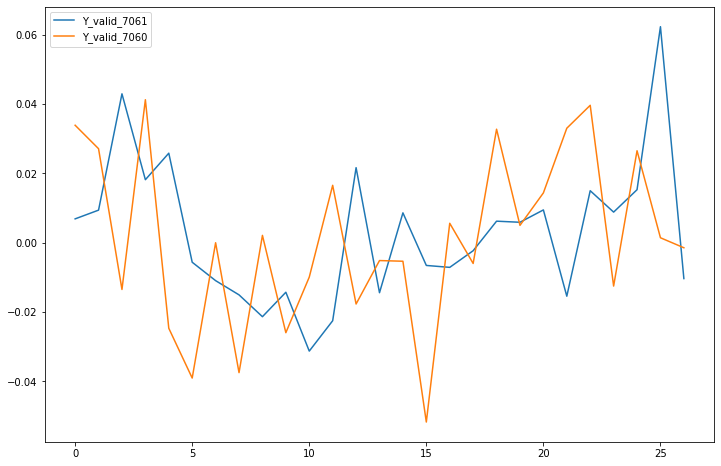

In [398]:
pd.DataFrame(np.transpose(np.vstack([Y_valid[:,i+1][1:]-Y_valid[:,i+1][0:-1],Y_valid[:,i][1:]-Y_valid[:,i][0:-1]])),columns=["Y_valid_"+str(i+1),"Y_valid_"+str(i)]).plot(figsize=(12,8))

In [399]:
for i in range(Predict.shape[0]-1):
    diff_ts = Predict[i,:] - Predict[i+1,:]
    print(np.sum(diff_ts[np.argsort(diff_ts)]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


#### We plot the difference between prediction and target

In [400]:
diff = (reshapePred(Y_valid,3)-reshapePred(Predict,3))
diff.shape

(100, 100)

In [401]:
diff_max = np.max(diff)
diff_min = np.min(diff)
scaled_diff = (diff - diff_min)/(diff_max - diff_min)

In [402]:
np.max(scaled_diff)

1.0

In [403]:
diff

array([[ 1.81296491e-06, -5.77185665e-06, -1.81296491e-06, ...,
        -5.25021732e-08,  1.81296491e-06, -5.77185665e-06],
       [ 1.81296491e-06,  5.25021734e-08, -1.81296491e-06, ...,
        -1.81296491e-06,  5.24621556e-08,  5.77185665e-06],
       [ 1.81296491e-06,  5.24621556e-08, -5.25021732e-08, ...,
        -1.81296491e-06,  5.24621556e-08, -5.77185665e-06],
       ...,
       [ 5.24621556e-08,  1.02341037e-05,  1.81296491e-06, ...,
         1.02341037e-05, -5.24621554e-08, -1.81296491e-06],
       [ 1.02341037e-05, -1.81296491e-06, -5.77185665e-06, ...,
        -5.24621554e-08,  1.02341037e-05, -1.81296491e-06],
       [-1.81296491e-06,  5.77185665e-06,  1.81296491e-06, ...,
        -5.77185665e-06,  1.02341037e-05,  1.81296491e-06]])

In [404]:
vmax, vmin = np.max(scaled_diff), np.min(scaled_diff)

In [405]:
vmax, vmin 

(1.0, 0.0)

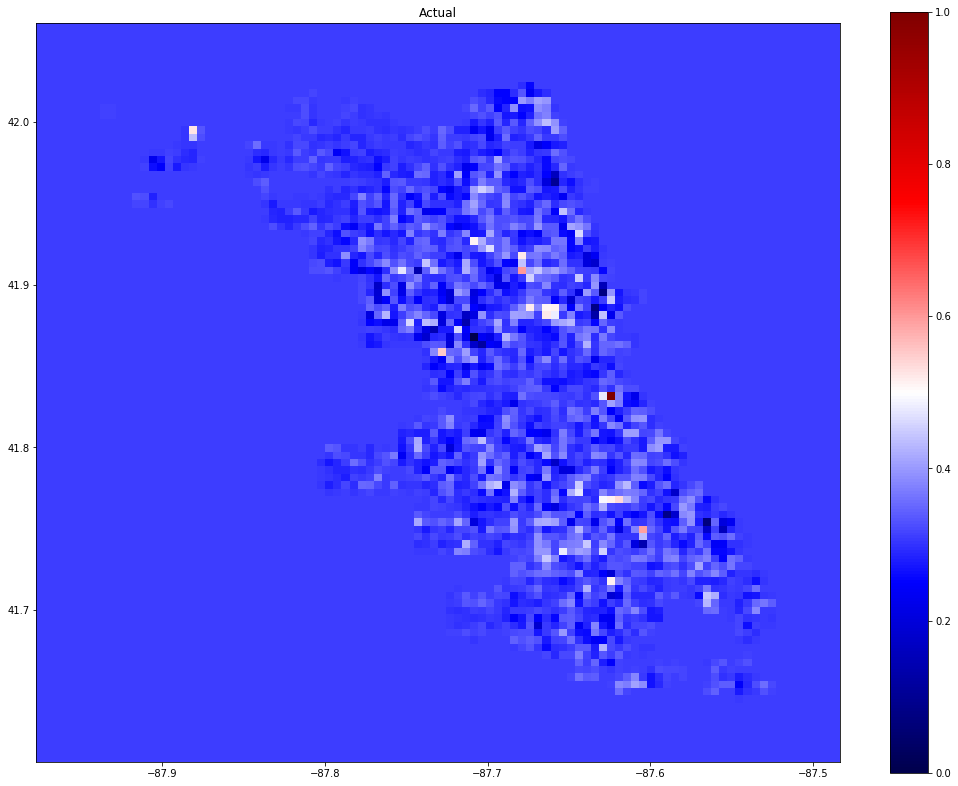

In [68]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=scaled_diff,vmax=vmax, vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
plt.colorbar()

#### Note the differences is scaled, red means extreme differences inplot above. Interestingly we see the extreme differences is at the highest crime areas.

#### Tensor Flow test

In [227]:
array1 = np.array([[[0, 1, 2, 3, 4],
   [5, 6, 7, 8, 9]],
  [[10, 11, 12, 13, 14],
   [15, 16, 17, 18, 19]],
  [[20, 21, 22, 23, 24],
   [25, 26, 27, 28, 29]],])

In [232]:
array2 = (array1 + 2)*2

In [233]:
array2

array([[[ 4,  6,  8, 10, 12],
        [14, 16, 18, 20, 22]],

       [[24, 26, 28, 30, 32],
        [34, 36, 38, 40, 42]],

       [[44, 46, 48, 50, 52],
        [54, 56, 58, 60, 62]]])

In [235]:
rank_3_tensor1 = tf.constant(array1)
rank_3_tensor2 = tf.constant(array2)
                    
print(rank_3_tensor1)
print(rank_3_tensor2)

tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]], shape=(3, 2, 5), dtype=int64)
tf.Tensor(
[[[ 4  6  8 10 12]
  [14 16 18 20 22]]

 [[24 26 28 30 32]
  [34 36 38 40 42]]

 [[44 46 48 50 52]
  [54 56 58 60 62]]], shape=(3, 2, 5), dtype=int64)


In [240]:
rank_3_tensor2[0:].shape

TensorShape([3, 2, 5])

In [243]:
rank_3_tensor2 - rank_3_tensor1

<tf.Tensor: shape=(3, 2, 5), dtype=int64, numpy=
array([[[ 4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13]],

       [[14, 15, 16, 17, 18],
        [19, 20, 21, 22, 23]],

       [[24, 25, 26, 27, 28],
        [29, 30, 31, 32, 33]]])>

In [241]:
rank_3_tensor2[0:-1] - rank_3_tensor2[1:]

<tf.Tensor: shape=(2, 2, 5), dtype=int64, numpy=
array([[[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]],

       [[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]]])>

In [242]:
tf.math.subtract(rank_3_tensor2[0:-1],rank_3_tensor2[1:])

<tf.Tensor: shape=(2, 2, 5), dtype=int64, numpy=
array([[[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]],

       [[-20, -20, -20, -20, -20],
        [-20, -20, -20, -20, -20]]])>

In [304]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mse'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))  
timeDist = TimeDistributed(Flatten())(inputs)
print(timeDist.shape)
diffTime = Lambda(lambda x: x[:,:-1,:]-x[:,1:,:],name='timestep_diff')(timeDist)
print(diffTime.shape)
LSTM_layer1 = LSTM(100)(diffTime)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_diff1lag_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',#'mean_squared_logarithmic_error',
                   metrics=['mse'], 
                   optimizer=adam)



(None, 52, 10000)
(None, 51, 10000)
Model: "Flattened_diff1lag_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
timestep_diff (Lambda)       (None, 51, 10000)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               4040400   
_________________________________________________________________
dense_48 (Dense)             (None, 100)               10100     
_________________________________________________________________
flatten_45 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_4

(51,)


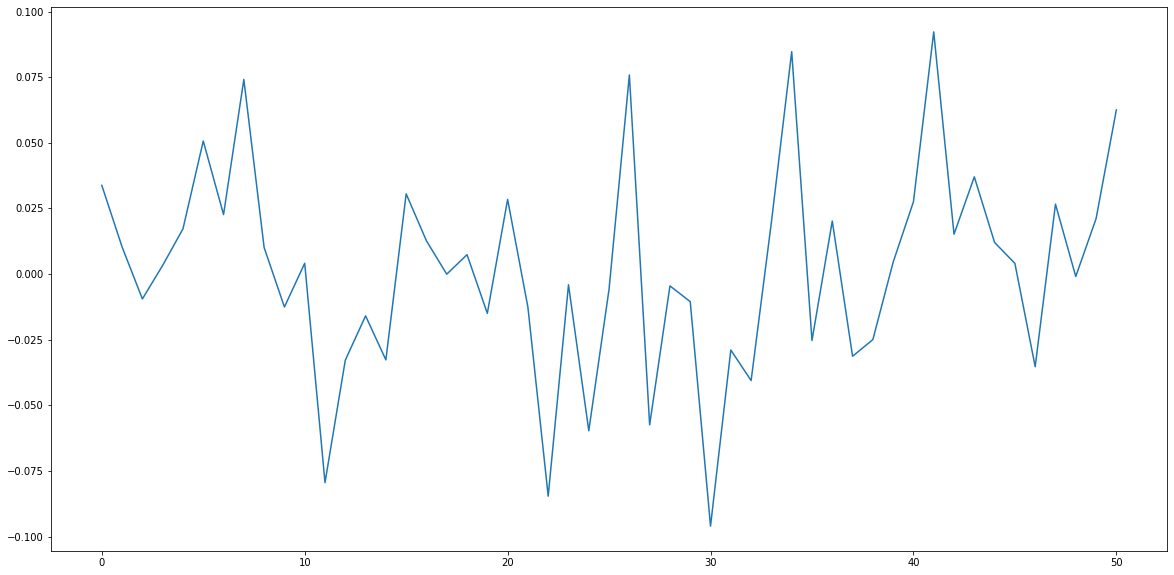

(51,)


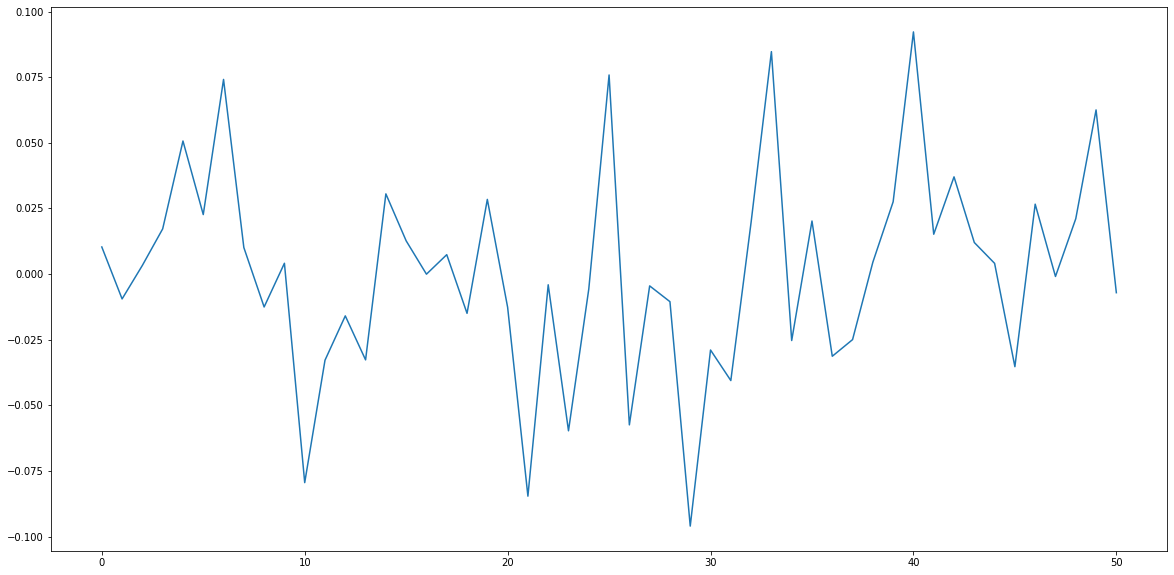

(51,)


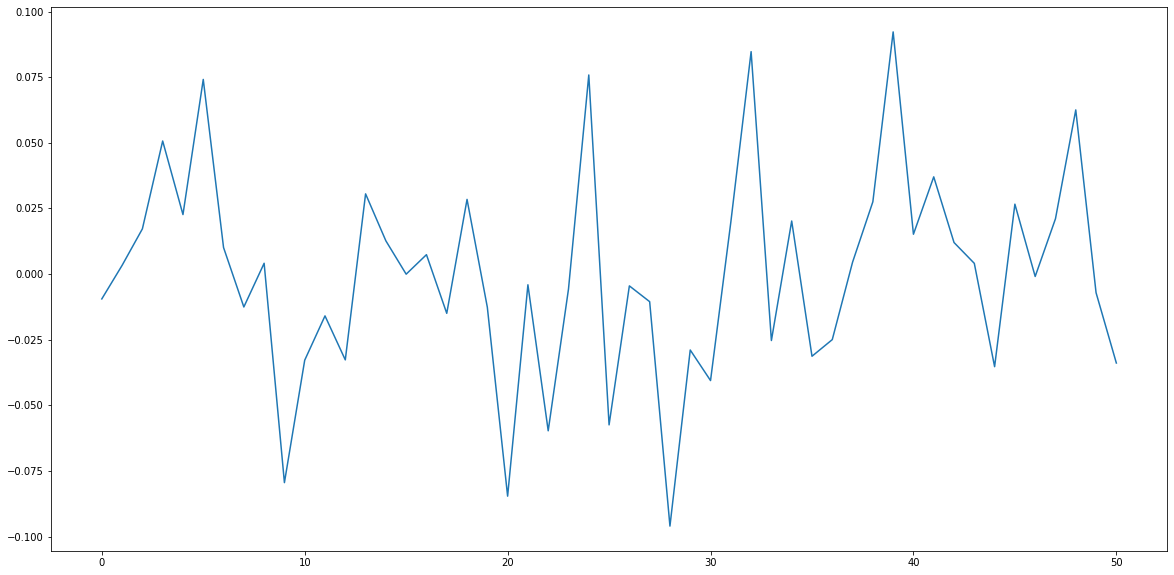

(51,)


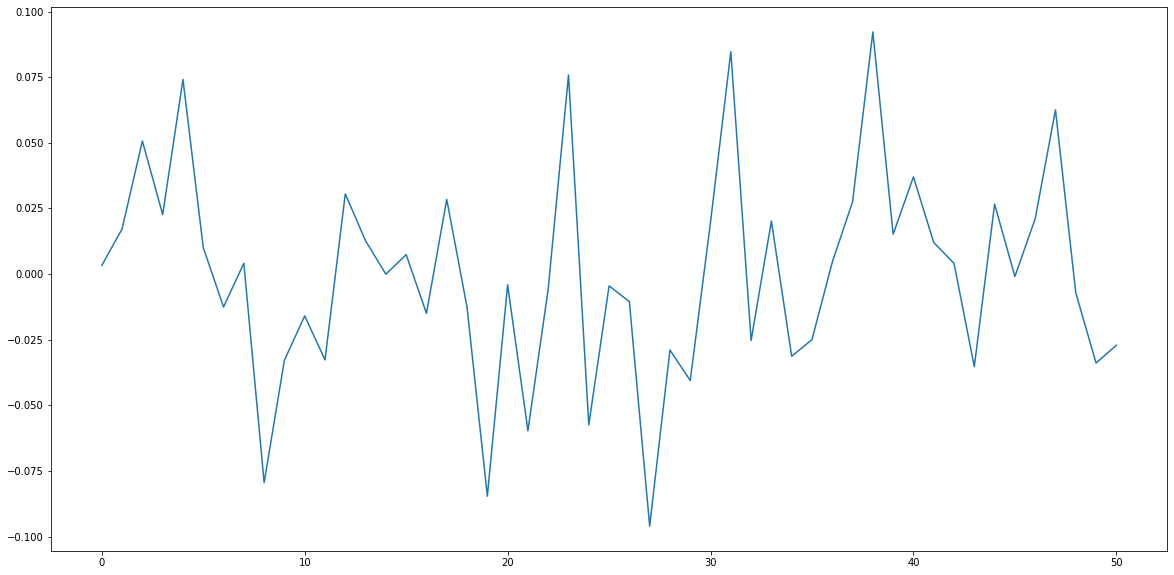

(51,)


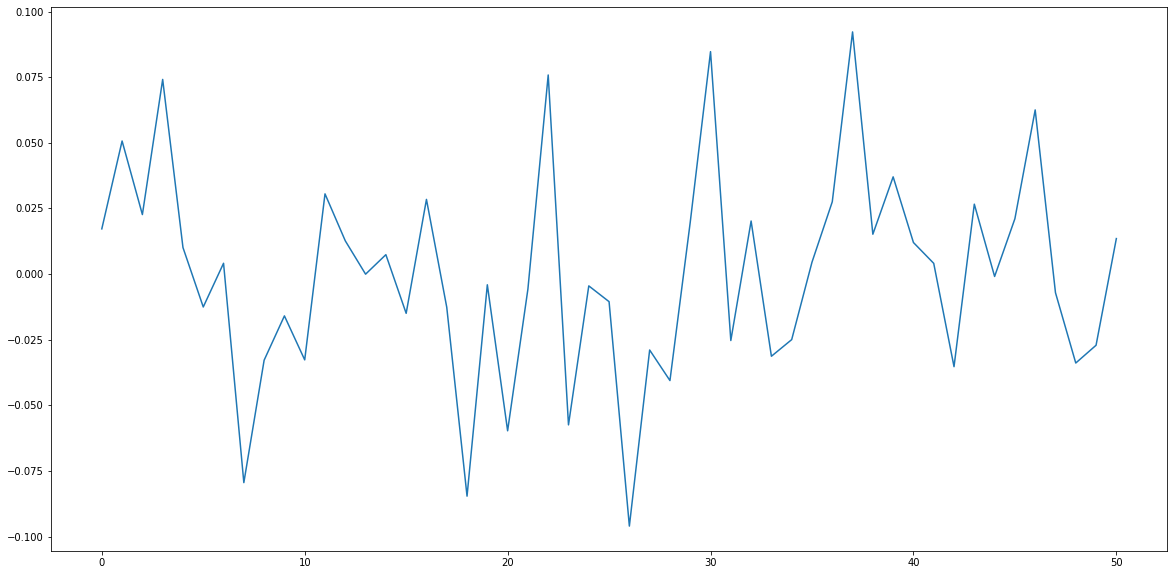

(51,)


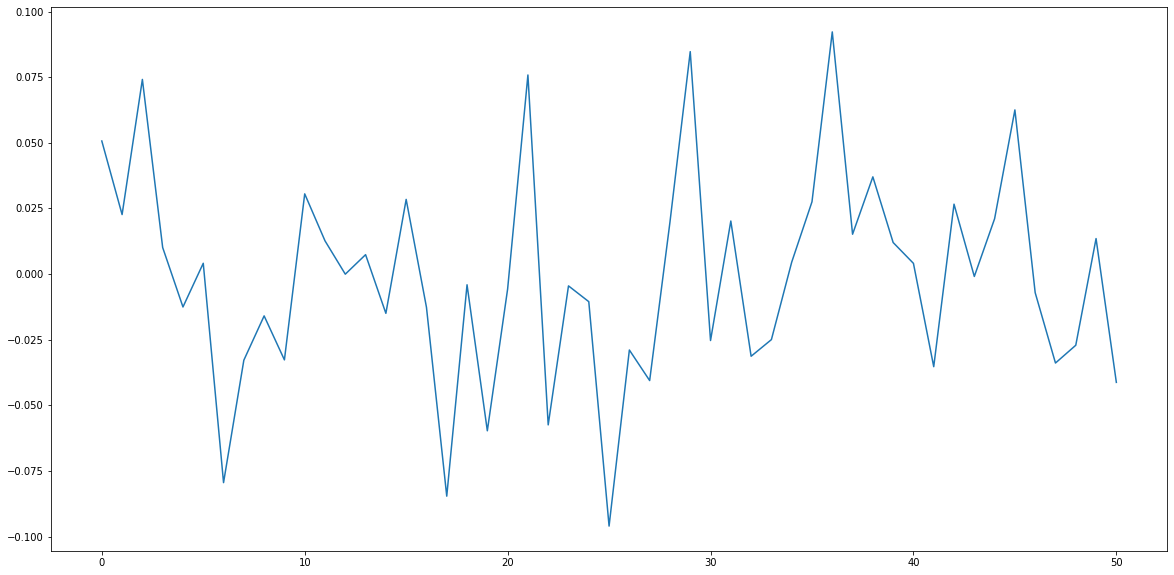

(51,)


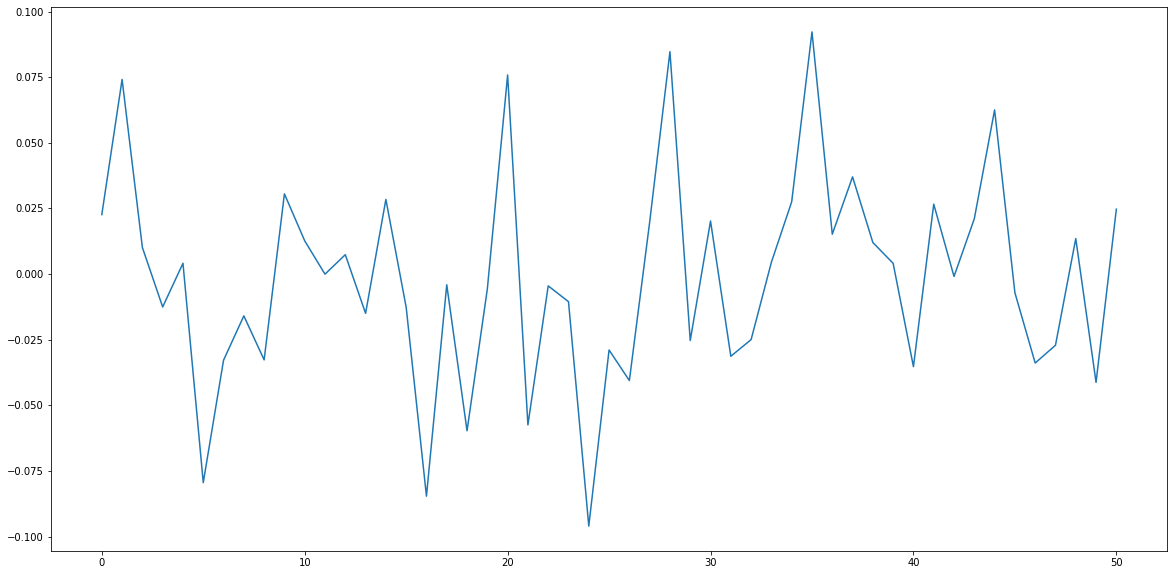

(51,)


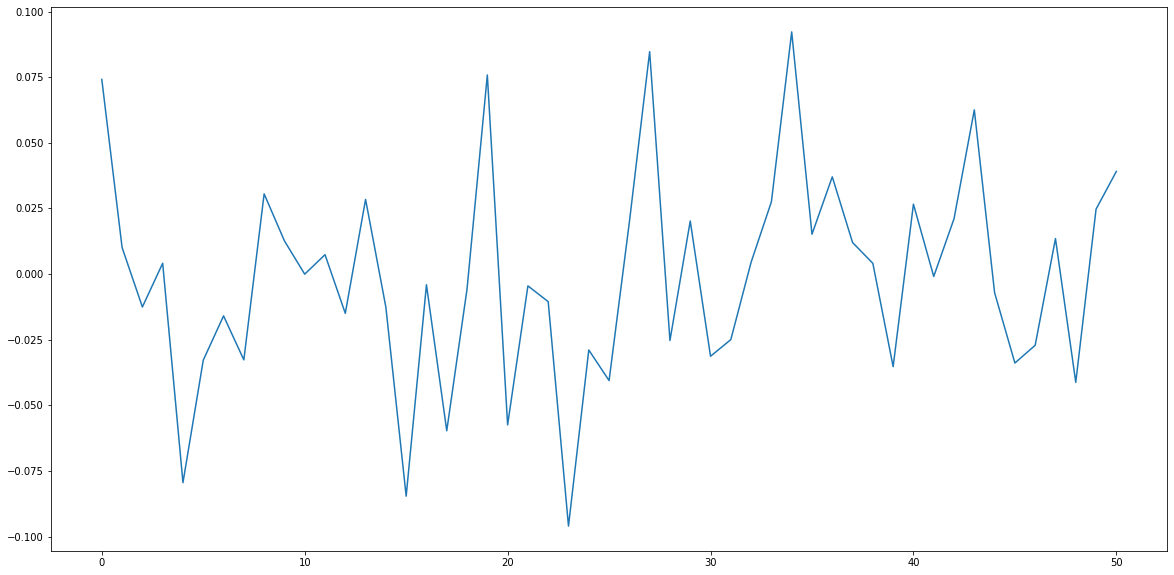

(51,)


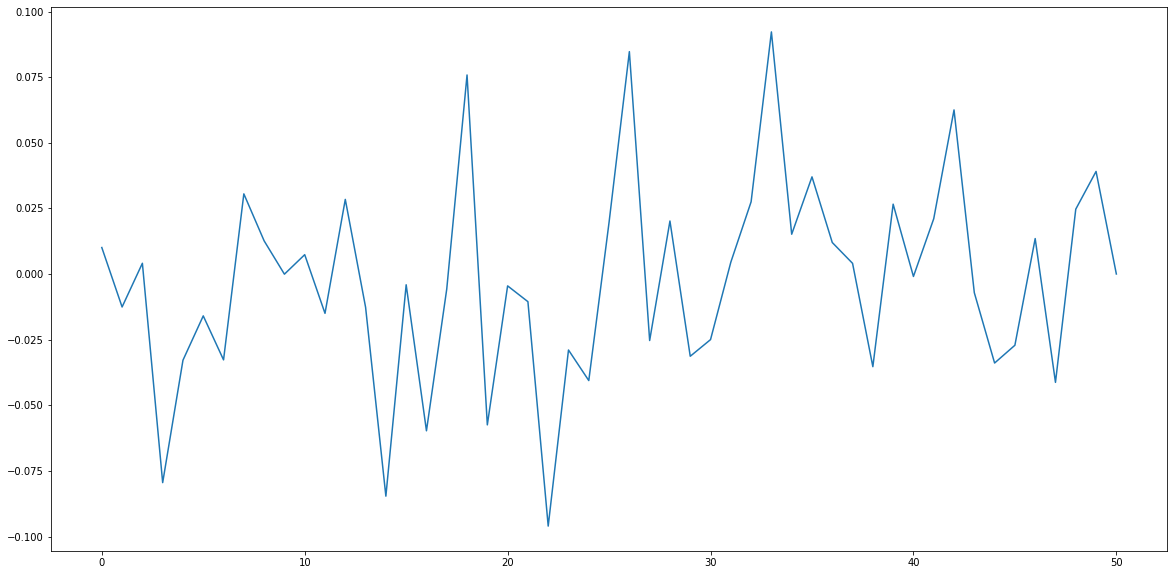

(51,)


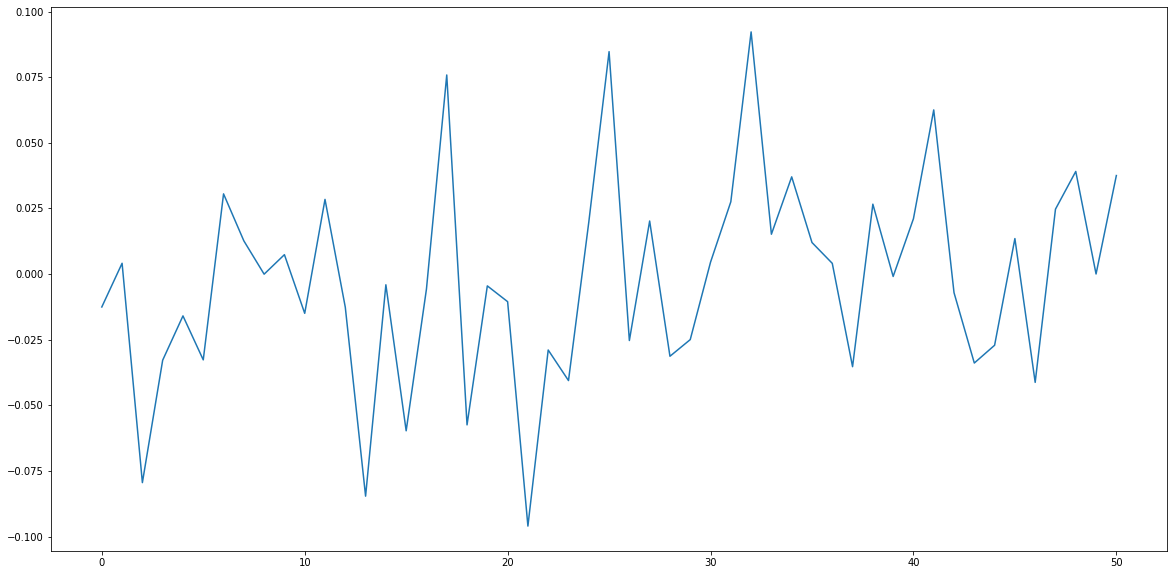

(51,)


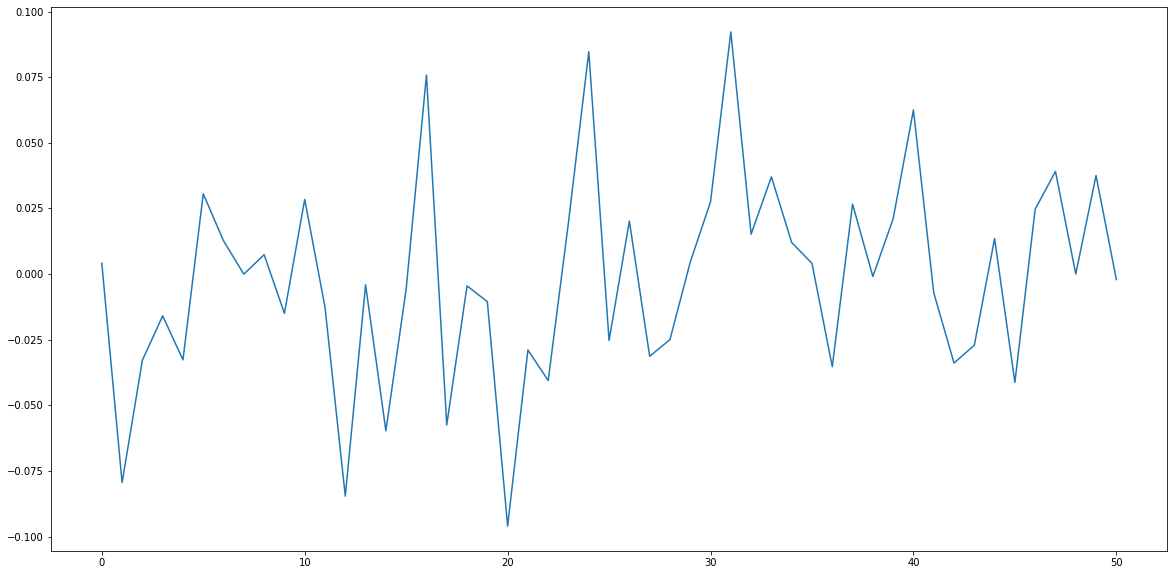

(51,)


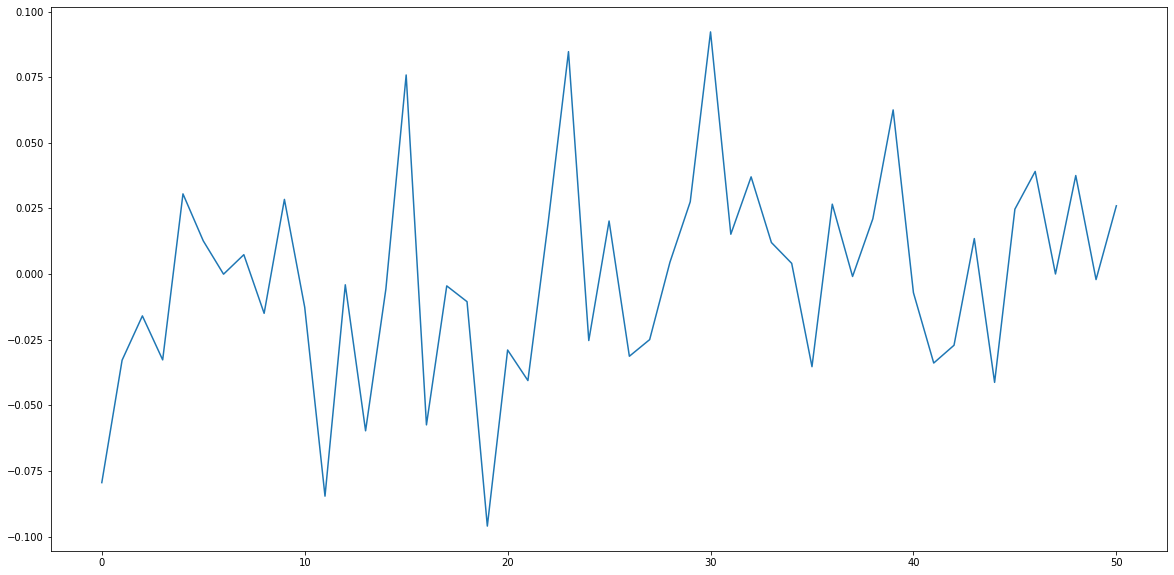

(51,)


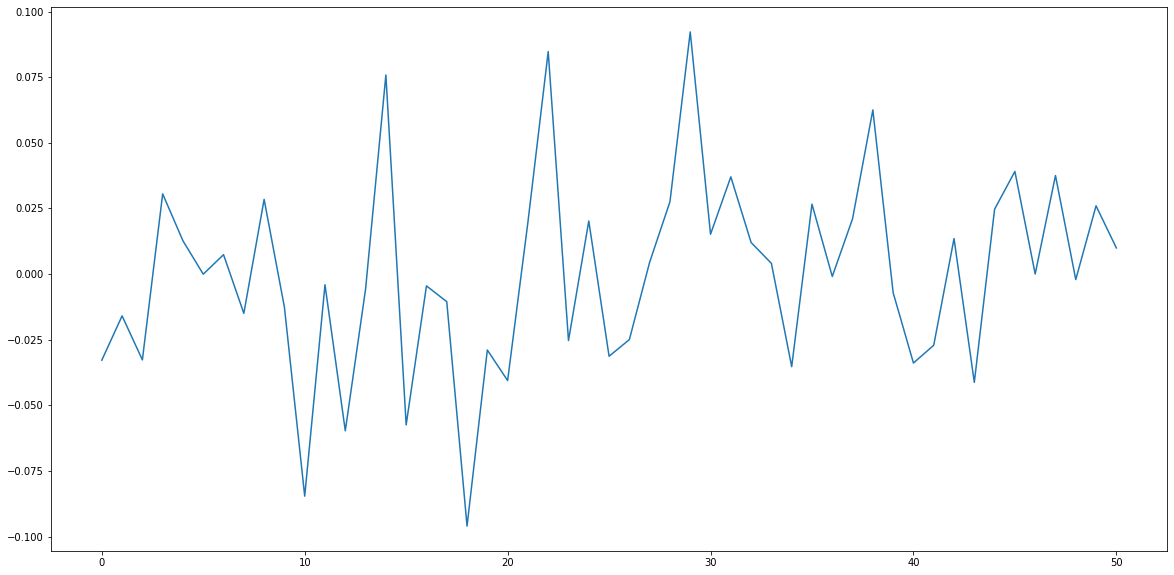

(51,)


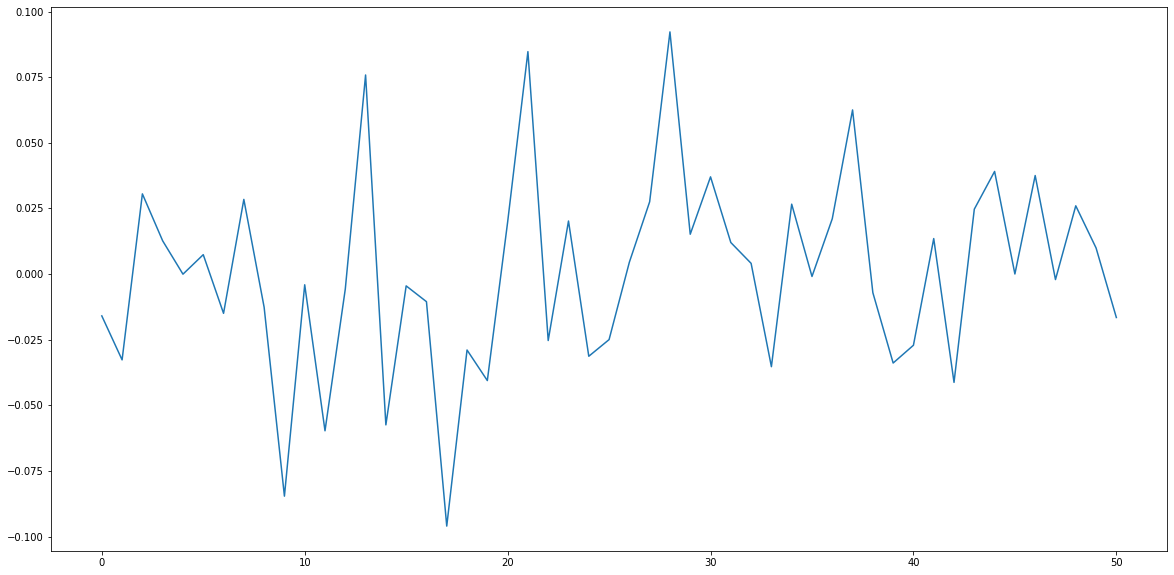

(51,)


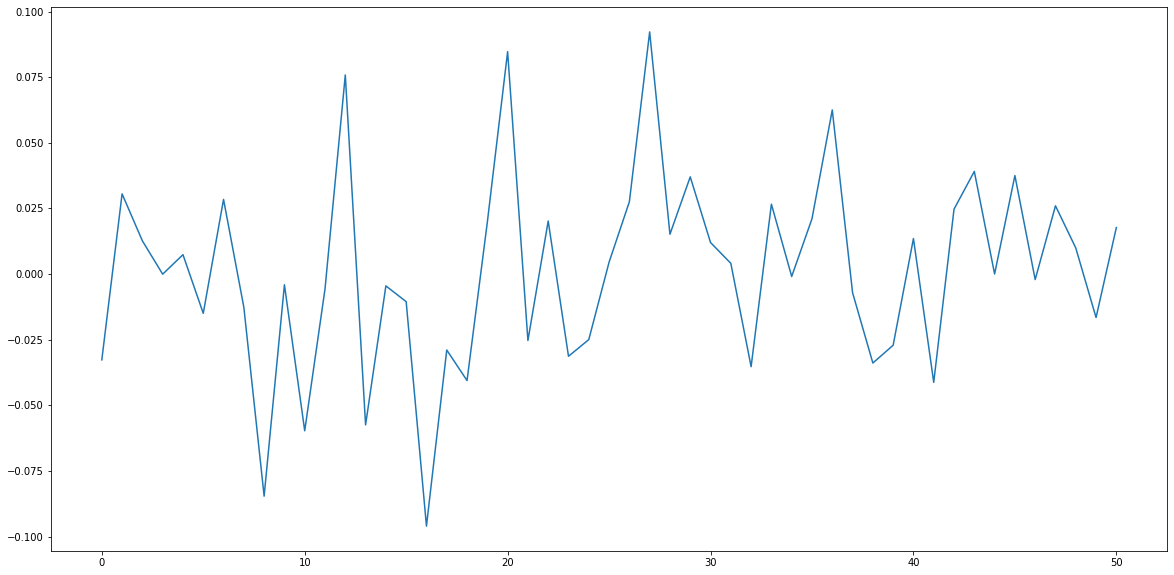

(51,)


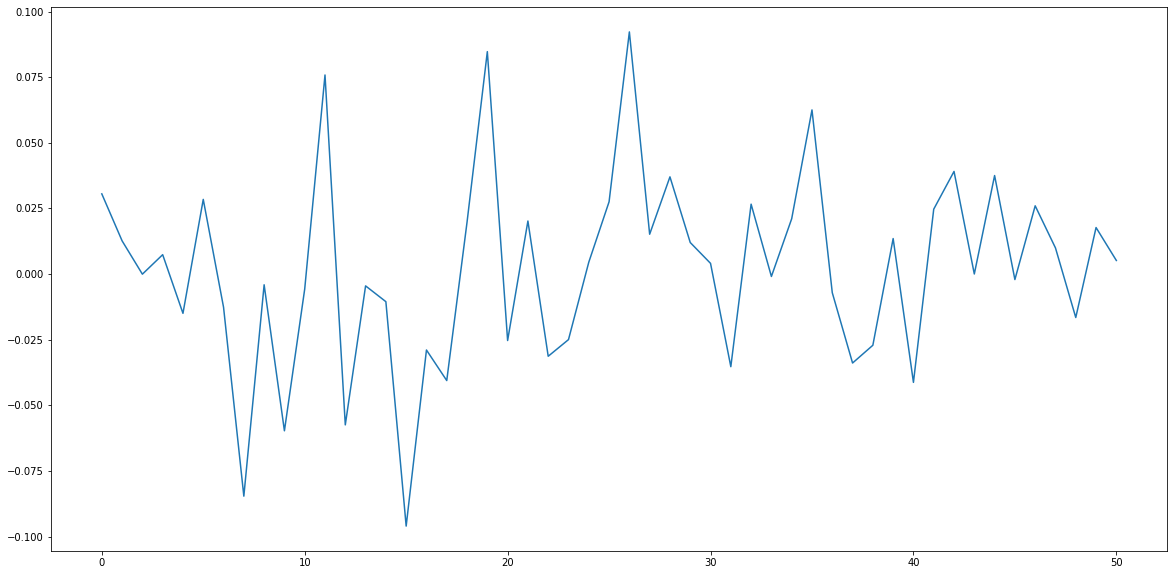

(51,)


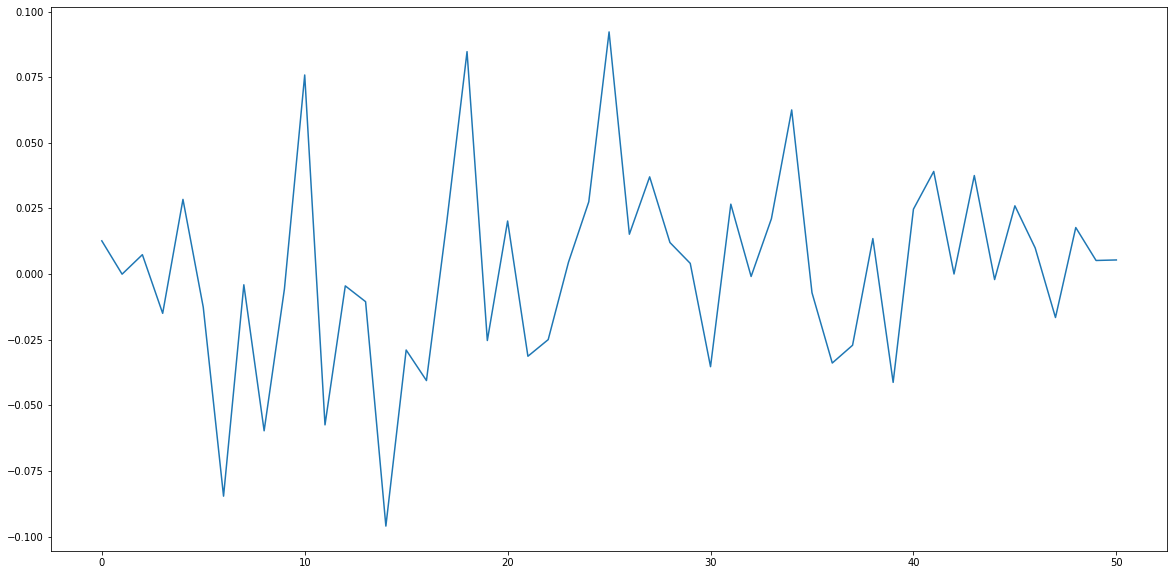

(51,)


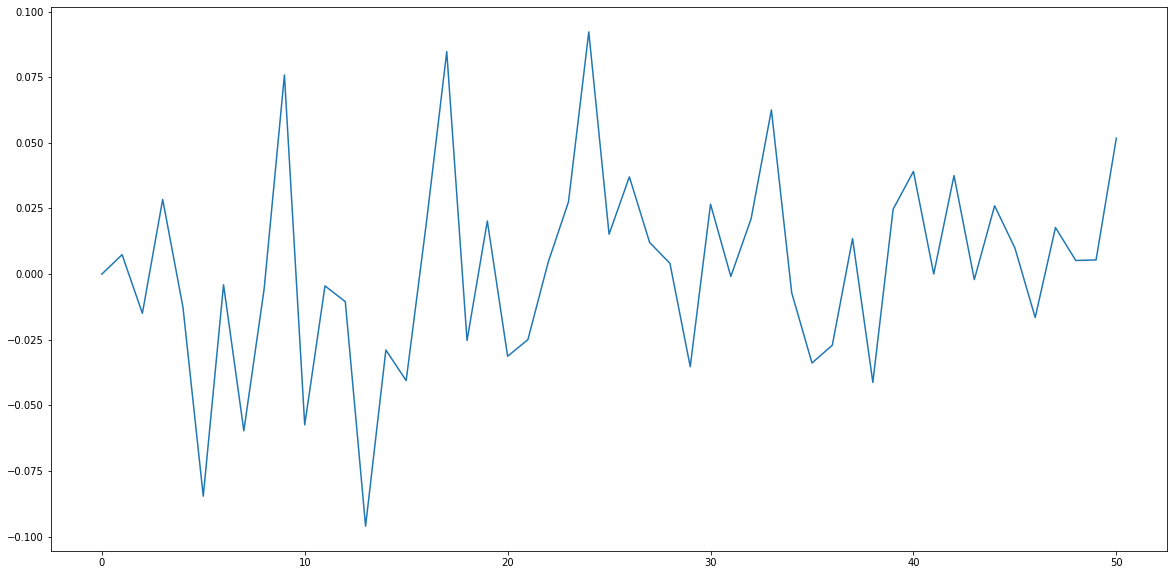

(51,)


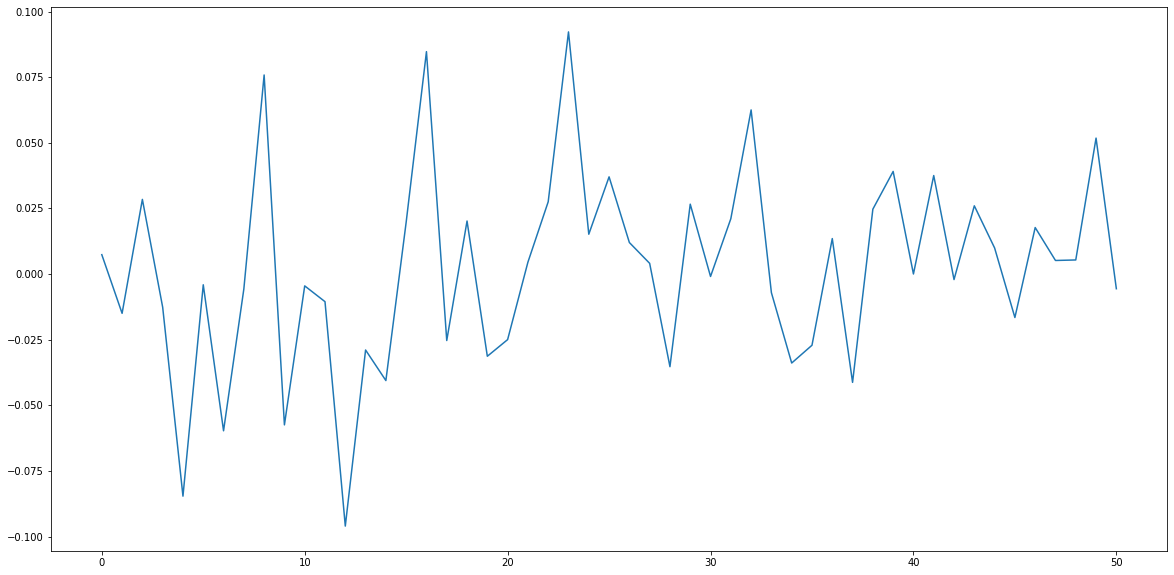

(51,)


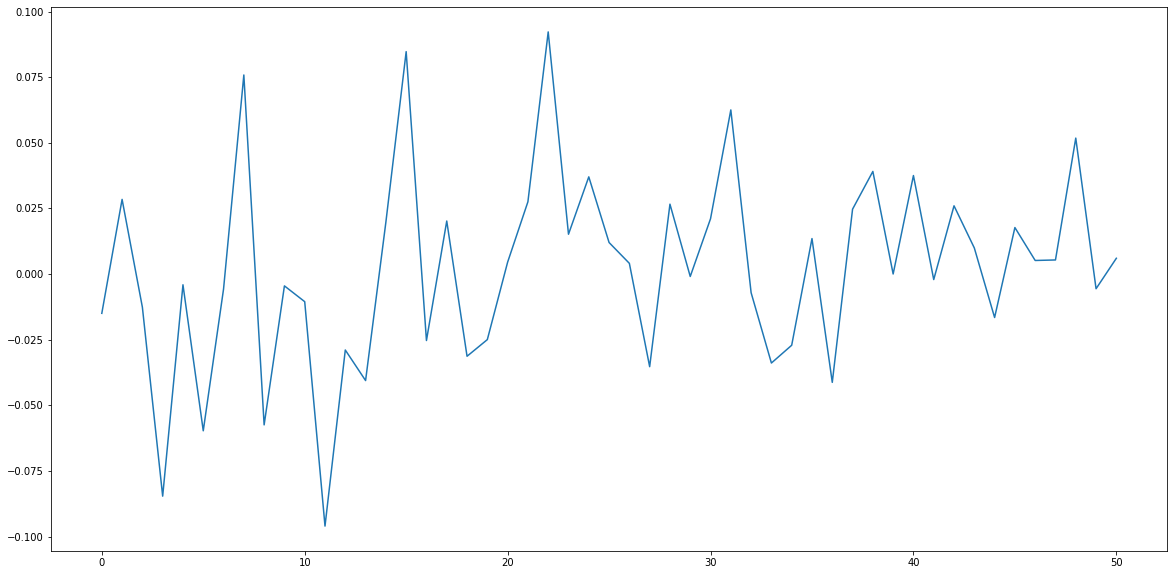

(51,)


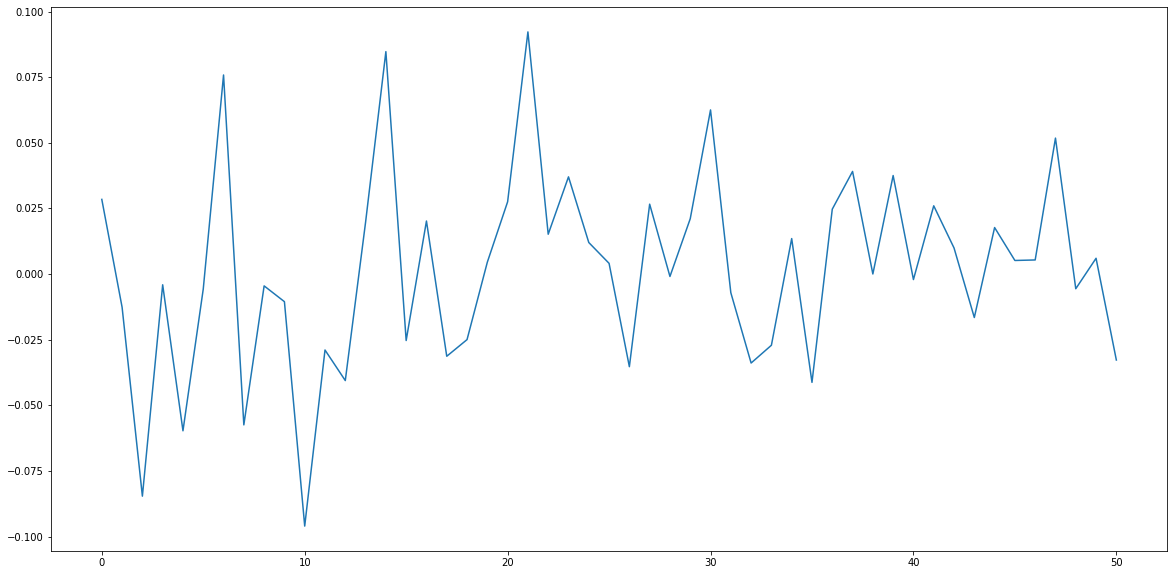

(51,)


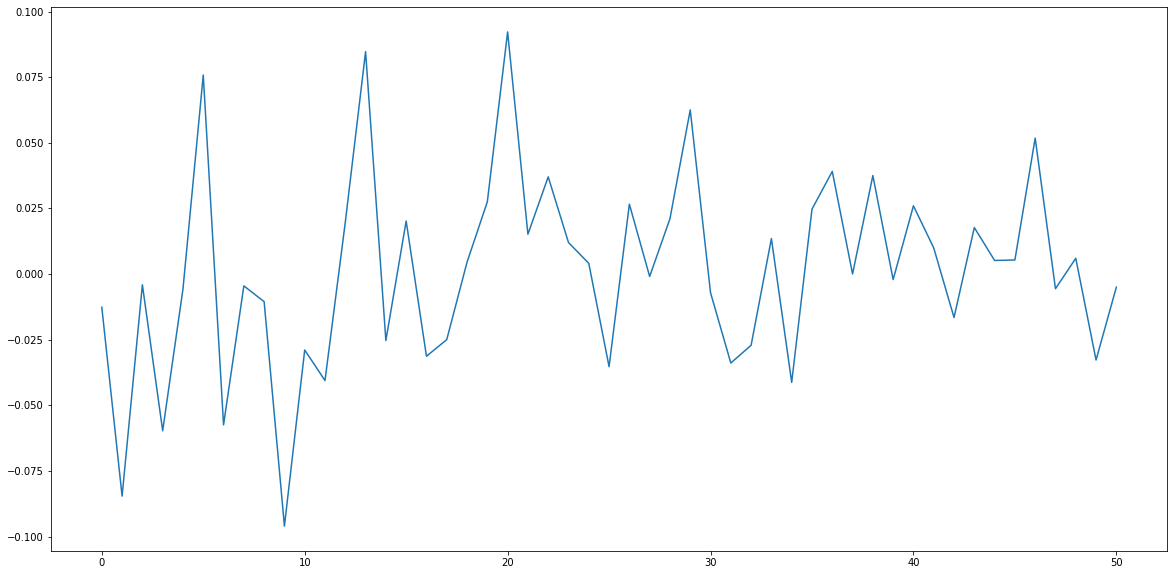

(51,)


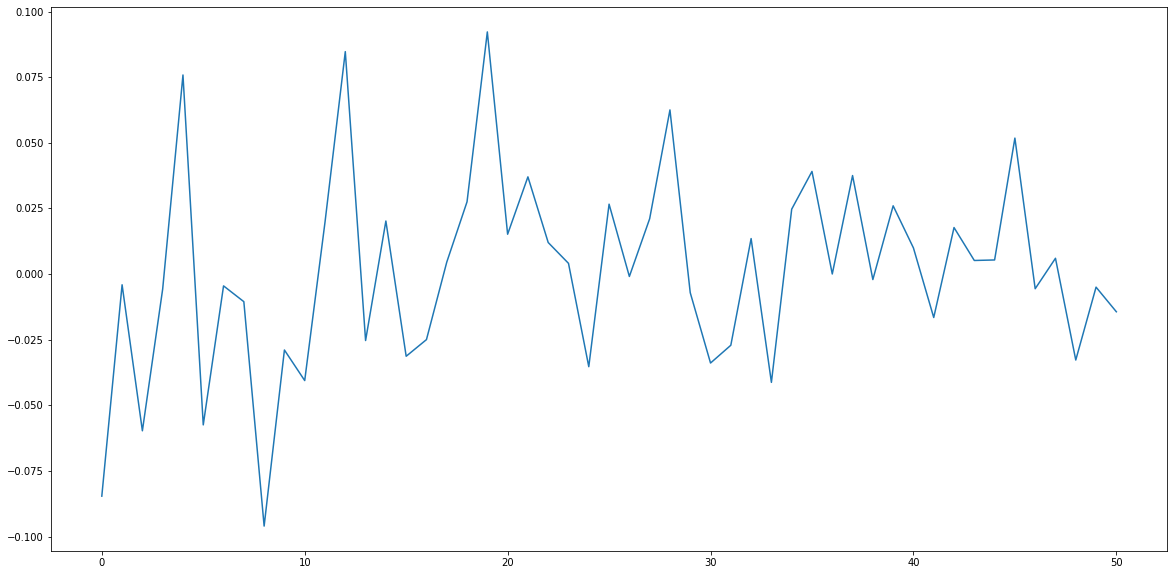

(51,)


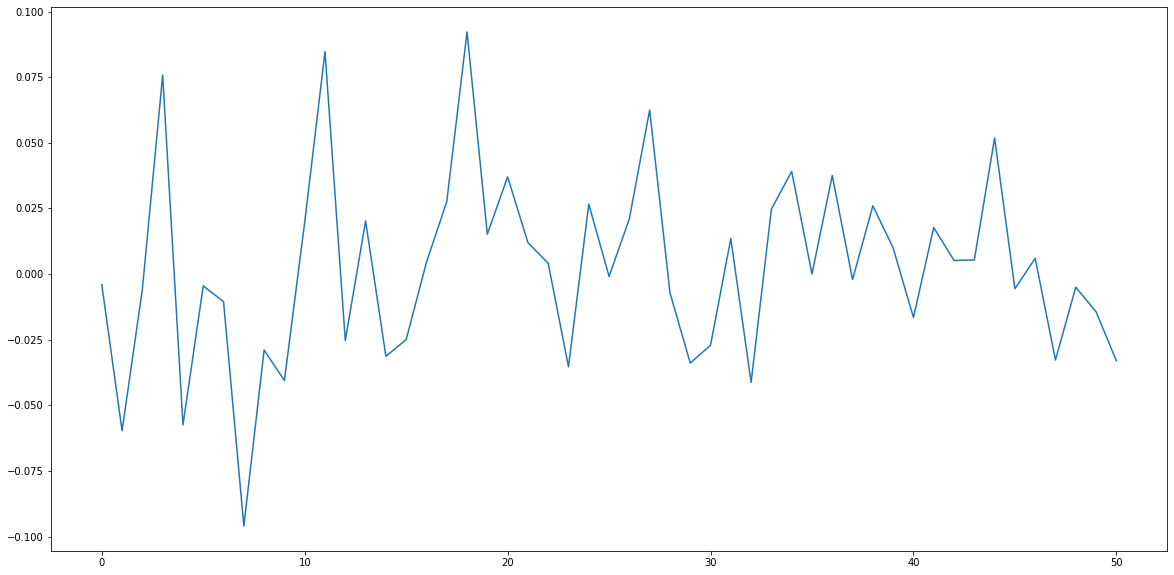

(51,)


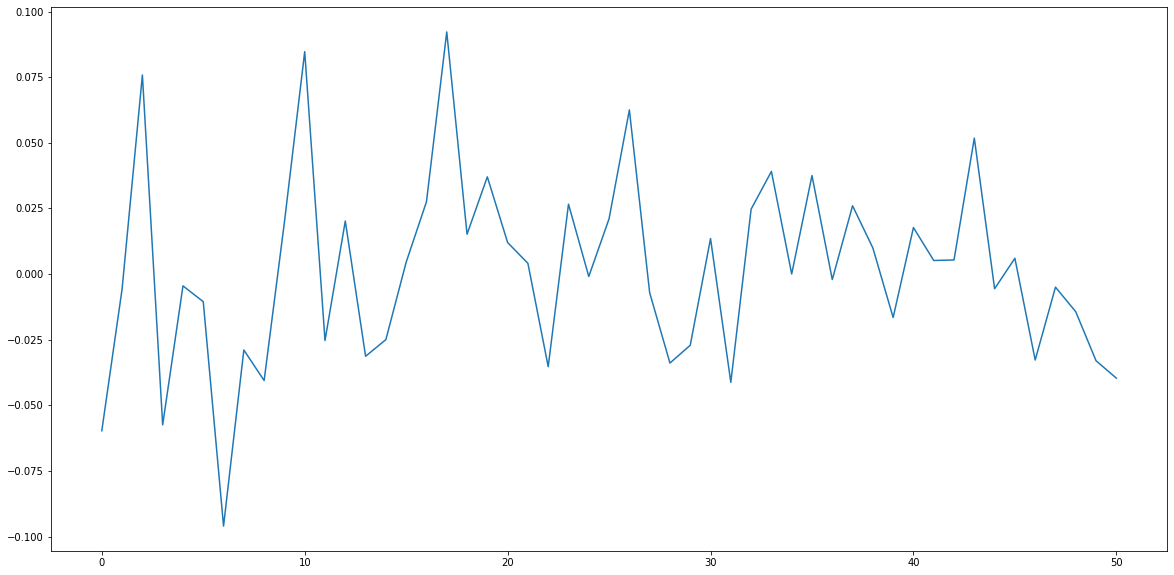

(51,)


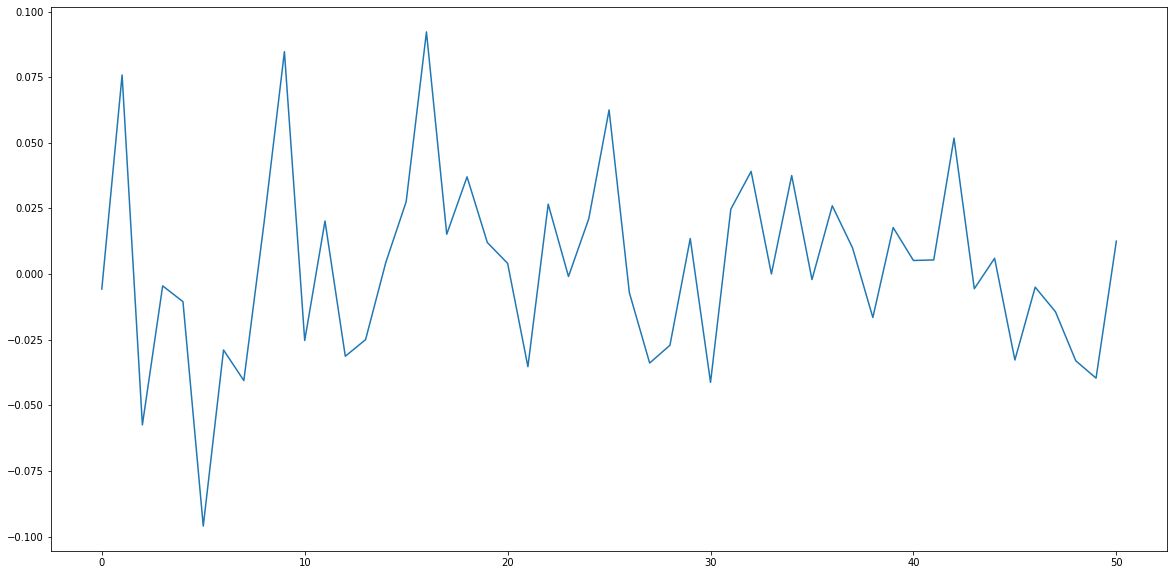

(51,)


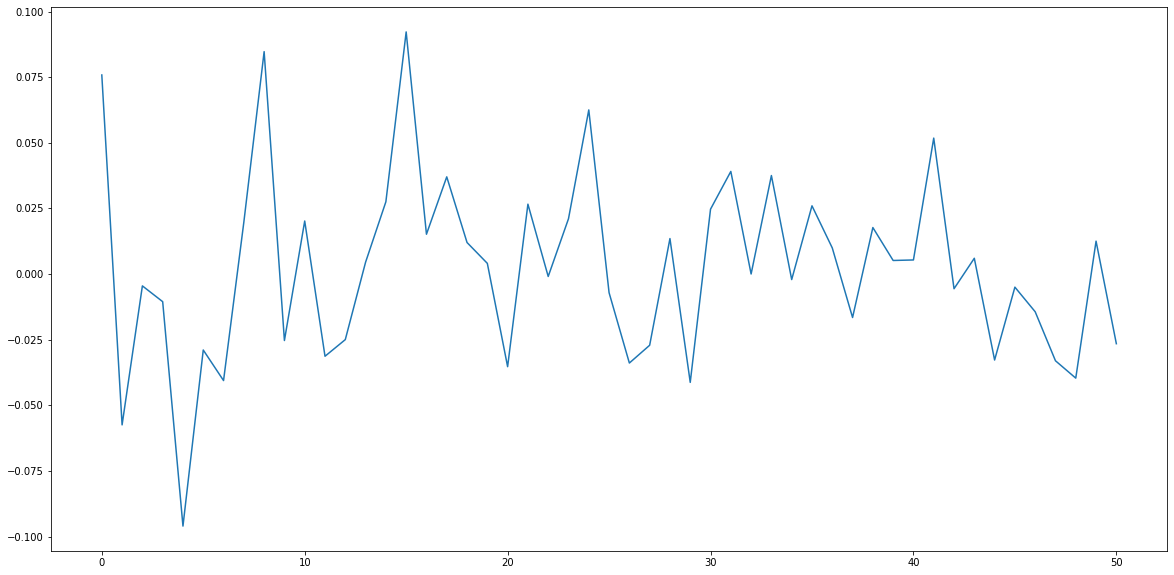

(51,)


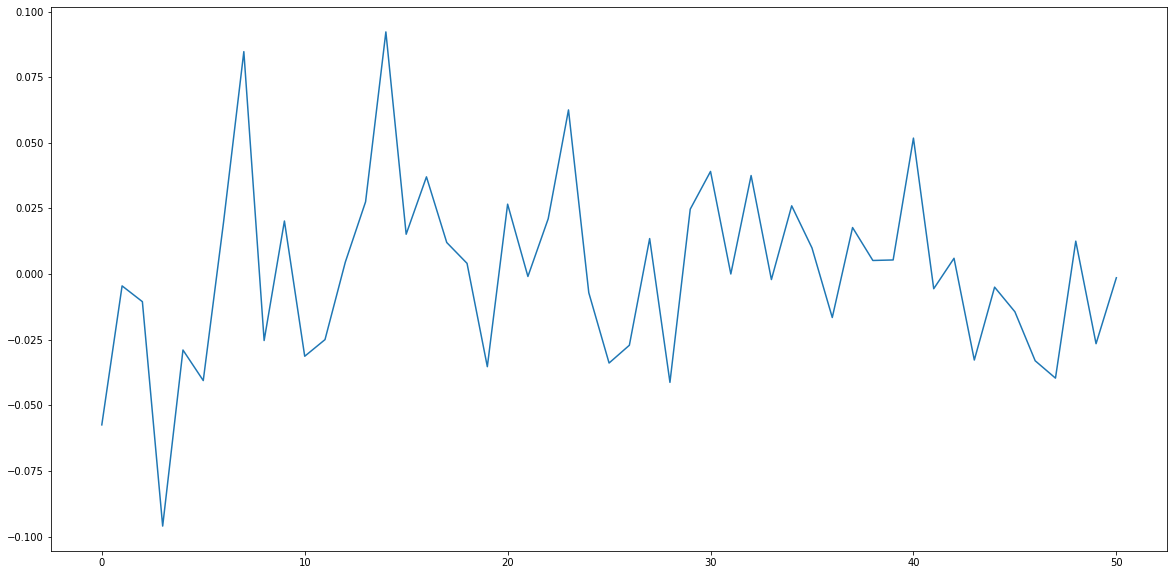

In [305]:
model_AttentionOut = model  # include here your original model

layer_name = 'timestep_diff'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    print(intermediate_output[0,:,7060].shape)
    plt.figure(figsize=(20,10))
    plt.plot(intermediate_output[0,:,7060])
    plt.show()

In [448]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)


model.summary()

model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=6, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ])

valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Model: "Flattened_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 52, 100)           4040400   
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_65 (Dense)             (None, 1000)              101000    
Total params: 4,221,800
Trainable params: 4,221,800
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 28 samples
Epoch 1/1000
 6/88 [=>............................] - ETA: 3sWAR

ValueError: Dimensions must be equal, but are 1000 and 10000 for 'loss/dense_65_loss/sub' (op: 'Sub') with input shapes: [?,1000], [?,10000].

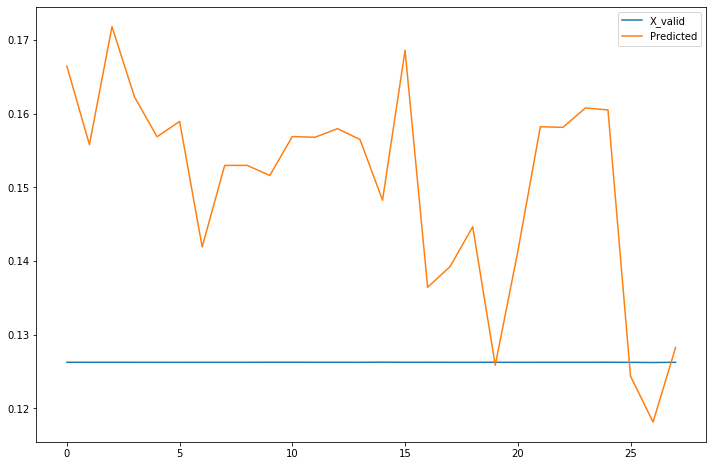

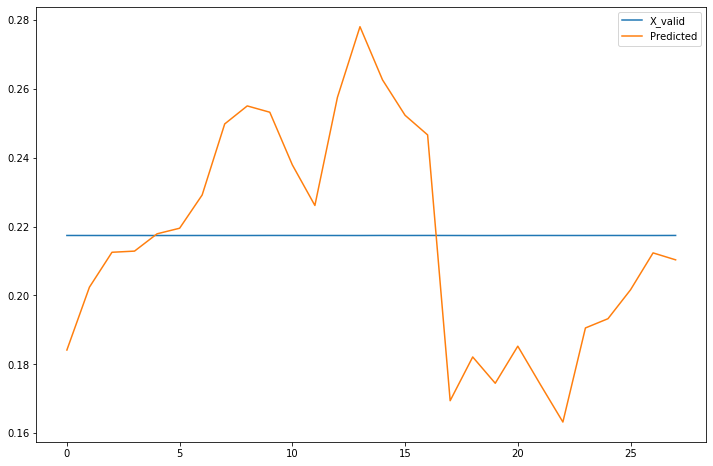

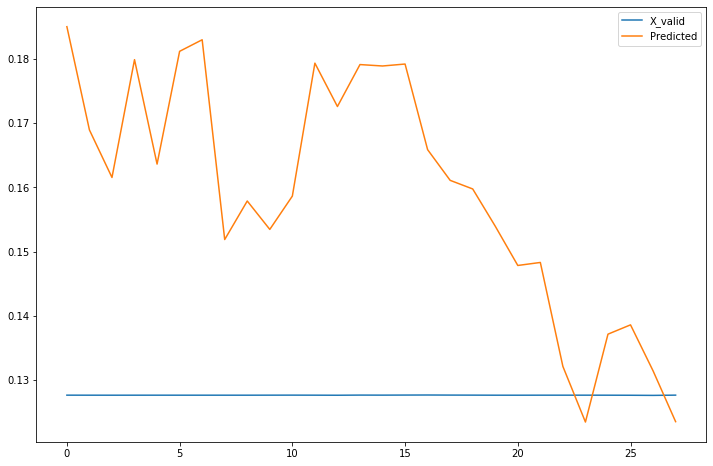

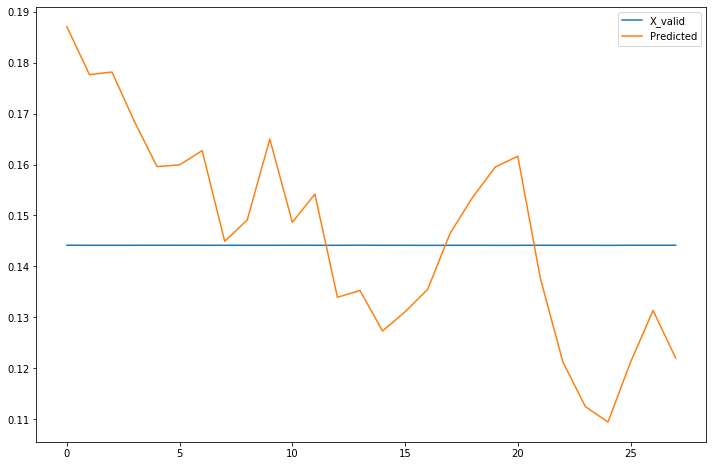

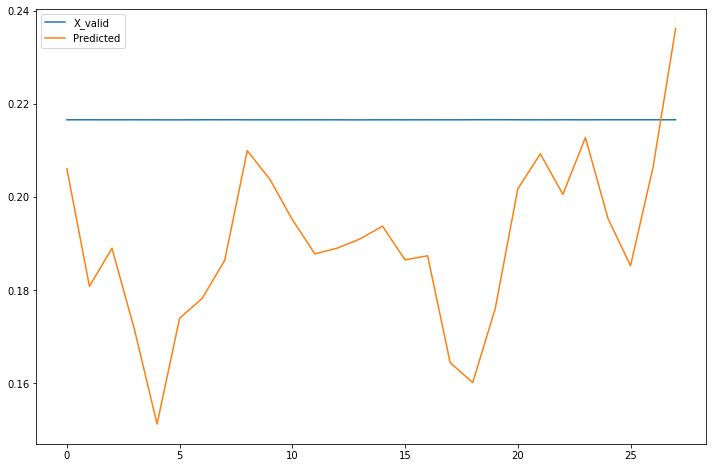

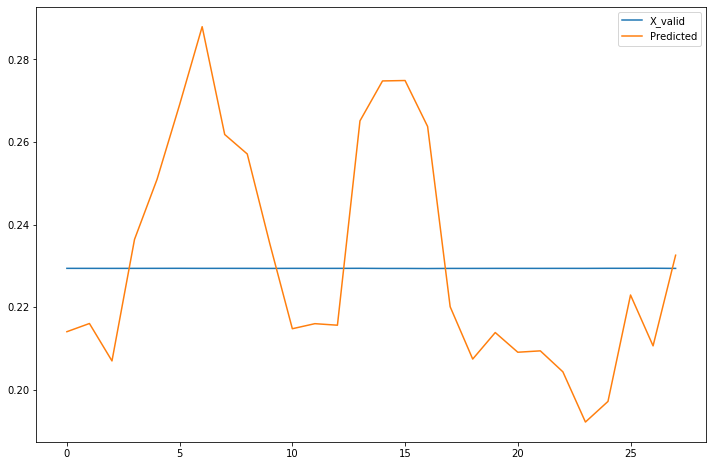

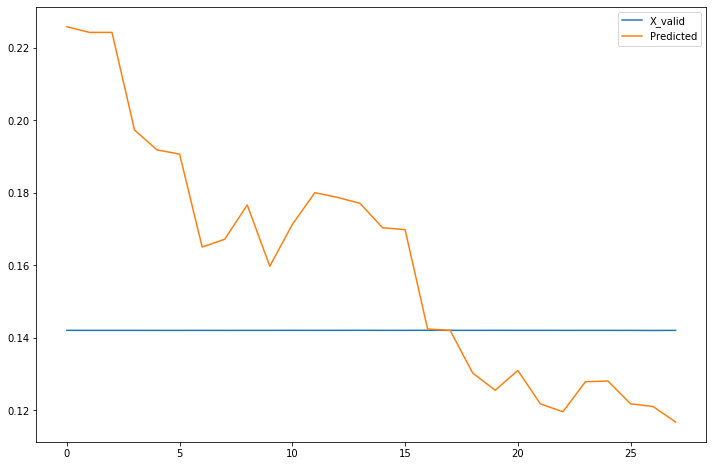

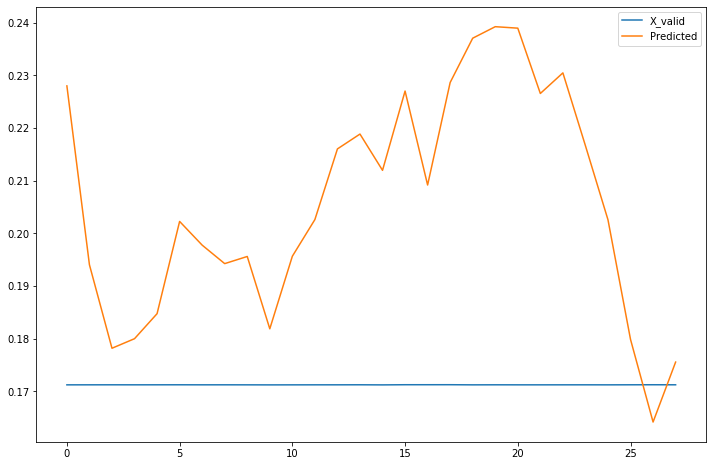

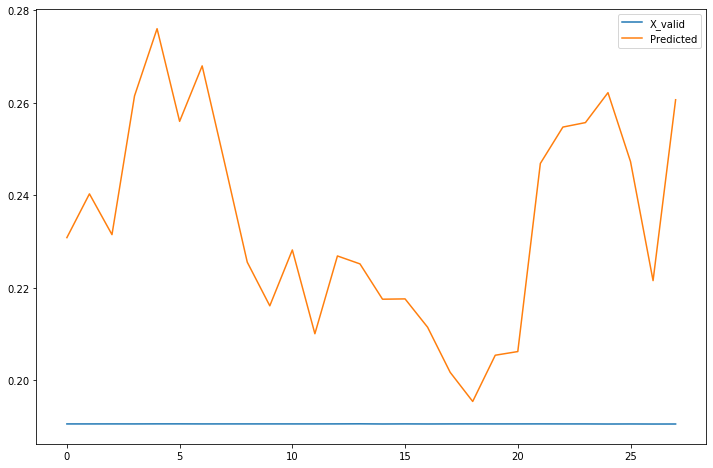

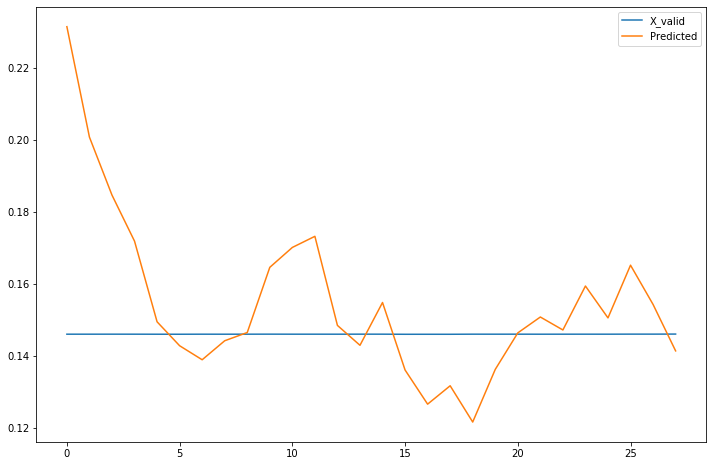

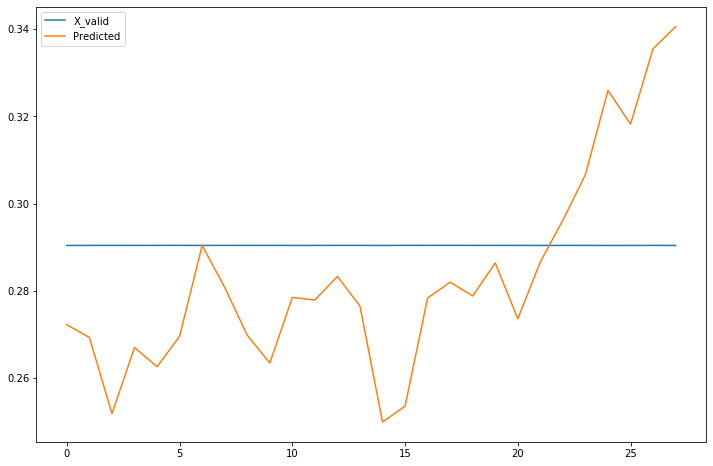

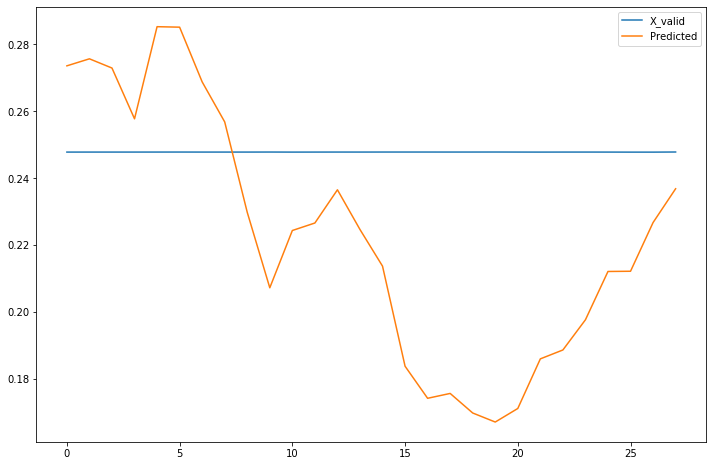

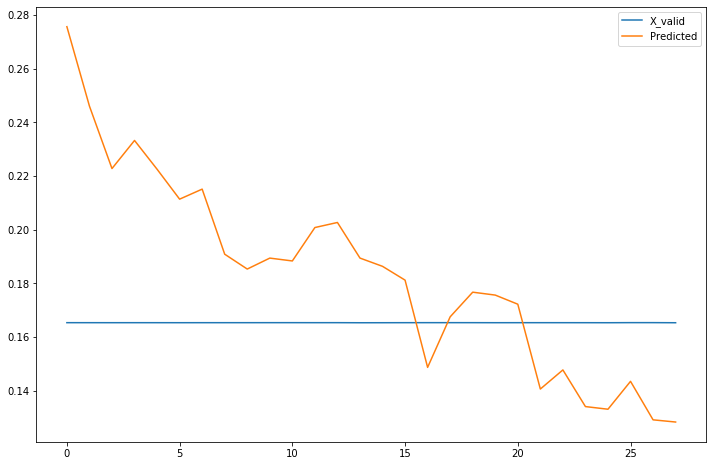

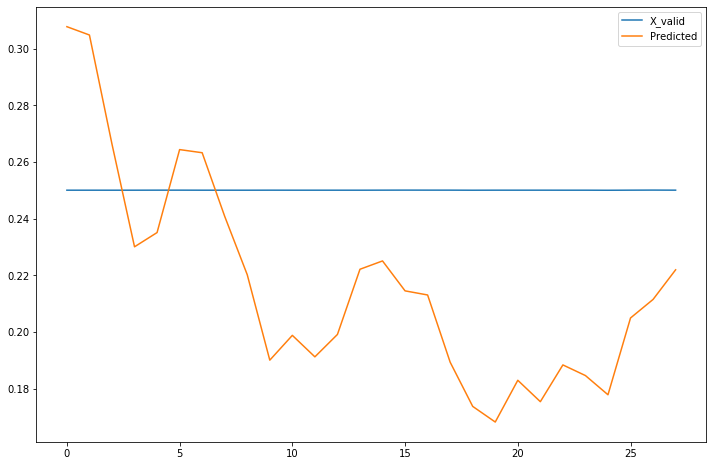

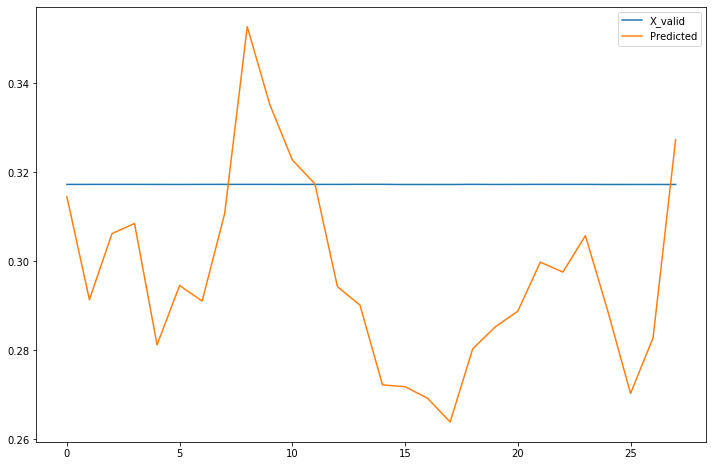

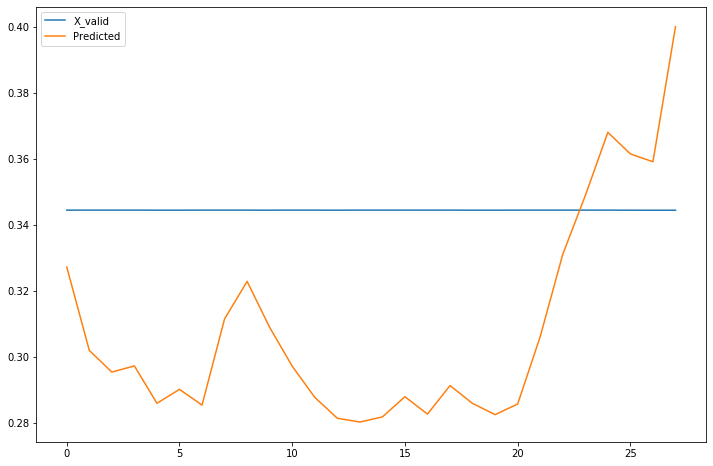

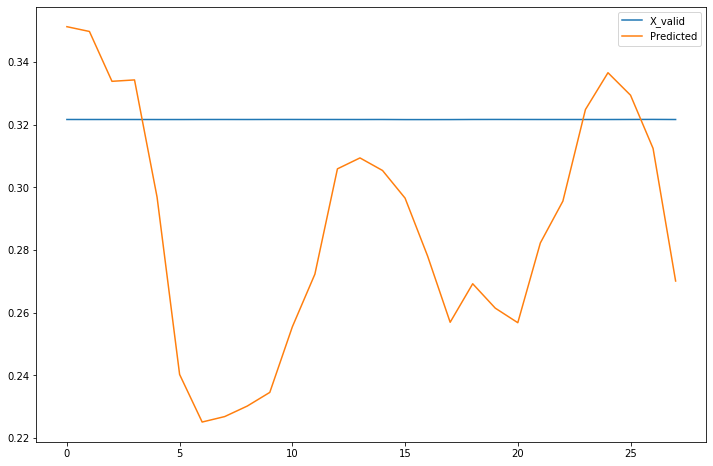

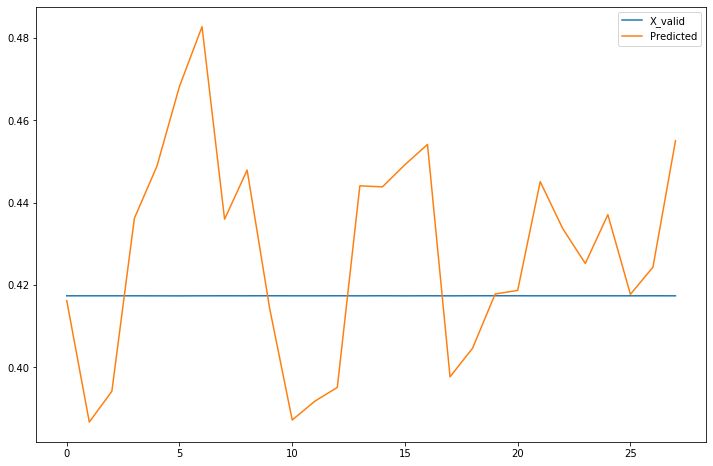

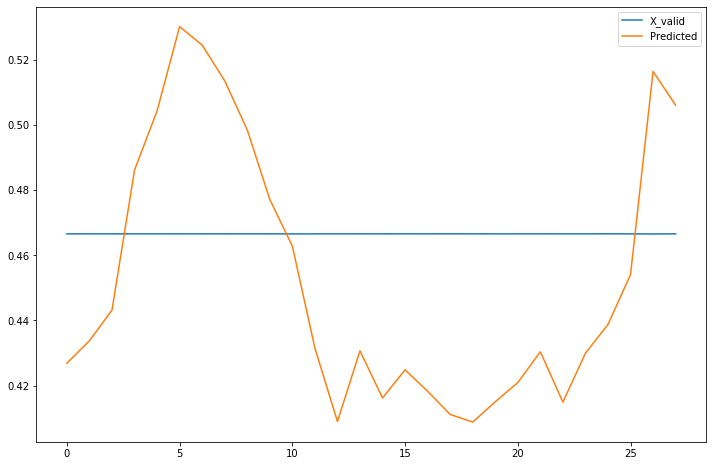

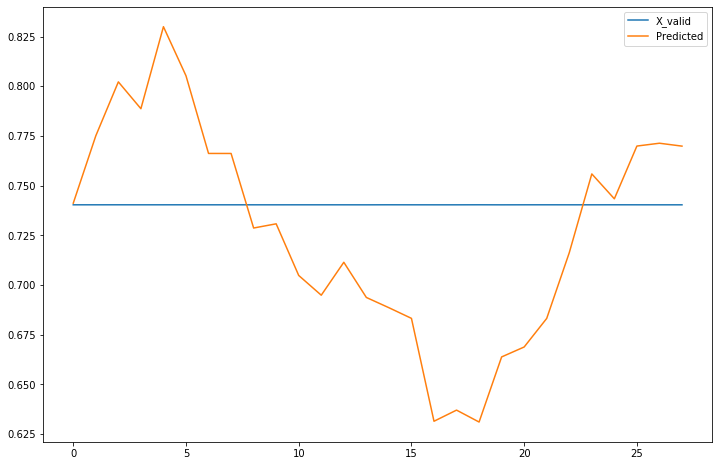

In [307]:
Predict = model.predict(X_valid)
for i in np.argsort(Y_valid)[:,-20:][0]:
    pd.DataFrame(np.transpose(np.vstack([Predict[:,i],Y_valid[:,i]])),columns=["X_valid","Predicted"]).plot(figsize=(12,8))

In [308]:
for i in range(Predict.shape[0]-1):
    diff_ts = Predict[i,:] - Predict[i+1,:]
    print(np.sum(diff_ts[np.argsort(diff_ts)]))

8.436758e-05
2.4692155e-05
-2.4693087e-05
-0.0005259253
-0.00020185392
0.00074565597
0.00018047541
-0.00038351864
0.00026562996
-0.00041406602
0.0003558686
-0.0014496036
0.0014160462
0.00012625754
-0.0023436174
-2.901256e-05
0.000696782
0.0009964257
-0.0005347617
0.0014123265
-0.0008938182
0.00051668845
0.000252062
0.000110108405
0.00075205043
0.0010715537
-0.0021801963
